# PREDICTING AXL-MEDIATED CANCER PHENOTYPES

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import R2Y_across_components
from msresist.figures.figure1 import pca_dfs
from msresist.figures.figure3 import plotR2YQ2Y, plotActualVsPredicted, plotScoresLoadings, plotClusters, plotPCA 
from msresist.clustering import MassSpecClustering
import matplotlib.pyplot as plt
from msresist.pre_processing import preprocessing, y_pre, FixColumnLabels
from msresist.distances import DataFrameRipleysK
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

$$ p_{xj} $$

In [2]:
# pd.set_option('display.max_colwidth', 1000)
# pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

## Check MS Variability Across Replicates

In [3]:
# from msresist.figures.figure1 import plotVarReplicates

# fig, ax = plt.subplots(1, 2, figsize=(10, 6))
# plotVarReplicates(ax, preprocessing(Axlmuts_ErlAF154=True, rawdata=True))

## Import and Preprocess Signaling data

### Phosphorylation measurements:

In [4]:
X = preprocessing(Axlmuts_ErlAF154=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)

d = X.select_dtypes(include=['float64']).T
i = X.select_dtypes(include=['object'])

all_lines = ["WT", "KO", "KD", "KI", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"] 
mut_lines = all_lines[1:]
g_lines = all_lines[2:]

d.index = all_lines

In [5]:
X.shape

(409, 16)

## Cell Phenotypes

### Cell Viability

In [6]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR1_Phase.csv")
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR2_Phase.csv')
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')
cv4 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/CellViability/Phase/BR3_Phase.csv')

In [7]:
itp = 24
ftp = 96

cv = [cv1, cv2, cv3, cv4]
cv= FixColumnLabels(cv)

v_ut = y_pre(cv, "UT", ftp, "Viability", all_lines, itp=itp)
v_e = y_pre(cv, "-E", ftp, "Viability", all_lines, itp=itp)
v_ae = y_pre(cv, "A/E", ftp, "Viability", all_lines, itp=itp)

In [8]:
v_ae

Lines Treatment  Viability
0      WT       A/E   4.403463
1      KO       A/E   1.661781
2      KD       A/E   2.430256
3      KI       A/E   3.194731
4   Y634F       A/E   3.000097
5   Y643F       A/E   3.051070
6   Y698F       A/E   3.819585
7   Y726F       A/E   3.599395
8  Y750F        A/E   3.680701
9   Y821F       A/E   2.955662

### Cell Death

In [9]:
red1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR1_RedCount.csv")
red2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR2_RedCount.csv")
red3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR3_RedCount.csv")
red4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/CellViability/Red/BR4_RedCount.csv")
red4.columns = red3.columns

In [10]:
for jj in range(1, red1.columns.size):
    red1.iloc[: , jj] /= cv1.iloc[:, jj]
    red2.iloc[: , jj] /= cv2.iloc[:, jj]
    red3.iloc[: , jj] /= cv3.iloc[:, jj]
    red4.iloc[: , jj] /= cv4.iloc[:, jj]


cD = [red1, red2, red3, red4]
cD = FixColumnLabels(cD)
cd_ut = y_pre(cD, "UT", ftp, "Apoptosis", all_lines, itp=itp)
cd_e = y_pre(cD, "-E", ftp, "Apoptosis", all_lines, itp=itp)
cd_ae = y_pre(cD, "A/E", ftp, "Apoptosis", all_lines, itp=itp)

In [11]:
cd_ae

Lines Treatment  Apoptosis
0      WT       A/E   3.691883
1      KO       A/E   7.664414
2      KD       A/E   4.564952
3      KI       A/E   4.377763
4   Y634F       A/E   3.669173
5   Y643F       A/E   5.044015
6   Y698F       A/E   3.803003
7   Y726F       A/E   3.277052
8  Y750F        A/E   3.320825
9   Y821F       A/E   2.643537

### Cell Migration

In [12]:
r1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR1_RWD.csv")
r2 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR2_RWD.csv")
r3 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR3_RWD.csv")
r4 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/EMT/BR4_RWD.csv")

In [13]:
ftp = 14
cm = [r1, r2, r3, r4]
m_ut = y_pre(cm, "UT", ftp, "Migration", all_lines)
m_e = y_pre(cm, " E", ftp, "Migration", all_lines)
m_ae = y_pre(cm, "A/E", ftp, "Migration", all_lines)

m_ut.index = v_ut.index
m_e.index = v_e.index
m_ae.index = v_ae.index

In [14]:
m_ae

Lines Treatment  Migration
0      WT       A/E  86.079400
1      KO       A/E  63.677377
2      KD       A/E  64.119874
3      KI       A/E  84.625985
4   Y634F       A/E  82.797170
5   Y643F       A/E  84.187636
6   Y698F       A/E  86.223829
7   Y726F       A/E  82.915381
8  Y750F        A/E  78.383198
9   Y821F       A/E  74.318286

### Clustering Effect

In [15]:
mutants = ['PC9', 'KO', 'KIN', 'KD', 'M4', 'M5', 'M7', 'M10', 'M11', 'M15']
treatments = ['ut', 'e', 'ae']
replicates = 6
radius = np.linspace(1, 14.67, 1)
folder = '48hrs'
c = DataFrameRipleysK(folder, mutants, treatments, replicates, radius).reset_index().set_index("Mutant")
c.columns = ["Treatment", "Island"]
c_ut = c[c["Treatment"] == "ut"]
c_ut = c_ut.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ut.index = all_lines
c_ut = c_ut.reset_index()
c_ut["Treatment"] = "UT"

c_e = c[c["Treatment"] == "e"]
c_e = c_e.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_e.index = all_lines
c_e = c_e.reset_index()
c_e["Treatment"] = "E"

c_ae = c[c["Treatment"] == "ae"]
c_ae = c_ae.reindex(list(mutants[:2]) + [mutants[3]] + [mutants[2]] + list(mutants[4:]))
c_ae.index = all_lines
c_ae = c_ae.reset_index()
c_ae["Treatment"] = "A/E"

In [16]:
c_ae

index Treatment    Island
0      WT       A/E  1.839896
1      KO       A/E  2.965147
2      KD       A/E  3.900568
3      KI       A/E  1.794788
4   Y634F       A/E  2.111434
5   Y643F       A/E  1.905572
6   Y698F       A/E  1.767987
7   Y726F       A/E  1.948927
8  Y750F        A/E  2.888233
9   Y821F       A/E  3.164585

### PCA Analysis

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [18]:
y_ae = pd.concat([v_ae, cd_ae["Apoptosis"], m_ae["Migration"], c_ae["Island"]], axis=1)
y_e =  pd.concat([v_e, cd_e["Apoptosis"], m_e["Migration"], c_ae["Island"]], axis=1)
y_ut =  pd.concat([v_ut, cd_ut["Apoptosis"], m_ut["Migration"], c_ae["Island"]], axis=1)


y_c = pd.concat([y_ut, y_e, y_ae])
y_c.iloc[:, 2:] = StandardScaler().fit_transform(y_c.iloc[:, 2:])
y_c.head()

Lines Treatment  Viability  Apoptosis  Migration    Island
0     WT        UT   1.911853  -1.017308   1.687907 -0.833010
1     KO        UT   0.784421  -1.187840   1.264028  0.758900
2     KD        UT   1.369026  -1.218372   1.242270  2.082257
3     KI        UT   1.622194  -1.199679   1.103087 -0.896825
4  Y634F        UT   1.068318  -1.117639   1.453431 -0.448861

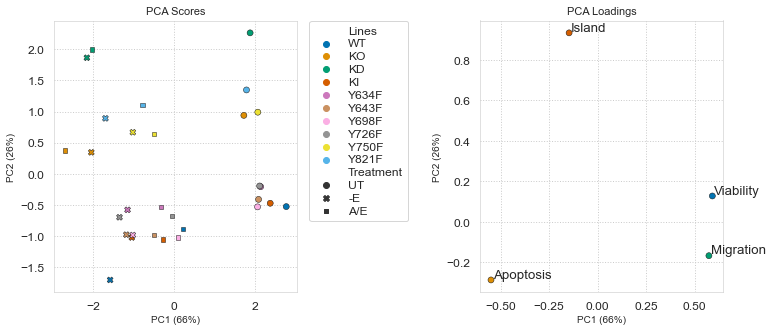

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.75, hspace=None)
plotPCA(ax, y_c, 3, ["Lines", "Treatment"], "Phenotype", hue_scores="Lines", style_scores="Treatment", hue_load="Phenotype", legendOut=True)

#### Build Y Matrix with a Specific Treatment to Model:

With Axl-activating antibody:

In [20]:
y = y_ae.drop("Treatment", axis=1).set_index("Lines")

# 0-. Final X and Y data sets to model

If dropping "WT", run:

In [21]:
# x = X.drop("PC9 A", axis=1)
# d = x.select_dtypes(include=['float64']).T
# i = x.select_dtypes(include=['object'])
# y = y.drop("WT")
# lines = mut_lines

In [22]:
# y = y.drop(["Migration"], axis=1)

Else:

In [23]:
lines = all_lines

# 1-.Fitting PLSR model to the full data set

#### R2Y/Q2Y

In [24]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p1 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p1, d, y, 1, 5)

#### Predictions

In [25]:
# fig, ax = plt.subplots(1, 4, figsize=(20,5))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# p2 = PLSRegression(n_components=2)
# plotActualVsPredicted(ax, p2, d, y, 2, y_pred="cross-validation")

In [26]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p1.fit(d, y), d, y, 0, lines, cv=1, data="full", annotate=False)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)

# 2-Clustering and PLSR model

In [27]:
ncl = 7

## 2.1-Standard Clustering methods + PLSR

#### k-means:

In [28]:
# from sklearn.cluster import KMeans

# labels = KMeans(n_clusters=ncl).fit(d.T).labels_
# x_ = X.copy()
# x_["Cluster"] = labels
# c1 = x_.groupby("Cluster").mean().T

#### SKLEARN's GMM:

In [29]:
# from sklearn.mixture import GaussianMixture

# gmm = GaussianMixture(n_components=ncl).fit(d.T)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### POMEGRANATE's GMM:

In [30]:
# from pomegranate import GeneralMixtureModel, NormalDistribution

# gmm = GeneralMixtureModel.from_samples(NormalDistribution, X=d.T, n_components=ncl, n_jobs=-1)
# x_ = x.copy()
# x_["Cluster"] = gmm.predict(d.T)
# c1 = x_.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [31]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p2 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p2, c1, y, 1, ncl+1)
# # plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

In [32]:
# ig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p2, c1, y, 1, y_pred="cross-validation")
# # plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

In [33]:
# fig, ax = plt.subplots(1, 2, figsize=(14,6))
# plotScoresLoadings(ax, p2.fit(c1, y), c1, y, ncl, lines, 1)
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

## 2.2-Co-clustering and PLSR

## Cross-validation Strategy 1: Leaving one condition out across fixed clusters

In [34]:
# a = np.array([[1,2,3,-14], [5,6,7,-5], [-np.inf, 323, 5, 2]])
# np.amin(a)
# np.amin(np.array(a)[a != -np.inf])

### Fitting PLSR each time

In [35]:
distance_method = "PAM250"
SeqWeight = 10
ncl = 5

MSC = MassSpecClustering(i, ncl, SeqWeight=SeqWeight, distance_method=distance_method).fit(d, y)
c2 = MSC.transform(d)

In [36]:
MSC.predict_UpstreamKinases(X["Sequence"]).head()

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.254158  1.118929  1.011811  1.160842  1.180488  0.234283  1.048371   
1   1.785949  1.937176  1.941299  1.782612  1.541855  1.562915  1.287540   
2   1.069501  0.977914  0.800879  1.036241  0.803275  0.959646  0.762752   
3   1.043116  0.932275  0.585547  0.839508  0.868562  0.754969  1.006233   
4   1.431929  1.573366  2.093630  1.126822  1.992860  1.320417  1.595149   
5   1.141562  1.126948  1.103248  0.889311  1.243428  0.884191  1.086300   
6   1.642800  1.593830  1.538806  1.459468  1.796752  1.751909  1.645137   
7   1.561590  1.935125  1.785802  1.693332  1.156910  1.536233  1.395897   
8   1.287025  1.065983  1.398784  1.269638  1.094285  1.871759  1.542351   
9   1.379355  1.279947  1.438226  1.276969  1.031120  1.546185  1.340729   
10  2.022086  1.547434  1.830996  2.016092  2.078463  2.100710  1.655388   
11  1.698933  1.510054  1.666062  1.470852  1.777784  1.998378  1.507441   
12  1.041747  1.136266  1.066523  0.801115  0.690579  1.685278  1.487724   
13  1.055025  1.437491  1.121930  1.366594  1.145816  1.319108  1.104831   
14  0.955249  1.138368  1.105682  1.199463  0.605420  1.044327  1.245081   
15  0.970166  1.034031  0.778619  0.951972  0.906136  0.893708  1.158389   
16  1.103744  1.414338  1.539672  1.316539  1.151259  1.498725  1.143752   
17  1.407804  1.347724  1.472150  1.428569  1.263519  0.186735  1.113261   
18  2.737026  2.650358  2.860976  2.878207  2.401725  1.976779  1.989757   
19  1.642041  1.655494  1.707721  1.562164  1.530974  1.033280  1.446541   

           7         8  
0   0.977491  1.019992  
1   1.370982  2.342639  
2   0.964389  0.930807  
3   1.132631  1.145168  
4   1.058047  1.417643  
5   1.121624  1.334870  
6   1.879128  1.574407  
7   1.451504  1.501517  
8   1.737589  1.133049  
9   1.189270  1.283453  
10  1.913801  2.390672  
11  1.728178  1.481213  
12  1.318069  1.023112  
13  1.388022  1.429952  
14  1.418524  1.119460  
15  1.190765  1.162966  
16  1.051210  1.318355  
17  0.927571  1.314504  
18  2.234292  2.140011  
19  1.220600  1.619647

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.254158  1.118929  1.011811  1.160842  1.180488  0.234283  1.048371   
1   1.785949  1.937176  1.941299  1.782612  1.541855  1.562915  1.287540   
2   1.069501  0.977914  0.800879  1.036241  0.803275  0.959646  0.762752   
3   1.043116  0.932275  0.585547  0.839508  0.868562  0.754969  1.006233   
4   1.431929  1.573366  2.093630  1.126822  1.992860  1.320417  1.595149   
5   1.141562  1.126948  1.103248  0.889311  1.243428  0.884191  1.086300   
6   1.642800  1.593830  1.538806  1.459468  1.796752  1.751909  1.645137   
7   1.561590  1.935125  1.785802  1.693332  1.156910  1.536233  1.395897   
8   1.287025  1.065983  1.398784  1.269638  1.094285  1.871759  1.542351   
9   1.379355  1.279947  1.438226  1.276969  1.031120  1.546185  1.340729   
10  2.022086  1.547434  1.830996  2.016092  2.078463  2.100710  1.655388   
11  1.698933  1.510054  1.666062  1.470852  1.777784  1.998378  1.507441   
12  1.041747  1.136266  1.066523  0.801115  0.690579  1.685278  1.487724   
13  1.055025  1.437491  1.121930  1.366594  1.145816  1.319108  1.104831   
14  0.955249  1.138368  1.105682  1.199463  0.605420  1.044327  1.245081   
15  0.970166  1.034031  0.778619  0.951972  0.906136  0.893708  1.158389   
16  1.103744  1.414338  1.539672  1.316539  1.151259  1.498725  1.143752   
17  1.407804  1.347724  1.472150  1.428569  1.263519  0.186735  1.113261   
18  2.737026  2.650358  2.860976  2.878207  2.401725  1.976779  1.989757   
19  1.642041  1.655494  1.707721  1.562164  1.530974  1.033280  1.446541   

           7         8  
0   0.977491  1.019992  
1   1.370982  2.342639  
2   0.964389  0.930807  
3   1.132631  1.145168  
4   1.058047  1.417643  
5   1.121624  1.334870  
6   1.879128  1.574407  
7   1.451504  1.501517  
8   1.737589  1.133049  
9   1.189270  1.283453  
10  1.913801  2.390672  
11  1.728178  1.481213  
12  1.318069  1.023112  
13  1.388022  1.429952  
14  1.418524  1.119460  
15  1.190765  1.162966  
16  1.051210  1.318355  
17  0.927571  1.314504  
18  2.234292  2.140011  
19  1.220600  1.619647

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.254158  1.118929  1.011811  1.160842  1.180488  0.234283  1.048371   
1   1.785949  1.937176  1.941299  1.782612  1.541855  1.562915  1.287540   
2   1.069501  0.977914  0.800879  1.036241  0.803275  0.959646  0.762752   
3   1.043116  0.932275  0.585547  0.839508  0.868562  0.754969  1.006233   
4   1.431929  1.573366  2.093630  1.126822  1.992860  1.320417  1.595149   
5   1.141562  1.126948  1.103248  0.889311  1.243428  0.884191  1.086300   
6   1.642800  1.593830  1.538806  1.459468  1.796752  1.751909  1.645137   
7   1.561590  1.935125  1.785802  1.693332  1.156910  1.536233  1.395897   
8   1.287025  1.065983  1.398784  1.269638  1.094285  1.871759  1.542351   
9   1.379355  1.279947  1.438226  1.276969  1.031120  1.546185  1.340729   
10  2.022086  1.547434  1.830996  2.016092  2.078463  2.100710  1.655388   
11  1.698933  1.510054  1.666062  1.470852  1.777784  1.998378  1.507441   
12  1.041747  1.136266  1.066523  0.801115  0.690579  1.685278  1.487724   
13  1.055025  1.437491  1.121930  1.366594  1.145816  1.319108  1.104831   
14  0.955249  1.138368  1.105682  1.199463  0.605420  1.044327  1.245081   
15  0.970166  1.034031  0.778619  0.951972  0.906136  0.893708  1.158389   
16  1.103744  1.414338  1.539672  1.316539  1.151259  1.498725  1.143752   
17  1.407804  1.347724  1.472150  1.428569  1.263519  0.186735  1.113261   
18  2.737026  2.650358  2.860976  2.878207  2.401725  1.976779  1.989757   
19  1.642041  1.655494  1.707721  1.562164  1.530974  1.033280  1.446541   

           7         8  
0   0.977491  1.019992  
1   1.370982  2.342639  
2   0.964389  0.930807  
3   1.132631  1.145168  
4   1.058047  1.417643  
5   1.121624  1.334870  
6   1.879128  1.574407  
7   1.451504  1.501517  
8   1.737589  1.133049  
9   1.189270  1.283453  
10  1.913801  2.390672  
11  1.728178  1.481213  
12  1.318069  1.023112  
13  1.388022  1.429952  
14  1.418524  1.119460  
15  1.190765  1.162966  
16  1.051210  1.318355  
17  0.927571  1.314504  
18  2.234292  2.140011  
19  1.220600  1.619647

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.254158  1.118929  1.011811  1.160842  1.180488  0.234283  1.048371   
1   1.785949  1.937176  1.941299  1.782612  1.541855  1.562915  1.287540   
2   1.069501  0.977914  0.800879  1.036241  0.803275  0.959646  0.762752   
3   1.043116  0.932275  0.585547  0.839508  0.868562  0.754969  1.006233   
4   1.431929  1.573366  2.093630  1.126822  1.992860  1.320417  1.595149   
5   1.141562  1.126948  1.103248  0.889311  1.243428  0.884191  1.086300   
6   1.642800  1.593830  1.538806  1.459468  1.796752  1.751909  1.645137   
7   1.561590  1.935125  1.785802  1.693332  1.156910  1.536233  1.395897   
8   1.287025  1.065983  1.398784  1.269638  1.094285  1.871759  1.542351   
9   1.379355  1.279947  1.438226  1.276969  1.031120  1.546185  1.340729   
10  2.022086  1.547434  1.830996  2.016092  2.078463  2.100710  1.655388   
11  1.698933  1.510054  1.666062  1.470852  1.777784  1.998378  1.507441   
12  1.041747  1.136266  1.066523  0.801115  0.690579  1.685278  1.487724   
13  1.055025  1.437491  1.121930  1.366594  1.145816  1.319108  1.104831   
14  0.955249  1.138368  1.105682  1.199463  0.605420  1.044327  1.245081   
15  0.970166  1.034031  0.778619  0.951972  0.906136  0.893708  1.158389   
16  1.103744  1.414338  1.539672  1.316539  1.151259  1.498725  1.143752   
17  1.407804  1.347724  1.472150  1.428569  1.263519  0.186735  1.113261   
18  2.737026  2.650358  2.860976  2.878207  2.401725  1.976779  1.989757   
19  1.642041  1.655494  1.707721  1.562164  1.530974  1.033280  1.446541   

           7         8  
0   0.977491  1.019992  
1   1.370982  2.342639  
2   0.964389  0.930807  
3   1.132631  1.145168  
4   1.058047  1.417643  
5   1.121624  1.334870  
6   1.879128  1.574407  
7   1.451504  1.501517  
8   1.737589  1.133049  
9   1.189270  1.283453  
10  1.913801  2.390672  
11  1.728178  1.481213  
12  1.318069  1.023112  
13  1.388022  1.429952  
14  1.418524  1.119460  
15  1.190765  1.162966  
16  1.051210  1.318355  
17  0.927571  1.314504  
18  2.234292  2.140011  
19  1.220600  1.619647

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.254158  1.118929  1.011811  1.160842  1.180488  0.234283  1.048371   
1   1.785949  1.937176  1.941299  1.782612  1.541855  1.562915  1.287540   
2   1.069501  0.977914  0.800879  1.036241  0.803275  0.959646  0.762752   
3   1.043116  0.932275  0.585547  0.839508  0.868562  0.754969  1.006233   
4   1.431929  1.573366  2.093630  1.126822  1.992860  1.320417  1.595149   
5   1.141562  1.126948  1.103248  0.889311  1.243428  0.884191  1.086300   
6   1.642800  1.593830  1.538806  1.459468  1.796752  1.751909  1.645137   
7   1.561590  1.935125  1.785802  1.693332  1.156910  1.536233  1.395897   
8   1.287025  1.065983  1.398784  1.269638  1.094285  1.871759  1.542351   
9   1.379355  1.279947  1.438226  1.276969  1.031120  1.546185  1.340729   
10  2.022086  1.547434  1.830996  2.016092  2.078463  2.100710  1.655388   
11  1.698933  1.510054  1.666062  1.470852  1.777784  1.998378  1.507441   
12  1.041747  1.136266  1.066523  0.801115  0.690579  1.685278  1.487724   
13  1.055025  1.437491  1.121930  1.366594  1.145816  1.319108  1.104831   
14  0.955249  1.138368  1.105682  1.199463  0.605420  1.044327  1.245081   
15  0.970166  1.034031  0.778619  0.951972  0.906136  0.893708  1.158389   
16  1.103744  1.414338  1.539672  1.316539  1.151259  1.498725  1.143752   
17  1.407804  1.347724  1.472150  1.428569  1.263519  0.186735  1.113261   
18  2.737026  2.650358  2.860976  2.878207  2.401725  1.976779  1.989757   
19  1.642041  1.655494  1.707721  1.562164  1.530974  1.033280  1.446541   

           7         8  
0   0.977491  1.019992  
1   1.370982  2.342639  
2   0.964389  0.930807  
3   1.132631  1.145168  
4   1.058047  1.417643  
5   1.121624  1.334870  
6   1.879128  1.574407  
7   1.451504  1.501517  
8   1.737589  1.133049  
9   1.189270  1.283453  
10  1.913801  2.390672  
11  1.728178  1.481213  
12  1.318069  1.023112  
13  1.388022  1.429952  
14  1.418524  1.119460  
15  1.190765  1.162966  
16  1.051210  1.318355  
17  0.927571  1.314504  
18  2.234292  2.140011  
19  1.220600  1.619647

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.192876  1.123835  1.384365  1.211170  1.110679  0.555301  1.212816   
1   1.943068  2.077278  2.067602  1.960690  1.332169  1.479593  1.468294   
2   1.063811  0.889592  0.835003  0.913637  0.832122  0.708478  0.951826   
3   1.237195  1.070675  0.689330  0.832273  0.703966  0.968847  0.926855   
4   1.449339  1.562890  2.032505  1.668177  1.750291  1.258920  1.505006   
5   1.064598  1.129710  1.071732  0.947348  1.301662  0.886476  1.230102   
6   1.597448  1.575057  1.489926  1.486094  1.983236  1.815306  1.640108   
7   1.375545  1.828438  1.718056  1.573828  1.250391  1.565668  1.288936   
8   1.191119  0.985216  1.349089  1.243372  1.173641  1.940598  1.498610   
9   1.093201  1.121021  1.149625  1.239249  0.902783  1.329192  1.093144   
10  1.951989  1.653450  1.764019  2.036842  2.352349  2.128058  1.662386   
11  1.611164  1.472298  1.585042  1.516124  1.743900  2.007757  1.479787   
12  1.023380  1.079813  1.105972  1.033890  1.259590  1.775769  1.434370   
13  1.212080  1.446837  1.209010  1.432448  1.290585  1.253503  1.156560   
14  1.104745  1.349911  1.136771  1.269772  0.738277  1.269272  1.332511   
15  1.072044  0.959364  0.971452  1.119180  1.011326  1.108180  1.146169   
16  1.140708  1.250528  1.443988  1.307507  1.312233  1.617518  1.161462   
17  1.459754  1.315744  1.356985  1.383320  1.214695  0.658906  1.236372   
18  2.709032  2.673156  2.689410  2.656908  2.240796  1.589283  2.016727   
19  1.605596  1.582841  1.737417  1.438018  1.542928  0.977708  1.339679   

           7         8  
0   1.402380  1.255778  
1   1.711870  2.497755  
2   1.226953  1.088518  
3   1.119632  1.075729  
4   1.178939  1.347031  
5   1.218316  1.375397  
6   1.862063  1.613198  
7   1.315807  1.423030  
8   1.784568  1.242086  
9   1.000420  1.127005  
10  1.745480  2.343295  
11  1.614122  1.458702  
12  1.199856  1.117508  
13  1.375928  1.413084  
14  1.153570  1.023805  
15  1.179363  1.136868  
16  1.173357  1.262251  
17  1.023655  1.325991  
18  2.542861  2.134765  
19  1.300709  1.501103

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.192876  1.123835  1.384365  1.211170  1.110679  0.555301  1.212816   
1   1.943068  2.077278  2.067602  1.960690  1.332169  1.479593  1.468294   
2   1.063811  0.889592  0.835003  0.913637  0.832122  0.708478  0.951826   
3   1.237195  1.070675  0.689330  0.832273  0.703966  0.968847  0.926855   
4   1.449339  1.562890  2.032505  1.668177  1.750291  1.258920  1.505006   
5   1.064598  1.129710  1.071732  0.947348  1.301662  0.886476  1.230102   
6   1.597448  1.575057  1.489926  1.486094  1.983236  1.815306  1.640108   
7   1.375545  1.828438  1.718056  1.573828  1.250391  1.565668  1.288936   
8   1.191119  0.985216  1.349089  1.243372  1.173641  1.940598  1.498610   
9   1.093201  1.121021  1.149625  1.239249  0.902783  1.329192  1.093144   
10  1.951989  1.653450  1.764019  2.036842  2.352349  2.128058  1.662386   
11  1.611164  1.472298  1.585042  1.516124  1.743900  2.007757  1.479787   
12  1.023380  1.079813  1.105972  1.033890  1.259590  1.775769  1.434370   
13  1.212080  1.446837  1.209010  1.432448  1.290585  1.253503  1.156560   
14  1.104745  1.349911  1.136771  1.269772  0.738277  1.269272  1.332511   
15  1.072044  0.959364  0.971452  1.119180  1.011326  1.108180  1.146169   
16  1.140708  1.250528  1.443988  1.307507  1.312233  1.617518  1.161462   
17  1.459754  1.315744  1.356985  1.383320  1.214695  0.658906  1.236372   
18  2.709032  2.673156  2.689410  2.656908  2.240796  1.589283  2.016727   
19  1.605596  1.582841  1.737417  1.438018  1.542928  0.977708  1.339679   

           7         8  
0   1.402380  1.255778  
1   1.711870  2.497755  
2   1.226953  1.088518  
3   1.119632  1.075729  
4   1.178939  1.347031  
5   1.218316  1.375397  
6   1.862063  1.613198  
7   1.315807  1.423030  
8   1.784568  1.242086  
9   1.000420  1.127005  
10  1.745480  2.343295  
11  1.614122  1.458702  
12  1.199856  1.117508  
13  1.375928  1.413084  
14  1.153570  1.023805  
15  1.179363  1.136868  
16  1.173357  1.262251  
17  1.023655  1.325991  
18  2.542861  2.134765  
19  1.300709  1.501103

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.192876  1.123835  1.384365  1.211170  1.110679  0.555301  1.212816   
1   1.943068  2.077278  2.067602  1.960690  1.332169  1.479593  1.468294   
2   1.063811  0.889592  0.835003  0.913637  0.832122  0.708478  0.951826   
3   1.237195  1.070675  0.689330  0.832273  0.703966  0.968847  0.926855   
4   1.449339  1.562890  2.032505  1.668177  1.750291  1.258920  1.505006   
5   1.064598  1.129710  1.071732  0.947348  1.301662  0.886476  1.230102   
6   1.597448  1.575057  1.489926  1.486094  1.983236  1.815306  1.640108   
7   1.375545  1.828438  1.718056  1.573828  1.250391  1.565668  1.288936   
8   1.191119  0.985216  1.349089  1.243372  1.173641  1.940598  1.498610   
9   1.093201  1.121021  1.149625  1.239249  0.902783  1.329192  1.093144   
10  1.951989  1.653450  1.764019  2.036842  2.352349  2.128058  1.662386   
11  1.611164  1.472298  1.585042  1.516124  1.743900  2.007757  1.479787   
12  1.023380  1.079813  1.105972  1.033890  1.259590  1.775769  1.434370   
13  1.212080  1.446837  1.209010  1.432448  1.290585  1.253503  1.156560   
14  1.104745  1.349911  1.136771  1.269772  0.738277  1.269272  1.332511   
15  1.072044  0.959364  0.971452  1.119180  1.011326  1.108180  1.146169   
16  1.140708  1.250528  1.443988  1.307507  1.312233  1.617518  1.161462   
17  1.459754  1.315744  1.356985  1.383320  1.214695  0.658906  1.236372   
18  2.709032  2.673156  2.689410  2.656908  2.240796  1.589283  2.016727   
19  1.605596  1.582841  1.737417  1.438018  1.542928  0.977708  1.339679   

           7         8  
0   1.402380  1.255778  
1   1.711870  2.497755  
2   1.226953  1.088518  
3   1.119632  1.075729  
4   1.178939  1.347031  
5   1.218316  1.375397  
6   1.862063  1.613198  
7   1.315807  1.423030  
8   1.784568  1.242086  
9   1.000420  1.127005  
10  1.745480  2.343295  
11  1.614122  1.458702  
12  1.199856  1.117508  
13  1.375928  1.413084  
14  1.153570  1.023805  
15  1.179363  1.136868  
16  1.173357  1.262251  
17  1.023655  1.325991  
18  2.542861  2.134765  
19  1.300709  1.501103

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.192876  1.123835  1.384365  1.211170  1.110679  0.555301  1.212816   
1   1.943068  2.077278  2.067602  1.960690  1.332169  1.479593  1.468294   
2   1.063811  0.889592  0.835003  0.913637  0.832122  0.708478  0.951826   
3   1.237195  1.070675  0.689330  0.832273  0.703966  0.968847  0.926855   
4   1.449339  1.562890  2.032505  1.668177  1.750291  1.258920  1.505006   
5   1.064598  1.129710  1.071732  0.947348  1.301662  0.886476  1.230102   
6   1.597448  1.575057  1.489926  1.486094  1.983236  1.815306  1.640108   
7   1.375545  1.828438  1.718056  1.573828  1.250391  1.565668  1.288936   
8   1.191119  0.985216  1.349089  1.243372  1.173641  1.940598  1.498610   
9   1.093201  1.121021  1.149625  1.239249  0.902783  1.329192  1.093144   
10  1.951989  1.653450  1.764019  2.036842  2.352349  2.128058  1.662386   
11  1.611164  1.472298  1.585042  1.516124  1.743900  2.007757  1.479787   
12  1.023380  1.079813  1.105972  1.033890  1.259590  1.775769  1.434370   
13  1.212080  1.446837  1.209010  1.432448  1.290585  1.253503  1.156560   
14  1.104745  1.349911  1.136771  1.269772  0.738277  1.269272  1.332511   
15  1.072044  0.959364  0.971452  1.119180  1.011326  1.108180  1.146169   
16  1.140708  1.250528  1.443988  1.307507  1.312233  1.617518  1.161462   
17  1.459754  1.315744  1.356985  1.383320  1.214695  0.658906  1.236372   
18  2.709032  2.673156  2.689410  2.656908  2.240796  1.589283  2.016727   
19  1.605596  1.582841  1.737417  1.438018  1.542928  0.977708  1.339679   

           7         8  
0   1.402380  1.255778  
1   1.711870  2.497755  
2   1.226953  1.088518  
3   1.119632  1.075729  
4   1.178939  1.347031  
5   1.218316  1.375397  
6   1.862063  1.613198  
7   1.315807  1.423030  
8   1.784568  1.242086  
9   1.000420  1.127005  
10  1.745480  2.343295  
11  1.614122  1.458702  
12  1.199856  1.117508  
13  1.375928  1.413084  
14  1.153570  1.023805  
15  1.179363  1.136868  
16  1.173357  1.262251  
17  1.023655  1.325991  
18  2.542861  2.134765  
19  1.300709  1.501103

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.192876  1.123835  1.384365  1.211170  1.110679  0.555301  1.212816   
1   1.943068  2.077278  2.067602  1.960690  1.332169  1.479593  1.468294   
2   1.063811  0.889592  0.835003  0.913637  0.832122  0.708478  0.951826   
3   1.237195  1.070675  0.689330  0.832273  0.703966  0.968847  0.926855   
4   1.449339  1.562890  2.032505  1.668177  1.750291  1.258920  1.505006   
5   1.064598  1.129710  1.071732  0.947348  1.301662  0.886476  1.230102   
6   1.597448  1.575057  1.489926  1.486094  1.983236  1.815306  1.640108   
7   1.375545  1.828438  1.718056  1.573828  1.250391  1.565668  1.288936   
8   1.191119  0.985216  1.349089  1.243372  1.173641  1.940598  1.498610   
9   1.093201  1.121021  1.149625  1.239249  0.902783  1.329192  1.093144   
10  1.951989  1.653450  1.764019  2.036842  2.352349  2.128058  1.662386   
11  1.611164  1.472298  1.585042  1.516124  1.743900  2.007757  1.479787   
12  1.023380  1.079813  1.105972  1.033890  1.259590  1.775769  1.434370   
13  1.212080  1.446837  1.209010  1.432448  1.290585  1.253503  1.156560   
14  1.104745  1.349911  1.136771  1.269772  0.738277  1.269272  1.332511   
15  1.072044  0.959364  0.971452  1.119180  1.011326  1.108180  1.146169   
16  1.140708  1.250528  1.443988  1.307507  1.312233  1.617518  1.161462   
17  1.459754  1.315744  1.356985  1.383320  1.214695  0.658906  1.236372   
18  2.709032  2.673156  2.689410  2.656908  2.240796  1.589283  2.016727   
19  1.605596  1.582841  1.737417  1.438018  1.542928  0.977708  1.339679   

           7         8  
0   1.402380  1.255778  
1   1.711870  2.497755  
2   1.226953  1.088518  
3   1.119632  1.075729  
4   1.178939  1.347031  
5   1.218316  1.375397  
6   1.862063  1.613198  
7   1.315807  1.423030  
8   1.784568  1.242086  
9   1.000420  1.127005  
10  1.745480  2.343295  
11  1.614122  1.458702  
12  1.199856  1.117508  
13  1.375928  1.413084  
14  1.153570  1.023805  
15  1.179363  1.136868  
16  1.173357  1.262251  
17  1.023655  1.325991  
18  2.542861  2.134765  
19  1.300709  1.501103

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.511558  1.577592  1.330747  1.285808  1.654222  1.131537  1.403429   
1   2.145761  2.434953  2.161016  2.025349  2.239081  2.049432  2.036952   
2   1.391524  1.336007  0.998137  1.314818  1.128296  1.105608  1.209185   
3   1.322214  1.237132  0.853702  1.247310  1.197998  1.287983  1.212752   
4   1.762414  1.900040  2.316550  2.770926  2.349663  1.826012  2.899460   
5   1.376266  1.462500  1.264882  2.025218  1.503707  1.257281  2.089536   
6   1.801640  1.810671  1.669186  1.783578  1.919838  1.870413  2.003330   
7   1.622015  2.118237  1.858985  1.773864  1.101359  1.910492  1.576348   
8   1.490812  1.298023  1.580600  1.668611  1.347126  2.055226  1.816984   
9   1.499718  1.502490  1.258293  1.418201  1.318289  1.658838  1.310009   
10  2.222506  1.808190  1.878487  2.259498  2.608894  2.766526  1.810684   
11  1.640122  1.551553  1.455637  1.428202  1.772575  1.957454  1.479010   
12  1.296862  1.330419  1.209018  1.113781  1.344482  1.951730  1.467141   
13  1.431647  1.766175  1.436601  1.817066  1.849804  1.448642  1.591193   
14  1.540548  1.733120  1.645645  1.450152  1.748808  1.788572  1.576963   
15  2.310221  1.576614  5.264232  2.390506  1.659603  1.375790  1.186386   
16  1.628960  1.754058  1.624284  1.332241  1.922609  1.868986  1.317515   
17  1.651572  1.662200  1.391559  1.439677  1.962513  1.504367  1.529365   
18  2.875092  2.869072  2.646309  2.649320  2.394634  2.302363  2.343459   
19  1.732544  1.781716  1.527844  1.380799  1.501906  1.204307  1.495191   

           7         8  
0   1.651212  1.570871  
1   2.233060  2.941859  
2   1.554310  1.448390  
3   1.376496  1.269768  
4   1.828659  1.955455  
5   1.633373  1.852185  
6   1.946509  1.897772  
7   1.363550  1.651099  
8   1.847741  1.520872  
9   1.156719  1.472387  
10  1.873900  2.521595  
11  1.694307  1.631068  
12  1.186119  1.311121  
13  1.665979  1.648114  
14  2.063426  1.339720  
15  1.839582  1.365736  
16  1.565596  1.593067  
17  1.427522  1.594134  
18  2.802845  2.440836  
19  1.606450  1.747595

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.511558  1.577592  1.330747  1.285808  1.654222  1.131537  1.403429   
1   2.145761  2.434953  2.161016  2.025349  2.239081  2.049432  2.036952   
2   1.391524  1.336007  0.998137  1.314818  1.128296  1.105608  1.209185   
3   1.322214  1.237132  0.853702  1.247310  1.197998  1.287983  1.212752   
4   1.762414  1.900040  2.316550  2.770926  2.349663  1.826012  2.899460   
5   1.376266  1.462500  1.264882  2.025218  1.503707  1.257281  2.089536   
6   1.801640  1.810671  1.669186  1.783578  1.919838  1.870413  2.003330   
7   1.622015  2.118237  1.858985  1.773864  1.101359  1.910492  1.576348   
8   1.490812  1.298023  1.580600  1.668611  1.347126  2.055226  1.816984   
9   1.499718  1.502490  1.258293  1.418201  1.318289  1.658838  1.310009   
10  2.222506  1.808190  1.878487  2.259498  2.608894  2.766526  1.810684   
11  1.640122  1.551553  1.455637  1.428202  1.772575  1.957454  1.479010   
12  1.296862  1.330419  1.209018  1.113781  1.344482  1.951730  1.467141   
13  1.431647  1.766175  1.436601  1.817066  1.849804  1.448642  1.591193   
14  1.540548  1.733120  1.645645  1.450152  1.748808  1.788572  1.576963   
15  2.310221  1.576614  5.264232  2.390506  1.659603  1.375790  1.186386   
16  1.628960  1.754058  1.624284  1.332241  1.922609  1.868986  1.317515   
17  1.651572  1.662200  1.391559  1.439677  1.962513  1.504367  1.529365   
18  2.875092  2.869072  2.646309  2.649320  2.394634  2.302363  2.343459   
19  1.732544  1.781716  1.527844  1.380799  1.501906  1.204307  1.495191   

           7         8  
0   1.651212  1.570871  
1   2.233060  2.941859  
2   1.554310  1.448390  
3   1.376496  1.269768  
4   1.828659  1.955455  
5   1.633373  1.852185  
6   1.946509  1.897772  
7   1.363550  1.651099  
8   1.847741  1.520872  
9   1.156719  1.472387  
10  1.873900  2.521595  
11  1.694307  1.631068  
12  1.186119  1.311121  
13  1.665979  1.648114  
14  2.063426  1.339720  
15  1.839582  1.365736  
16  1.565596  1.593067  
17  1.427522  1.594134  
18  2.802845  2.440836  
19  1.606450  1.747595

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.511558  1.577592  1.330747  1.285808  1.654222  1.131537  1.403429   
1   2.145761  2.434953  2.161016  2.025349  2.239081  2.049432  2.036952   
2   1.391524  1.336007  0.998137  1.314818  1.128296  1.105608  1.209185   
3   1.322214  1.237132  0.853702  1.247310  1.197998  1.287983  1.212752   
4   1.762414  1.900040  2.316550  2.770926  2.349663  1.826012  2.899460   
5   1.376266  1.462500  1.264882  2.025218  1.503707  1.257281  2.089536   
6   1.801640  1.810671  1.669186  1.783578  1.919838  1.870413  2.003330   
7   1.622015  2.118237  1.858985  1.773864  1.101359  1.910492  1.576348   
8   1.490812  1.298023  1.580600  1.668611  1.347126  2.055226  1.816984   
9   1.499718  1.502490  1.258293  1.418201  1.318289  1.658838  1.310009   
10  2.222506  1.808190  1.878487  2.259498  2.608894  2.766526  1.810684   
11  1.640122  1.551553  1.455637  1.428202  1.772575  1.957454  1.479010   
12  1.296862  1.330419  1.209018  1.113781  1.344482  1.951730  1.467141   
13  1.431647  1.766175  1.436601  1.817066  1.849804  1.448642  1.591193   
14  1.540548  1.733120  1.645645  1.450152  1.748808  1.788572  1.576963   
15  2.310221  1.576614  5.264232  2.390506  1.659603  1.375790  1.186386   
16  1.628960  1.754058  1.624284  1.332241  1.922609  1.868986  1.317515   
17  1.651572  1.662200  1.391559  1.439677  1.962513  1.504367  1.529365   
18  2.875092  2.869072  2.646309  2.649320  2.394634  2.302363  2.343459   
19  1.732544  1.781716  1.527844  1.380799  1.501906  1.204307  1.495191   

           7         8  
0   1.651212  1.570871  
1   2.233060  2.941859  
2   1.554310  1.448390  
3   1.376496  1.269768  
4   1.828659  1.955455  
5   1.633373  1.852185  
6   1.946509  1.897772  
7   1.363550  1.651099  
8   1.847741  1.520872  
9   1.156719  1.472387  
10  1.873900  2.521595  
11  1.694307  1.631068  
12  1.186119  1.311121  
13  1.665979  1.648114  
14  2.063426  1.339720  
15  1.839582  1.365736  
16  1.565596  1.593067  
17  1.427522  1.594134  
18  2.802845  2.440836  
19  1.606450  1.747595

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.511558  1.577592  1.330747  1.285808  1.654222  1.131537  1.403429   
1   2.145761  2.434953  2.161016  2.025349  2.239081  2.049432  2.036952   
2   1.391524  1.336007  0.998137  1.314818  1.128296  1.105608  1.209185   
3   1.322214  1.237132  0.853702  1.247310  1.197998  1.287983  1.212752   
4   1.762414  1.900040  2.316550  2.770926  2.349663  1.826012  2.899460   
5   1.376266  1.462500  1.264882  2.025218  1.503707  1.257281  2.089536   
6   1.801640  1.810671  1.669186  1.783578  1.919838  1.870413  2.003330   
7   1.622015  2.118237  1.858985  1.773864  1.101359  1.910492  1.576348   
8   1.490812  1.298023  1.580600  1.668611  1.347126  2.055226  1.816984   
9   1.499718  1.502490  1.258293  1.418201  1.318289  1.658838  1.310009   
10  2.222506  1.808190  1.878487  2.259498  2.608894  2.766526  1.810684   
11  1.640122  1.551553  1.455637  1.428202  1.772575  1.957454  1.479010   
12  1.296862  1.330419  1.209018  1.113781  1.344482  1.951730  1.467141   
13  1.431647  1.766175  1.436601  1.817066  1.849804  1.448642  1.591193   
14  1.540548  1.733120  1.645645  1.450152  1.748808  1.788572  1.576963   
15  2.310221  1.576614  5.264232  2.390506  1.659603  1.375790  1.186386   
16  1.628960  1.754058  1.624284  1.332241  1.922609  1.868986  1.317515   
17  1.651572  1.662200  1.391559  1.439677  1.962513  1.504367  1.529365   
18  2.875092  2.869072  2.646309  2.649320  2.394634  2.302363  2.343459   
19  1.732544  1.781716  1.527844  1.380799  1.501906  1.204307  1.495191   

           7         8  
0   1.651212  1.570871  
1   2.233060  2.941859  
2   1.554310  1.448390  
3   1.376496  1.269768  
4   1.828659  1.955455  
5   1.633373  1.852185  
6   1.946509  1.897772  
7   1.363550  1.651099  
8   1.847741  1.520872  
9   1.156719  1.472387  
10  1.873900  2.521595  
11  1.694307  1.631068  
12  1.186119  1.311121  
13  1.665979  1.648114  
14  2.063426  1.339720  
15  1.839582  1.365736  
16  1.565596  1.593067  
17  1.427522  1.594134  
18  2.802845  2.440836  
19  1.606450  1.747595

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.511558  1.577592  1.330747  1.285808  1.654222  1.131537  1.403429   
1   2.145761  2.434953  2.161016  2.025349  2.239081  2.049432  2.036952   
2   1.391524  1.336007  0.998137  1.314818  1.128296  1.105608  1.209185   
3   1.322214  1.237132  0.853702  1.247310  1.197998  1.287983  1.212752   
4   1.762414  1.900040  2.316550  2.770926  2.349663  1.826012  2.899460   
5   1.376266  1.462500  1.264882  2.025218  1.503707  1.257281  2.089536   
6   1.801640  1.810671  1.669186  1.783578  1.919838  1.870413  2.003330   
7   1.622015  2.118237  1.858985  1.773864  1.101359  1.910492  1.576348   
8   1.490812  1.298023  1.580600  1.668611  1.347126  2.055226  1.816984   
9   1.499718  1.502490  1.258293  1.418201  1.318289  1.658838  1.310009   
10  2.222506  1.808190  1.878487  2.259498  2.608894  2.766526  1.810684   
11  1.640122  1.551553  1.455637  1.428202  1.772575  1.957454  1.479010   
12  1.296862  1.330419  1.209018  1.113781  1.344482  1.951730  1.467141   
13  1.431647  1.766175  1.436601  1.817066  1.849804  1.448642  1.591193   
14  1.540548  1.733120  1.645645  1.450152  1.748808  1.788572  1.576963   
15  2.310221  1.576614  5.264232  2.390506  1.659603  1.375790  1.186386   
16  1.628960  1.754058  1.624284  1.332241  1.922609  1.868986  1.317515   
17  1.651572  1.662200  1.391559  1.439677  1.962513  1.504367  1.529365   
18  2.875092  2.869072  2.646309  2.649320  2.394634  2.302363  2.343459   
19  1.732544  1.781716  1.527844  1.380799  1.501906  1.204307  1.495191   

           7         8  
0   1.651212  1.570871  
1   2.233060  2.941859  
2   1.554310  1.448390  
3   1.376496  1.269768  
4   1.828659  1.955455  
5   1.633373  1.852185  
6   1.946509  1.897772  
7   1.363550  1.651099  
8   1.847741  1.520872  
9   1.156719  1.472387  
10  1.873900  2.521595  
11  1.694307  1.631068  
12  1.186119  1.311121  
13  1.665979  1.648114  
14  2.063426  1.339720  
15  1.839582  1.365736  
16  1.565596  1.593067  
17  1.427522  1.594134  
18  2.802845  2.440836  
19  1.606450  1.747595

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.505538  1.463201  1.206422  1.231623  1.425439  1.080362  1.623181   
1   2.154792  2.359695  2.362706  2.055452  2.010298  2.061473  2.304869   
2   1.349380  1.257739  1.151663  1.131190  1.083142  1.054432  1.344649   
3   1.547986  1.622450  1.217948  1.304505  1.252183  1.429468  1.516793   
4   1.774455  1.960246  2.620590  2.051464  2.512219  1.895249  2.098720   
5   1.228762  1.384233  1.659231  1.176313  1.518759  1.389734  1.466404   
6   1.816691  2.030422  1.789598  1.747454  1.986065  1.855362  1.843784   
7   1.655129  2.151351  1.913170  1.743761  1.143503  1.669668  1.597421   
8   1.541987  1.319096  1.725094  1.524117  1.443455  2.085329  1.633356   
9   1.608089  1.746324  1.420849  1.376057  1.227980  1.493272  1.325060   
10  2.285723  1.895488  2.010940  2.295622  2.482461  2.101249  1.867879   
11  1.688287  1.521450  1.573039  1.431213  1.664204  1.900259  1.563298   
12  1.342016  1.571243  1.476935  1.279348  1.473925  1.750040  1.662810   
13  1.509915  1.597598  1.415529  1.633438  1.624032  1.502827  1.494864   
14  1.522487  1.573574  1.579419  1.558523  1.772890  1.918015  1.763602   
15  1.512491  1.377934  1.669933  1.373024  2.038901  1.541356  1.261643   
16  1.659063  1.597523  1.853067  1.482756  1.726939  2.058635  1.389763   
17  1.732850  1.457500  1.770857  1.707593  1.586225  1.414058  1.532375   
18  2.995504  2.857030  2.914226  3.751089  2.551170  2.600382  2.433768   
19  1.819843  1.763654  1.798771  2.723393  2.004626  1.511358  1.633665   

           7         8  
0   1.497687  1.528727  
1   2.154792  2.803385  
2   1.491094  1.406246  
3   1.533032  1.447375  
4   1.927999  1.813971  
5   1.597250  1.638454  
6   1.874262  1.855628  
7   1.270230  1.651099  
8   1.829679  1.496790  
9   1.406574  1.454325  
10  1.879921  2.593842  
11  1.691297  1.631068  
12  1.192140  1.244894  
13  1.765319  1.801640  
14  1.915922  1.282525  
15  1.634882  1.444003  
16  1.508401  1.587046  
17  1.541914  1.741639  
18  2.932288  2.510073  
19  1.675687  1.837904

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.505538  1.463201  1.206422  1.231623  1.425439  1.080362  1.623181   
1   2.154792  2.359695  2.362706  2.055452  2.010298  2.061473  2.304869   
2   1.349380  1.257739  1.151663  1.131190  1.083142  1.054432  1.344649   
3   1.547986  1.622450  1.217948  1.304505  1.252183  1.429468  1.516793   
4   1.774455  1.960246  2.620590  2.051464  2.512219  1.895249  2.098720   
5   1.228762  1.384233  1.659231  1.176313  1.518759  1.389734  1.466404   
6   1.816691  2.030422  1.789598  1.747454  1.986065  1.855362  1.843784   
7   1.655129  2.151351  1.913170  1.743761  1.143503  1.669668  1.597421   
8   1.541987  1.319096  1.725094  1.524117  1.443455  2.085329  1.633356   
9   1.608089  1.746324  1.420849  1.376057  1.227980  1.493272  1.325060   
10  2.285723  1.895488  2.010940  2.295622  2.482461  2.101249  1.867879   
11  1.688287  1.521450  1.573039  1.431213  1.664204  1.900259  1.563298   
12  1.342016  1.571243  1.476935  1.279348  1.473925  1.750040  1.662810   
13  1.509915  1.597598  1.415529  1.633438  1.624032  1.502827  1.494864   
14  1.522487  1.573574  1.579419  1.558523  1.772890  1.918015  1.763602   
15  1.512491  1.377934  1.669933  1.373024  2.038901  1.541356  1.261643   
16  1.659063  1.597523  1.853067  1.482756  1.726939  2.058635  1.389763   
17  1.732850  1.457500  1.770857  1.707593  1.586225  1.414058  1.532375   
18  2.995504  2.857030  2.914226  3.751089  2.551170  2.600382  2.433768   
19  1.819843  1.763654  1.798771  2.723393  2.004626  1.511358  1.633665   

           7         8  
0   1.497687  1.528727  
1   2.154792  2.803385  
2   1.491094  1.406246  
3   1.533032  1.447375  
4   1.927999  1.813971  
5   1.597250  1.638454  
6   1.874262  1.855628  
7   1.270230  1.651099  
8   1.829679  1.496790  
9   1.406574  1.454325  
10  1.879921  2.593842  
11  1.691297  1.631068  
12  1.192140  1.244894  
13  1.765319  1.801640  
14  1.915922  1.282525  
15  1.634882  1.444003  
16  1.508401  1.587046  
17  1.541914  1.741639  
18  2.932288  2.510073  
19  1.675687  1.837904

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.505538  1.463201  1.206422  1.231623  1.425439  1.080362  1.623181   
1   2.154792  2.359695  2.362706  2.055452  2.010298  2.061473  2.304869   
2   1.349380  1.257739  1.151663  1.131190  1.083142  1.054432  1.344649   
3   1.547986  1.622450  1.217948  1.304505  1.252183  1.429468  1.516793   
4   1.774455  1.960246  2.620590  2.051464  2.512219  1.895249  2.098720   
5   1.228762  1.384233  1.659231  1.176313  1.518759  1.389734  1.466404   
6   1.816691  2.030422  1.789598  1.747454  1.986065  1.855362  1.843784   
7   1.655129  2.151351  1.913170  1.743761  1.143503  1.669668  1.597421   
8   1.541987  1.319096  1.725094  1.524117  1.443455  2.085329  1.633356   
9   1.608089  1.746324  1.420849  1.376057  1.227980  1.493272  1.325060   
10  2.285723  1.895488  2.010940  2.295622  2.482461  2.101249  1.867879   
11  1.688287  1.521450  1.573039  1.431213  1.664204  1.900259  1.563298   
12  1.342016  1.571243  1.476935  1.279348  1.473925  1.750040  1.662810   
13  1.509915  1.597598  1.415529  1.633438  1.624032  1.502827  1.494864   
14  1.522487  1.573574  1.579419  1.558523  1.772890  1.918015  1.763602   
15  1.512491  1.377934  1.669933  1.373024  2.038901  1.541356  1.261643   
16  1.659063  1.597523  1.853067  1.482756  1.726939  2.058635  1.389763   
17  1.732850  1.457500  1.770857  1.707593  1.586225  1.414058  1.532375   
18  2.995504  2.857030  2.914226  3.751089  2.551170  2.600382  2.433768   
19  1.819843  1.763654  1.798771  2.723393  2.004626  1.511358  1.633665   

           7         8  
0   1.497687  1.528727  
1   2.154792  2.803385  
2   1.491094  1.406246  
3   1.533032  1.447375  
4   1.927999  1.813971  
5   1.597250  1.638454  
6   1.874262  1.855628  
7   1.270230  1.651099  
8   1.829679  1.496790  
9   1.406574  1.454325  
10  1.879921  2.593842  
11  1.691297  1.631068  
12  1.192140  1.244894  
13  1.765319  1.801640  
14  1.915922  1.282525  
15  1.634882  1.444003  
16  1.508401  1.587046  
17  1.541914  1.741639  
18  2.932288  2.510073  
19  1.675687  1.837904

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.505538  1.463201  1.206422  1.231623  1.425439  1.080362  1.623181   
1   2.154792  2.359695  2.362706  2.055452  2.010298  2.061473  2.304869   
2   1.349380  1.257739  1.151663  1.131190  1.083142  1.054432  1.344649   
3   1.547986  1.622450  1.217948  1.304505  1.252183  1.429468  1.516793   
4   1.774455  1.960246  2.620590  2.051464  2.512219  1.895249  2.098720   
5   1.228762  1.384233  1.659231  1.176313  1.518759  1.389734  1.466404   
6   1.816691  2.030422  1.789598  1.747454  1.986065  1.855362  1.843784   
7   1.655129  2.151351  1.913170  1.743761  1.143503  1.669668  1.597421   
8   1.541987  1.319096  1.725094  1.524117  1.443455  2.085329  1.633356   
9   1.608089  1.746324  1.420849  1.376057  1.227980  1.493272  1.325060   
10  2.285723  1.895488  2.010940  2.295622  2.482461  2.101249  1.867879   
11  1.688287  1.521450  1.573039  1.431213  1.664204  1.900259  1.563298   
12  1.342016  1.571243  1.476935  1.279348  1.473925  1.750040  1.662810   
13  1.509915  1.597598  1.415529  1.633438  1.624032  1.502827  1.494864   
14  1.522487  1.573574  1.579419  1.558523  1.772890  1.918015  1.763602   
15  1.512491  1.377934  1.669933  1.373024  2.038901  1.541356  1.261643   
16  1.659063  1.597523  1.853067  1.482756  1.726939  2.058635  1.389763   
17  1.732850  1.457500  1.770857  1.707593  1.586225  1.414058  1.532375   
18  2.995504  2.857030  2.914226  3.751089  2.551170  2.600382  2.433768   
19  1.819843  1.763654  1.798771  2.723393  2.004626  1.511358  1.633665   

           7         8  
0   1.497687  1.528727  
1   2.154792  2.803385  
2   1.491094  1.406246  
3   1.533032  1.447375  
4   1.927999  1.813971  
5   1.597250  1.638454  
6   1.874262  1.855628  
7   1.270230  1.651099  
8   1.829679  1.496790  
9   1.406574  1.454325  
10  1.879921  2.593842  
11  1.691297  1.631068  
12  1.192140  1.244894  
13  1.765319  1.801640  
14  1.915922  1.282525  
15  1.634882  1.444003  
16  1.508401  1.587046  
17  1.541914  1.741639  
18  2.932288  2.510073  
19  1.675687  1.837904

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.505538  1.463201  1.206422  1.231623  1.425439  1.080362  1.623181   
1   2.154792  2.359695  2.362706  2.055452  2.010298  2.061473  2.304869   
2   1.349380  1.257739  1.151663  1.131190  1.083142  1.054432  1.344649   
3   1.547986  1.622450  1.217948  1.304505  1.252183  1.429468  1.516793   
4   1.774455  1.960246  2.620590  2.051464  2.512219  1.895249  2.098720   
5   1.228762  1.384233  1.659231  1.176313  1.518759  1.389734  1.466404   
6   1.816691  2.030422  1.789598  1.747454  1.986065  1.855362  1.843784   
7   1.655129  2.151351  1.913170  1.743761  1.143503  1.669668  1.597421   
8   1.541987  1.319096  1.725094  1.524117  1.443455  2.085329  1.633356   
9   1.608089  1.746324  1.420849  1.376057  1.227980  1.493272  1.325060   
10  2.285723  1.895488  2.010940  2.295622  2.482461  2.101249  1.867879   
11  1.688287  1.521450  1.573039  1.431213  1.664204  1.900259  1.563298   
12  1.342016  1.571243  1.476935  1.279348  1.473925  1.750040  1.662810   
13  1.509915  1.597598  1.415529  1.633438  1.624032  1.502827  1.494864   
14  1.522487  1.573574  1.579419  1.558523  1.772890  1.918015  1.763602   
15  1.512491  1.377934  1.669933  1.373024  2.038901  1.541356  1.261643   
16  1.659063  1.597523  1.853067  1.482756  1.726939  2.058635  1.389763   
17  1.732850  1.457500  1.770857  1.707593  1.586225  1.414058  1.532375   
18  2.995504  2.857030  2.914226  3.751089  2.551170  2.600382  2.433768   
19  1.819843  1.763654  1.798771  2.723393  2.004626  1.511358  1.633665   

           7         8  
0   1.497687  1.528727  
1   2.154792  2.803385  
2   1.491094  1.406246  
3   1.533032  1.447375  
4   1.927999  1.813971  
5   1.597250  1.638454  
6   1.874262  1.855628  
7   1.270230  1.651099  
8   1.829679  1.496790  
9   1.406574  1.454325  
10  1.879921  2.593842  
11  1.691297  1.631068  
12  1.192140  1.244894  
13  1.765319  1.801640  
14  1.915922  1.282525  
15  1.634882  1.444003  
16  1.508401  1.587046  
17  1.541914  1.741639  
18  2.932288  2.510073  
19  1.675687  1.837904

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.278043  1.212189  1.103861  1.273294  1.196055  0.437048  1.327342   
1   1.917513  2.086035  2.086164  1.946077  1.446969  2.102467  1.702776   
2   1.144188  0.982802  0.918865  1.040360  0.857284  1.038841  1.091289   
3   1.198315  1.070055  0.818006  1.050666  1.015430  1.021226  1.009163   
4   1.473243  1.601817  2.130573  1.657227  1.839848  1.509101  1.690958   
5   1.091186  1.153332  1.111643  0.972091  1.369811  0.978563  1.324784   
6   1.629825  1.572653  1.550926  1.587518  2.091010  1.610867  1.702349   
7   1.450762  1.864680  1.756357  1.599023  1.404752  1.279959  1.375652   
8   1.285203  1.093074  1.508433  1.378796  1.401327  1.780212  1.487669   
9   1.267843  1.212684  1.265957  1.212729  1.023526  1.266211  1.128118   
10  1.984724  1.617738  1.815306  2.028166  2.332555  1.718337  1.583619   
11  1.562115  1.440265  1.565671  1.436590  1.568992  1.808391  1.307421   
12  1.011443  1.164914  1.178750  0.961534  1.124000  1.516443  1.202746   
13  1.152899  1.364595  1.192939  1.400955  1.281327  1.113536  1.097774   
14  1.088566  1.221933  1.057170  1.134157  0.793193  1.112990  1.341219   
15  0.919493  0.913852  0.831927  0.872928  0.967183  0.995905  1.001993   
16  1.181741  1.289347  1.472635  1.184427  1.203392  1.687276  1.097816   
17  1.341387  1.205738  1.341962  1.344050  0.927870  0.935382  1.158110   
18  2.683638  2.705267  2.753825  2.730044  1.946209  2.288330  1.877733   
19  1.569104  1.543654  1.695439  1.475125  1.445598  1.252426  1.421626   

           7         8  
0   1.270032  1.224624  
1   1.837912  2.602586  
2   1.231917  1.120919  
3   1.029198  1.003336  
4   1.130016  1.417084  
5   1.204763  1.368552  
6   1.908913  1.676002  
7   1.382662  1.486146  
8   1.875497  1.318691  
9   0.903310  1.223101  
10  1.780478  2.318525  
11  1.621757  1.449881  
12  1.037007  1.019483  
13  1.277732  1.352319  
14  1.331069  1.082883  
15  1.172679  1.178808  
16  0.987375  1.237602  
17  1.490077  1.271442  
18  2.264030  2.026475  
19  1.257840  1.453561

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.278043  1.212189  1.103861  1.273294  1.196055  0.437048  1.327342   
1   1.917513  2.086035  2.086164  1.946077  1.446969  2.102467  1.702776   
2   1.144188  0.982802  0.918865  1.040360  0.857284  1.038841  1.091289   
3   1.198315  1.070055  0.818006  1.050666  1.015430  1.021226  1.009163   
4   1.473243  1.601817  2.130573  1.657227  1.839848  1.509101  1.690958   
5   1.091186  1.153332  1.111643  0.972091  1.369811  0.978563  1.324784   
6   1.629825  1.572653  1.550926  1.587518  2.091010  1.610867  1.702349   
7   1.450762  1.864680  1.756357  1.599023  1.404752  1.279959  1.375652   
8   1.285203  1.093074  1.508433  1.378796  1.401327  1.780212  1.487669   
9   1.267843  1.212684  1.265957  1.212729  1.023526  1.266211  1.128118   
10  1.984724  1.617738  1.815306  2.028166  2.332555  1.718337  1.583619   
11  1.562115  1.440265  1.565671  1.436590  1.568992  1.808391  1.307421   
12  1.011443  1.164914  1.178750  0.961534  1.124000  1.516443  1.202746   
13  1.152899  1.364595  1.192939  1.400955  1.281327  1.113536  1.097774   
14  1.088566  1.221933  1.057170  1.134157  0.793193  1.112990  1.341219   
15  0.919493  0.913852  0.831927  0.872928  0.967183  0.995905  1.001993   
16  1.181741  1.289347  1.472635  1.184427  1.203392  1.687276  1.097816   
17  1.341387  1.205738  1.341962  1.344050  0.927870  0.935382  1.158110   
18  2.683638  2.705267  2.753825  2.730044  1.946209  2.288330  1.877733   
19  1.569104  1.543654  1.695439  1.475125  1.445598  1.252426  1.421626   

           7         8  
0   1.270032  1.224624  
1   1.837912  2.602586  
2   1.231917  1.120919  
3   1.029198  1.003336  
4   1.130016  1.417084  
5   1.204763  1.368552  
6   1.908913  1.676002  
7   1.382662  1.486146  
8   1.875497  1.318691  
9   0.903310  1.223101  
10  1.780478  2.318525  
11  1.621757  1.449881  
12  1.037007  1.019483  
13  1.277732  1.352319  
14  1.331069  1.082883  
15  1.172679  1.178808  
16  0.987375  1.237602  
17  1.490077  1.271442  
18  2.264030  2.026475  
19  1.257840  1.453561

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.278043  1.212189  1.103861  1.273294  1.196055  0.437048  1.327342   
1   1.917513  2.086035  2.086164  1.946077  1.446969  2.102467  1.702776   
2   1.144188  0.982802  0.918865  1.040360  0.857284  1.038841  1.091289   
3   1.198315  1.070055  0.818006  1.050666  1.015430  1.021226  1.009163   
4   1.473243  1.601817  2.130573  1.657227  1.839848  1.509101  1.690958   
5   1.091186  1.153332  1.111643  0.972091  1.369811  0.978563  1.324784   
6   1.629825  1.572653  1.550926  1.587518  2.091010  1.610867  1.702349   
7   1.450762  1.864680  1.756357  1.599023  1.404752  1.279959  1.375652   
8   1.285203  1.093074  1.508433  1.378796  1.401327  1.780212  1.487669   
9   1.267843  1.212684  1.265957  1.212729  1.023526  1.266211  1.128118   
10  1.984724  1.617738  1.815306  2.028166  2.332555  1.718337  1.583619   
11  1.562115  1.440265  1.565671  1.436590  1.568992  1.808391  1.307421   
12  1.011443  1.164914  1.178750  0.961534  1.124000  1.516443  1.202746   
13  1.152899  1.364595  1.192939  1.400955  1.281327  1.113536  1.097774   
14  1.088566  1.221933  1.057170  1.134157  0.793193  1.112990  1.341219   
15  0.919493  0.913852  0.831927  0.872928  0.967183  0.995905  1.001993   
16  1.181741  1.289347  1.472635  1.184427  1.203392  1.687276  1.097816   
17  1.341387  1.205738  1.341962  1.344050  0.927870  0.935382  1.158110   
18  2.683638  2.705267  2.753825  2.730044  1.946209  2.288330  1.877733   
19  1.569104  1.543654  1.695439  1.475125  1.445598  1.252426  1.421626   

           7         8  
0   1.270032  1.224624  
1   1.837912  2.602586  
2   1.231917  1.120919  
3   1.029198  1.003336  
4   1.130016  1.417084  
5   1.204763  1.368552  
6   1.908913  1.676002  
7   1.382662  1.486146  
8   1.875497  1.318691  
9   0.903310  1.223101  
10  1.780478  2.318525  
11  1.621757  1.449881  
12  1.037007  1.019483  
13  1.277732  1.352319  
14  1.331069  1.082883  
15  1.172679  1.178808  
16  0.987375  1.237602  
17  1.490077  1.271442  
18  2.264030  2.026475  
19  1.257840  1.453561

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.278043  1.212189  1.103861  1.273294  1.196055  0.437048  1.327342   
1   1.917513  2.086035  2.086164  1.946077  1.446969  2.102467  1.702776   
2   1.144188  0.982802  0.918865  1.040360  0.857284  1.038841  1.091289   
3   1.198315  1.070055  0.818006  1.050666  1.015430  1.021226  1.009163   
4   1.473243  1.601817  2.130573  1.657227  1.839848  1.509101  1.690958   
5   1.091186  1.153332  1.111643  0.972091  1.369811  0.978563  1.324784   
6   1.629825  1.572653  1.550926  1.587518  2.091010  1.610867  1.702349   
7   1.450762  1.864680  1.756357  1.599023  1.404752  1.279959  1.375652   
8   1.285203  1.093074  1.508433  1.378796  1.401327  1.780212  1.487669   
9   1.267843  1.212684  1.265957  1.212729  1.023526  1.266211  1.128118   
10  1.984724  1.617738  1.815306  2.028166  2.332555  1.718337  1.583619   
11  1.562115  1.440265  1.565671  1.436590  1.568992  1.808391  1.307421   
12  1.011443  1.164914  1.178750  0.961534  1.124000  1.516443  1.202746   
13  1.152899  1.364595  1.192939  1.400955  1.281327  1.113536  1.097774   
14  1.088566  1.221933  1.057170  1.134157  0.793193  1.112990  1.341219   
15  0.919493  0.913852  0.831927  0.872928  0.967183  0.995905  1.001993   
16  1.181741  1.289347  1.472635  1.184427  1.203392  1.687276  1.097816   
17  1.341387  1.205738  1.341962  1.344050  0.927870  0.935382  1.158110   
18  2.683638  2.705267  2.753825  2.730044  1.946209  2.288330  1.877733   
19  1.569104  1.543654  1.695439  1.475125  1.445598  1.252426  1.421626   

           7         8  
0   1.270032  1.224624  
1   1.837912  2.602586  
2   1.231917  1.120919  
3   1.029198  1.003336  
4   1.130016  1.417084  
5   1.204763  1.368552  
6   1.908913  1.676002  
7   1.382662  1.486146  
8   1.875497  1.318691  
9   0.903310  1.223101  
10  1.780478  2.318525  
11  1.621757  1.449881  
12  1.037007  1.019483  
13  1.277732  1.352319  
14  1.331069  1.082883  
15  1.172679  1.178808  
16  0.987375  1.237602  
17  1.490077  1.271442  
18  2.264030  2.026475  
19  1.257840  1.453561

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.278043  1.212189  1.103861  1.273294  1.196055  0.437048  1.327342   
1   1.917513  2.086035  2.086164  1.946077  1.446969  2.102467  1.702776   
2   1.144188  0.982802  0.918865  1.040360  0.857284  1.038841  1.091289   
3   1.198315  1.070055  0.818006  1.050666  1.015430  1.021226  1.009163   
4   1.473243  1.601817  2.130573  1.657227  1.839848  1.509101  1.690958   
5   1.091186  1.153332  1.111643  0.972091  1.369811  0.978563  1.324784   
6   1.629825  1.572653  1.550926  1.587518  2.091010  1.610867  1.702349   
7   1.450762  1.864680  1.756357  1.599023  1.404752  1.279959  1.375652   
8   1.285203  1.093074  1.508433  1.378796  1.401327  1.780212  1.487669   
9   1.267843  1.212684  1.265957  1.212729  1.023526  1.266211  1.128118   
10  1.984724  1.617738  1.815306  2.028166  2.332555  1.718337  1.583619   
11  1.562115  1.440265  1.565671  1.436590  1.568992  1.808391  1.307421   
12  1.011443  1.164914  1.178750  0.961534  1.124000  1.516443  1.202746   
13  1.152899  1.364595  1.192939  1.400955  1.281327  1.113536  1.097774   
14  1.088566  1.221933  1.057170  1.134157  0.793193  1.112990  1.341219   
15  0.919493  0.913852  0.831927  0.872928  0.967183  0.995905  1.001993   
16  1.181741  1.289347  1.472635  1.184427  1.203392  1.687276  1.097816   
17  1.341387  1.205738  1.341962  1.344050  0.927870  0.935382  1.158110   
18  2.683638  2.705267  2.753825  2.730044  1.946209  2.288330  1.877733   
19  1.569104  1.543654  1.695439  1.475125  1.445598  1.252426  1.421626   

           7         8  
0   1.270032  1.224624  
1   1.837912  2.602586  
2   1.231917  1.120919  
3   1.029198  1.003336  
4   1.130016  1.417084  
5   1.204763  1.368552  
6   1.908913  1.676002  
7   1.382662  1.486146  
8   1.875497  1.318691  
9   0.903310  1.223101  
10  1.780478  2.318525  
11  1.621757  1.449881  
12  1.037007  1.019483  
13  1.277732  1.352319  
14  1.331069  1.082883  
15  1.172679  1.178808  
16  0.987375  1.237602  
17  1.490077  1.271442  
18  2.264030  2.026475  
19  1.257840  1.453561

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.653042  1.583613  1.421056  1.355045  1.335130  1.143578  1.409450   
1   2.311328  2.326582  2.693839  2.091576  2.022339  2.061473  1.934602   
2   1.442700  1.200543  1.196817  1.182365  1.071100  1.015299  1.290463   
3   1.541966  1.357544  0.904877  1.205165  1.204019  1.095324  1.137495   
4   2.388556  2.207091  2.310529  2.159835  2.439972  1.651415  1.960246   
5   1.376266  1.450459  1.264882  1.362952  1.344161  1.139879  1.502527   
6   1.852815  1.819701  1.747454  1.888938  1.961983  1.656682  1.888938   
7   1.661149  2.115227  1.931232  1.981574  1.176616  1.407772  1.531194   
8   1.469740  1.243838  1.737136  1.599374  1.419373  1.889659  1.705603   
9   1.439512  1.373047  1.357633  1.472387  1.285175  1.258468  1.222710   
10  2.171331  1.750994  2.019971  2.437106  2.569760  1.899559  1.780581   
11  1.649153  1.437161  1.606152  2.105520  1.634101  1.746733  1.442886   
12  1.375130  1.432769  1.612399  1.565326  1.588316  1.593504  1.783222   
13  1.558080  1.718010  1.511858  1.663541  1.669186  1.322209  1.533997   
14  1.287683  1.429080  1.428904  1.332750  1.321345  1.734387  1.552881   
15  1.247585  1.218388  1.043791  1.020819  1.500057  1.309563  1.150262   
16  1.481455  1.636657  1.910262  1.500817  1.696836  1.739544  1.347618   
17  1.645551  1.761540  1.584218  1.563099  1.411628  1.188286  1.640746   
18  2.787793  3.495214  3.528327  3.085813  3.369971  5.129034  3.216446   
19  1.907141  1.953303  2.554356  1.994901  2.504336  2.327149  2.323023   

           7         8  
0   1.374264  1.342088  
1   2.016318  2.851550  
2   1.382723  1.484513  
3   1.358434  1.378138  
4   1.398186  1.407581  
5   1.404590  1.569217  
6   1.832118  1.831546  
7   1.200993  1.696254  
8   1.724319  1.475718  
9   0.997173  1.427232  
10  1.711344  2.557719  
11  1.537772  1.606986  
12  1.029584  1.293059  
13  1.566639  1.648114  
14  1.654026  1.165123  
15  1.375996  1.182107  
16  1.400030  1.599088  
17  1.255935  1.681433  
18  3.678842  2.964629  
19  4.421080  2.620582

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.653042  1.583613  1.421056  1.355045  1.335130  1.143578  1.409450   
1   2.311328  2.326582  2.693839  2.091576  2.022339  2.061473  1.934602   
2   1.442700  1.200543  1.196817  1.182365  1.071100  1.015299  1.290463   
3   1.541966  1.357544  0.904877  1.205165  1.204019  1.095324  1.137495   
4   2.388556  2.207091  2.310529  2.159835  2.439972  1.651415  1.960246   
5   1.376266  1.450459  1.264882  1.362952  1.344161  1.139879  1.502527   
6   1.852815  1.819701  1.747454  1.888938  1.961983  1.656682  1.888938   
7   1.661149  2.115227  1.931232  1.981574  1.176616  1.407772  1.531194   
8   1.469740  1.243838  1.737136  1.599374  1.419373  1.889659  1.705603   
9   1.439512  1.373047  1.357633  1.472387  1.285175  1.258468  1.222710   
10  2.171331  1.750994  2.019971  2.437106  2.569760  1.899559  1.780581   
11  1.649153  1.437161  1.606152  2.105520  1.634101  1.746733  1.442886   
12  1.375130  1.432769  1.612399  1.565326  1.588316  1.593504  1.783222   
13  1.558080  1.718010  1.511858  1.663541  1.669186  1.322209  1.533997   
14  1.287683  1.429080  1.428904  1.332750  1.321345  1.734387  1.552881   
15  1.247585  1.218388  1.043791  1.020819  1.500057  1.309563  1.150262   
16  1.481455  1.636657  1.910262  1.500817  1.696836  1.739544  1.347618   
17  1.645551  1.761540  1.584218  1.563099  1.411628  1.188286  1.640746   
18  2.787793  3.495214  3.528327  3.085813  3.369971  5.129034  3.216446   
19  1.907141  1.953303  2.554356  1.994901  2.504336  2.327149  2.323023   

           7         8  
0   1.374264  1.342088  
1   2.016318  2.851550  
2   1.382723  1.484513  
3   1.358434  1.378138  
4   1.398186  1.407581  
5   1.404590  1.569217  
6   1.832118  1.831546  
7   1.200993  1.696254  
8   1.724319  1.475718  
9   0.997173  1.427232  
10  1.711344  2.557719  
11  1.537772  1.606986  
12  1.029584  1.293059  
13  1.566639  1.648114  
14  1.654026  1.165123  
15  1.375996  1.182107  
16  1.400030  1.599088  
17  1.255935  1.681433  
18  3.678842  2.964629  
19  4.421080  2.620582

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.653042  1.583613  1.421056  1.355045  1.335130  1.143578  1.409450   
1   2.311328  2.326582  2.693839  2.091576  2.022339  2.061473  1.934602   
2   1.442700  1.200543  1.196817  1.182365  1.071100  1.015299  1.290463   
3   1.541966  1.357544  0.904877  1.205165  1.204019  1.095324  1.137495   
4   2.388556  2.207091  2.310529  2.159835  2.439972  1.651415  1.960246   
5   1.376266  1.450459  1.264882  1.362952  1.344161  1.139879  1.502527   
6   1.852815  1.819701  1.747454  1.888938  1.961983  1.656682  1.888938   
7   1.661149  2.115227  1.931232  1.981574  1.176616  1.407772  1.531194   
8   1.469740  1.243838  1.737136  1.599374  1.419373  1.889659  1.705603   
9   1.439512  1.373047  1.357633  1.472387  1.285175  1.258468  1.222710   
10  2.171331  1.750994  2.019971  2.437106  2.569760  1.899559  1.780581   
11  1.649153  1.437161  1.606152  2.105520  1.634101  1.746733  1.442886   
12  1.375130  1.432769  1.612399  1.565326  1.588316  1.593504  1.783222   
13  1.558080  1.718010  1.511858  1.663541  1.669186  1.322209  1.533997   
14  1.287683  1.429080  1.428904  1.332750  1.321345  1.734387  1.552881   
15  1.247585  1.218388  1.043791  1.020819  1.500057  1.309563  1.150262   
16  1.481455  1.636657  1.910262  1.500817  1.696836  1.739544  1.347618   
17  1.645551  1.761540  1.584218  1.563099  1.411628  1.188286  1.640746   
18  2.787793  3.495214  3.528327  3.085813  3.369971  5.129034  3.216446   
19  1.907141  1.953303  2.554356  1.994901  2.504336  2.327149  2.323023   

           7         8  
0   1.374264  1.342088  
1   2.016318  2.851550  
2   1.382723  1.484513  
3   1.358434  1.378138  
4   1.398186  1.407581  
5   1.404590  1.569217  
6   1.832118  1.831546  
7   1.200993  1.696254  
8   1.724319  1.475718  
9   0.997173  1.427232  
10  1.711344  2.557719  
11  1.537772  1.606986  
12  1.029584  1.293059  
13  1.566639  1.648114  
14  1.654026  1.165123  
15  1.375996  1.182107  
16  1.400030  1.599088  
17  1.255935  1.681433  
18  3.678842  2.964629  
19  4.421080  2.620582

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.653042  1.583613  1.421056  1.355045  1.335130  1.143578  1.409450   
1   2.311328  2.326582  2.693839  2.091576  2.022339  2.061473  1.934602   
2   1.442700  1.200543  1.196817  1.182365  1.071100  1.015299  1.290463   
3   1.541966  1.357544  0.904877  1.205165  1.204019  1.095324  1.137495   
4   2.388556  2.207091  2.310529  2.159835  2.439972  1.651415  1.960246   
5   1.376266  1.450459  1.264882  1.362952  1.344161  1.139879  1.502527   
6   1.852815  1.819701  1.747454  1.888938  1.961983  1.656682  1.888938   
7   1.661149  2.115227  1.931232  1.981574  1.176616  1.407772  1.531194   
8   1.469740  1.243838  1.737136  1.599374  1.419373  1.889659  1.705603   
9   1.439512  1.373047  1.357633  1.472387  1.285175  1.258468  1.222710   
10  2.171331  1.750994  2.019971  2.437106  2.569760  1.899559  1.780581   
11  1.649153  1.437161  1.606152  2.105520  1.634101  1.746733  1.442886   
12  1.375130  1.432769  1.612399  1.565326  1.588316  1.593504  1.783222   
13  1.558080  1.718010  1.511858  1.663541  1.669186  1.322209  1.533997   
14  1.287683  1.429080  1.428904  1.332750  1.321345  1.734387  1.552881   
15  1.247585  1.218388  1.043791  1.020819  1.500057  1.309563  1.150262   
16  1.481455  1.636657  1.910262  1.500817  1.696836  1.739544  1.347618   
17  1.645551  1.761540  1.584218  1.563099  1.411628  1.188286  1.640746   
18  2.787793  3.495214  3.528327  3.085813  3.369971  5.129034  3.216446   
19  1.907141  1.953303  2.554356  1.994901  2.504336  2.327149  2.323023   

           7         8  
0   1.374264  1.342088  
1   2.016318  2.851550  
2   1.382723  1.484513  
3   1.358434  1.378138  
4   1.398186  1.407581  
5   1.404590  1.569217  
6   1.832118  1.831546  
7   1.200993  1.696254  
8   1.724319  1.475718  
9   0.997173  1.427232  
10  1.711344  2.557719  
11  1.537772  1.606986  
12  1.029584  1.293059  
13  1.566639  1.648114  
14  1.654026  1.165123  
15  1.375996  1.182107  
16  1.400030  1.599088  
17  1.255935  1.681433  
18  3.678842  2.964629  
19  4.421080  2.620582

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.653042  1.583613  1.421056  1.355045  1.335130  1.143578  1.409450   
1   2.311328  2.326582  2.693839  2.091576  2.022339  2.061473  1.934602   
2   1.442700  1.200543  1.196817  1.182365  1.071100  1.015299  1.290463   
3   1.541966  1.357544  0.904877  1.205165  1.204019  1.095324  1.137495   
4   2.388556  2.207091  2.310529  2.159835  2.439972  1.651415  1.960246   
5   1.376266  1.450459  1.264882  1.362952  1.344161  1.139879  1.502527   
6   1.852815  1.819701  1.747454  1.888938  1.961983  1.656682  1.888938   
7   1.661149  2.115227  1.931232  1.981574  1.176616  1.407772  1.531194   
8   1.469740  1.243838  1.737136  1.599374  1.419373  1.889659  1.705603   
9   1.439512  1.373047  1.357633  1.472387  1.285175  1.258468  1.222710   
10  2.171331  1.750994  2.019971  2.437106  2.569760  1.899559  1.780581   
11  1.649153  1.437161  1.606152  2.105520  1.634101  1.746733  1.442886   
12  1.375130  1.432769  1.612399  1.565326  1.588316  1.593504  1.783222   
13  1.558080  1.718010  1.511858  1.663541  1.669186  1.322209  1.533997   
14  1.287683  1.429080  1.428904  1.332750  1.321345  1.734387  1.552881   
15  1.247585  1.218388  1.043791  1.020819  1.500057  1.309563  1.150262   
16  1.481455  1.636657  1.910262  1.500817  1.696836  1.739544  1.347618   
17  1.645551  1.761540  1.584218  1.563099  1.411628  1.188286  1.640746   
18  2.787793  3.495214  3.528327  3.085813  3.369971  5.129034  3.216446   
19  1.907141  1.953303  2.554356  1.994901  2.504336  2.327149  2.323023   

           7         8  
0   1.374264  1.342088  
1   2.016318  2.851550  
2   1.382723  1.484513  
3   1.358434  1.378138  
4   1.398186  1.407581  
5   1.404590  1.569217  
6   1.832118  1.831546  
7   1.200993  1.696254  
8   1.724319  1.475718  
9   0.997173  1.427232  
10  1.711344  2.557719  
11  1.537772  1.606986  
12  1.029584  1.293059  
13  1.566639  1.648114  
14  1.654026  1.165123  
15  1.375996  1.182107  
16  1.400030  1.599088  
17  1.255935  1.681433  
18  3.678842  2.964629  
19  4.421080  2.620582

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.086275  1.168400  1.117848  1.136695  1.032519  0.599474  1.190701   
1   1.845146  2.071018  2.215415  1.863562  1.524049  1.734862  1.572847   
2   1.126250  0.965924  0.896619  1.032915  0.638014  0.873905  1.008498   
3   0.988671  1.089938  0.555652  0.873733  0.801168  0.919622  0.738444   
4   1.421875  1.590022  2.185796  1.659704  1.743002  1.217576  1.477696   
5   0.941901  1.083765  0.995446  0.748551  1.032519  0.879495  1.036460   
6   1.561180  1.636117  1.354575  1.548662  1.846840  1.771135  1.676035   
7   1.348183  1.850632  1.728819  1.660241  1.256712  1.440455  1.424038   
8   1.224515  1.028904  1.454690  1.157433  1.113458  1.562315  1.443741   
9   1.232788  1.147040  1.231965  1.162472  0.851946  1.017582 -1.578610   
10  1.971158  1.697271  1.593526  1.913014  1.977128  1.909602  1.723110   
11  1.620648  1.516710  1.550203  1.588783  1.654656  1.906927  1.332717   
12  1.096455  1.143823  1.134593  0.913764  1.256459  1.663056  1.400639   
13  1.177055  1.444051  1.041550  1.426861  1.408386  1.274519  1.170667   
14  1.181161  1.390025  1.012132  1.102631  0.884143  1.376342  1.369546   
15  1.048490  0.842921  0.969297  0.973423  1.024826  1.172166  0.994642   
16  1.254521  1.272722  1.392533  1.338796  1.474599  1.763343  1.231532   
17  1.246800  1.347372  1.311045  1.405897  1.208235  0.746888  1.241588   
18  2.808444  2.211631  2.866089  2.862107  2.266452  2.044277  2.069033   
19  1.693728  1.671164  1.829044  1.516777  1.652031  1.133556  1.526052   

           7         8  
0   1.302381  1.284167  
1   1.588918  2.548033  
2   1.221359  1.054056  
3   0.938971  0.721171  
4   1.010324  1.244155  
5   0.938658  1.314345  
6   1.946255  1.657472  
7   1.465847  1.394186  
8   1.922941  1.196763  
9   1.166522  1.134874  
10  1.805999  2.399846  
11  1.556532  1.458652  
12  1.144487  1.204639  
13  1.410418  1.361307  
14  1.410931  0.873139  
15  1.161332  1.090435  
16  1.167356  1.291207  
17  0.946278  1.361004  
18  2.059251  2.196176  
19  1.165915  1.624085

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.086275  1.168400  1.117848  1.136695  1.032519  0.599474  1.190701   
1   1.845146  2.071018  2.215415  1.863562  1.524049  1.734862  1.572847   
2   1.126250  0.965924  0.896619  1.032915  0.638014  0.873905  1.008498   
3   0.988671  1.089938  0.555652  0.873733  0.801168  0.919622  0.738444   
4   1.421875  1.590022  2.185796  1.659704  1.743002  1.217576  1.477696   
5   0.941901  1.083765  0.995446  0.748551  1.032519  0.879495  1.036460   
6   1.561180  1.636117  1.354575  1.548662  1.846840  1.771135  1.676035   
7   1.348183  1.850632  1.728819  1.660241  1.256712  1.440455  1.424038   
8   1.224515  1.028904  1.454690  1.157433  1.113458  1.562315  1.443741   
9   1.232788  1.147040  1.231965  1.162472  0.851946  1.017582 -1.578610   
10  1.971158  1.697271  1.593526  1.913014  1.977128  1.909602  1.723110   
11  1.620648  1.516710  1.550203  1.588783  1.654656  1.906927  1.332717   
12  1.096455  1.143823  1.134593  0.913764  1.256459  1.663056  1.400639   
13  1.177055  1.444051  1.041550  1.426861  1.408386  1.274519  1.170667   
14  1.181161  1.390025  1.012132  1.102631  0.884143  1.376342  1.369546   
15  1.048490  0.842921  0.969297  0.973423  1.024826  1.172166  0.994642   
16  1.254521  1.272722  1.392533  1.338796  1.474599  1.763343  1.231532   
17  1.246800  1.347372  1.311045  1.405897  1.208235  0.746888  1.241588   
18  2.808444  2.211631  2.866089  2.862107  2.266452  2.044277  2.069033   
19  1.693728  1.671164  1.829044  1.516777  1.652031  1.133556  1.526052   

           7         8  
0   1.302381  1.284167  
1   1.588918  2.548033  
2   1.221359  1.054056  
3   0.938971  0.721171  
4   1.010324  1.244155  
5   0.938658  1.314345  
6   1.946255  1.657472  
7   1.465847  1.394186  
8   1.922941  1.196763  
9   1.166522  1.134874  
10  1.805999  2.399846  
11  1.556532  1.458652  
12  1.144487  1.204639  
13  1.410418  1.361307  
14  1.410931  0.873139  
15  1.161332  1.090435  
16  1.167356  1.291207  
17  0.946278  1.361004  
18  2.059251  2.196176  
19  1.165915  1.624085

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.086275  1.168400  1.117848  1.136695  1.032519  0.599474  1.190701   
1   1.845146  2.071018  2.215415  1.863562  1.524049  1.734862  1.572847   
2   1.126250  0.965924  0.896619  1.032915  0.638014  0.873905  1.008498   
3   0.988671  1.089938  0.555652  0.873733  0.801168  0.919622  0.738444   
4   1.421875  1.590022  2.185796  1.659704  1.743002  1.217576  1.477696   
5   0.941901  1.083765  0.995446  0.748551  1.032519  0.879495  1.036460   
6   1.561180  1.636117  1.354575  1.548662  1.846840  1.771135  1.676035   
7   1.348183  1.850632  1.728819  1.660241  1.256712  1.440455  1.424038   
8   1.224515  1.028904  1.454690  1.157433  1.113458  1.562315  1.443741   
9   1.232788  1.147040  1.231965  1.162472  0.851946  1.017582 -1.578610   
10  1.971158  1.697271  1.593526  1.913014  1.977128  1.909602  1.723110   
11  1.620648  1.516710  1.550203  1.588783  1.654656  1.906927  1.332717   
12  1.096455  1.143823  1.134593  0.913764  1.256459  1.663056  1.400639   
13  1.177055  1.444051  1.041550  1.426861  1.408386  1.274519  1.170667   
14  1.181161  1.390025  1.012132  1.102631  0.884143  1.376342  1.369546   
15  1.048490  0.842921  0.969297  0.973423  1.024826  1.172166  0.994642   
16  1.254521  1.272722  1.392533  1.338796  1.474599  1.763343  1.231532   
17  1.246800  1.347372  1.311045  1.405897  1.208235  0.746888  1.241588   
18  2.808444  2.211631  2.866089  2.862107  2.266452  2.044277  2.069033   
19  1.693728  1.671164  1.829044  1.516777  1.652031  1.133556  1.526052   

           7         8  
0   1.302381  1.284167  
1   1.588918  2.548033  
2   1.221359  1.054056  
3   0.938971  0.721171  
4   1.010324  1.244155  
5   0.938658  1.314345  
6   1.946255  1.657472  
7   1.465847  1.394186  
8   1.922941  1.196763  
9   1.166522  1.134874  
10  1.805999  2.399846  
11  1.556532  1.458652  
12  1.144487  1.204639  
13  1.410418  1.361307  
14  1.410931  0.873139  
15  1.161332  1.090435  
16  1.167356  1.291207  
17  0.946278  1.361004  
18  2.059251  2.196176  
19  1.165915  1.624085

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.086275  1.168400  1.117848  1.136695  1.032519  0.599474  1.190701   
1   1.845146  2.071018  2.215415  1.863562  1.524049  1.734862  1.572847   
2   1.126250  0.965924  0.896619  1.032915  0.638014  0.873905  1.008498   
3   0.988671  1.089938  0.555652  0.873733  0.801168  0.919622  0.738444   
4   1.421875  1.590022  2.185796  1.659704  1.743002  1.217576  1.477696   
5   0.941901  1.083765  0.995446  0.748551  1.032519  0.879495  1.036460   
6   1.561180  1.636117  1.354575  1.548662  1.846840  1.771135  1.676035   
7   1.348183  1.850632  1.728819  1.660241  1.256712  1.440455  1.424038   
8   1.224515  1.028904  1.454690  1.157433  1.113458  1.562315  1.443741   
9   1.232788  1.147040  1.231965  1.162472  0.851946  1.017582 -1.578610   
10  1.971158  1.697271  1.593526  1.913014  1.977128  1.909602  1.723110   
11  1.620648  1.516710  1.550203  1.588783  1.654656  1.906927  1.332717   
12  1.096455  1.143823  1.134593  0.913764  1.256459  1.663056  1.400639   
13  1.177055  1.444051  1.041550  1.426861  1.408386  1.274519  1.170667   
14  1.181161  1.390025  1.012132  1.102631  0.884143  1.376342  1.369546   
15  1.048490  0.842921  0.969297  0.973423  1.024826  1.172166  0.994642   
16  1.254521  1.272722  1.392533  1.338796  1.474599  1.763343  1.231532   
17  1.246800  1.347372  1.311045  1.405897  1.208235  0.746888  1.241588   
18  2.808444  2.211631  2.866089  2.862107  2.266452  2.044277  2.069033   
19  1.693728  1.671164  1.829044  1.516777  1.652031  1.133556  1.526052   

           7         8  
0   1.302381  1.284167  
1   1.588918  2.548033  
2   1.221359  1.054056  
3   0.938971  0.721171  
4   1.010324  1.244155  
5   0.938658  1.314345  
6   1.946255  1.657472  
7   1.465847  1.394186  
8   1.922941  1.196763  
9   1.166522  1.134874  
10  1.805999  2.399846  
11  1.556532  1.458652  
12  1.144487  1.204639  
13  1.410418  1.361307  
14  1.410931  0.873139  
15  1.161332  1.090435  
16  1.167356  1.291207  
17  0.946278  1.361004  
18  2.059251  2.196176  
19  1.165915  1.624085

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.086275  1.168400  1.117848  1.136695  1.032519  0.599474  1.190701   
1   1.845146  2.071018  2.215415  1.863562  1.524049  1.734862  1.572847   
2   1.126250  0.965924  0.896619  1.032915  0.638014  0.873905  1.008498   
3   0.988671  1.089938  0.555652  0.873733  0.801168  0.919622  0.738444   
4   1.421875  1.590022  2.185796  1.659704  1.743002  1.217576  1.477696   
5   0.941901  1.083765  0.995446  0.748551  1.032519  0.879495  1.036460   
6   1.561180  1.636117  1.354575  1.548662  1.846840  1.771135  1.676035   
7   1.348183  1.850632  1.728819  1.660241  1.256712  1.440455  1.424038   
8   1.224515  1.028904  1.454690  1.157433  1.113458  1.562315  1.443741   
9   1.232788  1.147040  1.231965  1.162472  0.851946  1.017582 -1.578610   
10  1.971158  1.697271  1.593526  1.913014  1.977128  1.909602  1.723110   
11  1.620648  1.516710  1.550203  1.588783  1.654656  1.906927  1.332717   
12  1.096455  1.143823  1.134593  0.913764  1.256459  1.663056  1.400639   
13  1.177055  1.444051  1.041550  1.426861  1.408386  1.274519  1.170667   
14  1.181161  1.390025  1.012132  1.102631  0.884143  1.376342  1.369546   
15  1.048490  0.842921  0.969297  0.973423  1.024826  1.172166  0.994642   
16  1.254521  1.272722  1.392533  1.338796  1.474599  1.763343  1.231532   
17  1.246800  1.347372  1.311045  1.405897  1.208235  0.746888  1.241588   
18  2.808444  2.211631  2.866089  2.862107  2.266452  2.044277  2.069033   
19  1.693728  1.671164  1.829044  1.516777  1.652031  1.133556  1.526052   

           7         8  
0   1.302381  1.284167  
1   1.588918  2.548033  
2   1.221359  1.054056  
3   0.938971  0.721171  
4   1.010324  1.244155  
5   0.938658  1.314345  
6   1.946255  1.657472  
7   1.465847  1.394186  
8   1.922941  1.196763  
9   1.166522  1.134874  
10  1.805999  2.399846  
11  1.556532  1.458652  
12  1.144487  1.204639  
13  1.410418  1.361307  
14  1.410931  0.873139  
15  1.161332  1.090435  
16  1.167356  1.291207  
17  0.946278  1.361004  
18  2.059251  2.196176  
19  1.165915  1.624085

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.247510  1.123932  1.097281  1.242301  0.824648 -1.945684  1.182897   
1   1.864759  2.066911  2.046196  1.902568  1.603606  1.957068  1.460853   
2   1.112594  0.963455  0.887141  1.028050  0.668871  1.173009  1.101412   
3   1.188151  1.066062  0.765881  1.103784  1.079595  1.069445  1.083380   
4   1.423800  1.577842  2.094732  1.587505  1.729551  1.435119  1.642203   
5   1.042691  1.124325  1.108010  0.979387  1.241016  0.852977  1.265640   
6   1.608223  1.539433  1.581648  1.667739  2.002485  1.559980  1.754685   
7   1.407222  1.823311  1.726940  1.684008  1.435595  1.214868  1.377721   
8   1.230914  1.069185  1.474830  1.352930  1.287732  1.856150  1.505409   
9   1.209638  1.096257  1.170032  1.161961  0.996317  1.285247  1.064928   
10  1.954084  1.577325  1.711917  1.951247  2.198910  1.841423  1.582357   
11  1.587286  1.481324  1.626120  1.528584  1.548673  1.823591  1.439923   
12  1.068153  1.205341  1.153178  0.944104  0.874436  1.585210  1.286725   
13  1.168394  1.401639  1.143545  1.421869  1.470785  1.276907  1.153760   
14  1.184179  1.256481  1.084054  1.195666  0.883865  1.505027  1.332154   
15  1.073094  1.003313  0.944229  0.968886  1.112604  1.255915  1.125893   
16  1.211660  1.320619  1.475526  1.216330  1.340040  1.700225  1.075968   
17  1.341171  1.224201  1.340549  1.338349  0.987090  0.753195  1.132651   
18  2.651294  2.680826  2.678663  2.617118  1.987285  2.151118  1.868669   
19  1.580541  1.580595  1.718688  1.435271  1.538822  1.097078  1.348316   

           7         8  
0   1.630759  1.049095  
1   1.888543  2.550088  
2   1.239824  1.096228  
3   1.232445  1.000664  
4   1.303971  1.413193  
5   1.343215  1.394267  
6   1.817658  1.695453  
7   1.344823  1.500391  
8   1.807750  1.302584  
9   0.873798  1.241780  
10  1.768297  2.364489  
11  1.660061  1.418611  
12  1.135562  1.085793  
13  1.344712  1.356202  
14  1.211073  1.066486  
15  1.090682  1.167925  
16  0.973927  1.268638  
17  1.041546  1.283787  
18  2.021847  2.066081  
19  1.193138  1.499800

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.247510  1.123932  1.097281  1.242301  0.824648 -1.945684  1.182897   
1   1.864759  2.066911  2.046196  1.902568  1.603606  1.957068  1.460853   
2   1.112594  0.963455  0.887141  1.028050  0.668871  1.173009  1.101412   
3   1.188151  1.066062  0.765881  1.103784  1.079595  1.069445  1.083380   
4   1.423800  1.577842  2.094732  1.587505  1.729551  1.435119  1.642203   
5   1.042691  1.124325  1.108010  0.979387  1.241016  0.852977  1.265640   
6   1.608223  1.539433  1.581648  1.667739  2.002485  1.559980  1.754685   
7   1.407222  1.823311  1.726940  1.684008  1.435595  1.214868  1.377721   
8   1.230914  1.069185  1.474830  1.352930  1.287732  1.856150  1.505409   
9   1.209638  1.096257  1.170032  1.161961  0.996317  1.285247  1.064928   
10  1.954084  1.577325  1.711917  1.951247  2.198910  1.841423  1.582357   
11  1.587286  1.481324  1.626120  1.528584  1.548673  1.823591  1.439923   
12  1.068153  1.205341  1.153178  0.944104  0.874436  1.585210  1.286725   
13  1.168394  1.401639  1.143545  1.421869  1.470785  1.276907  1.153760   
14  1.184179  1.256481  1.084054  1.195666  0.883865  1.505027  1.332154   
15  1.073094  1.003313  0.944229  0.968886  1.112604  1.255915  1.125893   
16  1.211660  1.320619  1.475526  1.216330  1.340040  1.700225  1.075968   
17  1.341171  1.224201  1.340549  1.338349  0.987090  0.753195  1.132651   
18  2.651294  2.680826  2.678663  2.617118  1.987285  2.151118  1.868669   
19  1.580541  1.580595  1.718688  1.435271  1.538822  1.097078  1.348316   

           7         8  
0   1.630759  1.049095  
1   1.888543  2.550088  
2   1.239824  1.096228  
3   1.232445  1.000664  
4   1.303971  1.413193  
5   1.343215  1.394267  
6   1.817658  1.695453  
7   1.344823  1.500391  
8   1.807750  1.302584  
9   0.873798  1.241780  
10  1.768297  2.364489  
11  1.660061  1.418611  
12  1.135562  1.085793  
13  1.344712  1.356202  
14  1.211073  1.066486  
15  1.090682  1.167925  
16  0.973927  1.268638  
17  1.041546  1.283787  
18  2.021847  2.066081  
19  1.193138  1.499800

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.247510  1.123932  1.097281  1.242301  0.824648 -1.945684  1.182897   
1   1.864759  2.066911  2.046196  1.902568  1.603606  1.957068  1.460853   
2   1.112594  0.963455  0.887141  1.028050  0.668871  1.173009  1.101412   
3   1.188151  1.066062  0.765881  1.103784  1.079595  1.069445  1.083380   
4   1.423800  1.577842  2.094732  1.587505  1.729551  1.435119  1.642203   
5   1.042691  1.124325  1.108010  0.979387  1.241016  0.852977  1.265640   
6   1.608223  1.539433  1.581648  1.667739  2.002485  1.559980  1.754685   
7   1.407222  1.823311  1.726940  1.684008  1.435595  1.214868  1.377721   
8   1.230914  1.069185  1.474830  1.352930  1.287732  1.856150  1.505409   
9   1.209638  1.096257  1.170032  1.161961  0.996317  1.285247  1.064928   
10  1.954084  1.577325  1.711917  1.951247  2.198910  1.841423  1.582357   
11  1.587286  1.481324  1.626120  1.528584  1.548673  1.823591  1.439923   
12  1.068153  1.205341  1.153178  0.944104  0.874436  1.585210  1.286725   
13  1.168394  1.401639  1.143545  1.421869  1.470785  1.276907  1.153760   
14  1.184179  1.256481  1.084054  1.195666  0.883865  1.505027  1.332154   
15  1.073094  1.003313  0.944229  0.968886  1.112604  1.255915  1.125893   
16  1.211660  1.320619  1.475526  1.216330  1.340040  1.700225  1.075968   
17  1.341171  1.224201  1.340549  1.338349  0.987090  0.753195  1.132651   
18  2.651294  2.680826  2.678663  2.617118  1.987285  2.151118  1.868669   
19  1.580541  1.580595  1.718688  1.435271  1.538822  1.097078  1.348316   

           7         8  
0   1.630759  1.049095  
1   1.888543  2.550088  
2   1.239824  1.096228  
3   1.232445  1.000664  
4   1.303971  1.413193  
5   1.343215  1.394267  
6   1.817658  1.695453  
7   1.344823  1.500391  
8   1.807750  1.302584  
9   0.873798  1.241780  
10  1.768297  2.364489  
11  1.660061  1.418611  
12  1.135562  1.085793  
13  1.344712  1.356202  
14  1.211073  1.066486  
15  1.090682  1.167925  
16  0.973927  1.268638  
17  1.041546  1.283787  
18  2.021847  2.066081  
19  1.193138  1.499800

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.247510  1.123932  1.097281  1.242301  0.824648 -1.945684  1.182897   
1   1.864759  2.066911  2.046196  1.902568  1.603606  1.957068  1.460853   
2   1.112594  0.963455  0.887141  1.028050  0.668871  1.173009  1.101412   
3   1.188151  1.066062  0.765881  1.103784  1.079595  1.069445  1.083380   
4   1.423800  1.577842  2.094732  1.587505  1.729551  1.435119  1.642203   
5   1.042691  1.124325  1.108010  0.979387  1.241016  0.852977  1.265640   
6   1.608223  1.539433  1.581648  1.667739  2.002485  1.559980  1.754685   
7   1.407222  1.823311  1.726940  1.684008  1.435595  1.214868  1.377721   
8   1.230914  1.069185  1.474830  1.352930  1.287732  1.856150  1.505409   
9   1.209638  1.096257  1.170032  1.161961  0.996317  1.285247  1.064928   
10  1.954084  1.577325  1.711917  1.951247  2.198910  1.841423  1.582357   
11  1.587286  1.481324  1.626120  1.528584  1.548673  1.823591  1.439923   
12  1.068153  1.205341  1.153178  0.944104  0.874436  1.585210  1.286725   
13  1.168394  1.401639  1.143545  1.421869  1.470785  1.276907  1.153760   
14  1.184179  1.256481  1.084054  1.195666  0.883865  1.505027  1.332154   
15  1.073094  1.003313  0.944229  0.968886  1.112604  1.255915  1.125893   
16  1.211660  1.320619  1.475526  1.216330  1.340040  1.700225  1.075968   
17  1.341171  1.224201  1.340549  1.338349  0.987090  0.753195  1.132651   
18  2.651294  2.680826  2.678663  2.617118  1.987285  2.151118  1.868669   
19  1.580541  1.580595  1.718688  1.435271  1.538822  1.097078  1.348316   

           7         8  
0   1.630759  1.049095  
1   1.888543  2.550088  
2   1.239824  1.096228  
3   1.232445  1.000664  
4   1.303971  1.413193  
5   1.343215  1.394267  
6   1.817658  1.695453  
7   1.344823  1.500391  
8   1.807750  1.302584  
9   0.873798  1.241780  
10  1.768297  2.364489  
11  1.660061  1.418611  
12  1.135562  1.085793  
13  1.344712  1.356202  
14  1.211073  1.066486  
15  1.090682  1.167925  
16  0.973927  1.268638  
17  1.041546  1.283787  
18  2.021847  2.066081  
19  1.193138  1.499800

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.247510  1.123932  1.097281  1.242301  0.824648 -1.945684  1.182897   
1   1.864759  2.066911  2.046196  1.902568  1.603606  1.957068  1.460853   
2   1.112594  0.963455  0.887141  1.028050  0.668871  1.173009  1.101412   
3   1.188151  1.066062  0.765881  1.103784  1.079595  1.069445  1.083380   
4   1.423800  1.577842  2.094732  1.587505  1.729551  1.435119  1.642203   
5   1.042691  1.124325  1.108010  0.979387  1.241016  0.852977  1.265640   
6   1.608223  1.539433  1.581648  1.667739  2.002485  1.559980  1.754685   
7   1.407222  1.823311  1.726940  1.684008  1.435595  1.214868  1.377721   
8   1.230914  1.069185  1.474830  1.352930  1.287732  1.856150  1.505409   
9   1.209638  1.096257  1.170032  1.161961  0.996317  1.285247  1.064928   
10  1.954084  1.577325  1.711917  1.951247  2.198910  1.841423  1.582357   
11  1.587286  1.481324  1.626120  1.528584  1.548673  1.823591  1.439923   
12  1.068153  1.205341  1.153178  0.944104  0.874436  1.585210  1.286725   
13  1.168394  1.401639  1.143545  1.421869  1.470785  1.276907  1.153760   
14  1.184179  1.256481  1.084054  1.195666  0.883865  1.505027  1.332154   
15  1.073094  1.003313  0.944229  0.968886  1.112604  1.255915  1.125893   
16  1.211660  1.320619  1.475526  1.216330  1.340040  1.700225  1.075968   
17  1.341171  1.224201  1.340549  1.338349  0.987090  0.753195  1.132651   
18  2.651294  2.680826  2.678663  2.617118  1.987285  2.151118  1.868669   
19  1.580541  1.580595  1.718688  1.435271  1.538822  1.097078  1.348316   

           7         8  
0   1.630759  1.049095  
1   1.888543  2.550088  
2   1.239824  1.096228  
3   1.232445  1.000664  
4   1.303971  1.413193  
5   1.343215  1.394267  
6   1.817658  1.695453  
7   1.344823  1.500391  
8   1.807750  1.302584  
9   0.873798  1.241780  
10  1.768297  2.364489  
11  1.660061  1.418611  
12  1.135562  1.085793  
13  1.344712  1.356202  
14  1.211073  1.066486  
15  1.090682  1.167925  
16  0.973927  1.268638  
17  1.041546  1.283787  
18  2.021847  2.066081  
19  1.193138  1.499800

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.529129  1.411453  1.372439  1.269523  1.318938  1.186962  1.462778   
1   2.129805  2.302666  2.452414  2.150543  2.164135  2.118177  1.928000   
2   1.289377  1.189409  1.102552  1.256477  1.241020  1.126442  1.306223   
3   1.464339  1.405981  1.189246  1.363347  1.356217  1.337578  1.299184   
4   1.728465  1.958824  2.363511  1.880686  2.558934  1.628553  1.893725   
5   1.415264  1.466488  1.400798  1.586014  1.721991  1.643627  1.772397   
6   1.944224  1.927279  1.793553  1.853882  2.011694  1.932746  1.928391   
7   1.696346  2.186131  1.996168  1.987814  1.181572  1.808422  1.601113   
8   1.704938  1.464047  2.194071  1.878116  1.447017  2.269312  1.788694   
9   1.623097  1.637356  1.778525  1.720022  1.417262  1.735396  1.430909   
10  2.398967  2.068953  2.458876  2.437876  2.591444  2.275210  1.771282   
11  1.805925  1.677198  1.697172  1.686284  1.794872  1.988196  1.487981   
12  1.387200  1.619723  1.515998  1.346035  1.452807  1.762222  1.471602   
13  1.556763  1.631439  1.510015  1.718968  1.631274  1.435184  1.532136   
14  1.526097  1.674677  1.481786  1.486350  1.755382  1.929394  2.355196   
15  1.444096  1.379337  1.483267  1.446360  2.046116  1.634889  1.831714   
16  1.438673  1.619447  1.726237  1.535507  1.792934  1.973839  1.435986   
17  1.659031  1.586409  1.507480  1.644600  1.432745  1.198831  1.479898   
18  2.854872  2.757427  2.722917  2.678668  2.066680  2.177338  2.104435   
19  1.648357  1.626447  1.621682  1.530074  1.539363  1.150208  1.470237   

           7         8  
0   1.374230  1.458884  
1   2.103133  2.875554  
2   1.493856  1.425973  
3   1.430380  1.258191  
4   1.552886  1.635326  
5   1.635215  1.739340  
6   2.083873  1.956733  
7   1.540753  1.906558  
8   2.000928  1.651095  
9   1.285436  1.512829  
10  2.060062  2.605426  
11  1.831711  1.651275  
12  1.307658  1.412477  
13  1.625343  1.655049  
14  2.017175  1.506936  
15  1.871292  1.459794  
16  1.444643  1.527812  
17  1.254339  1.530904  
18  2.776221  2.347084  
19  1.533377  1.653393

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.529129  1.411453  1.372439  1.269523  1.318938  1.186962  1.462778   
1   2.129805  2.302666  2.452414  2.150543  2.164135  2.118177  1.928000   
2   1.289377  1.189409  1.102552  1.256477  1.241020  1.126442  1.306223   
3   1.464339  1.405981  1.189246  1.363347  1.356217  1.337578  1.299184   
4   1.728465  1.958824  2.363511  1.880686  2.558934  1.628553  1.893725   
5   1.415264  1.466488  1.400798  1.586014  1.721991  1.643627  1.772397   
6   1.944224  1.927279  1.793553  1.853882  2.011694  1.932746  1.928391   
7   1.696346  2.186131  1.996168  1.987814  1.181572  1.808422  1.601113   
8   1.704938  1.464047  2.194071  1.878116  1.447017  2.269312  1.788694   
9   1.623097  1.637356  1.778525  1.720022  1.417262  1.735396  1.430909   
10  2.398967  2.068953  2.458876  2.437876  2.591444  2.275210  1.771282   
11  1.805925  1.677198  1.697172  1.686284  1.794872  1.988196  1.487981   
12  1.387200  1.619723  1.515998  1.346035  1.452807  1.762222  1.471602   
13  1.556763  1.631439  1.510015  1.718968  1.631274  1.435184  1.532136   
14  1.526097  1.674677  1.481786  1.486350  1.755382  1.929394  2.355196   
15  1.444096  1.379337  1.483267  1.446360  2.046116  1.634889  1.831714   
16  1.438673  1.619447  1.726237  1.535507  1.792934  1.973839  1.435986   
17  1.659031  1.586409  1.507480  1.644600  1.432745  1.198831  1.479898   
18  2.854872  2.757427  2.722917  2.678668  2.066680  2.177338  2.104435   
19  1.648357  1.626447  1.621682  1.530074  1.539363  1.150208  1.470237   

           7         8  
0   1.374230  1.458884  
1   2.103133  2.875554  
2   1.493856  1.425973  
3   1.430380  1.258191  
4   1.552886  1.635326  
5   1.635215  1.739340  
6   2.083873  1.956733  
7   1.540753  1.906558  
8   2.000928  1.651095  
9   1.285436  1.512829  
10  2.060062  2.605426  
11  1.831711  1.651275  
12  1.307658  1.412477  
13  1.625343  1.655049  
14  2.017175  1.506936  
15  1.871292  1.459794  
16  1.444643  1.527812  
17  1.254339  1.530904  
18  2.776221  2.347084  
19  1.533377  1.653393

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.529129  1.411453  1.372439  1.269523  1.318938  1.186962  1.462778   
1   2.129805  2.302666  2.452414  2.150543  2.164135  2.118177  1.928000   
2   1.289377  1.189409  1.102552  1.256477  1.241020  1.126442  1.306223   
3   1.464339  1.405981  1.189246  1.363347  1.356217  1.337578  1.299184   
4   1.728465  1.958824  2.363511  1.880686  2.558934  1.628553  1.893725   
5   1.415264  1.466488  1.400798  1.586014  1.721991  1.643627  1.772397   
6   1.944224  1.927279  1.793553  1.853882  2.011694  1.932746  1.928391   
7   1.696346  2.186131  1.996168  1.987814  1.181572  1.808422  1.601113   
8   1.704938  1.464047  2.194071  1.878116  1.447017  2.269312  1.788694   
9   1.623097  1.637356  1.778525  1.720022  1.417262  1.735396  1.430909   
10  2.398967  2.068953  2.458876  2.437876  2.591444  2.275210  1.771282   
11  1.805925  1.677198  1.697172  1.686284  1.794872  1.988196  1.487981   
12  1.387200  1.619723  1.515998  1.346035  1.452807  1.762222  1.471602   
13  1.556763  1.631439  1.510015  1.718968  1.631274  1.435184  1.532136   
14  1.526097  1.674677  1.481786  1.486350  1.755382  1.929394  2.355196   
15  1.444096  1.379337  1.483267  1.446360  2.046116  1.634889  1.831714   
16  1.438673  1.619447  1.726237  1.535507  1.792934  1.973839  1.435986   
17  1.659031  1.586409  1.507480  1.644600  1.432745  1.198831  1.479898   
18  2.854872  2.757427  2.722917  2.678668  2.066680  2.177338  2.104435   
19  1.648357  1.626447  1.621682  1.530074  1.539363  1.150208  1.470237   

           7         8  
0   1.374230  1.458884  
1   2.103133  2.875554  
2   1.493856  1.425973  
3   1.430380  1.258191  
4   1.552886  1.635326  
5   1.635215  1.739340  
6   2.083873  1.956733  
7   1.540753  1.906558  
8   2.000928  1.651095  
9   1.285436  1.512829  
10  2.060062  2.605426  
11  1.831711  1.651275  
12  1.307658  1.412477  
13  1.625343  1.655049  
14  2.017175  1.506936  
15  1.871292  1.459794  
16  1.444643  1.527812  
17  1.254339  1.530904  
18  2.776221  2.347084  
19  1.533377  1.653393

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.529129  1.411453  1.372439  1.269523  1.318938  1.186962  1.462778   
1   2.129805  2.302666  2.452414  2.150543  2.164135  2.118177  1.928000   
2   1.289377  1.189409  1.102552  1.256477  1.241020  1.126442  1.306223   
3   1.464339  1.405981  1.189246  1.363347  1.356217  1.337578  1.299184   
4   1.728465  1.958824  2.363511  1.880686  2.558934  1.628553  1.893725   
5   1.415264  1.466488  1.400798  1.586014  1.721991  1.643627  1.772397   
6   1.944224  1.927279  1.793553  1.853882  2.011694  1.932746  1.928391   
7   1.696346  2.186131  1.996168  1.987814  1.181572  1.808422  1.601113   
8   1.704938  1.464047  2.194071  1.878116  1.447017  2.269312  1.788694   
9   1.623097  1.637356  1.778525  1.720022  1.417262  1.735396  1.430909   
10  2.398967  2.068953  2.458876  2.437876  2.591444  2.275210  1.771282   
11  1.805925  1.677198  1.697172  1.686284  1.794872  1.988196  1.487981   
12  1.387200  1.619723  1.515998  1.346035  1.452807  1.762222  1.471602   
13  1.556763  1.631439  1.510015  1.718968  1.631274  1.435184  1.532136   
14  1.526097  1.674677  1.481786  1.486350  1.755382  1.929394  2.355196   
15  1.444096  1.379337  1.483267  1.446360  2.046116  1.634889  1.831714   
16  1.438673  1.619447  1.726237  1.535507  1.792934  1.973839  1.435986   
17  1.659031  1.586409  1.507480  1.644600  1.432745  1.198831  1.479898   
18  2.854872  2.757427  2.722917  2.678668  2.066680  2.177338  2.104435   
19  1.648357  1.626447  1.621682  1.530074  1.539363  1.150208  1.470237   

           7         8  
0   1.374230  1.458884  
1   2.103133  2.875554  
2   1.493856  1.425973  
3   1.430380  1.258191  
4   1.552886  1.635326  
5   1.635215  1.739340  
6   2.083873  1.956733  
7   1.540753  1.906558  
8   2.000928  1.651095  
9   1.285436  1.512829  
10  2.060062  2.605426  
11  1.831711  1.651275  
12  1.307658  1.412477  
13  1.625343  1.655049  
14  2.017175  1.506936  
15  1.871292  1.459794  
16  1.444643  1.527812  
17  1.254339  1.530904  
18  2.776221  2.347084  
19  1.533377  1.653393

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.529129  1.411453  1.372439  1.269523  1.318938  1.186962  1.462778   
1   2.129805  2.302666  2.452414  2.150543  2.164135  2.118177  1.928000   
2   1.289377  1.189409  1.102552  1.256477  1.241020  1.126442  1.306223   
3   1.464339  1.405981  1.189246  1.363347  1.356217  1.337578  1.299184   
4   1.728465  1.958824  2.363511  1.880686  2.558934  1.628553  1.893725   
5   1.415264  1.466488  1.400798  1.586014  1.721991  1.643627  1.772397   
6   1.944224  1.927279  1.793553  1.853882  2.011694  1.932746  1.928391   
7   1.696346  2.186131  1.996168  1.987814  1.181572  1.808422  1.601113   
8   1.704938  1.464047  2.194071  1.878116  1.447017  2.269312  1.788694   
9   1.623097  1.637356  1.778525  1.720022  1.417262  1.735396  1.430909   
10  2.398967  2.068953  2.458876  2.437876  2.591444  2.275210  1.771282   
11  1.805925  1.677198  1.697172  1.686284  1.794872  1.988196  1.487981   
12  1.387200  1.619723  1.515998  1.346035  1.452807  1.762222  1.471602   
13  1.556763  1.631439  1.510015  1.718968  1.631274  1.435184  1.532136   
14  1.526097  1.674677  1.481786  1.486350  1.755382  1.929394  2.355196   
15  1.444096  1.379337  1.483267  1.446360  2.046116  1.634889  1.831714   
16  1.438673  1.619447  1.726237  1.535507  1.792934  1.973839  1.435986   
17  1.659031  1.586409  1.507480  1.644600  1.432745  1.198831  1.479898   
18  2.854872  2.757427  2.722917  2.678668  2.066680  2.177338  2.104435   
19  1.648357  1.626447  1.621682  1.530074  1.539363  1.150208  1.470237   

           7         8  
0   1.374230  1.458884  
1   2.103133  2.875554  
2   1.493856  1.425973  
3   1.430380  1.258191  
4   1.552886  1.635326  
5   1.635215  1.739340  
6   2.083873  1.956733  
7   1.540753  1.906558  
8   2.000928  1.651095  
9   1.285436  1.512829  
10  2.060062  2.605426  
11  1.831711  1.651275  
12  1.307658  1.412477  
13  1.625343  1.655049  
14  2.017175  1.506936  
15  1.871292  1.459794  
16  1.444643  1.527812  
17  1.254339  1.530904  
18  2.776221  2.347084  
19  1.533377  1.653393

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.523697  1.422331  1.435090  1.285752  1.350475  1.080964  1.477005   
1   2.216580  2.441324  2.455519  2.261390  2.116235  2.221997  1.989199   
2   1.405923  1.238094  1.187035  1.307928  1.237086  1.208155  1.368114   
3   1.525037  1.456087  1.216892  1.440334  1.400216  1.399936  1.335309   
4   1.691508  1.918417  2.371036  1.921242  2.466864  1.728681  1.849726   
5   1.441417  1.521849  1.425083  1.477737  1.784922  1.641119  1.787927   
6   1.922148  1.898957  1.778548  1.823429  2.063189  1.947936  2.038435   
7   1.743489  2.164731  1.993511  1.925180  1.294159  1.727197  1.760817   
8   1.640403  1.436599  2.025391  1.780461  1.581638  2.144366  1.881988   
9   1.602383  1.577312  1.688055  1.623715  1.420748  1.720027  1.526899   
10  2.316491  2.030853  2.420725  2.368346  2.557483  2.231376  1.938053   
11  1.727972  1.555809  1.770065  1.645216  1.785930  1.928450  1.580212   
12  1.395482  1.663338  1.665345  1.363153  1.466501  1.819203  1.582342   
13  1.518200  1.687750  1.517286  1.825818  1.673614  1.486515  1.524228   
14  1.394195  1.529717  1.424260  1.428521  1.503968  1.869836  1.873592   
15  1.309834  1.228973  1.227977  1.271983  1.754944  1.481993  1.554194   
16  1.464752  1.568212  1.682444  1.488120  1.726449  2.058117  1.303861   
17  1.664583  1.509901  1.570464  1.629236  1.439892  1.255831  1.398330   
18  2.912922  2.883660  2.791273  2.964655  2.270657  2.197395  2.126530   
19  1.827949  1.779858  1.722706  1.739698  1.627426  1.164623  1.455123   

           7         8  
0   1.513199  1.552459  
1   2.206728  2.923278  
2   1.526393  1.456935  
3   1.462041  1.346233  
4   1.525059  1.664009  
5   1.649264  1.753539  
6   2.161419  1.929667  
7   1.620482  1.807174  
8   2.060030  1.642754  
9   1.294369  1.549232  
10  2.074359  2.596499  
11  1.843727  1.706519  
12  1.412032  1.337635  
13  1.635703  1.692814  
14  1.751876  1.354631  
15  1.589477  1.278729  
16  1.376518  1.487224  
17  1.340275  1.546697  
18  2.756511  2.439013  
19  1.520906  1.705594

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.523697  1.422331  1.435090  1.285752  1.350475  1.080964  1.477005   
1   2.216580  2.441324  2.455519  2.261390  2.116235  2.221997  1.989199   
2   1.405923  1.238094  1.187035  1.307928  1.237086  1.208155  1.368114   
3   1.525037  1.456087  1.216892  1.440334  1.400216  1.399936  1.335309   
4   1.691508  1.918417  2.371036  1.921242  2.466864  1.728681  1.849726   
5   1.441417  1.521849  1.425083  1.477737  1.784922  1.641119  1.787927   
6   1.922148  1.898957  1.778548  1.823429  2.063189  1.947936  2.038435   
7   1.743489  2.164731  1.993511  1.925180  1.294159  1.727197  1.760817   
8   1.640403  1.436599  2.025391  1.780461  1.581638  2.144366  1.881988   
9   1.602383  1.577312  1.688055  1.623715  1.420748  1.720027  1.526899   
10  2.316491  2.030853  2.420725  2.368346  2.557483  2.231376  1.938053   
11  1.727972  1.555809  1.770065  1.645216  1.785930  1.928450  1.580212   
12  1.395482  1.663338  1.665345  1.363153  1.466501  1.819203  1.582342   
13  1.518200  1.687750  1.517286  1.825818  1.673614  1.486515  1.524228   
14  1.394195  1.529717  1.424260  1.428521  1.503968  1.869836  1.873592   
15  1.309834  1.228973  1.227977  1.271983  1.754944  1.481993  1.554194   
16  1.464752  1.568212  1.682444  1.488120  1.726449  2.058117  1.303861   
17  1.664583  1.509901  1.570464  1.629236  1.439892  1.255831  1.398330   
18  2.912922  2.883660  2.791273  2.964655  2.270657  2.197395  2.126530   
19  1.827949  1.779858  1.722706  1.739698  1.627426  1.164623  1.455123   

           7         8  
0   1.513199  1.552459  
1   2.206728  2.923278  
2   1.526393  1.456935  
3   1.462041  1.346233  
4   1.525059  1.664009  
5   1.649264  1.753539  
6   2.161419  1.929667  
7   1.620482  1.807174  
8   2.060030  1.642754  
9   1.294369  1.549232  
10  2.074359  2.596499  
11  1.843727  1.706519  
12  1.412032  1.337635  
13  1.635703  1.692814  
14  1.751876  1.354631  
15  1.589477  1.278729  
16  1.376518  1.487224  
17  1.340275  1.546697  
18  2.756511  2.439013  
19  1.520906  1.705594

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.523697  1.422331  1.435090  1.285752  1.350475  1.080964  1.477005   
1   2.216580  2.441324  2.455519  2.261390  2.116235  2.221997  1.989199   
2   1.405923  1.238094  1.187035  1.307928  1.237086  1.208155  1.368114   
3   1.525037  1.456087  1.216892  1.440334  1.400216  1.399936  1.335309   
4   1.691508  1.918417  2.371036  1.921242  2.466864  1.728681  1.849726   
5   1.441417  1.521849  1.425083  1.477737  1.784922  1.641119  1.787927   
6   1.922148  1.898957  1.778548  1.823429  2.063189  1.947936  2.038435   
7   1.743489  2.164731  1.993511  1.925180  1.294159  1.727197  1.760817   
8   1.640403  1.436599  2.025391  1.780461  1.581638  2.144366  1.881988   
9   1.602383  1.577312  1.688055  1.623715  1.420748  1.720027  1.526899   
10  2.316491  2.030853  2.420725  2.368346  2.557483  2.231376  1.938053   
11  1.727972  1.555809  1.770065  1.645216  1.785930  1.928450  1.580212   
12  1.395482  1.663338  1.665345  1.363153  1.466501  1.819203  1.582342   
13  1.518200  1.687750  1.517286  1.825818  1.673614  1.486515  1.524228   
14  1.394195  1.529717  1.424260  1.428521  1.503968  1.869836  1.873592   
15  1.309834  1.228973  1.227977  1.271983  1.754944  1.481993  1.554194   
16  1.464752  1.568212  1.682444  1.488120  1.726449  2.058117  1.303861   
17  1.664583  1.509901  1.570464  1.629236  1.439892  1.255831  1.398330   
18  2.912922  2.883660  2.791273  2.964655  2.270657  2.197395  2.126530   
19  1.827949  1.779858  1.722706  1.739698  1.627426  1.164623  1.455123   

           7         8  
0   1.513199  1.552459  
1   2.206728  2.923278  
2   1.526393  1.456935  
3   1.462041  1.346233  
4   1.525059  1.664009  
5   1.649264  1.753539  
6   2.161419  1.929667  
7   1.620482  1.807174  
8   2.060030  1.642754  
9   1.294369  1.549232  
10  2.074359  2.596499  
11  1.843727  1.706519  
12  1.412032  1.337635  
13  1.635703  1.692814  
14  1.751876  1.354631  
15  1.589477  1.278729  
16  1.376518  1.487224  
17  1.340275  1.546697  
18  2.756511  2.439013  
19  1.520906  1.705594

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.523697  1.422331  1.435090  1.285752  1.350475  1.080964  1.477005   
1   2.216580  2.441324  2.455519  2.261390  2.116235  2.221997  1.989199   
2   1.405923  1.238094  1.187035  1.307928  1.237086  1.208155  1.368114   
3   1.525037  1.456087  1.216892  1.440334  1.400216  1.399936  1.335309   
4   1.691508  1.918417  2.371036  1.921242  2.466864  1.728681  1.849726   
5   1.441417  1.521849  1.425083  1.477737  1.784922  1.641119  1.787927   
6   1.922148  1.898957  1.778548  1.823429  2.063189  1.947936  2.038435   
7   1.743489  2.164731  1.993511  1.925180  1.294159  1.727197  1.760817   
8   1.640403  1.436599  2.025391  1.780461  1.581638  2.144366  1.881988   
9   1.602383  1.577312  1.688055  1.623715  1.420748  1.720027  1.526899   
10  2.316491  2.030853  2.420725  2.368346  2.557483  2.231376  1.938053   
11  1.727972  1.555809  1.770065  1.645216  1.785930  1.928450  1.580212   
12  1.395482  1.663338  1.665345  1.363153  1.466501  1.819203  1.582342   
13  1.518200  1.687750  1.517286  1.825818  1.673614  1.486515  1.524228   
14  1.394195  1.529717  1.424260  1.428521  1.503968  1.869836  1.873592   
15  1.309834  1.228973  1.227977  1.271983  1.754944  1.481993  1.554194   
16  1.464752  1.568212  1.682444  1.488120  1.726449  2.058117  1.303861   
17  1.664583  1.509901  1.570464  1.629236  1.439892  1.255831  1.398330   
18  2.912922  2.883660  2.791273  2.964655  2.270657  2.197395  2.126530   
19  1.827949  1.779858  1.722706  1.739698  1.627426  1.164623  1.455123   

           7         8  
0   1.513199  1.552459  
1   2.206728  2.923278  
2   1.526393  1.456935  
3   1.462041  1.346233  
4   1.525059  1.664009  
5   1.649264  1.753539  
6   2.161419  1.929667  
7   1.620482  1.807174  
8   2.060030  1.642754  
9   1.294369  1.549232  
10  2.074359  2.596499  
11  1.843727  1.706519  
12  1.412032  1.337635  
13  1.635703  1.692814  
14  1.751876  1.354631  
15  1.589477  1.278729  
16  1.376518  1.487224  
17  1.340275  1.546697  
18  2.756511  2.439013  
19  1.520906  1.705594

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.523697  1.422331  1.435090  1.285752  1.350475  1.080964  1.477005   
1   2.216580  2.441324  2.455519  2.261390  2.116235  2.221997  1.989199   
2   1.405923  1.238094  1.187035  1.307928  1.237086  1.208155  1.368114   
3   1.525037  1.456087  1.216892  1.440334  1.400216  1.399936  1.335309   
4   1.691508  1.918417  2.371036  1.921242  2.466864  1.728681  1.849726   
5   1.441417  1.521849  1.425083  1.477737  1.784922  1.641119  1.787927   
6   1.922148  1.898957  1.778548  1.823429  2.063189  1.947936  2.038435   
7   1.743489  2.164731  1.993511  1.925180  1.294159  1.727197  1.760817   
8   1.640403  1.436599  2.025391  1.780461  1.581638  2.144366  1.881988   
9   1.602383  1.577312  1.688055  1.623715  1.420748  1.720027  1.526899   
10  2.316491  2.030853  2.420725  2.368346  2.557483  2.231376  1.938053   
11  1.727972  1.555809  1.770065  1.645216  1.785930  1.928450  1.580212   
12  1.395482  1.663338  1.665345  1.363153  1.466501  1.819203  1.582342   
13  1.518200  1.687750  1.517286  1.825818  1.673614  1.486515  1.524228   
14  1.394195  1.529717  1.424260  1.428521  1.503968  1.869836  1.873592   
15  1.309834  1.228973  1.227977  1.271983  1.754944  1.481993  1.554194   
16  1.464752  1.568212  1.682444  1.488120  1.726449  2.058117  1.303861   
17  1.664583  1.509901  1.570464  1.629236  1.439892  1.255831  1.398330   
18  2.912922  2.883660  2.791273  2.964655  2.270657  2.197395  2.126530   
19  1.827949  1.779858  1.722706  1.739698  1.627426  1.164623  1.455123   

           7         8  
0   1.513199  1.552459  
1   2.206728  2.923278  
2   1.526393  1.456935  
3   1.462041  1.346233  
4   1.525059  1.664009  
5   1.649264  1.753539  
6   2.161419  1.929667  
7   1.620482  1.807174  
8   2.060030  1.642754  
9   1.294369  1.549232  
10  2.074359  2.596499  
11  1.843727  1.706519  
12  1.412032  1.337635  
13  1.635703  1.692814  
14  1.751876  1.354631  
15  1.589477  1.278729  
16  1.376518  1.487224  
17  1.340275  1.546697  
18  2.756511  2.439013  
19  1.520906  1.705594

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.462423  1.534912  1.596525  1.249472  1.269506  1.080964  1.373949   
1   2.188619  2.451951  2.353077  2.280396  2.111327  2.190074  2.150959   
2   1.381025  1.227840  1.275958  1.360045  1.168816  1.068388  1.359214   
3   1.653603  1.460152  1.176219  1.367657  1.469735  1.426682  1.366112   
4   1.754499  1.911671  2.335701  2.054449  2.623073  1.978665  2.392880   
5   1.334012  1.423325  1.259095  1.332606  1.537452  1.341173  1.610623   
6   1.924919  1.858981  1.765941  1.720539  2.099419  1.899502  1.896238   
7   1.762663  2.086642  1.981025  1.778204  1.162279  1.745675  1.503821   
8   1.553195  1.434170  2.655539  1.596898  1.444057  2.080400  1.672398   
9   1.534043  1.510205  1.780469  1.566073  1.378943  1.782535  1.309090   
10  2.346767  2.035659  2.613904  2.360486  2.799156  2.461024  1.814897   
11  1.621024  1.575318  1.803387  1.575761  1.639435  2.298444  1.616086   
12  1.486102  1.573008  1.675147  1.300316  1.602328  1.964455  1.531860   
13  1.506938  1.626839  1.336558  1.884951  1.659116  1.528468  1.610406   
14  1.268695  1.474741  1.270934  1.376645  1.279107  1.675368  1.808815   
15  1.193576  1.204040  1.012440  1.150298  1.810248  1.362762  1.619638   
16  1.483950  1.546035  1.514802  1.426815  1.714474  1.959980  1.297742   
17  1.694113  1.549418  1.509887  1.800252  1.488942  1.278848  1.815039   
18  3.214121  3.162672  2.778061  3.382343  2.559505  2.143840  2.216277   
19  1.880679  1.866191  1.674034  2.007708  1.932641  1.100907  1.385836   

           7         8  
0   1.449946  1.408354  
1   2.347960  2.961858  
2   1.590102  1.457684  
3   1.529330  1.330361  
4   1.619747  1.719307  
5   1.514741  1.651548  
6   2.042006  1.889631  
7   1.374277  1.700329  
8   2.019087  1.526676  
9   1.238528  1.498261  
10  2.063703  2.643503  
11  1.841747  1.611698  
12  1.413018  1.395921  
13  1.690502  1.688834  
14  1.850285  1.396037  
15  1.573797  1.536038  
16  1.455782  1.498101  
17  1.352573  1.613043  
18  2.761904  2.436880  
19  1.591331  1.772277

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.462423  1.534912  1.596525  1.249472  1.269506  1.080964  1.373949   
1   2.188619  2.451951  2.353077  2.280396  2.111327  2.190074  2.150959   
2   1.381025  1.227840  1.275958  1.360045  1.168816  1.068388  1.359214   
3   1.653603  1.460152  1.176219  1.367657  1.469735  1.426682  1.366112   
4   1.754499  1.911671  2.335701  2.054449  2.623073  1.978665  2.392880   
5   1.334012  1.423325  1.259095  1.332606  1.537452  1.341173  1.610623   
6   1.924919  1.858981  1.765941  1.720539  2.099419  1.899502  1.896238   
7   1.762663  2.086642  1.981025  1.778204  1.162279  1.745675  1.503821   
8   1.553195  1.434170  2.655539  1.596898  1.444057  2.080400  1.672398   
9   1.534043  1.510205  1.780469  1.566073  1.378943  1.782535  1.309090   
10  2.346767  2.035659  2.613904  2.360486  2.799156  2.461024  1.814897   
11  1.621024  1.575318  1.803387  1.575761  1.639435  2.298444  1.616086   
12  1.486102  1.573008  1.675147  1.300316  1.602328  1.964455  1.531860   
13  1.506938  1.626839  1.336558  1.884951  1.659116  1.528468  1.610406   
14  1.268695  1.474741  1.270934  1.376645  1.279107  1.675368  1.808815   
15  1.193576  1.204040  1.012440  1.150298  1.810248  1.362762  1.619638   
16  1.483950  1.546035  1.514802  1.426815  1.714474  1.959980  1.297742   
17  1.694113  1.549418  1.509887  1.800252  1.488942  1.278848  1.815039   
18  3.214121  3.162672  2.778061  3.382343  2.559505  2.143840  2.216277   
19  1.880679  1.866191  1.674034  2.007708  1.932641  1.100907  1.385836   

           7         8  
0   1.449946  1.408354  
1   2.347960  2.961858  
2   1.590102  1.457684  
3   1.529330  1.330361  
4   1.619747  1.719307  
5   1.514741  1.651548  
6   2.042006  1.889631  
7   1.374277  1.700329  
8   2.019087  1.526676  
9   1.238528  1.498261  
10  2.063703  2.643503  
11  1.841747  1.611698  
12  1.413018  1.395921  
13  1.690502  1.688834  
14  1.850285  1.396037  
15  1.573797  1.536038  
16  1.455782  1.498101  
17  1.352573  1.613043  
18  2.761904  2.436880  
19  1.591331  1.772277

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.462423  1.534912  1.596525  1.249472  1.269506  1.080964  1.373949   
1   2.188619  2.451951  2.353077  2.280396  2.111327  2.190074  2.150959   
2   1.381025  1.227840  1.275958  1.360045  1.168816  1.068388  1.359214   
3   1.653603  1.460152  1.176219  1.367657  1.469735  1.426682  1.366112   
4   1.754499  1.911671  2.335701  2.054449  2.623073  1.978665  2.392880   
5   1.334012  1.423325  1.259095  1.332606  1.537452  1.341173  1.610623   
6   1.924919  1.858981  1.765941  1.720539  2.099419  1.899502  1.896238   
7   1.762663  2.086642  1.981025  1.778204  1.162279  1.745675  1.503821   
8   1.553195  1.434170  2.655539  1.596898  1.444057  2.080400  1.672398   
9   1.534043  1.510205  1.780469  1.566073  1.378943  1.782535  1.309090   
10  2.346767  2.035659  2.613904  2.360486  2.799156  2.461024  1.814897   
11  1.621024  1.575318  1.803387  1.575761  1.639435  2.298444  1.616086   
12  1.486102  1.573008  1.675147  1.300316  1.602328  1.964455  1.531860   
13  1.506938  1.626839  1.336558  1.884951  1.659116  1.528468  1.610406   
14  1.268695  1.474741  1.270934  1.376645  1.279107  1.675368  1.808815   
15  1.193576  1.204040  1.012440  1.150298  1.810248  1.362762  1.619638   
16  1.483950  1.546035  1.514802  1.426815  1.714474  1.959980  1.297742   
17  1.694113  1.549418  1.509887  1.800252  1.488942  1.278848  1.815039   
18  3.214121  3.162672  2.778061  3.382343  2.559505  2.143840  2.216277   
19  1.880679  1.866191  1.674034  2.007708  1.932641  1.100907  1.385836   

           7         8  
0   1.449946  1.408354  
1   2.347960  2.961858  
2   1.590102  1.457684  
3   1.529330  1.330361  
4   1.619747  1.719307  
5   1.514741  1.651548  
6   2.042006  1.889631  
7   1.374277  1.700329  
8   2.019087  1.526676  
9   1.238528  1.498261  
10  2.063703  2.643503  
11  1.841747  1.611698  
12  1.413018  1.395921  
13  1.690502  1.688834  
14  1.850285  1.396037  
15  1.573797  1.536038  
16  1.455782  1.498101  
17  1.352573  1.613043  
18  2.761904  2.436880  
19  1.591331  1.772277

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.462423  1.534912  1.596525  1.249472  1.269506  1.080964  1.373949   
1   2.188619  2.451951  2.353077  2.280396  2.111327  2.190074  2.150959   
2   1.381025  1.227840  1.275958  1.360045  1.168816  1.068388  1.359214   
3   1.653603  1.460152  1.176219  1.367657  1.469735  1.426682  1.366112   
4   1.754499  1.911671  2.335701  2.054449  2.623073  1.978665  2.392880   
5   1.334012  1.423325  1.259095  1.332606  1.537452  1.341173  1.610623   
6   1.924919  1.858981  1.765941  1.720539  2.099419  1.899502  1.896238   
7   1.762663  2.086642  1.981025  1.778204  1.162279  1.745675  1.503821   
8   1.553195  1.434170  2.655539  1.596898  1.444057  2.080400  1.672398   
9   1.534043  1.510205  1.780469  1.566073  1.378943  1.782535  1.309090   
10  2.346767  2.035659  2.613904  2.360486  2.799156  2.461024  1.814897   
11  1.621024  1.575318  1.803387  1.575761  1.639435  2.298444  1.616086   
12  1.486102  1.573008  1.675147  1.300316  1.602328  1.964455  1.531860   
13  1.506938  1.626839  1.336558  1.884951  1.659116  1.528468  1.610406   
14  1.268695  1.474741  1.270934  1.376645  1.279107  1.675368  1.808815   
15  1.193576  1.204040  1.012440  1.150298  1.810248  1.362762  1.619638   
16  1.483950  1.546035  1.514802  1.426815  1.714474  1.959980  1.297742   
17  1.694113  1.549418  1.509887  1.800252  1.488942  1.278848  1.815039   
18  3.214121  3.162672  2.778061  3.382343  2.559505  2.143840  2.216277   
19  1.880679  1.866191  1.674034  2.007708  1.932641  1.100907  1.385836   

           7         8  
0   1.449946  1.408354  
1   2.347960  2.961858  
2   1.590102  1.457684  
3   1.529330  1.330361  
4   1.619747  1.719307  
5   1.514741  1.651548  
6   2.042006  1.889631  
7   1.374277  1.700329  
8   2.019087  1.526676  
9   1.238528  1.498261  
10  2.063703  2.643503  
11  1.841747  1.611698  
12  1.413018  1.395921  
13  1.690502  1.688834  
14  1.850285  1.396037  
15  1.573797  1.536038  
16  1.455782  1.498101  
17  1.352573  1.613043  
18  2.761904  2.436880  
19  1.591331  1.772277

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.462423  1.534912  1.596525  1.249472  1.269506  1.080964  1.373949   
1   2.188619  2.451951  2.353077  2.280396  2.111327  2.190074  2.150959   
2   1.381025  1.227840  1.275958  1.360045  1.168816  1.068388  1.359214   
3   1.653603  1.460152  1.176219  1.367657  1.469735  1.426682  1.366112   
4   1.754499  1.911671  2.335701  2.054449  2.623073  1.978665  2.392880   
5   1.334012  1.423325  1.259095  1.332606  1.537452  1.341173  1.610623   
6   1.924919  1.858981  1.765941  1.720539  2.099419  1.899502  1.896238   
7   1.762663  2.086642  1.981025  1.778204  1.162279  1.745675  1.503821   
8   1.553195  1.434170  2.655539  1.596898  1.444057  2.080400  1.672398   
9   1.534043  1.510205  1.780469  1.566073  1.378943  1.782535  1.309090   
10  2.346767  2.035659  2.613904  2.360486  2.799156  2.461024  1.814897   
11  1.621024  1.575318  1.803387  1.575761  1.639435  2.298444  1.616086   
12  1.486102  1.573008  1.675147  1.300316  1.602328  1.964455  1.531860   
13  1.506938  1.626839  1.336558  1.884951  1.659116  1.528468  1.610406   
14  1.268695  1.474741  1.270934  1.376645  1.279107  1.675368  1.808815   
15  1.193576  1.204040  1.012440  1.150298  1.810248  1.362762  1.619638   
16  1.483950  1.546035  1.514802  1.426815  1.714474  1.959980  1.297742   
17  1.694113  1.549418  1.509887  1.800252  1.488942  1.278848  1.815039   
18  3.214121  3.162672  2.778061  3.382343  2.559505  2.143840  2.216277   
19  1.880679  1.866191  1.674034  2.007708  1.932641  1.100907  1.385836   

           7         8  
0   1.449946  1.408354  
1   2.347960  2.961858  
2   1.590102  1.457684  
3   1.529330  1.330361  
4   1.619747  1.719307  
5   1.514741  1.651548  
6   2.042006  1.889631  
7   1.374277  1.700329  
8   2.019087  1.526676  
9   1.238528  1.498261  
10  2.063703  2.643503  
11  1.841747  1.611698  
12  1.413018  1.395921  
13  1.690502  1.688834  
14  1.850285  1.396037  
15  1.573797  1.536038  
16  1.455782  1.498101  
17  1.352573  1.613043  
18  2.761904  2.436880  
19  1.591331  1.772277

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   0.976919  0.976681  1.013960  0.580974 -0.793244 -1.618608  0.762490   
1   1.836789  1.941753  1.707251  1.942363  1.576287  1.770585  1.694679   
2   1.060919  0.757851  0.694766  0.888841  0.983369  0.573094  1.088265   
3   1.316942  1.103404  0.844279  1.150044  1.147757  1.171545  1.197480   
4   1.343149  1.515646  1.938989  1.623757  2.054130  1.528198  1.934356   
5   0.889423  0.717309  0.909451  0.918153  1.098504  0.975307  1.024232   
6   1.534593  1.309641  1.198792  1.112750  1.627410  1.396193  1.579139   
7   1.278788  1.614314  1.621138  1.242130  1.035158  1.229340  1.306891   
8   1.149908  0.931158  1.901275  0.999250  1.089416  1.683718  1.314137   
9   1.124837  1.159972  1.204223  1.187320  0.949075  1.390953  1.103931   
10  2.046586  1.653135  2.084730  2.035120  2.086817  2.134015  1.600452   
11  1.708309  1.592248  1.763336  1.462258  1.581723  2.025265  1.402544   
12  1.267324  1.421004  1.367801  1.081026  1.126141  1.754615  1.512268   
13  1.266852  1.511461  1.124807  1.550300  1.414989  1.359545  1.270309   
14  1.199484  1.303557  1.098033  1.156127  1.224007  1.566170  1.486841   
15  0.993076  1.006811  0.838671  0.987486  1.443963  1.192695  1.194775   
16  1.165791  1.451476  1.479114  1.179771  1.560152  1.748668  1.112055   
17  1.411048  1.353369  1.416285  1.578008  1.135416  0.714997  1.444595   
18  2.872055  2.863462  2.639180  2.963043  2.059990  1.683507  1.691732   
19  1.440096  1.450500  1.526288  1.592590  1.596852  0.605144  1.041017   

           7         8  
0   1.071635  1.156150  
1   1.944087  2.617160  
2   1.181235  1.097119  
3   1.241906  1.055880  
4   1.251857  1.475944  
5   1.020799  1.380712  
6   1.589725  1.561731  
7   0.947489  1.336701  
8   1.767064  1.198305  
9   0.866695  1.167460  
10  1.818155  2.363288  
11  1.672880  1.492805  
12  1.230205  1.140481  
13  1.504590  1.531491  
14  1.623056  1.186119  
15  1.474047  1.259228  
16  1.214639  0.991979  
17  0.959928  1.212202  
18  2.297350  1.815059  
19  1.184007  1.367939

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   0.976919  0.976681  1.013960  0.580974 -0.793244 -1.618608  0.762490   
1   1.836789  1.941753  1.707251  1.942363  1.576287  1.770585  1.694679   
2   1.060919  0.757851  0.694766  0.888841  0.983369  0.573094  1.088265   
3   1.316942  1.103404  0.844279  1.150044  1.147757  1.171545  1.197480   
4   1.343149  1.515646  1.938989  1.623757  2.054130  1.528198  1.934356   
5   0.889423  0.717309  0.909451  0.918153  1.098504  0.975307  1.024232   
6   1.534593  1.309641  1.198792  1.112750  1.627410  1.396193  1.579139   
7   1.278788  1.614314  1.621138  1.242130  1.035158  1.229340  1.306891   
8   1.149908  0.931158  1.901275  0.999250  1.089416  1.683718  1.314137   
9   1.124837  1.159972  1.204223  1.187320  0.949075  1.390953  1.103931   
10  2.046586  1.653135  2.084730  2.035120  2.086817  2.134015  1.600452   
11  1.708309  1.592248  1.763336  1.462258  1.581723  2.025265  1.402544   
12  1.267324  1.421004  1.367801  1.081026  1.126141  1.754615  1.512268   
13  1.266852  1.511461  1.124807  1.550300  1.414989  1.359545  1.270309   
14  1.199484  1.303557  1.098033  1.156127  1.224007  1.566170  1.486841   
15  0.993076  1.006811  0.838671  0.987486  1.443963  1.192695  1.194775   
16  1.165791  1.451476  1.479114  1.179771  1.560152  1.748668  1.112055   
17  1.411048  1.353369  1.416285  1.578008  1.135416  0.714997  1.444595   
18  2.872055  2.863462  2.639180  2.963043  2.059990  1.683507  1.691732   
19  1.440096  1.450500  1.526288  1.592590  1.596852  0.605144  1.041017   

           7         8  
0   1.071635  1.156150  
1   1.944087  2.617160  
2   1.181235  1.097119  
3   1.241906  1.055880  
4   1.251857  1.475944  
5   1.020799  1.380712  
6   1.589725  1.561731  
7   0.947489  1.336701  
8   1.767064  1.198305  
9   0.866695  1.167460  
10  1.818155  2.363288  
11  1.672880  1.492805  
12  1.230205  1.140481  
13  1.504590  1.531491  
14  1.623056  1.186119  
15  1.474047  1.259228  
16  1.214639  0.991979  
17  0.959928  1.212202  
18  2.297350  1.815059  
19  1.184007  1.367939

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   0.976919  0.976681  1.013960  0.580974 -0.793244 -1.618608  0.762490   
1   1.836789  1.941753  1.707251  1.942363  1.576287  1.770585  1.694679   
2   1.060919  0.757851  0.694766  0.888841  0.983369  0.573094  1.088265   
3   1.316942  1.103404  0.844279  1.150044  1.147757  1.171545  1.197480   
4   1.343149  1.515646  1.938989  1.623757  2.054130  1.528198  1.934356   
5   0.889423  0.717309  0.909451  0.918153  1.098504  0.975307  1.024232   
6   1.534593  1.309641  1.198792  1.112750  1.627410  1.396193  1.579139   
7   1.278788  1.614314  1.621138  1.242130  1.035158  1.229340  1.306891   
8   1.149908  0.931158  1.901275  0.999250  1.089416  1.683718  1.314137   
9   1.124837  1.159972  1.204223  1.187320  0.949075  1.390953  1.103931   
10  2.046586  1.653135  2.084730  2.035120  2.086817  2.134015  1.600452   
11  1.708309  1.592248  1.763336  1.462258  1.581723  2.025265  1.402544   
12  1.267324  1.421004  1.367801  1.081026  1.126141  1.754615  1.512268   
13  1.266852  1.511461  1.124807  1.550300  1.414989  1.359545  1.270309   
14  1.199484  1.303557  1.098033  1.156127  1.224007  1.566170  1.486841   
15  0.993076  1.006811  0.838671  0.987486  1.443963  1.192695  1.194775   
16  1.165791  1.451476  1.479114  1.179771  1.560152  1.748668  1.112055   
17  1.411048  1.353369  1.416285  1.578008  1.135416  0.714997  1.444595   
18  2.872055  2.863462  2.639180  2.963043  2.059990  1.683507  1.691732   
19  1.440096  1.450500  1.526288  1.592590  1.596852  0.605144  1.041017   

           7         8  
0   1.071635  1.156150  
1   1.944087  2.617160  
2   1.181235  1.097119  
3   1.241906  1.055880  
4   1.251857  1.475944  
5   1.020799  1.380712  
6   1.589725  1.561731  
7   0.947489  1.336701  
8   1.767064  1.198305  
9   0.866695  1.167460  
10  1.818155  2.363288  
11  1.672880  1.492805  
12  1.230205  1.140481  
13  1.504590  1.531491  
14  1.623056  1.186119  
15  1.474047  1.259228  
16  1.214639  0.991979  
17  0.959928  1.212202  
18  2.297350  1.815059  
19  1.184007  1.367939

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   0.976919  0.976681  1.013960  0.580974 -0.793244 -1.618608  0.762490   
1   1.836789  1.941753  1.707251  1.942363  1.576287  1.770585  1.694679   
2   1.060919  0.757851  0.694766  0.888841  0.983369  0.573094  1.088265   
3   1.316942  1.103404  0.844279  1.150044  1.147757  1.171545  1.197480   
4   1.343149  1.515646  1.938989  1.623757  2.054130  1.528198  1.934356   
5   0.889423  0.717309  0.909451  0.918153  1.098504  0.975307  1.024232   
6   1.534593  1.309641  1.198792  1.112750  1.627410  1.396193  1.579139   
7   1.278788  1.614314  1.621138  1.242130  1.035158  1.229340  1.306891   
8   1.149908  0.931158  1.901275  0.999250  1.089416  1.683718  1.314137   
9   1.124837  1.159972  1.204223  1.187320  0.949075  1.390953  1.103931   
10  2.046586  1.653135  2.084730  2.035120  2.086817  2.134015  1.600452   
11  1.708309  1.592248  1.763336  1.462258  1.581723  2.025265  1.402544   
12  1.267324  1.421004  1.367801  1.081026  1.126141  1.754615  1.512268   
13  1.266852  1.511461  1.124807  1.550300  1.414989  1.359545  1.270309   
14  1.199484  1.303557  1.098033  1.156127  1.224007  1.566170  1.486841   
15  0.993076  1.006811  0.838671  0.987486  1.443963  1.192695  1.194775   
16  1.165791  1.451476  1.479114  1.179771  1.560152  1.748668  1.112055   
17  1.411048  1.353369  1.416285  1.578008  1.135416  0.714997  1.444595   
18  2.872055  2.863462  2.639180  2.963043  2.059990  1.683507  1.691732   
19  1.440096  1.450500  1.526288  1.592590  1.596852  0.605144  1.041017   

           7         8  
0   1.071635  1.156150  
1   1.944087  2.617160  
2   1.181235  1.097119  
3   1.241906  1.055880  
4   1.251857  1.475944  
5   1.020799  1.380712  
6   1.589725  1.561731  
7   0.947489  1.336701  
8   1.767064  1.198305  
9   0.866695  1.167460  
10  1.818155  2.363288  
11  1.672880  1.492805  
12  1.230205  1.140481  
13  1.504590  1.531491  
14  1.623056  1.186119  
15  1.474047  1.259228  
16  1.214639  0.991979  
17  0.959928  1.212202  
18  2.297350  1.815059  
19  1.184007  1.367939

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   0.976919  0.976681  1.013960  0.580974 -0.793244 -1.618608  0.762490   
1   1.836789  1.941753  1.707251  1.942363  1.576287  1.770585  1.694679   
2   1.060919  0.757851  0.694766  0.888841  0.983369  0.573094  1.088265   
3   1.316942  1.103404  0.844279  1.150044  1.147757  1.171545  1.197480   
4   1.343149  1.515646  1.938989  1.623757  2.054130  1.528198  1.934356   
5   0.889423  0.717309  0.909451  0.918153  1.098504  0.975307  1.024232   
6   1.534593  1.309641  1.198792  1.112750  1.627410  1.396193  1.579139   
7   1.278788  1.614314  1.621138  1.242130  1.035158  1.229340  1.306891   
8   1.149908  0.931158  1.901275  0.999250  1.089416  1.683718  1.314137   
9   1.124837  1.159972  1.204223  1.187320  0.949075  1.390953  1.103931   
10  2.046586  1.653135  2.084730  2.035120  2.086817  2.134015  1.600452   
11  1.708309  1.592248  1.763336  1.462258  1.581723  2.025265  1.402544   
12  1.267324  1.421004  1.367801  1.081026  1.126141  1.754615  1.512268   
13  1.266852  1.511461  1.124807  1.550300  1.414989  1.359545  1.270309   
14  1.199484  1.303557  1.098033  1.156127  1.224007  1.566170  1.486841   
15  0.993076  1.006811  0.838671  0.987486  1.443963  1.192695  1.194775   
16  1.165791  1.451476  1.479114  1.179771  1.560152  1.748668  1.112055   
17  1.411048  1.353369  1.416285  1.578008  1.135416  0.714997  1.444595   
18  2.872055  2.863462  2.639180  2.963043  2.059990  1.683507  1.691732   
19  1.440096  1.450500  1.526288  1.592590  1.596852  0.605144  1.041017   

           7         8  
0   1.071635  1.156150  
1   1.944087  2.617160  
2   1.181235  1.097119  
3   1.241906  1.055880  
4   1.251857  1.475944  
5   1.020799  1.380712  
6   1.589725  1.561731  
7   0.947489  1.336701  
8   1.767064  1.198305  
9   0.866695  1.167460  
10  1.818155  2.363288  
11  1.672880  1.492805  
12  1.230205  1.140481  
13  1.504590  1.531491  
14  1.623056  1.186119  
15  1.474047  1.259228  
16  1.214639  0.991979  
17  0.959928  1.212202  
18  2.297350  1.815059  
19  1.184007  1.367939

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.508548  1.529427  1.794334  2.414671  1.633150  4.825175  1.451594   
1   2.233060  2.480107  2.465056  1.986215  2.160813  1.947082  2.337982   
2   1.379483  1.342027  1.302178  1.233540  1.269780  1.451792  1.407865   
3   1.593141  1.538162  1.257082  1.701865  1.489997  1.197674  1.477659   
4   1.771445  1.963256  2.629621  2.198969  2.452013  1.771827  2.122802   
5   1.328102  1.492603  1.454531  1.414127  1.648202  1.284373  1.818609   
6   1.922052  1.928072  2.021392  2.096649  2.097446  1.686785  1.946134   
7   1.709314  2.250691  2.129912  2.011677  1.297028  1.425833  1.639565   
8   1.581121  1.403384  1.836476  1.915456  1.717392  1.874608  1.804943   
9   1.574975  1.511520  1.441922  1.475397  1.393546  1.234386  1.433431   
10  2.354959  1.940643  2.077167  2.223375  2.614914  1.881498  2.000333   
11  1.877936  1.572625  1.684420  1.386058  1.664204  1.692548  1.412783   
12  1.477480  1.526088  1.419739  1.183018  1.528110  1.551360  1.545408   
13  1.416596  1.609640  1.337261  1.537109  1.627042  1.255983  1.524967   
14  1.284673  1.441121  1.275378  1.323719  1.492933  1.671171  1.799726   
15  1.229523  1.158182  1.158182  1.114139  1.659603  1.228285  1.457313   
16  1.439311  1.594513  1.708572  1.464694  1.642651  1.658265  1.275371   
17  1.588355  1.439438  1.545084  1.418605  1.390556  1.116039  1.520334   
18  3.076782  2.968411  2.950350  2.745649  2.214016  2.178940  2.232078   
19  1.904131  1.820850  1.877038  1.501211  1.525988  1.113998  1.444016   

           7         8  
0   1.786675  1.438418  
1   2.187906  2.869612  
2   1.602475  1.430328  
3   1.527011  1.429313  
4   1.804576  1.735703  
5   1.693579  1.743815  
6   2.021767  1.960989  
7   1.441817  1.804625  
8   1.968153  1.572047  
9   1.159729  1.508510  
10  1.988291  2.753388  
11  1.733441  1.600965  
12  1.493170  1.524852  
13  1.678020  1.627042  
14  1.741324  1.357782  
15  1.406099  1.356705  
16  1.424112  1.475665  
17  1.277007  1.482753  
18  2.823917  2.389661  
19  1.564306  1.702441

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.508548  1.529427  1.794334  2.414671  1.633150  4.825175  1.451594   
1   2.233060  2.480107  2.465056  1.986215  2.160813  1.947082  2.337982   
2   1.379483  1.342027  1.302178  1.233540  1.269780  1.451792  1.407865   
3   1.593141  1.538162  1.257082  1.701865  1.489997  1.197674  1.477659   
4   1.771445  1.963256  2.629621  2.198969  2.452013  1.771827  2.122802   
5   1.328102  1.492603  1.454531  1.414127  1.648202  1.284373  1.818609   
6   1.922052  1.928072  2.021392  2.096649  2.097446  1.686785  1.946134   
7   1.709314  2.250691  2.129912  2.011677  1.297028  1.425833  1.639565   
8   1.581121  1.403384  1.836476  1.915456  1.717392  1.874608  1.804943   
9   1.574975  1.511520  1.441922  1.475397  1.393546  1.234386  1.433431   
10  2.354959  1.940643  2.077167  2.223375  2.614914  1.881498  2.000333   
11  1.877936  1.572625  1.684420  1.386058  1.664204  1.692548  1.412783   
12  1.477480  1.526088  1.419739  1.183018  1.528110  1.551360  1.545408   
13  1.416596  1.609640  1.337261  1.537109  1.627042  1.255983  1.524967   
14  1.284673  1.441121  1.275378  1.323719  1.492933  1.671171  1.799726   
15  1.229523  1.158182  1.158182  1.114139  1.659603  1.228285  1.457313   
16  1.439311  1.594513  1.708572  1.464694  1.642651  1.658265  1.275371   
17  1.588355  1.439438  1.545084  1.418605  1.390556  1.116039  1.520334   
18  3.076782  2.968411  2.950350  2.745649  2.214016  2.178940  2.232078   
19  1.904131  1.820850  1.877038  1.501211  1.525988  1.113998  1.444016   

           7         8  
0   1.786675  1.438418  
1   2.187906  2.869612  
2   1.602475  1.430328  
3   1.527011  1.429313  
4   1.804576  1.735703  
5   1.693579  1.743815  
6   2.021767  1.960989  
7   1.441817  1.804625  
8   1.968153  1.572047  
9   1.159729  1.508510  
10  1.988291  2.753388  
11  1.733441  1.600965  
12  1.493170  1.524852  
13  1.678020  1.627042  
14  1.741324  1.357782  
15  1.406099  1.356705  
16  1.424112  1.475665  
17  1.277007  1.482753  
18  2.823917  2.389661  
19  1.564306  1.702441

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.508548  1.529427  1.794334  2.414671  1.633150  4.825175  1.451594   
1   2.233060  2.480107  2.465056  1.986215  2.160813  1.947082  2.337982   
2   1.379483  1.342027  1.302178  1.233540  1.269780  1.451792  1.407865   
3   1.593141  1.538162  1.257082  1.701865  1.489997  1.197674  1.477659   
4   1.771445  1.963256  2.629621  2.198969  2.452013  1.771827  2.122802   
5   1.328102  1.492603  1.454531  1.414127  1.648202  1.284373  1.818609   
6   1.922052  1.928072  2.021392  2.096649  2.097446  1.686785  1.946134   
7   1.709314  2.250691  2.129912  2.011677  1.297028  1.425833  1.639565   
8   1.581121  1.403384  1.836476  1.915456  1.717392  1.874608  1.804943   
9   1.574975  1.511520  1.441922  1.475397  1.393546  1.234386  1.433431   
10  2.354959  1.940643  2.077167  2.223375  2.614914  1.881498  2.000333   
11  1.877936  1.572625  1.684420  1.386058  1.664204  1.692548  1.412783   
12  1.477480  1.526088  1.419739  1.183018  1.528110  1.551360  1.545408   
13  1.416596  1.609640  1.337261  1.537109  1.627042  1.255983  1.524967   
14  1.284673  1.441121  1.275378  1.323719  1.492933  1.671171  1.799726   
15  1.229523  1.158182  1.158182  1.114139  1.659603  1.228285  1.457313   
16  1.439311  1.594513  1.708572  1.464694  1.642651  1.658265  1.275371   
17  1.588355  1.439438  1.545084  1.418605  1.390556  1.116039  1.520334   
18  3.076782  2.968411  2.950350  2.745649  2.214016  2.178940  2.232078   
19  1.904131  1.820850  1.877038  1.501211  1.525988  1.113998  1.444016   

           7         8  
0   1.786675  1.438418  
1   2.187906  2.869612  
2   1.602475  1.430328  
3   1.527011  1.429313  
4   1.804576  1.735703  
5   1.693579  1.743815  
6   2.021767  1.960989  
7   1.441817  1.804625  
8   1.968153  1.572047  
9   1.159729  1.508510  
10  1.988291  2.753388  
11  1.733441  1.600965  
12  1.493170  1.524852  
13  1.678020  1.627042  
14  1.741324  1.357782  
15  1.406099  1.356705  
16  1.424112  1.475665  
17  1.277007  1.482753  
18  2.823917  2.389661  
19  1.564306  1.702441

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.508548  1.529427  1.794334  2.414671  1.633150  4.825175  1.451594   
1   2.233060  2.480107  2.465056  1.986215  2.160813  1.947082  2.337982   
2   1.379483  1.342027  1.302178  1.233540  1.269780  1.451792  1.407865   
3   1.593141  1.538162  1.257082  1.701865  1.489997  1.197674  1.477659   
4   1.771445  1.963256  2.629621  2.198969  2.452013  1.771827  2.122802   
5   1.328102  1.492603  1.454531  1.414127  1.648202  1.284373  1.818609   
6   1.922052  1.928072  2.021392  2.096649  2.097446  1.686785  1.946134   
7   1.709314  2.250691  2.129912  2.011677  1.297028  1.425833  1.639565   
8   1.581121  1.403384  1.836476  1.915456  1.717392  1.874608  1.804943   
9   1.574975  1.511520  1.441922  1.475397  1.393546  1.234386  1.433431   
10  2.354959  1.940643  2.077167  2.223375  2.614914  1.881498  2.000333   
11  1.877936  1.572625  1.684420  1.386058  1.664204  1.692548  1.412783   
12  1.477480  1.526088  1.419739  1.183018  1.528110  1.551360  1.545408   
13  1.416596  1.609640  1.337261  1.537109  1.627042  1.255983  1.524967   
14  1.284673  1.441121  1.275378  1.323719  1.492933  1.671171  1.799726   
15  1.229523  1.158182  1.158182  1.114139  1.659603  1.228285  1.457313   
16  1.439311  1.594513  1.708572  1.464694  1.642651  1.658265  1.275371   
17  1.588355  1.439438  1.545084  1.418605  1.390556  1.116039  1.520334   
18  3.076782  2.968411  2.950350  2.745649  2.214016  2.178940  2.232078   
19  1.904131  1.820850  1.877038  1.501211  1.525988  1.113998  1.444016   

           7         8  
0   1.786675  1.438418  
1   2.187906  2.869612  
2   1.602475  1.430328  
3   1.527011  1.429313  
4   1.804576  1.735703  
5   1.693579  1.743815  
6   2.021767  1.960989  
7   1.441817  1.804625  
8   1.968153  1.572047  
9   1.159729  1.508510  
10  1.988291  2.753388  
11  1.733441  1.600965  
12  1.493170  1.524852  
13  1.678020  1.627042  
14  1.741324  1.357782  
15  1.406099  1.356705  
16  1.424112  1.475665  
17  1.277007  1.482753  
18  2.823917  2.389661  
19  1.564306  1.702441

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.508548  1.529427  1.794334  2.414671  1.633150  4.825175  1.451594   
1   2.233060  2.480107  2.465056  1.986215  2.160813  1.947082  2.337982   
2   1.379483  1.342027  1.302178  1.233540  1.269780  1.451792  1.407865   
3   1.593141  1.538162  1.257082  1.701865  1.489997  1.197674  1.477659   
4   1.771445  1.963256  2.629621  2.198969  2.452013  1.771827  2.122802   
5   1.328102  1.492603  1.454531  1.414127  1.648202  1.284373  1.818609   
6   1.922052  1.928072  2.021392  2.096649  2.097446  1.686785  1.946134   
7   1.709314  2.250691  2.129912  2.011677  1.297028  1.425833  1.639565   
8   1.581121  1.403384  1.836476  1.915456  1.717392  1.874608  1.804943   
9   1.574975  1.511520  1.441922  1.475397  1.393546  1.234386  1.433431   
10  2.354959  1.940643  2.077167  2.223375  2.614914  1.881498  2.000333   
11  1.877936  1.572625  1.684420  1.386058  1.664204  1.692548  1.412783   
12  1.477480  1.526088  1.419739  1.183018  1.528110  1.551360  1.545408   
13  1.416596  1.609640  1.337261  1.537109  1.627042  1.255983  1.524967   
14  1.284673  1.441121  1.275378  1.323719  1.492933  1.671171  1.799726   
15  1.229523  1.158182  1.158182  1.114139  1.659603  1.228285  1.457313   
16  1.439311  1.594513  1.708572  1.464694  1.642651  1.658265  1.275371   
17  1.588355  1.439438  1.545084  1.418605  1.390556  1.116039  1.520334   
18  3.076782  2.968411  2.950350  2.745649  2.214016  2.178940  2.232078   
19  1.904131  1.820850  1.877038  1.501211  1.525988  1.113998  1.444016   

           7         8  
0   1.786675  1.438418  
1   2.187906  2.869612  
2   1.602475  1.430328  
3   1.527011  1.429313  
4   1.804576  1.735703  
5   1.693579  1.743815  
6   2.021767  1.960989  
7   1.441817  1.804625  
8   1.968153  1.572047  
9   1.159729  1.508510  
10  1.988291  2.753388  
11  1.733441  1.600965  
12  1.493170  1.524852  
13  1.678020  1.627042  
14  1.741324  1.357782  
15  1.406099  1.356705  
16  1.424112  1.475665  
17  1.277007  1.482753  
18  2.823917  2.389661  
19  1.564306  1.702441

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.535846  1.461177  1.487347  1.359153  1.407820  1.204230  1.541182   
1   2.186180  2.397842  2.479055  2.209076  2.150573  2.143137  2.124845   
2   1.426961  1.276045  1.245551  1.388290  1.325925  1.178476  1.390844   
3   1.539798  1.449265  1.121888  1.371573  1.465886  1.366855  1.383044   
4   1.795077  1.923635  2.371289  1.958715  2.467054  1.811680  2.016774   
5   1.404180  1.494930  1.393532  1.369096  1.668783  1.461335  1.687227   
6   1.939186  1.939099  1.864172  1.921306  2.124342  2.014288  1.947528   
7   1.733906  2.199104  2.030714  1.924446  1.305750  1.779015  1.637797   
8   1.601126  1.429232  2.113521  1.664962  1.487360  2.220900  1.764507   
9   1.579338  1.558623  1.691943  1.549294  1.385629  1.609315  1.409543   
10  2.365713  2.001982  2.390338  2.487228  2.576473  2.134418  1.917905   
11  1.758582  1.596929  1.740145  1.662231  1.698236  1.980764  1.574474   
12  1.412225  1.595825  1.546583  1.416618  1.451873  1.794896  1.552478   
13  1.512689  1.663262  1.494194  1.751326  1.661102  1.504049  1.575098   
14  1.382757  1.563059  1.401911  1.600039  1.480842  1.853624  1.737383   
15  1.288893  1.240716  1.218091  1.400206  1.748585  1.491251  1.513208   
16  1.462910  1.611725  1.714407  1.523203  1.736613  1.940043  1.348680   
17  1.622905  1.513085  1.568830  1.591130  1.446781  1.312375  1.514904   
18  2.921057  2.893772  2.795719  2.841993  2.270806  2.288022  2.207619   
19  1.775636  1.704464  1.699473  1.582030  1.661965  1.223854  1.506840   

           7         8  
0   1.552526  1.483432  
1   2.218677  2.905912  
2   1.608247  1.491700  
3   1.496279  1.357446  
4   1.612271  1.703637  
5   1.666507  1.756153  
6   2.091083  1.995425  
7   1.473115  1.799506  
8   1.978002  1.593388  
9   1.211213  1.520962  
10  1.930559  2.622005  
11  1.737654  1.696131  
12  1.188975  1.250014  
13  1.700643  1.656173  
14  1.853807  1.289801  
15  1.528598  1.367888  
16  1.521629  1.503718  
17  1.384950  1.578382  
18  2.885534  2.413123  
19  1.680098  1.785841

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.535846  1.461177  1.487347  1.359153  1.407820  1.204230  1.541182   
1   2.186180  2.397842  2.479055  2.209076  2.150573  2.143137  2.124845   
2   1.426961  1.276045  1.245551  1.388290  1.325925  1.178476  1.390844   
3   1.539798  1.449265  1.121888  1.371573  1.465886  1.366855  1.383044   
4   1.795077  1.923635  2.371289  1.958715  2.467054  1.811680  2.016774   
5   1.404180  1.494930  1.393532  1.369096  1.668783  1.461335  1.687227   
6   1.939186  1.939099  1.864172  1.921306  2.124342  2.014288  1.947528   
7   1.733906  2.199104  2.030714  1.924446  1.305750  1.779015  1.637797   
8   1.601126  1.429232  2.113521  1.664962  1.487360  2.220900  1.764507   
9   1.579338  1.558623  1.691943  1.549294  1.385629  1.609315  1.409543   
10  2.365713  2.001982  2.390338  2.487228  2.576473  2.134418  1.917905   
11  1.758582  1.596929  1.740145  1.662231  1.698236  1.980764  1.574474   
12  1.412225  1.595825  1.546583  1.416618  1.451873  1.794896  1.552478   
13  1.512689  1.663262  1.494194  1.751326  1.661102  1.504049  1.575098   
14  1.382757  1.563059  1.401911  1.600039  1.480842  1.853624  1.737383   
15  1.288893  1.240716  1.218091  1.400206  1.748585  1.491251  1.513208   
16  1.462910  1.611725  1.714407  1.523203  1.736613  1.940043  1.348680   
17  1.622905  1.513085  1.568830  1.591130  1.446781  1.312375  1.514904   
18  2.921057  2.893772  2.795719  2.841993  2.270806  2.288022  2.207619   
19  1.775636  1.704464  1.699473  1.582030  1.661965  1.223854  1.506840   

           7         8  
0   1.552526  1.483432  
1   2.218677  2.905912  
2   1.608247  1.491700  
3   1.496279  1.357446  
4   1.612271  1.703637  
5   1.666507  1.756153  
6   2.091083  1.995425  
7   1.473115  1.799506  
8   1.978002  1.593388  
9   1.211213  1.520962  
10  1.930559  2.622005  
11  1.737654  1.696131  
12  1.188975  1.250014  
13  1.700643  1.656173  
14  1.853807  1.289801  
15  1.528598  1.367888  
16  1.521629  1.503718  
17  1.384950  1.578382  
18  2.885534  2.413123  
19  1.680098  1.785841

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.535846  1.461177  1.487347  1.359153  1.407820  1.204230  1.541182   
1   2.186180  2.397842  2.479055  2.209076  2.150573  2.143137  2.124845   
2   1.426961  1.276045  1.245551  1.388290  1.325925  1.178476  1.390844   
3   1.539798  1.449265  1.121888  1.371573  1.465886  1.366855  1.383044   
4   1.795077  1.923635  2.371289  1.958715  2.467054  1.811680  2.016774   
5   1.404180  1.494930  1.393532  1.369096  1.668783  1.461335  1.687227   
6   1.939186  1.939099  1.864172  1.921306  2.124342  2.014288  1.947528   
7   1.733906  2.199104  2.030714  1.924446  1.305750  1.779015  1.637797   
8   1.601126  1.429232  2.113521  1.664962  1.487360  2.220900  1.764507   
9   1.579338  1.558623  1.691943  1.549294  1.385629  1.609315  1.409543   
10  2.365713  2.001982  2.390338  2.487228  2.576473  2.134418  1.917905   
11  1.758582  1.596929  1.740145  1.662231  1.698236  1.980764  1.574474   
12  1.412225  1.595825  1.546583  1.416618  1.451873  1.794896  1.552478   
13  1.512689  1.663262  1.494194  1.751326  1.661102  1.504049  1.575098   
14  1.382757  1.563059  1.401911  1.600039  1.480842  1.853624  1.737383   
15  1.288893  1.240716  1.218091  1.400206  1.748585  1.491251  1.513208   
16  1.462910  1.611725  1.714407  1.523203  1.736613  1.940043  1.348680   
17  1.622905  1.513085  1.568830  1.591130  1.446781  1.312375  1.514904   
18  2.921057  2.893772  2.795719  2.841993  2.270806  2.288022  2.207619   
19  1.775636  1.704464  1.699473  1.582030  1.661965  1.223854  1.506840   

           7         8  
0   1.552526  1.483432  
1   2.218677  2.905912  
2   1.608247  1.491700  
3   1.496279  1.357446  
4   1.612271  1.703637  
5   1.666507  1.756153  
6   2.091083  1.995425  
7   1.473115  1.799506  
8   1.978002  1.593388  
9   1.211213  1.520962  
10  1.930559  2.622005  
11  1.737654  1.696131  
12  1.188975  1.250014  
13  1.700643  1.656173  
14  1.853807  1.289801  
15  1.528598  1.367888  
16  1.521629  1.503718  
17  1.384950  1.578382  
18  2.885534  2.413123  
19  1.680098  1.785841

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.535846  1.461177  1.487347  1.359153  1.407820  1.204230  1.541182   
1   2.186180  2.397842  2.479055  2.209076  2.150573  2.143137  2.124845   
2   1.426961  1.276045  1.245551  1.388290  1.325925  1.178476  1.390844   
3   1.539798  1.449265  1.121888  1.371573  1.465886  1.366855  1.383044   
4   1.795077  1.923635  2.371289  1.958715  2.467054  1.811680  2.016774   
5   1.404180  1.494930  1.393532  1.369096  1.668783  1.461335  1.687227   
6   1.939186  1.939099  1.864172  1.921306  2.124342  2.014288  1.947528   
7   1.733906  2.199104  2.030714  1.924446  1.305750  1.779015  1.637797   
8   1.601126  1.429232  2.113521  1.664962  1.487360  2.220900  1.764507   
9   1.579338  1.558623  1.691943  1.549294  1.385629  1.609315  1.409543   
10  2.365713  2.001982  2.390338  2.487228  2.576473  2.134418  1.917905   
11  1.758582  1.596929  1.740145  1.662231  1.698236  1.980764  1.574474   
12  1.412225  1.595825  1.546583  1.416618  1.451873  1.794896  1.552478   
13  1.512689  1.663262  1.494194  1.751326  1.661102  1.504049  1.575098   
14  1.382757  1.563059  1.401911  1.600039  1.480842  1.853624  1.737383   
15  1.288893  1.240716  1.218091  1.400206  1.748585  1.491251  1.513208   
16  1.462910  1.611725  1.714407  1.523203  1.736613  1.940043  1.348680   
17  1.622905  1.513085  1.568830  1.591130  1.446781  1.312375  1.514904   
18  2.921057  2.893772  2.795719  2.841993  2.270806  2.288022  2.207619   
19  1.775636  1.704464  1.699473  1.582030  1.661965  1.223854  1.506840   

           7         8  
0   1.552526  1.483432  
1   2.218677  2.905912  
2   1.608247  1.491700  
3   1.496279  1.357446  
4   1.612271  1.703637  
5   1.666507  1.756153  
6   2.091083  1.995425  
7   1.473115  1.799506  
8   1.978002  1.593388  
9   1.211213  1.520962  
10  1.930559  2.622005  
11  1.737654  1.696131  
12  1.188975  1.250014  
13  1.700643  1.656173  
14  1.853807  1.289801  
15  1.528598  1.367888  
16  1.521629  1.503718  
17  1.384950  1.578382  
18  2.885534  2.413123  
19  1.680098  1.785841

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.535846  1.461177  1.487347  1.359153  1.407820  1.204230  1.541182   
1   2.186180  2.397842  2.479055  2.209076  2.150573  2.143137  2.124845   
2   1.426961  1.276045  1.245551  1.388290  1.325925  1.178476  1.390844   
3   1.539798  1.449265  1.121888  1.371573  1.465886  1.366855  1.383044   
4   1.795077  1.923635  2.371289  1.958715  2.467054  1.811680  2.016774   
5   1.404180  1.494930  1.393532  1.369096  1.668783  1.461335  1.687227   
6   1.939186  1.939099  1.864172  1.921306  2.124342  2.014288  1.947528   
7   1.733906  2.199104  2.030714  1.924446  1.305750  1.779015  1.637797   
8   1.601126  1.429232  2.113521  1.664962  1.487360  2.220900  1.764507   
9   1.579338  1.558623  1.691943  1.549294  1.385629  1.609315  1.409543   
10  2.365713  2.001982  2.390338  2.487228  2.576473  2.134418  1.917905   
11  1.758582  1.596929  1.740145  1.662231  1.698236  1.980764  1.574474   
12  1.412225  1.595825  1.546583  1.416618  1.451873  1.794896  1.552478   
13  1.512689  1.663262  1.494194  1.751326  1.661102  1.504049  1.575098   
14  1.382757  1.563059  1.401911  1.600039  1.480842  1.853624  1.737383   
15  1.288893  1.240716  1.218091  1.400206  1.748585  1.491251  1.513208   
16  1.462910  1.611725  1.714407  1.523203  1.736613  1.940043  1.348680   
17  1.622905  1.513085  1.568830  1.591130  1.446781  1.312375  1.514904   
18  2.921057  2.893772  2.795719  2.841993  2.270806  2.288022  2.207619   
19  1.775636  1.704464  1.699473  1.582030  1.661965  1.223854  1.506840   

           7         8  
0   1.552526  1.483432  
1   2.218677  2.905912  
2   1.608247  1.491700  
3   1.496279  1.357446  
4   1.612271  1.703637  
5   1.666507  1.756153  
6   2.091083  1.995425  
7   1.473115  1.799506  
8   1.978002  1.593388  
9   1.211213  1.520962  
10  1.930559  2.622005  
11  1.737654  1.696131  
12  1.188975  1.250014  
13  1.700643  1.656173  
14  1.853807  1.289801  
15  1.528598  1.367888  
16  1.521629  1.503718  
17  1.384950  1.578382  
18  2.885534  2.413123  
19  1.680098  1.785841

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.470199  1.199374  1.196458  1.236223  1.269506  1.081775  1.363334   
1   2.146377  2.443522  2.317638  2.235149  2.014557  1.954617  2.173134   
2   1.436934  1.240927  1.255173  1.319309  1.278218  1.225909  1.308510   
3   1.634160  1.506431  1.114182  1.306383  1.340597  1.182790  1.193015   
4   1.884307  2.008405  2.498432  1.896337  2.599350  1.903873  2.044240   
5   1.494606  1.510959  1.406704  1.379984  1.884799  1.738177  1.920392   
6   1.903834  1.945134  1.902369  1.944083  2.267192  2.040781  1.932519   
7   1.653436  2.198780  2.056740  1.994228  1.272571  1.877392  1.537029   
8   1.699381  1.396395  2.074570  1.787254  1.600570  2.257729  1.813136   
9   1.624129  1.608969  1.604677  1.655215  1.540828  1.793780  1.352884   
10  2.463615  2.150692  2.678190  2.529962  2.860223  2.447291  1.870134   
11  1.767025  1.691646  1.908263  1.905778  1.898295  2.338821  1.670684   
12  1.483289  1.853203  1.754475  1.437202  1.621380  1.954914  1.572920   
13  1.425774  1.622354  1.418678  1.786335  1.789526  1.504167  1.607920   
14  1.425342  1.545132  1.281486  1.492609  1.191830  1.656232  1.821488   
15  1.159009  1.290021  1.213627  1.261761  1.938280  1.253688  1.508127   
16  1.407758  1.478966  1.873086  1.498364  1.500858  1.756683  1.415157   
17  1.678270  1.447670  1.469794  1.631238  1.238960  1.073996  1.624701   
18  2.790241  2.690383  2.637850  2.656244  2.009918  2.134388  2.137209   
19  1.697280  1.684807  1.706312  1.618255  1.427776  1.140572  1.485348   

           7         8  
0   1.339003  1.422020  
1   2.089525  3.010630  
2   1.677442  1.459293  
3   1.327715  1.286328  
4   1.629457  1.719462  
5   2.081111  1.681418  
6   2.160299  1.912498  
7   1.610920  1.804297  
8   2.146935  1.631663  
9   1.365402  1.553134  
10  2.076355  2.622454  
11  1.938438  1.677088  
12  1.462066  1.517167  
13  1.487912  1.680317  
14  1.651387  1.370442  
15  1.582605  1.442693  
16  1.296040  1.391124  
17  1.177754  1.661051  
18  2.659010  2.289841  
19  1.560992  1.615968

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.470199  1.199374  1.196458  1.236223  1.269506  1.081775  1.363334   
1   2.146377  2.443522  2.317638  2.235149  2.014557  1.954617  2.173134   
2   1.436934  1.240927  1.255173  1.319309  1.278218  1.225909  1.308510   
3   1.634160  1.506431  1.114182  1.306383  1.340597  1.182790  1.193015   
4   1.884307  2.008405  2.498432  1.896337  2.599350  1.903873  2.044240   
5   1.494606  1.510959  1.406704  1.379984  1.884799  1.738177  1.920392   
6   1.903834  1.945134  1.902369  1.944083  2.267192  2.040781  1.932519   
7   1.653436  2.198780  2.056740  1.994228  1.272571  1.877392  1.537029   
8   1.699381  1.396395  2.074570  1.787254  1.600570  2.257729  1.813136   
9   1.624129  1.608969  1.604677  1.655215  1.540828  1.793780  1.352884   
10  2.463615  2.150692  2.678190  2.529962  2.860223  2.447291  1.870134   
11  1.767025  1.691646  1.908263  1.905778  1.898295  2.338821  1.670684   
12  1.483289  1.853203  1.754475  1.437202  1.621380  1.954914  1.572920   
13  1.425774  1.622354  1.418678  1.786335  1.789526  1.504167  1.607920   
14  1.425342  1.545132  1.281486  1.492609  1.191830  1.656232  1.821488   
15  1.159009  1.290021  1.213627  1.261761  1.938280  1.253688  1.508127   
16  1.407758  1.478966  1.873086  1.498364  1.500858  1.756683  1.415157   
17  1.678270  1.447670  1.469794  1.631238  1.238960  1.073996  1.624701   
18  2.790241  2.690383  2.637850  2.656244  2.009918  2.134388  2.137209   
19  1.697280  1.684807  1.706312  1.618255  1.427776  1.140572  1.485348   

           7         8  
0   1.339003  1.422020  
1   2.089525  3.010630  
2   1.677442  1.459293  
3   1.327715  1.286328  
4   1.629457  1.719462  
5   2.081111  1.681418  
6   2.160299  1.912498  
7   1.610920  1.804297  
8   2.146935  1.631663  
9   1.365402  1.553134  
10  2.076355  2.622454  
11  1.938438  1.677088  
12  1.462066  1.517167  
13  1.487912  1.680317  
14  1.651387  1.370442  
15  1.582605  1.442693  
16  1.296040  1.391124  
17  1.177754  1.661051  
18  2.659010  2.289841  
19  1.560992  1.615968

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.470199  1.199374  1.196458  1.236223  1.269506  1.081775  1.363334   
1   2.146377  2.443522  2.317638  2.235149  2.014557  1.954617  2.173134   
2   1.436934  1.240927  1.255173  1.319309  1.278218  1.225909  1.308510   
3   1.634160  1.506431  1.114182  1.306383  1.340597  1.182790  1.193015   
4   1.884307  2.008405  2.498432  1.896337  2.599350  1.903873  2.044240   
5   1.494606  1.510959  1.406704  1.379984  1.884799  1.738177  1.920392   
6   1.903834  1.945134  1.902369  1.944083  2.267192  2.040781  1.932519   
7   1.653436  2.198780  2.056740  1.994228  1.272571  1.877392  1.537029   
8   1.699381  1.396395  2.074570  1.787254  1.600570  2.257729  1.813136   
9   1.624129  1.608969  1.604677  1.655215  1.540828  1.793780  1.352884   
10  2.463615  2.150692  2.678190  2.529962  2.860223  2.447291  1.870134   
11  1.767025  1.691646  1.908263  1.905778  1.898295  2.338821  1.670684   
12  1.483289  1.853203  1.754475  1.437202  1.621380  1.954914  1.572920   
13  1.425774  1.622354  1.418678  1.786335  1.789526  1.504167  1.607920   
14  1.425342  1.545132  1.281486  1.492609  1.191830  1.656232  1.821488   
15  1.159009  1.290021  1.213627  1.261761  1.938280  1.253688  1.508127   
16  1.407758  1.478966  1.873086  1.498364  1.500858  1.756683  1.415157   
17  1.678270  1.447670  1.469794  1.631238  1.238960  1.073996  1.624701   
18  2.790241  2.690383  2.637850  2.656244  2.009918  2.134388  2.137209   
19  1.697280  1.684807  1.706312  1.618255  1.427776  1.140572  1.485348   

           7         8  
0   1.339003  1.422020  
1   2.089525  3.010630  
2   1.677442  1.459293  
3   1.327715  1.286328  
4   1.629457  1.719462  
5   2.081111  1.681418  
6   2.160299  1.912498  
7   1.610920  1.804297  
8   2.146935  1.631663  
9   1.365402  1.553134  
10  2.076355  2.622454  
11  1.938438  1.677088  
12  1.462066  1.517167  
13  1.487912  1.680317  
14  1.651387  1.370442  
15  1.582605  1.442693  
16  1.296040  1.391124  
17  1.177754  1.661051  
18  2.659010  2.289841  
19  1.560992  1.615968

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.470199  1.199374  1.196458  1.236223  1.269506  1.081775  1.363334   
1   2.146377  2.443522  2.317638  2.235149  2.014557  1.954617  2.173134   
2   1.436934  1.240927  1.255173  1.319309  1.278218  1.225909  1.308510   
3   1.634160  1.506431  1.114182  1.306383  1.340597  1.182790  1.193015   
4   1.884307  2.008405  2.498432  1.896337  2.599350  1.903873  2.044240   
5   1.494606  1.510959  1.406704  1.379984  1.884799  1.738177  1.920392   
6   1.903834  1.945134  1.902369  1.944083  2.267192  2.040781  1.932519   
7   1.653436  2.198780  2.056740  1.994228  1.272571  1.877392  1.537029   
8   1.699381  1.396395  2.074570  1.787254  1.600570  2.257729  1.813136   
9   1.624129  1.608969  1.604677  1.655215  1.540828  1.793780  1.352884   
10  2.463615  2.150692  2.678190  2.529962  2.860223  2.447291  1.870134   
11  1.767025  1.691646  1.908263  1.905778  1.898295  2.338821  1.670684   
12  1.483289  1.853203  1.754475  1.437202  1.621380  1.954914  1.572920   
13  1.425774  1.622354  1.418678  1.786335  1.789526  1.504167  1.607920   
14  1.425342  1.545132  1.281486  1.492609  1.191830  1.656232  1.821488   
15  1.159009  1.290021  1.213627  1.261761  1.938280  1.253688  1.508127   
16  1.407758  1.478966  1.873086  1.498364  1.500858  1.756683  1.415157   
17  1.678270  1.447670  1.469794  1.631238  1.238960  1.073996  1.624701   
18  2.790241  2.690383  2.637850  2.656244  2.009918  2.134388  2.137209   
19  1.697280  1.684807  1.706312  1.618255  1.427776  1.140572  1.485348   

           7         8  
0   1.339003  1.422020  
1   2.089525  3.010630  
2   1.677442  1.459293  
3   1.327715  1.286328  
4   1.629457  1.719462  
5   2.081111  1.681418  
6   2.160299  1.912498  
7   1.610920  1.804297  
8   2.146935  1.631663  
9   1.365402  1.553134  
10  2.076355  2.622454  
11  1.938438  1.677088  
12  1.462066  1.517167  
13  1.487912  1.680317  
14  1.651387  1.370442  
15  1.582605  1.442693  
16  1.296040  1.391124  
17  1.177754  1.661051  
18  2.659010  2.289841  
19  1.560992  1.615968

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.470199  1.199374  1.196458  1.236223  1.269506  1.081775  1.363334   
1   2.146377  2.443522  2.317638  2.235149  2.014557  1.954617  2.173134   
2   1.436934  1.240927  1.255173  1.319309  1.278218  1.225909  1.308510   
3   1.634160  1.506431  1.114182  1.306383  1.340597  1.182790  1.193015   
4   1.884307  2.008405  2.498432  1.896337  2.599350  1.903873  2.044240   
5   1.494606  1.510959  1.406704  1.379984  1.884799  1.738177  1.920392   
6   1.903834  1.945134  1.902369  1.944083  2.267192  2.040781  1.932519   
7   1.653436  2.198780  2.056740  1.994228  1.272571  1.877392  1.537029   
8   1.699381  1.396395  2.074570  1.787254  1.600570  2.257729  1.813136   
9   1.624129  1.608969  1.604677  1.655215  1.540828  1.793780  1.352884   
10  2.463615  2.150692  2.678190  2.529962  2.860223  2.447291  1.870134   
11  1.767025  1.691646  1.908263  1.905778  1.898295  2.338821  1.670684   
12  1.483289  1.853203  1.754475  1.437202  1.621380  1.954914  1.572920   
13  1.425774  1.622354  1.418678  1.786335  1.789526  1.504167  1.607920   
14  1.425342  1.545132  1.281486  1.492609  1.191830  1.656232  1.821488   
15  1.159009  1.290021  1.213627  1.261761  1.938280  1.253688  1.508127   
16  1.407758  1.478966  1.873086  1.498364  1.500858  1.756683  1.415157   
17  1.678270  1.447670  1.469794  1.631238  1.238960  1.073996  1.624701   
18  2.790241  2.690383  2.637850  2.656244  2.009918  2.134388  2.137209   
19  1.697280  1.684807  1.706312  1.618255  1.427776  1.140572  1.485348   

           7         8  
0   1.339003  1.422020  
1   2.089525  3.010630  
2   1.677442  1.459293  
3   1.327715  1.286328  
4   1.629457  1.719462  
5   2.081111  1.681418  
6   2.160299  1.912498  
7   1.610920  1.804297  
8   2.146935  1.631663  
9   1.365402  1.553134  
10  2.076355  2.622454  
11  1.938438  1.677088  
12  1.462066  1.517167  
13  1.487912  1.680317  
14  1.651387  1.370442  
15  1.582605  1.442693  
16  1.296040  1.391124  
17  1.177754  1.661051  
18  2.659010  2.289841  
19  1.560992  1.615968

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.482341  1.371168  1.391622  1.364334  1.282357  1.092178  1.460877   
1   2.257638  2.460873  2.515469  2.282999  2.120334  2.212198  2.126771   
2   1.403146  1.250247  1.336697  1.316094  1.197456  1.210060  1.308215   
3   1.502785  1.410665  1.017695  1.340474  1.335666  1.311468  1.215949   
4   1.778668  1.883113  2.401690  1.891761  2.428203  1.762858  1.890355   
5   1.367374  1.573776  1.475605  1.486285  1.761926  1.586549  1.835376   
6   1.915115  1.918278  1.840280  1.882845  2.240447  1.998363  1.988399   
7   1.789431  2.136909  2.025332  2.002651  1.213169  1.815005  1.519471   
8   1.552226  1.501455  2.078314  1.767840  1.596795  2.226990  1.853924   
9   1.668544  1.548593  1.787885  1.648858  1.507458  1.600823  1.413256   
10  2.246560  1.978392  2.348968  2.393931  2.764124  2.205160  1.861223   
11  1.618872  1.624811  1.711929  1.550378  1.773726  1.996230  1.584054   
12  1.333801  1.613682  1.477997  1.309224  1.542661  1.865796  1.464469   
13  1.448268  1.660872  1.377059  1.787947  1.716132  1.490072  1.565467   
14  1.549498  1.661128  1.474194  1.512222  1.424146  1.881413  1.951919   
15  1.399617  1.296060  1.234376  1.322617  1.901462  1.436857  1.615838   
16  1.587964  1.543647  1.722103  1.545146  1.677388  1.961411  1.428800   
17  1.711527  1.543071  1.587828  1.687031  1.421346  1.265678  1.561332   
18  2.899216  2.814205  2.755857  2.814140  2.074179  2.186071  2.153815   
19  1.732375  1.722827  1.807804  1.665137  1.543422  1.207348  1.552369   

           7         8  
0   1.416612  1.403880  
1   2.167518  2.927678  
2   1.507098  1.475842  
3   1.393401  1.297141  
4   1.517160  1.643325  
5   1.697059  1.698617  
6   2.149851  1.940252  
7   1.500518  1.775719  
8   2.087356  1.599114  
9   1.320411  1.588943  
10  2.134836  2.719532  
11  1.867696  1.563570  
12  1.232690  1.363660  
13  1.629935  1.662697  
14  1.911577  1.442260  
15  1.572234  1.445004  
16  1.441160  1.423686  
17  1.352286  1.545502  
18  2.737656  2.428311  
19  1.683314  1.825900

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.482341  1.371168  1.391622  1.364334  1.282357  1.092178  1.460877   
1   2.257638  2.460873  2.515469  2.282999  2.120334  2.212198  2.126771   
2   1.403146  1.250247  1.336697  1.316094  1.197456  1.210060  1.308215   
3   1.502785  1.410665  1.017695  1.340474  1.335666  1.311468  1.215949   
4   1.778668  1.883113  2.401690  1.891761  2.428203  1.762858  1.890355   
5   1.367374  1.573776  1.475605  1.486285  1.761926  1.586549  1.835376   
6   1.915115  1.918278  1.840280  1.882845  2.240447  1.998363  1.988399   
7   1.789431  2.136909  2.025332  2.002651  1.213169  1.815005  1.519471   
8   1.552226  1.501455  2.078314  1.767840  1.596795  2.226990  1.853924   
9   1.668544  1.548593  1.787885  1.648858  1.507458  1.600823  1.413256   
10  2.246560  1.978392  2.348968  2.393931  2.764124  2.205160  1.861223   
11  1.618872  1.624811  1.711929  1.550378  1.773726  1.996230  1.584054   
12  1.333801  1.613682  1.477997  1.309224  1.542661  1.865796  1.464469   
13  1.448268  1.660872  1.377059  1.787947  1.716132  1.490072  1.565467   
14  1.549498  1.661128  1.474194  1.512222  1.424146  1.881413  1.951919   
15  1.399617  1.296060  1.234376  1.322617  1.901462  1.436857  1.615838   
16  1.587964  1.543647  1.722103  1.545146  1.677388  1.961411  1.428800   
17  1.711527  1.543071  1.587828  1.687031  1.421346  1.265678  1.561332   
18  2.899216  2.814205  2.755857  2.814140  2.074179  2.186071  2.153815   
19  1.732375  1.722827  1.807804  1.665137  1.543422  1.207348  1.552369   

           7         8  
0   1.416612  1.403880  
1   2.167518  2.927678  
2   1.507098  1.475842  
3   1.393401  1.297141  
4   1.517160  1.643325  
5   1.697059  1.698617  
6   2.149851  1.940252  
7   1.500518  1.775719  
8   2.087356  1.599114  
9   1.320411  1.588943  
10  2.134836  2.719532  
11  1.867696  1.563570  
12  1.232690  1.363660  
13  1.629935  1.662697  
14  1.911577  1.442260  
15  1.572234  1.445004  
16  1.441160  1.423686  
17  1.352286  1.545502  
18  2.737656  2.428311  
19  1.683314  1.825900

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.482341  1.371168  1.391622  1.364334  1.282357  1.092178  1.460877   
1   2.257638  2.460873  2.515469  2.282999  2.120334  2.212198  2.126771   
2   1.403146  1.250247  1.336697  1.316094  1.197456  1.210060  1.308215   
3   1.502785  1.410665  1.017695  1.340474  1.335666  1.311468  1.215949   
4   1.778668  1.883113  2.401690  1.891761  2.428203  1.762858  1.890355   
5   1.367374  1.573776  1.475605  1.486285  1.761926  1.586549  1.835376   
6   1.915115  1.918278  1.840280  1.882845  2.240447  1.998363  1.988399   
7   1.789431  2.136909  2.025332  2.002651  1.213169  1.815005  1.519471   
8   1.552226  1.501455  2.078314  1.767840  1.596795  2.226990  1.853924   
9   1.668544  1.548593  1.787885  1.648858  1.507458  1.600823  1.413256   
10  2.246560  1.978392  2.348968  2.393931  2.764124  2.205160  1.861223   
11  1.618872  1.624811  1.711929  1.550378  1.773726  1.996230  1.584054   
12  1.333801  1.613682  1.477997  1.309224  1.542661  1.865796  1.464469   
13  1.448268  1.660872  1.377059  1.787947  1.716132  1.490072  1.565467   
14  1.549498  1.661128  1.474194  1.512222  1.424146  1.881413  1.951919   
15  1.399617  1.296060  1.234376  1.322617  1.901462  1.436857  1.615838   
16  1.587964  1.543647  1.722103  1.545146  1.677388  1.961411  1.428800   
17  1.711527  1.543071  1.587828  1.687031  1.421346  1.265678  1.561332   
18  2.899216  2.814205  2.755857  2.814140  2.074179  2.186071  2.153815   
19  1.732375  1.722827  1.807804  1.665137  1.543422  1.207348  1.552369   

           7         8  
0   1.416612  1.403880  
1   2.167518  2.927678  
2   1.507098  1.475842  
3   1.393401  1.297141  
4   1.517160  1.643325  
5   1.697059  1.698617  
6   2.149851  1.940252  
7   1.500518  1.775719  
8   2.087356  1.599114  
9   1.320411  1.588943  
10  2.134836  2.719532  
11  1.867696  1.563570  
12  1.232690  1.363660  
13  1.629935  1.662697  
14  1.911577  1.442260  
15  1.572234  1.445004  
16  1.441160  1.423686  
17  1.352286  1.545502  
18  2.737656  2.428311  
19  1.683314  1.825900

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.482341  1.371168  1.391622  1.364334  1.282357  1.092178  1.460877   
1   2.257638  2.460873  2.515469  2.282999  2.120334  2.212198  2.126771   
2   1.403146  1.250247  1.336697  1.316094  1.197456  1.210060  1.308215   
3   1.502785  1.410665  1.017695  1.340474  1.335666  1.311468  1.215949   
4   1.778668  1.883113  2.401690  1.891761  2.428203  1.762858  1.890355   
5   1.367374  1.573776  1.475605  1.486285  1.761926  1.586549  1.835376   
6   1.915115  1.918278  1.840280  1.882845  2.240447  1.998363  1.988399   
7   1.789431  2.136909  2.025332  2.002651  1.213169  1.815005  1.519471   
8   1.552226  1.501455  2.078314  1.767840  1.596795  2.226990  1.853924   
9   1.668544  1.548593  1.787885  1.648858  1.507458  1.600823  1.413256   
10  2.246560  1.978392  2.348968  2.393931  2.764124  2.205160  1.861223   
11  1.618872  1.624811  1.711929  1.550378  1.773726  1.996230  1.584054   
12  1.333801  1.613682  1.477997  1.309224  1.542661  1.865796  1.464469   
13  1.448268  1.660872  1.377059  1.787947  1.716132  1.490072  1.565467   
14  1.549498  1.661128  1.474194  1.512222  1.424146  1.881413  1.951919   
15  1.399617  1.296060  1.234376  1.322617  1.901462  1.436857  1.615838   
16  1.587964  1.543647  1.722103  1.545146  1.677388  1.961411  1.428800   
17  1.711527  1.543071  1.587828  1.687031  1.421346  1.265678  1.561332   
18  2.899216  2.814205  2.755857  2.814140  2.074179  2.186071  2.153815   
19  1.732375  1.722827  1.807804  1.665137  1.543422  1.207348  1.552369   

           7         8  
0   1.416612  1.403880  
1   2.167518  2.927678  
2   1.507098  1.475842  
3   1.393401  1.297141  
4   1.517160  1.643325  
5   1.697059  1.698617  
6   2.149851  1.940252  
7   1.500518  1.775719  
8   2.087356  1.599114  
9   1.320411  1.588943  
10  2.134836  2.719532  
11  1.867696  1.563570  
12  1.232690  1.363660  
13  1.629935  1.662697  
14  1.911577  1.442260  
15  1.572234  1.445004  
16  1.441160  1.423686  
17  1.352286  1.545502  
18  2.737656  2.428311  
19  1.683314  1.825900

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.482341  1.371168  1.391622  1.364334  1.282357  1.092178  1.460877   
1   2.257638  2.460873  2.515469  2.282999  2.120334  2.212198  2.126771   
2   1.403146  1.250247  1.336697  1.316094  1.197456  1.210060  1.308215   
3   1.502785  1.410665  1.017695  1.340474  1.335666  1.311468  1.215949   
4   1.778668  1.883113  2.401690  1.891761  2.428203  1.762858  1.890355   
5   1.367374  1.573776  1.475605  1.486285  1.761926  1.586549  1.835376   
6   1.915115  1.918278  1.840280  1.882845  2.240447  1.998363  1.988399   
7   1.789431  2.136909  2.025332  2.002651  1.213169  1.815005  1.519471   
8   1.552226  1.501455  2.078314  1.767840  1.596795  2.226990  1.853924   
9   1.668544  1.548593  1.787885  1.648858  1.507458  1.600823  1.413256   
10  2.246560  1.978392  2.348968  2.393931  2.764124  2.205160  1.861223   
11  1.618872  1.624811  1.711929  1.550378  1.773726  1.996230  1.584054   
12  1.333801  1.613682  1.477997  1.309224  1.542661  1.865796  1.464469   
13  1.448268  1.660872  1.377059  1.787947  1.716132  1.490072  1.565467   
14  1.549498  1.661128  1.474194  1.512222  1.424146  1.881413  1.951919   
15  1.399617  1.296060  1.234376  1.322617  1.901462  1.436857  1.615838   
16  1.587964  1.543647  1.722103  1.545146  1.677388  1.961411  1.428800   
17  1.711527  1.543071  1.587828  1.687031  1.421346  1.265678  1.561332   
18  2.899216  2.814205  2.755857  2.814140  2.074179  2.186071  2.153815   
19  1.732375  1.722827  1.807804  1.665137  1.543422  1.207348  1.552369   

           7         8  
0   1.416612  1.403880  
1   2.167518  2.927678  
2   1.507098  1.475842  
3   1.393401  1.297141  
4   1.517160  1.643325  
5   1.697059  1.698617  
6   2.149851  1.940252  
7   1.500518  1.775719  
8   2.087356  1.599114  
9   1.320411  1.588943  
10  2.134836  2.719532  
11  1.867696  1.563570  
12  1.232690  1.363660  
13  1.629935  1.662697  
14  1.911577  1.442260  
15  1.572234  1.445004  
16  1.441160  1.423686  
17  1.352286  1.545502  
18  2.737656  2.428311  
19  1.683314  1.825900

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.552412  1.460745  1.537177  1.337106  1.303025  1.111357  1.431258   
1   2.272650  2.440635  2.436972  2.277195  2.138233  2.207771  2.157991   
2   1.401235  1.278127  1.284416  1.365573  1.234579  1.195259  1.354130   
3   1.544924  1.422666  1.101652  1.347330  1.394401  1.341640  1.289170   
4   1.820340  1.950520  2.474170  1.991398  2.686099  1.942426  2.127393   
5   1.400706  1.491335  1.563033  1.366889  1.681147  1.385754  1.622736   
6   1.921418  1.913940  2.036624  1.835367  2.178995  1.906958  2.075816   
7   1.774607  2.117312  2.143196  1.892870  1.300415  1.616940  1.655200   
8   1.536619  1.452603  2.019004  1.715485  1.402674  2.028873  1.911034   
9   1.567850  1.530892  1.724779  1.539878  1.423259  1.603428  1.465867   
10  2.335586  2.023586  2.192212  2.468966  2.673857  2.200427  1.932684   
11  1.667406  1.645011  1.686092  1.696145  1.685359  2.164552  1.689413   
12  1.401979  1.649750  1.475578  1.393402  1.495937  1.777764  1.609449   
13  1.484119  1.667244  1.435808  1.831669  1.662429  1.551272  1.536483   
14  1.423000  1.523322  1.370912  1.463069  1.387164  1.807567  1.623684   
15  1.282009  1.249411  1.159516  1.256982  1.969667  1.629529  1.471737   
16  1.492651  1.559203  1.695311  1.431174  1.798754  2.035271  1.328566   
17  1.719284  1.574180  1.545383  1.728972  1.391604  1.352256  1.517600   
18  2.863776  2.888209  2.762525  2.923017  2.106931  2.218515  2.114277   
19  1.782394  1.736369  1.724345  1.712005  1.576214  1.194111  1.443942   

           7         8  
0   1.487440  1.446553  
1   2.374809  2.930035  
2   1.575342  1.422690  
3   1.446704  1.323796  
4   1.731007  1.729521  
5   1.581830  1.644701  
6   2.023768  1.909097  
7   1.354835  1.744326  
8   1.941375  1.583528  
9   1.232797  1.558311  
10  1.940892  2.789216  
11  1.839468  1.623333  
12  1.209447  1.439298  
13  1.712189  1.671438  
14  1.841415  1.373586  
15  1.593033  1.406430  
16  1.507761  1.454443  
17  1.436263  1.572966  
18  2.817752  2.393491  
19  1.672241  1.750231

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.552412  1.460745  1.537177  1.337106  1.303025  1.111357  1.431258   
1   2.272650  2.440635  2.436972  2.277195  2.138233  2.207771  2.157991   
2   1.401235  1.278127  1.284416  1.365573  1.234579  1.195259  1.354130   
3   1.544924  1.422666  1.101652  1.347330  1.394401  1.341640  1.289170   
4   1.820340  1.950520  2.474170  1.991398  2.686099  1.942426  2.127393   
5   1.400706  1.491335  1.563033  1.366889  1.681147  1.385754  1.622736   
6   1.921418  1.913940  2.036624  1.835367  2.178995  1.906958  2.075816   
7   1.774607  2.117312  2.143196  1.892870  1.300415  1.616940  1.655200   
8   1.536619  1.452603  2.019004  1.715485  1.402674  2.028873  1.911034   
9   1.567850  1.530892  1.724779  1.539878  1.423259  1.603428  1.465867   
10  2.335586  2.023586  2.192212  2.468966  2.673857  2.200427  1.932684   
11  1.667406  1.645011  1.686092  1.696145  1.685359  2.164552  1.689413   
12  1.401979  1.649750  1.475578  1.393402  1.495937  1.777764  1.609449   
13  1.484119  1.667244  1.435808  1.831669  1.662429  1.551272  1.536483   
14  1.423000  1.523322  1.370912  1.463069  1.387164  1.807567  1.623684   
15  1.282009  1.249411  1.159516  1.256982  1.969667  1.629529  1.471737   
16  1.492651  1.559203  1.695311  1.431174  1.798754  2.035271  1.328566   
17  1.719284  1.574180  1.545383  1.728972  1.391604  1.352256  1.517600   
18  2.863776  2.888209  2.762525  2.923017  2.106931  2.218515  2.114277   
19  1.782394  1.736369  1.724345  1.712005  1.576214  1.194111  1.443942   

           7         8  
0   1.487440  1.446553  
1   2.374809  2.930035  
2   1.575342  1.422690  
3   1.446704  1.323796  
4   1.731007  1.729521  
5   1.581830  1.644701  
6   2.023768  1.909097  
7   1.354835  1.744326  
8   1.941375  1.583528  
9   1.232797  1.558311  
10  1.940892  2.789216  
11  1.839468  1.623333  
12  1.209447  1.439298  
13  1.712189  1.671438  
14  1.841415  1.373586  
15  1.593033  1.406430  
16  1.507761  1.454443  
17  1.436263  1.572966  
18  2.817752  2.393491  
19  1.672241  1.750231

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.552412  1.460745  1.537177  1.337106  1.303025  1.111357  1.431258   
1   2.272650  2.440635  2.436972  2.277195  2.138233  2.207771  2.157991   
2   1.401235  1.278127  1.284416  1.365573  1.234579  1.195259  1.354130   
3   1.544924  1.422666  1.101652  1.347330  1.394401  1.341640  1.289170   
4   1.820340  1.950520  2.474170  1.991398  2.686099  1.942426  2.127393   
5   1.400706  1.491335  1.563033  1.366889  1.681147  1.385754  1.622736   
6   1.921418  1.913940  2.036624  1.835367  2.178995  1.906958  2.075816   
7   1.774607  2.117312  2.143196  1.892870  1.300415  1.616940  1.655200   
8   1.536619  1.452603  2.019004  1.715485  1.402674  2.028873  1.911034   
9   1.567850  1.530892  1.724779  1.539878  1.423259  1.603428  1.465867   
10  2.335586  2.023586  2.192212  2.468966  2.673857  2.200427  1.932684   
11  1.667406  1.645011  1.686092  1.696145  1.685359  2.164552  1.689413   
12  1.401979  1.649750  1.475578  1.393402  1.495937  1.777764  1.609449   
13  1.484119  1.667244  1.435808  1.831669  1.662429  1.551272  1.536483   
14  1.423000  1.523322  1.370912  1.463069  1.387164  1.807567  1.623684   
15  1.282009  1.249411  1.159516  1.256982  1.969667  1.629529  1.471737   
16  1.492651  1.559203  1.695311  1.431174  1.798754  2.035271  1.328566   
17  1.719284  1.574180  1.545383  1.728972  1.391604  1.352256  1.517600   
18  2.863776  2.888209  2.762525  2.923017  2.106931  2.218515  2.114277   
19  1.782394  1.736369  1.724345  1.712005  1.576214  1.194111  1.443942   

           7         8  
0   1.487440  1.446553  
1   2.374809  2.930035  
2   1.575342  1.422690  
3   1.446704  1.323796  
4   1.731007  1.729521  
5   1.581830  1.644701  
6   2.023768  1.909097  
7   1.354835  1.744326  
8   1.941375  1.583528  
9   1.232797  1.558311  
10  1.940892  2.789216  
11  1.839468  1.623333  
12  1.209447  1.439298  
13  1.712189  1.671438  
14  1.841415  1.373586  
15  1.593033  1.406430  
16  1.507761  1.454443  
17  1.436263  1.572966  
18  2.817752  2.393491  
19  1.672241  1.750231

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.552412  1.460745  1.537177  1.337106  1.303025  1.111357  1.431258   
1   2.272650  2.440635  2.436972  2.277195  2.138233  2.207771  2.157991   
2   1.401235  1.278127  1.284416  1.365573  1.234579  1.195259  1.354130   
3   1.544924  1.422666  1.101652  1.347330  1.394401  1.341640  1.289170   
4   1.820340  1.950520  2.474170  1.991398  2.686099  1.942426  2.127393   
5   1.400706  1.491335  1.563033  1.366889  1.681147  1.385754  1.622736   
6   1.921418  1.913940  2.036624  1.835367  2.178995  1.906958  2.075816   
7   1.774607  2.117312  2.143196  1.892870  1.300415  1.616940  1.655200   
8   1.536619  1.452603  2.019004  1.715485  1.402674  2.028873  1.911034   
9   1.567850  1.530892  1.724779  1.539878  1.423259  1.603428  1.465867   
10  2.335586  2.023586  2.192212  2.468966  2.673857  2.200427  1.932684   
11  1.667406  1.645011  1.686092  1.696145  1.685359  2.164552  1.689413   
12  1.401979  1.649750  1.475578  1.393402  1.495937  1.777764  1.609449   
13  1.484119  1.667244  1.435808  1.831669  1.662429  1.551272  1.536483   
14  1.423000  1.523322  1.370912  1.463069  1.387164  1.807567  1.623684   
15  1.282009  1.249411  1.159516  1.256982  1.969667  1.629529  1.471737   
16  1.492651  1.559203  1.695311  1.431174  1.798754  2.035271  1.328566   
17  1.719284  1.574180  1.545383  1.728972  1.391604  1.352256  1.517600   
18  2.863776  2.888209  2.762525  2.923017  2.106931  2.218515  2.114277   
19  1.782394  1.736369  1.724345  1.712005  1.576214  1.194111  1.443942   

           7         8  
0   1.487440  1.446553  
1   2.374809  2.930035  
2   1.575342  1.422690  
3   1.446704  1.323796  
4   1.731007  1.729521  
5   1.581830  1.644701  
6   2.023768  1.909097  
7   1.354835  1.744326  
8   1.941375  1.583528  
9   1.232797  1.558311  
10  1.940892  2.789216  
11  1.839468  1.623333  
12  1.209447  1.439298  
13  1.712189  1.671438  
14  1.841415  1.373586  
15  1.593033  1.406430  
16  1.507761  1.454443  
17  1.436263  1.572966  
18  2.817752  2.393491  
19  1.672241  1.750231

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.552412  1.460745  1.537177  1.337106  1.303025  1.111357  1.431258   
1   2.272650  2.440635  2.436972  2.277195  2.138233  2.207771  2.157991   
2   1.401235  1.278127  1.284416  1.365573  1.234579  1.195259  1.354130   
3   1.544924  1.422666  1.101652  1.347330  1.394401  1.341640  1.289170   
4   1.820340  1.950520  2.474170  1.991398  2.686099  1.942426  2.127393   
5   1.400706  1.491335  1.563033  1.366889  1.681147  1.385754  1.622736   
6   1.921418  1.913940  2.036624  1.835367  2.178995  1.906958  2.075816   
7   1.774607  2.117312  2.143196  1.892870  1.300415  1.616940  1.655200   
8   1.536619  1.452603  2.019004  1.715485  1.402674  2.028873  1.911034   
9   1.567850  1.530892  1.724779  1.539878  1.423259  1.603428  1.465867   
10  2.335586  2.023586  2.192212  2.468966  2.673857  2.200427  1.932684   
11  1.667406  1.645011  1.686092  1.696145  1.685359  2.164552  1.689413   
12  1.401979  1.649750  1.475578  1.393402  1.495937  1.777764  1.609449   
13  1.484119  1.667244  1.435808  1.831669  1.662429  1.551272  1.536483   
14  1.423000  1.523322  1.370912  1.463069  1.387164  1.807567  1.623684   
15  1.282009  1.249411  1.159516  1.256982  1.969667  1.629529  1.471737   
16  1.492651  1.559203  1.695311  1.431174  1.798754  2.035271  1.328566   
17  1.719284  1.574180  1.545383  1.728972  1.391604  1.352256  1.517600   
18  2.863776  2.888209  2.762525  2.923017  2.106931  2.218515  2.114277   
19  1.782394  1.736369  1.724345  1.712005  1.576214  1.194111  1.443942   

           7         8  
0   1.487440  1.446553  
1   2.374809  2.930035  
2   1.575342  1.422690  
3   1.446704  1.323796  
4   1.731007  1.729521  
5   1.581830  1.644701  
6   2.023768  1.909097  
7   1.354835  1.744326  
8   1.941375  1.583528  
9   1.232797  1.558311  
10  1.940892  2.789216  
11  1.839468  1.623333  
12  1.209447  1.439298  
13  1.712189  1.671438  
14  1.841415  1.373586  
15  1.593033  1.406430  
16  1.507761  1.454443  
17  1.436263  1.572966  
18  2.817752  2.393491  
19  1.672241  1.750231

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.312800  1.096539  1.027415  1.069019  1.045651 -0.124906  1.204677   
1   2.034801  2.257709  2.154138  2.112378  1.294301  2.024760  1.764320   
2   1.086929  1.007238  0.909216  1.048610  0.664002  0.909130  1.132650   
3   1.224149  0.972373  0.796096  1.001462  0.814849  0.998437  1.339033   
4   1.576475  1.722860  2.167170  1.773657  1.707263  1.478858  1.702298   
5   1.123524  1.252492  1.141380  0.875897  1.292311  1.160723  0.927560   
6   1.599930  1.619048  1.572614  1.464466  2.036400  1.737405  1.576760   
7   1.491338  1.938580  1.868202  1.681981  1.479378  1.358127  1.333888   
8   1.224061  1.069181  1.532905  1.360112  1.432970  1.803572  1.661862   
9   1.270562  1.243270  1.259289  1.182522  1.001815  1.202316  1.325153   
10  1.941728  1.663715  1.741499  1.964304  2.572526  1.621934  1.497571   
11  1.575375  1.402587  1.656467  1.527875  1.738858  1.957214  1.480182   
12  1.058027  1.177380  1.276362  1.218855  1.338643  1.401898  1.591869   
13  1.112502  1.424196  1.123666  1.509689  1.422111  1.118237  1.025476   
14  1.098059  1.174382  1.051326  1.124470  0.522305  1.537238  1.302599   
15  0.952109  0.934705  0.921087  0.902197  0.806432  1.196453  1.103398   
16  1.192135  1.305950  1.468520  1.196421  1.112466  1.773256  1.018089   
17  1.360700  1.307878  1.368888  1.408920  0.977764  1.046288  1.208668   
18  2.638087  2.551005  2.673599  2.682782  1.817116  2.080421  1.827253   
19  1.531668  1.487380  1.656428  1.371397  1.342543  1.241328  1.164159   

           7         8  
0   1.074639  1.171423  
1   2.066186  2.669058  
2   1.269632  1.139451  
3   1.281632  1.212602  
4   1.234036  1.411138  
5   1.137008  1.362264  
6   1.730440  1.424221  
7   1.099695  1.523258  
8   1.537224  1.204664  
9   0.926822  1.261835  
10  1.675993  2.365027  
11  1.696501  1.553865  
12  1.090613  1.118015  
13  1.414770  1.343597  
14  1.467252  0.968771  
15  1.198636  1.077206  
16  1.213374  1.189115  
17  1.154046  1.246436  
18  2.664591  2.060957  
19  1.403451  1.471139

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.312800  1.096539  1.027415  1.069019  1.045651 -0.124906  1.204677   
1   2.034801  2.257709  2.154138  2.112378  1.294301  2.024760  1.764320   
2   1.086929  1.007238  0.909216  1.048610  0.664002  0.909130  1.132650   
3   1.224149  0.972373  0.796096  1.001462  0.814849  0.998437  1.339033   
4   1.576475  1.722860  2.167170  1.773657  1.707263  1.478858  1.702298   
5   1.123524  1.252492  1.141380  0.875897  1.292311  1.160723  0.927560   
6   1.599930  1.619048  1.572614  1.464466  2.036400  1.737405  1.576760   
7   1.491338  1.938580  1.868202  1.681981  1.479378  1.358127  1.333888   
8   1.224061  1.069181  1.532905  1.360112  1.432970  1.803572  1.661862   
9   1.270562  1.243270  1.259289  1.182522  1.001815  1.202316  1.325153   
10  1.941728  1.663715  1.741499  1.964304  2.572526  1.621934  1.497571   
11  1.575375  1.402587  1.656467  1.527875  1.738858  1.957214  1.480182   
12  1.058027  1.177380  1.276362  1.218855  1.338643  1.401898  1.591869   
13  1.112502  1.424196  1.123666  1.509689  1.422111  1.118237  1.025476   
14  1.098059  1.174382  1.051326  1.124470  0.522305  1.537238  1.302599   
15  0.952109  0.934705  0.921087  0.902197  0.806432  1.196453  1.103398   
16  1.192135  1.305950  1.468520  1.196421  1.112466  1.773256  1.018089   
17  1.360700  1.307878  1.368888  1.408920  0.977764  1.046288  1.208668   
18  2.638087  2.551005  2.673599  2.682782  1.817116  2.080421  1.827253   
19  1.531668  1.487380  1.656428  1.371397  1.342543  1.241328  1.164159   

           7         8  
0   1.074639  1.171423  
1   2.066186  2.669058  
2   1.269632  1.139451  
3   1.281632  1.212602  
4   1.234036  1.411138  
5   1.137008  1.362264  
6   1.730440  1.424221  
7   1.099695  1.523258  
8   1.537224  1.204664  
9   0.926822  1.261835  
10  1.675993  2.365027  
11  1.696501  1.553865  
12  1.090613  1.118015  
13  1.414770  1.343597  
14  1.467252  0.968771  
15  1.198636  1.077206  
16  1.213374  1.189115  
17  1.154046  1.246436  
18  2.664591  2.060957  
19  1.403451  1.471139

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.312800  1.096539  1.027415  1.069019  1.045651 -0.124906  1.204677   
1   2.034801  2.257709  2.154138  2.112378  1.294301  2.024760  1.764320   
2   1.086929  1.007238  0.909216  1.048610  0.664002  0.909130  1.132650   
3   1.224149  0.972373  0.796096  1.001462  0.814849  0.998437  1.339033   
4   1.576475  1.722860  2.167170  1.773657  1.707263  1.478858  1.702298   
5   1.123524  1.252492  1.141380  0.875897  1.292311  1.160723  0.927560   
6   1.599930  1.619048  1.572614  1.464466  2.036400  1.737405  1.576760   
7   1.491338  1.938580  1.868202  1.681981  1.479378  1.358127  1.333888   
8   1.224061  1.069181  1.532905  1.360112  1.432970  1.803572  1.661862   
9   1.270562  1.243270  1.259289  1.182522  1.001815  1.202316  1.325153   
10  1.941728  1.663715  1.741499  1.964304  2.572526  1.621934  1.497571   
11  1.575375  1.402587  1.656467  1.527875  1.738858  1.957214  1.480182   
12  1.058027  1.177380  1.276362  1.218855  1.338643  1.401898  1.591869   
13  1.112502  1.424196  1.123666  1.509689  1.422111  1.118237  1.025476   
14  1.098059  1.174382  1.051326  1.124470  0.522305  1.537238  1.302599   
15  0.952109  0.934705  0.921087  0.902197  0.806432  1.196453  1.103398   
16  1.192135  1.305950  1.468520  1.196421  1.112466  1.773256  1.018089   
17  1.360700  1.307878  1.368888  1.408920  0.977764  1.046288  1.208668   
18  2.638087  2.551005  2.673599  2.682782  1.817116  2.080421  1.827253   
19  1.531668  1.487380  1.656428  1.371397  1.342543  1.241328  1.164159   

           7         8  
0   1.074639  1.171423  
1   2.066186  2.669058  
2   1.269632  1.139451  
3   1.281632  1.212602  
4   1.234036  1.411138  
5   1.137008  1.362264  
6   1.730440  1.424221  
7   1.099695  1.523258  
8   1.537224  1.204664  
9   0.926822  1.261835  
10  1.675993  2.365027  
11  1.696501  1.553865  
12  1.090613  1.118015  
13  1.414770  1.343597  
14  1.467252  0.968771  
15  1.198636  1.077206  
16  1.213374  1.189115  
17  1.154046  1.246436  
18  2.664591  2.060957  
19  1.403451  1.471139

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.312800  1.096539  1.027415  1.069019  1.045651 -0.124906  1.204677   
1   2.034801  2.257709  2.154138  2.112378  1.294301  2.024760  1.764320   
2   1.086929  1.007238  0.909216  1.048610  0.664002  0.909130  1.132650   
3   1.224149  0.972373  0.796096  1.001462  0.814849  0.998437  1.339033   
4   1.576475  1.722860  2.167170  1.773657  1.707263  1.478858  1.702298   
5   1.123524  1.252492  1.141380  0.875897  1.292311  1.160723  0.927560   
6   1.599930  1.619048  1.572614  1.464466  2.036400  1.737405  1.576760   
7   1.491338  1.938580  1.868202  1.681981  1.479378  1.358127  1.333888   
8   1.224061  1.069181  1.532905  1.360112  1.432970  1.803572  1.661862   
9   1.270562  1.243270  1.259289  1.182522  1.001815  1.202316  1.325153   
10  1.941728  1.663715  1.741499  1.964304  2.572526  1.621934  1.497571   
11  1.575375  1.402587  1.656467  1.527875  1.738858  1.957214  1.480182   
12  1.058027  1.177380  1.276362  1.218855  1.338643  1.401898  1.591869   
13  1.112502  1.424196  1.123666  1.509689  1.422111  1.118237  1.025476   
14  1.098059  1.174382  1.051326  1.124470  0.522305  1.537238  1.302599   
15  0.952109  0.934705  0.921087  0.902197  0.806432  1.196453  1.103398   
16  1.192135  1.305950  1.468520  1.196421  1.112466  1.773256  1.018089   
17  1.360700  1.307878  1.368888  1.408920  0.977764  1.046288  1.208668   
18  2.638087  2.551005  2.673599  2.682782  1.817116  2.080421  1.827253   
19  1.531668  1.487380  1.656428  1.371397  1.342543  1.241328  1.164159   

           7         8  
0   1.074639  1.171423  
1   2.066186  2.669058  
2   1.269632  1.139451  
3   1.281632  1.212602  
4   1.234036  1.411138  
5   1.137008  1.362264  
6   1.730440  1.424221  
7   1.099695  1.523258  
8   1.537224  1.204664  
9   0.926822  1.261835  
10  1.675993  2.365027  
11  1.696501  1.553865  
12  1.090613  1.118015  
13  1.414770  1.343597  
14  1.467252  0.968771  
15  1.198636  1.077206  
16  1.213374  1.189115  
17  1.154046  1.246436  
18  2.664591  2.060957  
19  1.403451  1.471139

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.312800  1.096539  1.027415  1.069019  1.045651 -0.124906  1.204677   
1   2.034801  2.257709  2.154138  2.112378  1.294301  2.024760  1.764320   
2   1.086929  1.007238  0.909216  1.048610  0.664002  0.909130  1.132650   
3   1.224149  0.972373  0.796096  1.001462  0.814849  0.998437  1.339033   
4   1.576475  1.722860  2.167170  1.773657  1.707263  1.478858  1.702298   
5   1.123524  1.252492  1.141380  0.875897  1.292311  1.160723  0.927560   
6   1.599930  1.619048  1.572614  1.464466  2.036400  1.737405  1.576760   
7   1.491338  1.938580  1.868202  1.681981  1.479378  1.358127  1.333888   
8   1.224061  1.069181  1.532905  1.360112  1.432970  1.803572  1.661862   
9   1.270562  1.243270  1.259289  1.182522  1.001815  1.202316  1.325153   
10  1.941728  1.663715  1.741499  1.964304  2.572526  1.621934  1.497571   
11  1.575375  1.402587  1.656467  1.527875  1.738858  1.957214  1.480182   
12  1.058027  1.177380  1.276362  1.218855  1.338643  1.401898  1.591869   
13  1.112502  1.424196  1.123666  1.509689  1.422111  1.118237  1.025476   
14  1.098059  1.174382  1.051326  1.124470  0.522305  1.537238  1.302599   
15  0.952109  0.934705  0.921087  0.902197  0.806432  1.196453  1.103398   
16  1.192135  1.305950  1.468520  1.196421  1.112466  1.773256  1.018089   
17  1.360700  1.307878  1.368888  1.408920  0.977764  1.046288  1.208668   
18  2.638087  2.551005  2.673599  2.682782  1.817116  2.080421  1.827253   
19  1.531668  1.487380  1.656428  1.371397  1.342543  1.241328  1.164159   

           7         8  
0   1.074639  1.171423  
1   2.066186  2.669058  
2   1.269632  1.139451  
3   1.281632  1.212602  
4   1.234036  1.411138  
5   1.137008  1.362264  
6   1.730440  1.424221  
7   1.099695  1.523258  
8   1.537224  1.204664  
9   0.926822  1.261835  
10  1.675993  2.365027  
11  1.696501  1.553865  
12  1.090613  1.118015  
13  1.414770  1.343597  
14  1.467252  0.968771  
15  1.198636  1.077206  
16  1.213374  1.189115  
17  1.154046  1.246436  
18  2.664591  2.060957  
19  1.403451  1.471139

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.248420  1.164240  1.089538  1.226625  1.337248  0.328152  1.201388   
1   1.947126  2.116370  2.070579  1.959576  1.543414  2.191492  1.769399   
2   1.138247  0.987162  0.929005  1.049203  0.826370  1.012097  1.073813   
3   1.228456  1.129191  0.828166  1.147694  1.072013  0.974622  1.107613   
4   1.443345  1.583798  2.108616  1.669955  1.827861  1.541536  1.727571   
5   1.037808  1.105868  1.121121  0.934197  1.432451  1.032491  1.335309   
6   1.612776  1.534235  1.472834  1.516066  2.114543  1.547044  1.711055   
7   1.383321  1.786523  1.650621  1.537140  1.440543  1.171840  1.407232   
8   1.239203  1.042410  1.431774  1.256324  1.319806  1.676300  1.468905   
9   1.267378  1.220414  1.166113  1.164900  0.959287  1.164628  1.134177   
10  1.965091  1.594991  1.725448  1.933853  2.153335  1.697288  1.555036   
11  1.581091  1.469400  1.711509  1.426297  1.542889  1.744382  1.257727   
12  1.001394  1.195697  1.147070  0.963098  1.055234  1.585161  1.179465   
13  1.181134  1.399244  1.186691  1.489584  1.233939  1.116098  1.023037   
14  1.107783  1.190542  1.034345  1.157451  0.713656  1.215131  1.300054   
15  0.904975  0.915817  0.833039  0.930794  0.811268  0.939969  0.980471   
16  1.194549  1.324246  1.530635  1.218218  1.193496  1.636279  1.084012   
17  1.342236  1.189421  1.338626  1.325530  0.815862  0.920705  1.150709   
18  2.722885  2.695749  2.770268  2.755781  1.983843  2.218460  1.939733   
19  1.575418  1.554706  1.722522  1.471264  1.480239  1.212161  1.453492   

           7         8  
0   1.105816  1.138252  
1   1.830351  2.651176  
2   1.174940  1.127121  
3   1.196773  1.004584  
4   1.181549  1.408661  
5   1.266102  1.415352  
6   1.886117  1.673810  
7   1.311160  1.443927  
8   1.804078  1.281617  
9   0.856593  1.239852  
10  1.925827  2.274742  
11  1.729047  1.427842  
12  0.997070  1.030091  
13  1.399799  1.336165  
14  1.305323  1.027057  
15  1.120324  1.096726  
16  1.096345  1.288940  
17  0.988151  1.247477  
18  2.435283  2.135831  
19  1.414352  1.518382

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.248420  1.164240  1.089538  1.226625  1.337248  0.328152  1.201388   
1   1.947126  2.116370  2.070579  1.959576  1.543414  2.191492  1.769399   
2   1.138247  0.987162  0.929005  1.049203  0.826370  1.012097  1.073813   
3   1.228456  1.129191  0.828166  1.147694  1.072013  0.974622  1.107613   
4   1.443345  1.583798  2.108616  1.669955  1.827861  1.541536  1.727571   
5   1.037808  1.105868  1.121121  0.934197  1.432451  1.032491  1.335309   
6   1.612776  1.534235  1.472834  1.516066  2.114543  1.547044  1.711055   
7   1.383321  1.786523  1.650621  1.537140  1.440543  1.171840  1.407232   
8   1.239203  1.042410  1.431774  1.256324  1.319806  1.676300  1.468905   
9   1.267378  1.220414  1.166113  1.164900  0.959287  1.164628  1.134177   
10  1.965091  1.594991  1.725448  1.933853  2.153335  1.697288  1.555036   
11  1.581091  1.469400  1.711509  1.426297  1.542889  1.744382  1.257727   
12  1.001394  1.195697  1.147070  0.963098  1.055234  1.585161  1.179465   
13  1.181134  1.399244  1.186691  1.489584  1.233939  1.116098  1.023037   
14  1.107783  1.190542  1.034345  1.157451  0.713656  1.215131  1.300054   
15  0.904975  0.915817  0.833039  0.930794  0.811268  0.939969  0.980471   
16  1.194549  1.324246  1.530635  1.218218  1.193496  1.636279  1.084012   
17  1.342236  1.189421  1.338626  1.325530  0.815862  0.920705  1.150709   
18  2.722885  2.695749  2.770268  2.755781  1.983843  2.218460  1.939733   
19  1.575418  1.554706  1.722522  1.471264  1.480239  1.212161  1.453492   

           7         8  
0   1.105816  1.138252  
1   1.830351  2.651176  
2   1.174940  1.127121  
3   1.196773  1.004584  
4   1.181549  1.408661  
5   1.266102  1.415352  
6   1.886117  1.673810  
7   1.311160  1.443927  
8   1.804078  1.281617  
9   0.856593  1.239852  
10  1.925827  2.274742  
11  1.729047  1.427842  
12  0.997070  1.030091  
13  1.399799  1.336165  
14  1.305323  1.027057  
15  1.120324  1.096726  
16  1.096345  1.288940  
17  0.988151  1.247477  
18  2.435283  2.135831  
19  1.414352  1.518382

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.248420  1.164240  1.089538  1.226625  1.337248  0.328152  1.201388   
1   1.947126  2.116370  2.070579  1.959576  1.543414  2.191492  1.769399   
2   1.138247  0.987162  0.929005  1.049203  0.826370  1.012097  1.073813   
3   1.228456  1.129191  0.828166  1.147694  1.072013  0.974622  1.107613   
4   1.443345  1.583798  2.108616  1.669955  1.827861  1.541536  1.727571   
5   1.037808  1.105868  1.121121  0.934197  1.432451  1.032491  1.335309   
6   1.612776  1.534235  1.472834  1.516066  2.114543  1.547044  1.711055   
7   1.383321  1.786523  1.650621  1.537140  1.440543  1.171840  1.407232   
8   1.239203  1.042410  1.431774  1.256324  1.319806  1.676300  1.468905   
9   1.267378  1.220414  1.166113  1.164900  0.959287  1.164628  1.134177   
10  1.965091  1.594991  1.725448  1.933853  2.153335  1.697288  1.555036   
11  1.581091  1.469400  1.711509  1.426297  1.542889  1.744382  1.257727   
12  1.001394  1.195697  1.147070  0.963098  1.055234  1.585161  1.179465   
13  1.181134  1.399244  1.186691  1.489584  1.233939  1.116098  1.023037   
14  1.107783  1.190542  1.034345  1.157451  0.713656  1.215131  1.300054   
15  0.904975  0.915817  0.833039  0.930794  0.811268  0.939969  0.980471   
16  1.194549  1.324246  1.530635  1.218218  1.193496  1.636279  1.084012   
17  1.342236  1.189421  1.338626  1.325530  0.815862  0.920705  1.150709   
18  2.722885  2.695749  2.770268  2.755781  1.983843  2.218460  1.939733   
19  1.575418  1.554706  1.722522  1.471264  1.480239  1.212161  1.453492   

           7         8  
0   1.105816  1.138252  
1   1.830351  2.651176  
2   1.174940  1.127121  
3   1.196773  1.004584  
4   1.181549  1.408661  
5   1.266102  1.415352  
6   1.886117  1.673810  
7   1.311160  1.443927  
8   1.804078  1.281617  
9   0.856593  1.239852  
10  1.925827  2.274742  
11  1.729047  1.427842  
12  0.997070  1.030091  
13  1.399799  1.336165  
14  1.305323  1.027057  
15  1.120324  1.096726  
16  1.096345  1.288940  
17  0.988151  1.247477  
18  2.435283  2.135831  
19  1.414352  1.518382

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.248420  1.164240  1.089538  1.226625  1.337248  0.328152  1.201388   
1   1.947126  2.116370  2.070579  1.959576  1.543414  2.191492  1.769399   
2   1.138247  0.987162  0.929005  1.049203  0.826370  1.012097  1.073813   
3   1.228456  1.129191  0.828166  1.147694  1.072013  0.974622  1.107613   
4   1.443345  1.583798  2.108616  1.669955  1.827861  1.541536  1.727571   
5   1.037808  1.105868  1.121121  0.934197  1.432451  1.032491  1.335309   
6   1.612776  1.534235  1.472834  1.516066  2.114543  1.547044  1.711055   
7   1.383321  1.786523  1.650621  1.537140  1.440543  1.171840  1.407232   
8   1.239203  1.042410  1.431774  1.256324  1.319806  1.676300  1.468905   
9   1.267378  1.220414  1.166113  1.164900  0.959287  1.164628  1.134177   
10  1.965091  1.594991  1.725448  1.933853  2.153335  1.697288  1.555036   
11  1.581091  1.469400  1.711509  1.426297  1.542889  1.744382  1.257727   
12  1.001394  1.195697  1.147070  0.963098  1.055234  1.585161  1.179465   
13  1.181134  1.399244  1.186691  1.489584  1.233939  1.116098  1.023037   
14  1.107783  1.190542  1.034345  1.157451  0.713656  1.215131  1.300054   
15  0.904975  0.915817  0.833039  0.930794  0.811268  0.939969  0.980471   
16  1.194549  1.324246  1.530635  1.218218  1.193496  1.636279  1.084012   
17  1.342236  1.189421  1.338626  1.325530  0.815862  0.920705  1.150709   
18  2.722885  2.695749  2.770268  2.755781  1.983843  2.218460  1.939733   
19  1.575418  1.554706  1.722522  1.471264  1.480239  1.212161  1.453492   

           7         8  
0   1.105816  1.138252  
1   1.830351  2.651176  
2   1.174940  1.127121  
3   1.196773  1.004584  
4   1.181549  1.408661  
5   1.266102  1.415352  
6   1.886117  1.673810  
7   1.311160  1.443927  
8   1.804078  1.281617  
9   0.856593  1.239852  
10  1.925827  2.274742  
11  1.729047  1.427842  
12  0.997070  1.030091  
13  1.399799  1.336165  
14  1.305323  1.027057  
15  1.120324  1.096726  
16  1.096345  1.288940  
17  0.988151  1.247477  
18  2.435283  2.135831  
19  1.414352  1.518382

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.248420  1.164240  1.089538  1.226625  1.337248  0.328152  1.201388   
1   1.947126  2.116370  2.070579  1.959576  1.543414  2.191492  1.769399   
2   1.138247  0.987162  0.929005  1.049203  0.826370  1.012097  1.073813   
3   1.228456  1.129191  0.828166  1.147694  1.072013  0.974622  1.107613   
4   1.443345  1.583798  2.108616  1.669955  1.827861  1.541536  1.727571   
5   1.037808  1.105868  1.121121  0.934197  1.432451  1.032491  1.335309   
6   1.612776  1.534235  1.472834  1.516066  2.114543  1.547044  1.711055   
7   1.383321  1.786523  1.650621  1.537140  1.440543  1.171840  1.407232   
8   1.239203  1.042410  1.431774  1.256324  1.319806  1.676300  1.468905   
9   1.267378  1.220414  1.166113  1.164900  0.959287  1.164628  1.134177   
10  1.965091  1.594991  1.725448  1.933853  2.153335  1.697288  1.555036   
11  1.581091  1.469400  1.711509  1.426297  1.542889  1.744382  1.257727   
12  1.001394  1.195697  1.147070  0.963098  1.055234  1.585161  1.179465   
13  1.181134  1.399244  1.186691  1.489584  1.233939  1.116098  1.023037   
14  1.107783  1.190542  1.034345  1.157451  0.713656  1.215131  1.300054   
15  0.904975  0.915817  0.833039  0.930794  0.811268  0.939969  0.980471   
16  1.194549  1.324246  1.530635  1.218218  1.193496  1.636279  1.084012   
17  1.342236  1.189421  1.338626  1.325530  0.815862  0.920705  1.150709   
18  2.722885  2.695749  2.770268  2.755781  1.983843  2.218460  1.939733   
19  1.575418  1.554706  1.722522  1.471264  1.480239  1.212161  1.453492   

           7         8  
0   1.105816  1.138252  
1   1.830351  2.651176  
2   1.174940  1.127121  
3   1.196773  1.004584  
4   1.181549  1.408661  
5   1.266102  1.415352  
6   1.886117  1.673810  
7   1.311160  1.443927  
8   1.804078  1.281617  
9   0.856593  1.239852  
10  1.925827  2.274742  
11  1.729047  1.427842  
12  0.997070  1.030091  
13  1.399799  1.336165  
14  1.305323  1.027057  
15  1.120324  1.096726  
16  1.096345  1.288940  
17  0.988151  1.247477  
18  2.435283  2.135831  
19  1.414352  1.518382

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.568754  1.439118  1.484273  1.499540  1.711418  1.083372  1.391388   
1   2.187906  2.410870  2.332603  2.236070  2.353472  2.031370  1.976746   
2   1.439689  1.423306  1.151663  1.266653  1.236667  1.087546  1.299494   
3   1.436605  1.333461  0.956052  1.265371  1.225091  1.185633  1.275969   
4   1.882826  2.002390  2.665745  2.039423  2.415890  1.838053  2.023462   
5   1.297999  1.399284  1.346160  1.320808  1.554882  1.290394  1.517579   
6   1.795619  1.801640  1.810671  1.795619  2.082395  2.177464  2.033433   
7   1.694262  2.166402  1.931232  1.785905  1.128452  1.979729  1.660637   
8   1.587142  1.325116  1.734125  1.539168  1.359167  2.235844  1.780861   
9   1.695387  1.484428  1.435901  1.457335  1.351402  1.571539  1.598997   
10  2.496444  1.928602  2.128342  2.376900  2.470420  2.426362  1.919054   
11  1.682266  1.482316  1.774729  1.629892  1.763544  1.930362  1.792081   
12  1.525645  1.760891  1.452853  1.402770  1.362544  1.789174  1.578522   
13  1.365421  1.654794  1.629260  1.949520  1.735413  1.358333  1.543028   
14  1.483353  1.709038  1.633604  1.549492  1.700643  2.167870  2.091725   
15  1.587749  1.305687  2.151581  1.908858  2.020839  1.758098  1.493436   
16  1.388136  1.567420  1.714593  1.651332  1.760053  1.947254  1.338587   
17  1.588355  1.644138  1.626362  1.590192  1.631380  1.191296  1.505282   
18  2.844989  2.914226  2.775752  2.817896  2.126717  2.145827  2.126717   
19  1.693410  1.706458  1.633204  1.492180  1.535019  1.123029  1.404882   

           7         8  
0   1.458553  1.492603  
1   2.281225  3.005075  
2   1.590434  1.457421  
3   1.439712  1.212572  
4   1.792535  1.639374  
5   1.609291  1.692639  
6   2.015746  1.819505  
7   1.423756  1.729367  
8   1.919988  1.611181  
9   1.189832  1.475397  
10  1.894972  2.578791  
11  1.706349  1.682243  
12  1.297500  1.311121  
13  1.708123  1.650551  
14  1.994189  1.514318  
15  1.749273  1.645693  
16  1.481308  1.587046  
17  1.397419  1.609186  
18  2.826927  2.425785  
19  1.537213  1.627183

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.568754  1.439118  1.484273  1.499540  1.711418  1.083372  1.391388   
1   2.187906  2.410870  2.332603  2.236070  2.353472  2.031370  1.976746   
2   1.439689  1.423306  1.151663  1.266653  1.236667  1.087546  1.299494   
3   1.436605  1.333461  0.956052  1.265371  1.225091  1.185633  1.275969   
4   1.882826  2.002390  2.665745  2.039423  2.415890  1.838053  2.023462   
5   1.297999  1.399284  1.346160  1.320808  1.554882  1.290394  1.517579   
6   1.795619  1.801640  1.810671  1.795619  2.082395  2.177464  2.033433   
7   1.694262  2.166402  1.931232  1.785905  1.128452  1.979729  1.660637   
8   1.587142  1.325116  1.734125  1.539168  1.359167  2.235844  1.780861   
9   1.695387  1.484428  1.435901  1.457335  1.351402  1.571539  1.598997   
10  2.496444  1.928602  2.128342  2.376900  2.470420  2.426362  1.919054   
11  1.682266  1.482316  1.774729  1.629892  1.763544  1.930362  1.792081   
12  1.525645  1.760891  1.452853  1.402770  1.362544  1.789174  1.578522   
13  1.365421  1.654794  1.629260  1.949520  1.735413  1.358333  1.543028   
14  1.483353  1.709038  1.633604  1.549492  1.700643  2.167870  2.091725   
15  1.587749  1.305687  2.151581  1.908858  2.020839  1.758098  1.493436   
16  1.388136  1.567420  1.714593  1.651332  1.760053  1.947254  1.338587   
17  1.588355  1.644138  1.626362  1.590192  1.631380  1.191296  1.505282   
18  2.844989  2.914226  2.775752  2.817896  2.126717  2.145827  2.126717   
19  1.693410  1.706458  1.633204  1.492180  1.535019  1.123029  1.404882   

           7         8  
0   1.458553  1.492603  
1   2.281225  3.005075  
2   1.590434  1.457421  
3   1.439712  1.212572  
4   1.792535  1.639374  
5   1.609291  1.692639  
6   2.015746  1.819505  
7   1.423756  1.729367  
8   1.919988  1.611181  
9   1.189832  1.475397  
10  1.894972  2.578791  
11  1.706349  1.682243  
12  1.297500  1.311121  
13  1.708123  1.650551  
14  1.994189  1.514318  
15  1.749273  1.645693  
16  1.481308  1.587046  
17  1.397419  1.609186  
18  2.826927  2.425785  
19  1.537213  1.627183

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.568754  1.439118  1.484273  1.499540  1.711418  1.083372  1.391388   
1   2.187906  2.410870  2.332603  2.236070  2.353472  2.031370  1.976746   
2   1.439689  1.423306  1.151663  1.266653  1.236667  1.087546  1.299494   
3   1.436605  1.333461  0.956052  1.265371  1.225091  1.185633  1.275969   
4   1.882826  2.002390  2.665745  2.039423  2.415890  1.838053  2.023462   
5   1.297999  1.399284  1.346160  1.320808  1.554882  1.290394  1.517579   
6   1.795619  1.801640  1.810671  1.795619  2.082395  2.177464  2.033433   
7   1.694262  2.166402  1.931232  1.785905  1.128452  1.979729  1.660637   
8   1.587142  1.325116  1.734125  1.539168  1.359167  2.235844  1.780861   
9   1.695387  1.484428  1.435901  1.457335  1.351402  1.571539  1.598997   
10  2.496444  1.928602  2.128342  2.376900  2.470420  2.426362  1.919054   
11  1.682266  1.482316  1.774729  1.629892  1.763544  1.930362  1.792081   
12  1.525645  1.760891  1.452853  1.402770  1.362544  1.789174  1.578522   
13  1.365421  1.654794  1.629260  1.949520  1.735413  1.358333  1.543028   
14  1.483353  1.709038  1.633604  1.549492  1.700643  2.167870  2.091725   
15  1.587749  1.305687  2.151581  1.908858  2.020839  1.758098  1.493436   
16  1.388136  1.567420  1.714593  1.651332  1.760053  1.947254  1.338587   
17  1.588355  1.644138  1.626362  1.590192  1.631380  1.191296  1.505282   
18  2.844989  2.914226  2.775752  2.817896  2.126717  2.145827  2.126717   
19  1.693410  1.706458  1.633204  1.492180  1.535019  1.123029  1.404882   

           7         8  
0   1.458553  1.492603  
1   2.281225  3.005075  
2   1.590434  1.457421  
3   1.439712  1.212572  
4   1.792535  1.639374  
5   1.609291  1.692639  
6   2.015746  1.819505  
7   1.423756  1.729367  
8   1.919988  1.611181  
9   1.189832  1.475397  
10  1.894972  2.578791  
11  1.706349  1.682243  
12  1.297500  1.311121  
13  1.708123  1.650551  
14  1.994189  1.514318  
15  1.749273  1.645693  
16  1.481308  1.587046  
17  1.397419  1.609186  
18  2.826927  2.425785  
19  1.537213  1.627183

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.568754  1.439118  1.484273  1.499540  1.711418  1.083372  1.391388   
1   2.187906  2.410870  2.332603  2.236070  2.353472  2.031370  1.976746   
2   1.439689  1.423306  1.151663  1.266653  1.236667  1.087546  1.299494   
3   1.436605  1.333461  0.956052  1.265371  1.225091  1.185633  1.275969   
4   1.882826  2.002390  2.665745  2.039423  2.415890  1.838053  2.023462   
5   1.297999  1.399284  1.346160  1.320808  1.554882  1.290394  1.517579   
6   1.795619  1.801640  1.810671  1.795619  2.082395  2.177464  2.033433   
7   1.694262  2.166402  1.931232  1.785905  1.128452  1.979729  1.660637   
8   1.587142  1.325116  1.734125  1.539168  1.359167  2.235844  1.780861   
9   1.695387  1.484428  1.435901  1.457335  1.351402  1.571539  1.598997   
10  2.496444  1.928602  2.128342  2.376900  2.470420  2.426362  1.919054   
11  1.682266  1.482316  1.774729  1.629892  1.763544  1.930362  1.792081   
12  1.525645  1.760891  1.452853  1.402770  1.362544  1.789174  1.578522   
13  1.365421  1.654794  1.629260  1.949520  1.735413  1.358333  1.543028   
14  1.483353  1.709038  1.633604  1.549492  1.700643  2.167870  2.091725   
15  1.587749  1.305687  2.151581  1.908858  2.020839  1.758098  1.493436   
16  1.388136  1.567420  1.714593  1.651332  1.760053  1.947254  1.338587   
17  1.588355  1.644138  1.626362  1.590192  1.631380  1.191296  1.505282   
18  2.844989  2.914226  2.775752  2.817896  2.126717  2.145827  2.126717   
19  1.693410  1.706458  1.633204  1.492180  1.535019  1.123029  1.404882   

           7         8  
0   1.458553  1.492603  
1   2.281225  3.005075  
2   1.590434  1.457421  
3   1.439712  1.212572  
4   1.792535  1.639374  
5   1.609291  1.692639  
6   2.015746  1.819505  
7   1.423756  1.729367  
8   1.919988  1.611181  
9   1.189832  1.475397  
10  1.894972  2.578791  
11  1.706349  1.682243  
12  1.297500  1.311121  
13  1.708123  1.650551  
14  1.994189  1.514318  
15  1.749273  1.645693  
16  1.481308  1.587046  
17  1.397419  1.609186  
18  2.826927  2.425785  
19  1.537213  1.627183

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.568754  1.439118  1.484273  1.499540  1.711418  1.083372  1.391388   
1   2.187906  2.410870  2.332603  2.236070  2.353472  2.031370  1.976746   
2   1.439689  1.423306  1.151663  1.266653  1.236667  1.087546  1.299494   
3   1.436605  1.333461  0.956052  1.265371  1.225091  1.185633  1.275969   
4   1.882826  2.002390  2.665745  2.039423  2.415890  1.838053  2.023462   
5   1.297999  1.399284  1.346160  1.320808  1.554882  1.290394  1.517579   
6   1.795619  1.801640  1.810671  1.795619  2.082395  2.177464  2.033433   
7   1.694262  2.166402  1.931232  1.785905  1.128452  1.979729  1.660637   
8   1.587142  1.325116  1.734125  1.539168  1.359167  2.235844  1.780861   
9   1.695387  1.484428  1.435901  1.457335  1.351402  1.571539  1.598997   
10  2.496444  1.928602  2.128342  2.376900  2.470420  2.426362  1.919054   
11  1.682266  1.482316  1.774729  1.629892  1.763544  1.930362  1.792081   
12  1.525645  1.760891  1.452853  1.402770  1.362544  1.789174  1.578522   
13  1.365421  1.654794  1.629260  1.949520  1.735413  1.358333  1.543028   
14  1.483353  1.709038  1.633604  1.549492  1.700643  2.167870  2.091725   
15  1.587749  1.305687  2.151581  1.908858  2.020839  1.758098  1.493436   
16  1.388136  1.567420  1.714593  1.651332  1.760053  1.947254  1.338587   
17  1.588355  1.644138  1.626362  1.590192  1.631380  1.191296  1.505282   
18  2.844989  2.914226  2.775752  2.817896  2.126717  2.145827  2.126717   
19  1.693410  1.706458  1.633204  1.492180  1.535019  1.123029  1.404882   

           7         8  
0   1.458553  1.492603  
1   2.281225  3.005075  
2   1.590434  1.457421  
3   1.439712  1.212572  
4   1.792535  1.639374  
5   1.609291  1.692639  
6   2.015746  1.819505  
7   1.423756  1.729367  
8   1.919988  1.611181  
9   1.189832  1.475397  
10  1.894972  2.578791  
11  1.706349  1.682243  
12  1.297500  1.311121  
13  1.708123  1.650551  
14  1.994189  1.514318  
15  1.749273  1.645693  
16  1.481308  1.587046  
17  1.397419  1.609186  
18  2.826927  2.425785  
19  1.537213  1.627183

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.513404  1.406366  1.381103  1.434153  1.388873  1.135856  1.661340   
1   2.183362  2.339426  2.333552  2.150832  2.203041  1.961357  2.098220   
2   1.410906  1.216311  1.184557  1.249753  1.188462  1.006282  1.286033   
3   1.473542  1.384466  1.052123  1.272572  1.406919  1.171570  1.279436   
4   1.752534  1.876330  2.448441  1.911079  2.364054  1.547063  2.007173   
5   1.343809  1.407972  1.444323  1.182598  1.495885  1.127733  1.489639   
6   1.934144  1.902835  1.914749  1.847601  2.121831  1.782489  1.809263   
7   1.749028  2.189029  2.126200  1.938913  1.349409  1.721841  1.572679   
8   1.609377  1.431632  1.827652  1.741170  1.550589  2.461042  1.747076   
9   1.581577  1.567534  1.597894  1.535252  1.360445  1.494611  1.381984   
10  2.325388  1.951369  2.136024  2.396775  2.653438  2.618237  1.910519   
11  1.849036  1.797322  1.978094  1.900948  2.001789  2.471017  1.735285   
12  1.398137  1.587075  1.587799  1.471054  1.886801  2.470308  1.742014   
13  1.504583  1.761899  1.545597  1.818557  1.607036  1.865880  1.603833   
14  1.428378  1.587378  1.448474  1.569638  1.400956  1.666943  1.703627   
15  1.318727  1.325655  1.369046  1.406780  1.688807  1.292217  1.351799   
16  1.455232  1.597928  1.768270  1.511865  1.668774  1.719162  1.572353   
17  1.638054  1.492102  1.560617  1.717944  1.350604  1.179875  1.584059   
18  2.937125  2.968628  2.864780  2.877017  2.186317  2.206373  2.218900   
19  1.838624  1.722513  1.799410  1.637412  1.648365  1.412670  1.596650   

           7         8  
0   1.509022  1.369729  
1   2.118922  2.855216  
2   1.526605  1.396144  
3   1.448845  1.297966  
4   1.643315  1.688951  
5   1.542366  1.659014  
6   1.966165  1.982880  
7   1.456030  1.832016  
8   1.957380  1.658137  
9   1.292638  1.536731  
10  1.952800  2.666637  
11  1.934553  1.764826  
12  1.270832  1.377411  
13  1.797822  1.659335  
14  1.829794  1.331702  
15  1.583925  1.455571  
16  1.579839  1.527504  
17  1.400535  1.541897  
18  2.830928  2.365709  
19  1.678051  1.803258

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.513404  1.406366  1.381103  1.434153  1.388873  1.135856  1.661340   
1   2.183362  2.339426  2.333552  2.150832  2.203041  1.961357  2.098220   
2   1.410906  1.216311  1.184557  1.249753  1.188462  1.006282  1.286033   
3   1.473542  1.384466  1.052123  1.272572  1.406919  1.171570  1.279436   
4   1.752534  1.876330  2.448441  1.911079  2.364054  1.547063  2.007173   
5   1.343809  1.407972  1.444323  1.182598  1.495885  1.127733  1.489639   
6   1.934144  1.902835  1.914749  1.847601  2.121831  1.782489  1.809263   
7   1.749028  2.189029  2.126200  1.938913  1.349409  1.721841  1.572679   
8   1.609377  1.431632  1.827652  1.741170  1.550589  2.461042  1.747076   
9   1.581577  1.567534  1.597894  1.535252  1.360445  1.494611  1.381984   
10  2.325388  1.951369  2.136024  2.396775  2.653438  2.618237  1.910519   
11  1.849036  1.797322  1.978094  1.900948  2.001789  2.471017  1.735285   
12  1.398137  1.587075  1.587799  1.471054  1.886801  2.470308  1.742014   
13  1.504583  1.761899  1.545597  1.818557  1.607036  1.865880  1.603833   
14  1.428378  1.587378  1.448474  1.569638  1.400956  1.666943  1.703627   
15  1.318727  1.325655  1.369046  1.406780  1.688807  1.292217  1.351799   
16  1.455232  1.597928  1.768270  1.511865  1.668774  1.719162  1.572353   
17  1.638054  1.492102  1.560617  1.717944  1.350604  1.179875  1.584059   
18  2.937125  2.968628  2.864780  2.877017  2.186317  2.206373  2.218900   
19  1.838624  1.722513  1.799410  1.637412  1.648365  1.412670  1.596650   

           7         8  
0   1.509022  1.369729  
1   2.118922  2.855216  
2   1.526605  1.396144  
3   1.448845  1.297966  
4   1.643315  1.688951  
5   1.542366  1.659014  
6   1.966165  1.982880  
7   1.456030  1.832016  
8   1.957380  1.658137  
9   1.292638  1.536731  
10  1.952800  2.666637  
11  1.934553  1.764826  
12  1.270832  1.377411  
13  1.797822  1.659335  
14  1.829794  1.331702  
15  1.583925  1.455571  
16  1.579839  1.527504  
17  1.400535  1.541897  
18  2.830928  2.365709  
19  1.678051  1.803258

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.513404  1.406366  1.381103  1.434153  1.388873  1.135856  1.661340   
1   2.183362  2.339426  2.333552  2.150832  2.203041  1.961357  2.098220   
2   1.410906  1.216311  1.184557  1.249753  1.188462  1.006282  1.286033   
3   1.473542  1.384466  1.052123  1.272572  1.406919  1.171570  1.279436   
4   1.752534  1.876330  2.448441  1.911079  2.364054  1.547063  2.007173   
5   1.343809  1.407972  1.444323  1.182598  1.495885  1.127733  1.489639   
6   1.934144  1.902835  1.914749  1.847601  2.121831  1.782489  1.809263   
7   1.749028  2.189029  2.126200  1.938913  1.349409  1.721841  1.572679   
8   1.609377  1.431632  1.827652  1.741170  1.550589  2.461042  1.747076   
9   1.581577  1.567534  1.597894  1.535252  1.360445  1.494611  1.381984   
10  2.325388  1.951369  2.136024  2.396775  2.653438  2.618237  1.910519   
11  1.849036  1.797322  1.978094  1.900948  2.001789  2.471017  1.735285   
12  1.398137  1.587075  1.587799  1.471054  1.886801  2.470308  1.742014   
13  1.504583  1.761899  1.545597  1.818557  1.607036  1.865880  1.603833   
14  1.428378  1.587378  1.448474  1.569638  1.400956  1.666943  1.703627   
15  1.318727  1.325655  1.369046  1.406780  1.688807  1.292217  1.351799   
16  1.455232  1.597928  1.768270  1.511865  1.668774  1.719162  1.572353   
17  1.638054  1.492102  1.560617  1.717944  1.350604  1.179875  1.584059   
18  2.937125  2.968628  2.864780  2.877017  2.186317  2.206373  2.218900   
19  1.838624  1.722513  1.799410  1.637412  1.648365  1.412670  1.596650   

           7         8  
0   1.509022  1.369729  
1   2.118922  2.855216  
2   1.526605  1.396144  
3   1.448845  1.297966  
4   1.643315  1.688951  
5   1.542366  1.659014  
6   1.966165  1.982880  
7   1.456030  1.832016  
8   1.957380  1.658137  
9   1.292638  1.536731  
10  1.952800  2.666637  
11  1.934553  1.764826  
12  1.270832  1.377411  
13  1.797822  1.659335  
14  1.829794  1.331702  
15  1.583925  1.455571  
16  1.579839  1.527504  
17  1.400535  1.541897  
18  2.830928  2.365709  
19  1.678051  1.803258

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.513404  1.406366  1.381103  1.434153  1.388873  1.135856  1.661340   
1   2.183362  2.339426  2.333552  2.150832  2.203041  1.961357  2.098220   
2   1.410906  1.216311  1.184557  1.249753  1.188462  1.006282  1.286033   
3   1.473542  1.384466  1.052123  1.272572  1.406919  1.171570  1.279436   
4   1.752534  1.876330  2.448441  1.911079  2.364054  1.547063  2.007173   
5   1.343809  1.407972  1.444323  1.182598  1.495885  1.127733  1.489639   
6   1.934144  1.902835  1.914749  1.847601  2.121831  1.782489  1.809263   
7   1.749028  2.189029  2.126200  1.938913  1.349409  1.721841  1.572679   
8   1.609377  1.431632  1.827652  1.741170  1.550589  2.461042  1.747076   
9   1.581577  1.567534  1.597894  1.535252  1.360445  1.494611  1.381984   
10  2.325388  1.951369  2.136024  2.396775  2.653438  2.618237  1.910519   
11  1.849036  1.797322  1.978094  1.900948  2.001789  2.471017  1.735285   
12  1.398137  1.587075  1.587799  1.471054  1.886801  2.470308  1.742014   
13  1.504583  1.761899  1.545597  1.818557  1.607036  1.865880  1.603833   
14  1.428378  1.587378  1.448474  1.569638  1.400956  1.666943  1.703627   
15  1.318727  1.325655  1.369046  1.406780  1.688807  1.292217  1.351799   
16  1.455232  1.597928  1.768270  1.511865  1.668774  1.719162  1.572353   
17  1.638054  1.492102  1.560617  1.717944  1.350604  1.179875  1.584059   
18  2.937125  2.968628  2.864780  2.877017  2.186317  2.206373  2.218900   
19  1.838624  1.722513  1.799410  1.637412  1.648365  1.412670  1.596650   

           7         8  
0   1.509022  1.369729  
1   2.118922  2.855216  
2   1.526605  1.396144  
3   1.448845  1.297966  
4   1.643315  1.688951  
5   1.542366  1.659014  
6   1.966165  1.982880  
7   1.456030  1.832016  
8   1.957380  1.658137  
9   1.292638  1.536731  
10  1.952800  2.666637  
11  1.934553  1.764826  
12  1.270832  1.377411  
13  1.797822  1.659335  
14  1.829794  1.331702  
15  1.583925  1.455571  
16  1.579839  1.527504  
17  1.400535  1.541897  
18  2.830928  2.365709  
19  1.678051  1.803258

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.513404  1.406366  1.381103  1.434153  1.388873  1.135856  1.661340   
1   2.183362  2.339426  2.333552  2.150832  2.203041  1.961357  2.098220   
2   1.410906  1.216311  1.184557  1.249753  1.188462  1.006282  1.286033   
3   1.473542  1.384466  1.052123  1.272572  1.406919  1.171570  1.279436   
4   1.752534  1.876330  2.448441  1.911079  2.364054  1.547063  2.007173   
5   1.343809  1.407972  1.444323  1.182598  1.495885  1.127733  1.489639   
6   1.934144  1.902835  1.914749  1.847601  2.121831  1.782489  1.809263   
7   1.749028  2.189029  2.126200  1.938913  1.349409  1.721841  1.572679   
8   1.609377  1.431632  1.827652  1.741170  1.550589  2.461042  1.747076   
9   1.581577  1.567534  1.597894  1.535252  1.360445  1.494611  1.381984   
10  2.325388  1.951369  2.136024  2.396775  2.653438  2.618237  1.910519   
11  1.849036  1.797322  1.978094  1.900948  2.001789  2.471017  1.735285   
12  1.398137  1.587075  1.587799  1.471054  1.886801  2.470308  1.742014   
13  1.504583  1.761899  1.545597  1.818557  1.607036  1.865880  1.603833   
14  1.428378  1.587378  1.448474  1.569638  1.400956  1.666943  1.703627   
15  1.318727  1.325655  1.369046  1.406780  1.688807  1.292217  1.351799   
16  1.455232  1.597928  1.768270  1.511865  1.668774  1.719162  1.572353   
17  1.638054  1.492102  1.560617  1.717944  1.350604  1.179875  1.584059   
18  2.937125  2.968628  2.864780  2.877017  2.186317  2.206373  2.218900   
19  1.838624  1.722513  1.799410  1.637412  1.648365  1.412670  1.596650   

           7         8  
0   1.509022  1.369729  
1   2.118922  2.855216  
2   1.526605  1.396144  
3   1.448845  1.297966  
4   1.643315  1.688951  
5   1.542366  1.659014  
6   1.966165  1.982880  
7   1.456030  1.832016  
8   1.957380  1.658137  
9   1.292638  1.536731  
10  1.952800  2.666637  
11  1.934553  1.764826  
12  1.270832  1.377411  
13  1.797822  1.659335  
14  1.829794  1.331702  
15  1.583925  1.455571  
16  1.579839  1.527504  
17  1.400535  1.541897  
18  2.830928  2.365709  
19  1.678051  1.803258

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.654107  1.104237  0.924199  1.279303  1.220372  0.374583  1.151217   
1   1.824775  2.163090  2.079293  1.981665  1.422039  2.269489  1.644330   
2   1.116749  0.972216  0.969795  1.072254  0.809185  1.025798  1.103522   
3   1.081977  0.971799  0.651866  0.893020  0.792532  0.894070  0.945919   
4   1.438567  1.654730  2.110162  1.730060  1.702138  1.537193  1.753716   
5   0.987721  1.178499  1.140855  1.022329  1.473541  1.214567  1.375479   
6   1.584008  1.569522  1.555258  1.683786  2.293340  1.699282  1.780084   
7   1.423060  1.886463  1.852493  1.693535  1.575881  1.265486  1.499263   
8   1.292310  1.027663  1.500591  1.330830  1.477173  1.738342  1.531533   
9   1.278364  1.303074  1.274757  1.313385  1.114040  1.318136  1.257479   
10  1.995565  1.630109  1.812671  2.042150  2.280214  1.834204  1.740669   
11  1.634247  1.574817  1.763924  1.540934  1.595428  1.822410  1.395639   
12  0.985635  1.168318  1.147157  0.877470  1.101687  1.650594  1.282338   
13  1.134065  1.374388  1.145027  1.432999  1.112614  1.036427  1.042951   
14  1.083048  1.203412  1.058416  1.171579  0.741730  1.079591  1.204175   
15  1.036299  0.940564  0.829039  0.928393  0.791498  0.850561  0.985502   
16  1.172871  1.339716  1.504729  1.243134  1.187600  1.633386  1.099600   
17  1.296831  1.204883  1.350537  1.376722  0.736876  0.814539  1.037496   
18  2.648755  2.706953  2.781058  2.641107  1.787916  2.122592  1.901924   
19  1.482820  1.551696  1.721009  1.372571  1.316356  1.180066  1.427646   

           7         8  
0   1.091885  1.154599  
1   1.757555  2.656201  
2   1.205658  1.151739  
3   0.972360  1.099880  
4   1.120384  1.472440  
5   1.306191  1.367340  
6   1.977370  1.714080  
7   1.405916  1.438471  
8   1.869365  1.273487  
9   0.969148  1.317285  
10  2.006790  2.424141  
11  1.793347  1.529898  
12  1.102648  1.044347  
13  1.354304  1.315949  
14  1.191498  1.002474  
15  1.060501  1.088174  
16  1.072736  1.230947  
17  0.912005  1.248419  
18  2.255237  2.031194  
19  1.276764  1.469006

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.654107  1.104237  0.924199  1.279303  1.220372  0.374583  1.151217   
1   1.824775  2.163090  2.079293  1.981665  1.422039  2.269489  1.644330   
2   1.116749  0.972216  0.969795  1.072254  0.809185  1.025798  1.103522   
3   1.081977  0.971799  0.651866  0.893020  0.792532  0.894070  0.945919   
4   1.438567  1.654730  2.110162  1.730060  1.702138  1.537193  1.753716   
5   0.987721  1.178499  1.140855  1.022329  1.473541  1.214567  1.375479   
6   1.584008  1.569522  1.555258  1.683786  2.293340  1.699282  1.780084   
7   1.423060  1.886463  1.852493  1.693535  1.575881  1.265486  1.499263   
8   1.292310  1.027663  1.500591  1.330830  1.477173  1.738342  1.531533   
9   1.278364  1.303074  1.274757  1.313385  1.114040  1.318136  1.257479   
10  1.995565  1.630109  1.812671  2.042150  2.280214  1.834204  1.740669   
11  1.634247  1.574817  1.763924  1.540934  1.595428  1.822410  1.395639   
12  0.985635  1.168318  1.147157  0.877470  1.101687  1.650594  1.282338   
13  1.134065  1.374388  1.145027  1.432999  1.112614  1.036427  1.042951   
14  1.083048  1.203412  1.058416  1.171579  0.741730  1.079591  1.204175   
15  1.036299  0.940564  0.829039  0.928393  0.791498  0.850561  0.985502   
16  1.172871  1.339716  1.504729  1.243134  1.187600  1.633386  1.099600   
17  1.296831  1.204883  1.350537  1.376722  0.736876  0.814539  1.037496   
18  2.648755  2.706953  2.781058  2.641107  1.787916  2.122592  1.901924   
19  1.482820  1.551696  1.721009  1.372571  1.316356  1.180066  1.427646   

           7         8  
0   1.091885  1.154599  
1   1.757555  2.656201  
2   1.205658  1.151739  
3   0.972360  1.099880  
4   1.120384  1.472440  
5   1.306191  1.367340  
6   1.977370  1.714080  
7   1.405916  1.438471  
8   1.869365  1.273487  
9   0.969148  1.317285  
10  2.006790  2.424141  
11  1.793347  1.529898  
12  1.102648  1.044347  
13  1.354304  1.315949  
14  1.191498  1.002474  
15  1.060501  1.088174  
16  1.072736  1.230947  
17  0.912005  1.248419  
18  2.255237  2.031194  
19  1.276764  1.469006

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.654107  1.104237  0.924199  1.279303  1.220372  0.374583  1.151217   
1   1.824775  2.163090  2.079293  1.981665  1.422039  2.269489  1.644330   
2   1.116749  0.972216  0.969795  1.072254  0.809185  1.025798  1.103522   
3   1.081977  0.971799  0.651866  0.893020  0.792532  0.894070  0.945919   
4   1.438567  1.654730  2.110162  1.730060  1.702138  1.537193  1.753716   
5   0.987721  1.178499  1.140855  1.022329  1.473541  1.214567  1.375479   
6   1.584008  1.569522  1.555258  1.683786  2.293340  1.699282  1.780084   
7   1.423060  1.886463  1.852493  1.693535  1.575881  1.265486  1.499263   
8   1.292310  1.027663  1.500591  1.330830  1.477173  1.738342  1.531533   
9   1.278364  1.303074  1.274757  1.313385  1.114040  1.318136  1.257479   
10  1.995565  1.630109  1.812671  2.042150  2.280214  1.834204  1.740669   
11  1.634247  1.574817  1.763924  1.540934  1.595428  1.822410  1.395639   
12  0.985635  1.168318  1.147157  0.877470  1.101687  1.650594  1.282338   
13  1.134065  1.374388  1.145027  1.432999  1.112614  1.036427  1.042951   
14  1.083048  1.203412  1.058416  1.171579  0.741730  1.079591  1.204175   
15  1.036299  0.940564  0.829039  0.928393  0.791498  0.850561  0.985502   
16  1.172871  1.339716  1.504729  1.243134  1.187600  1.633386  1.099600   
17  1.296831  1.204883  1.350537  1.376722  0.736876  0.814539  1.037496   
18  2.648755  2.706953  2.781058  2.641107  1.787916  2.122592  1.901924   
19  1.482820  1.551696  1.721009  1.372571  1.316356  1.180066  1.427646   

           7         8  
0   1.091885  1.154599  
1   1.757555  2.656201  
2   1.205658  1.151739  
3   0.972360  1.099880  
4   1.120384  1.472440  
5   1.306191  1.367340  
6   1.977370  1.714080  
7   1.405916  1.438471  
8   1.869365  1.273487  
9   0.969148  1.317285  
10  2.006790  2.424141  
11  1.793347  1.529898  
12  1.102648  1.044347  
13  1.354304  1.315949  
14  1.191498  1.002474  
15  1.060501  1.088174  
16  1.072736  1.230947  
17  0.912005  1.248419  
18  2.255237  2.031194  
19  1.276764  1.469006

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.654107  1.104237  0.924199  1.279303  1.220372  0.374583  1.151217   
1   1.824775  2.163090  2.079293  1.981665  1.422039  2.269489  1.644330   
2   1.116749  0.972216  0.969795  1.072254  0.809185  1.025798  1.103522   
3   1.081977  0.971799  0.651866  0.893020  0.792532  0.894070  0.945919   
4   1.438567  1.654730  2.110162  1.730060  1.702138  1.537193  1.753716   
5   0.987721  1.178499  1.140855  1.022329  1.473541  1.214567  1.375479   
6   1.584008  1.569522  1.555258  1.683786  2.293340  1.699282  1.780084   
7   1.423060  1.886463  1.852493  1.693535  1.575881  1.265486  1.499263   
8   1.292310  1.027663  1.500591  1.330830  1.477173  1.738342  1.531533   
9   1.278364  1.303074  1.274757  1.313385  1.114040  1.318136  1.257479   
10  1.995565  1.630109  1.812671  2.042150  2.280214  1.834204  1.740669   
11  1.634247  1.574817  1.763924  1.540934  1.595428  1.822410  1.395639   
12  0.985635  1.168318  1.147157  0.877470  1.101687  1.650594  1.282338   
13  1.134065  1.374388  1.145027  1.432999  1.112614  1.036427  1.042951   
14  1.083048  1.203412  1.058416  1.171579  0.741730  1.079591  1.204175   
15  1.036299  0.940564  0.829039  0.928393  0.791498  0.850561  0.985502   
16  1.172871  1.339716  1.504729  1.243134  1.187600  1.633386  1.099600   
17  1.296831  1.204883  1.350537  1.376722  0.736876  0.814539  1.037496   
18  2.648755  2.706953  2.781058  2.641107  1.787916  2.122592  1.901924   
19  1.482820  1.551696  1.721009  1.372571  1.316356  1.180066  1.427646   

           7         8  
0   1.091885  1.154599  
1   1.757555  2.656201  
2   1.205658  1.151739  
3   0.972360  1.099880  
4   1.120384  1.472440  
5   1.306191  1.367340  
6   1.977370  1.714080  
7   1.405916  1.438471  
8   1.869365  1.273487  
9   0.969148  1.317285  
10  2.006790  2.424141  
11  1.793347  1.529898  
12  1.102648  1.044347  
13  1.354304  1.315949  
14  1.191498  1.002474  
15  1.060501  1.088174  
16  1.072736  1.230947  
17  0.912005  1.248419  
18  2.255237  2.031194  
19  1.276764  1.469006

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.654107  1.104237  0.924199  1.279303  1.220372  0.374583  1.151217   
1   1.824775  2.163090  2.079293  1.981665  1.422039  2.269489  1.644330   
2   1.116749  0.972216  0.969795  1.072254  0.809185  1.025798  1.103522   
3   1.081977  0.971799  0.651866  0.893020  0.792532  0.894070  0.945919   
4   1.438567  1.654730  2.110162  1.730060  1.702138  1.537193  1.753716   
5   0.987721  1.178499  1.140855  1.022329  1.473541  1.214567  1.375479   
6   1.584008  1.569522  1.555258  1.683786  2.293340  1.699282  1.780084   
7   1.423060  1.886463  1.852493  1.693535  1.575881  1.265486  1.499263   
8   1.292310  1.027663  1.500591  1.330830  1.477173  1.738342  1.531533   
9   1.278364  1.303074  1.274757  1.313385  1.114040  1.318136  1.257479   
10  1.995565  1.630109  1.812671  2.042150  2.280214  1.834204  1.740669   
11  1.634247  1.574817  1.763924  1.540934  1.595428  1.822410  1.395639   
12  0.985635  1.168318  1.147157  0.877470  1.101687  1.650594  1.282338   
13  1.134065  1.374388  1.145027  1.432999  1.112614  1.036427  1.042951   
14  1.083048  1.203412  1.058416  1.171579  0.741730  1.079591  1.204175   
15  1.036299  0.940564  0.829039  0.928393  0.791498  0.850561  0.985502   
16  1.172871  1.339716  1.504729  1.243134  1.187600  1.633386  1.099600   
17  1.296831  1.204883  1.350537  1.376722  0.736876  0.814539  1.037496   
18  2.648755  2.706953  2.781058  2.641107  1.787916  2.122592  1.901924   
19  1.482820  1.551696  1.721009  1.372571  1.316356  1.180066  1.427646   

           7         8  
0   1.091885  1.154599  
1   1.757555  2.656201  
2   1.205658  1.151739  
3   0.972360  1.099880  
4   1.120384  1.472440  
5   1.306191  1.367340  
6   1.977370  1.714080  
7   1.405916  1.438471  
8   1.869365  1.273487  
9   0.969148  1.317285  
10  2.006790  2.424141  
11  1.793347  1.529898  
12  1.102648  1.044347  
13  1.354304  1.315949  
14  1.191498  1.002474  
15  1.060501  1.088174  
16  1.072736  1.230947  
17  0.912005  1.248419  
18  2.255237  2.031194  
19  1.276764  1.469006

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.292938  1.228425  1.154253  1.282827  1.337061  0.433926  1.384388   
1   1.957312  2.157829  2.155139  2.030369  1.620349  1.809997  1.559508   
2   1.177070  1.014101  0.939349  1.076471  0.953626  1.081183  1.087170   
3   1.156001  1.135905  0.834068  1.082128  1.067881  1.132815  1.125599   
4   1.504310  1.668713  2.205534  1.657441  1.960359  1.437526  1.611341   
5   1.125282  1.217868  1.190338  0.994913  1.283716  0.998989  1.146473   
6   1.640176  1.610287  1.569979  1.588217  1.972650  1.730905  1.710878   
7   1.409226  1.792155  1.753934  1.596756  1.316276  1.400150  1.396120   
8   1.213170  1.004552  1.445190  1.375114  1.301851  1.930245  1.619882   
9   1.255824  1.211664  1.221848  1.200620  0.974080  1.481669  1.319360   
10  1.980106  1.602599  1.789937  2.035705  2.119794  1.857105  1.754332   
11  1.751369  1.536458  1.658043  1.578617  1.677464  1.854873  1.472646   
12  1.071257  1.180565  1.212469  0.972562  0.978544  1.560906  1.539869   
13  1.173023  1.419899  1.230558  1.456686  1.268492  1.112514  1.161126   
14  1.129081  1.226951  1.134298  1.199987  0.686653  1.252279  1.431846   
15  1.064552  1.028182  0.997446  1.004212  0.965518  1.083451  1.062918   
16  1.149797  1.265066  1.441334  1.177473  1.147712  1.651244  1.023873   
17  1.296167  1.168246  1.310794  1.265679  1.238304  0.582297  0.999099   
18  2.571242  2.605522  2.629980  2.610184  2.067744  1.894883  1.403194   
19  1.435241  1.439736  1.536708  1.358296  1.353738  1.145157  1.199094   

           7         8  
0   1.088105  1.131311  
1   1.722089  2.548814  
2   1.176663  1.132806  
3   1.392895  1.058489  
4   1.182884  1.416534  
5   1.352259  1.450286  
6   2.142450  1.796778  
7   1.521850  1.555221  
8   1.845850  1.317809  
9   1.115078  1.279523  
10  1.799844  2.379706  
11  1.557197  1.453909  
12  1.193146  1.131674  
13  1.410382  1.460576  
14  1.129150  0.998993  
15  1.099298  1.137079  
16  0.776240  1.266433  
17  0.819386  1.176610  
18  1.808918  1.967291  
19  1.022579  1.430890

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.292938  1.228425  1.154253  1.282827  1.337061  0.433926  1.384388   
1   1.957312  2.157829  2.155139  2.030369  1.620349  1.809997  1.559508   
2   1.177070  1.014101  0.939349  1.076471  0.953626  1.081183  1.087170   
3   1.156001  1.135905  0.834068  1.082128  1.067881  1.132815  1.125599   
4   1.504310  1.668713  2.205534  1.657441  1.960359  1.437526  1.611341   
5   1.125282  1.217868  1.190338  0.994913  1.283716  0.998989  1.146473   
6   1.640176  1.610287  1.569979  1.588217  1.972650  1.730905  1.710878   
7   1.409226  1.792155  1.753934  1.596756  1.316276  1.400150  1.396120   
8   1.213170  1.004552  1.445190  1.375114  1.301851  1.930245  1.619882   
9   1.255824  1.211664  1.221848  1.200620  0.974080  1.481669  1.319360   
10  1.980106  1.602599  1.789937  2.035705  2.119794  1.857105  1.754332   
11  1.751369  1.536458  1.658043  1.578617  1.677464  1.854873  1.472646   
12  1.071257  1.180565  1.212469  0.972562  0.978544  1.560906  1.539869   
13  1.173023  1.419899  1.230558  1.456686  1.268492  1.112514  1.161126   
14  1.129081  1.226951  1.134298  1.199987  0.686653  1.252279  1.431846   
15  1.064552  1.028182  0.997446  1.004212  0.965518  1.083451  1.062918   
16  1.149797  1.265066  1.441334  1.177473  1.147712  1.651244  1.023873   
17  1.296167  1.168246  1.310794  1.265679  1.238304  0.582297  0.999099   
18  2.571242  2.605522  2.629980  2.610184  2.067744  1.894883  1.403194   
19  1.435241  1.439736  1.536708  1.358296  1.353738  1.145157  1.199094   

           7         8  
0   1.088105  1.131311  
1   1.722089  2.548814  
2   1.176663  1.132806  
3   1.392895  1.058489  
4   1.182884  1.416534  
5   1.352259  1.450286  
6   2.142450  1.796778  
7   1.521850  1.555221  
8   1.845850  1.317809  
9   1.115078  1.279523  
10  1.799844  2.379706  
11  1.557197  1.453909  
12  1.193146  1.131674  
13  1.410382  1.460576  
14  1.129150  0.998993  
15  1.099298  1.137079  
16  0.776240  1.266433  
17  0.819386  1.176610  
18  1.808918  1.967291  
19  1.022579  1.430890

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.292938  1.228425  1.154253  1.282827  1.337061  0.433926  1.384388   
1   1.957312  2.157829  2.155139  2.030369  1.620349  1.809997  1.559508   
2   1.177070  1.014101  0.939349  1.076471  0.953626  1.081183  1.087170   
3   1.156001  1.135905  0.834068  1.082128  1.067881  1.132815  1.125599   
4   1.504310  1.668713  2.205534  1.657441  1.960359  1.437526  1.611341   
5   1.125282  1.217868  1.190338  0.994913  1.283716  0.998989  1.146473   
6   1.640176  1.610287  1.569979  1.588217  1.972650  1.730905  1.710878   
7   1.409226  1.792155  1.753934  1.596756  1.316276  1.400150  1.396120   
8   1.213170  1.004552  1.445190  1.375114  1.301851  1.930245  1.619882   
9   1.255824  1.211664  1.221848  1.200620  0.974080  1.481669  1.319360   
10  1.980106  1.602599  1.789937  2.035705  2.119794  1.857105  1.754332   
11  1.751369  1.536458  1.658043  1.578617  1.677464  1.854873  1.472646   
12  1.071257  1.180565  1.212469  0.972562  0.978544  1.560906  1.539869   
13  1.173023  1.419899  1.230558  1.456686  1.268492  1.112514  1.161126   
14  1.129081  1.226951  1.134298  1.199987  0.686653  1.252279  1.431846   
15  1.064552  1.028182  0.997446  1.004212  0.965518  1.083451  1.062918   
16  1.149797  1.265066  1.441334  1.177473  1.147712  1.651244  1.023873   
17  1.296167  1.168246  1.310794  1.265679  1.238304  0.582297  0.999099   
18  2.571242  2.605522  2.629980  2.610184  2.067744  1.894883  1.403194   
19  1.435241  1.439736  1.536708  1.358296  1.353738  1.145157  1.199094   

           7         8  
0   1.088105  1.131311  
1   1.722089  2.548814  
2   1.176663  1.132806  
3   1.392895  1.058489  
4   1.182884  1.416534  
5   1.352259  1.450286  
6   2.142450  1.796778  
7   1.521850  1.555221  
8   1.845850  1.317809  
9   1.115078  1.279523  
10  1.799844  2.379706  
11  1.557197  1.453909  
12  1.193146  1.131674  
13  1.410382  1.460576  
14  1.129150  0.998993  
15  1.099298  1.137079  
16  0.776240  1.266433  
17  0.819386  1.176610  
18  1.808918  1.967291  
19  1.022579  1.430890

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.292938  1.228425  1.154253  1.282827  1.337061  0.433926  1.384388   
1   1.957312  2.157829  2.155139  2.030369  1.620349  1.809997  1.559508   
2   1.177070  1.014101  0.939349  1.076471  0.953626  1.081183  1.087170   
3   1.156001  1.135905  0.834068  1.082128  1.067881  1.132815  1.125599   
4   1.504310  1.668713  2.205534  1.657441  1.960359  1.437526  1.611341   
5   1.125282  1.217868  1.190338  0.994913  1.283716  0.998989  1.146473   
6   1.640176  1.610287  1.569979  1.588217  1.972650  1.730905  1.710878   
7   1.409226  1.792155  1.753934  1.596756  1.316276  1.400150  1.396120   
8   1.213170  1.004552  1.445190  1.375114  1.301851  1.930245  1.619882   
9   1.255824  1.211664  1.221848  1.200620  0.974080  1.481669  1.319360   
10  1.980106  1.602599  1.789937  2.035705  2.119794  1.857105  1.754332   
11  1.751369  1.536458  1.658043  1.578617  1.677464  1.854873  1.472646   
12  1.071257  1.180565  1.212469  0.972562  0.978544  1.560906  1.539869   
13  1.173023  1.419899  1.230558  1.456686  1.268492  1.112514  1.161126   
14  1.129081  1.226951  1.134298  1.199987  0.686653  1.252279  1.431846   
15  1.064552  1.028182  0.997446  1.004212  0.965518  1.083451  1.062918   
16  1.149797  1.265066  1.441334  1.177473  1.147712  1.651244  1.023873   
17  1.296167  1.168246  1.310794  1.265679  1.238304  0.582297  0.999099   
18  2.571242  2.605522  2.629980  2.610184  2.067744  1.894883  1.403194   
19  1.435241  1.439736  1.536708  1.358296  1.353738  1.145157  1.199094   

           7         8  
0   1.088105  1.131311  
1   1.722089  2.548814  
2   1.176663  1.132806  
3   1.392895  1.058489  
4   1.182884  1.416534  
5   1.352259  1.450286  
6   2.142450  1.796778  
7   1.521850  1.555221  
8   1.845850  1.317809  
9   1.115078  1.279523  
10  1.799844  2.379706  
11  1.557197  1.453909  
12  1.193146  1.131674  
13  1.410382  1.460576  
14  1.129150  0.998993  
15  1.099298  1.137079  
16  0.776240  1.266433  
17  0.819386  1.176610  
18  1.808918  1.967291  
19  1.022579  1.430890

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.292938  1.228425  1.154253  1.282827  1.337061  0.433926  1.384388   
1   1.957312  2.157829  2.155139  2.030369  1.620349  1.809997  1.559508   
2   1.177070  1.014101  0.939349  1.076471  0.953626  1.081183  1.087170   
3   1.156001  1.135905  0.834068  1.082128  1.067881  1.132815  1.125599   
4   1.504310  1.668713  2.205534  1.657441  1.960359  1.437526  1.611341   
5   1.125282  1.217868  1.190338  0.994913  1.283716  0.998989  1.146473   
6   1.640176  1.610287  1.569979  1.588217  1.972650  1.730905  1.710878   
7   1.409226  1.792155  1.753934  1.596756  1.316276  1.400150  1.396120   
8   1.213170  1.004552  1.445190  1.375114  1.301851  1.930245  1.619882   
9   1.255824  1.211664  1.221848  1.200620  0.974080  1.481669  1.319360   
10  1.980106  1.602599  1.789937  2.035705  2.119794  1.857105  1.754332   
11  1.751369  1.536458  1.658043  1.578617  1.677464  1.854873  1.472646   
12  1.071257  1.180565  1.212469  0.972562  0.978544  1.560906  1.539869   
13  1.173023  1.419899  1.230558  1.456686  1.268492  1.112514  1.161126   
14  1.129081  1.226951  1.134298  1.199987  0.686653  1.252279  1.431846   
15  1.064552  1.028182  0.997446  1.004212  0.965518  1.083451  1.062918   
16  1.149797  1.265066  1.441334  1.177473  1.147712  1.651244  1.023873   
17  1.296167  1.168246  1.310794  1.265679  1.238304  0.582297  0.999099   
18  2.571242  2.605522  2.629980  2.610184  2.067744  1.894883  1.403194   
19  1.435241  1.439736  1.536708  1.358296  1.353738  1.145157  1.199094   

           7         8  
0   1.088105  1.131311  
1   1.722089  2.548814  
2   1.176663  1.132806  
3   1.392895  1.058489  
4   1.182884  1.416534  
5   1.352259  1.450286  
6   2.142450  1.796778  
7   1.521850  1.555221  
8   1.845850  1.317809  
9   1.115078  1.279523  
10  1.799844  2.379706  
11  1.557197  1.453909  
12  1.193146  1.131674  
13  1.410382  1.460576  
14  1.129150  0.998993  
15  1.099298  1.137079  
16  0.776240  1.266433  
17  0.819386  1.176610  
18  1.808918  1.967291  
19  1.022579  1.430890

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.567043  1.377761  1.335799  1.303957  1.346841  1.080529  1.425886   
1   2.214089  2.361933  2.431355  2.207687  2.025139  2.070236  1.977543   
2   1.363476  1.172614  1.189661  1.257677  1.201467  1.124448  1.332563   
3   1.550405  1.482236  1.251986  1.518588  1.397578  1.407484  1.271030   
4   1.727628  1.921006  2.516728  1.860364  2.413474  1.709564  1.897044   
5   1.448811  1.487836  1.534272  1.662790  1.855138  1.691738  1.993298   
6   1.855141  1.825526  1.784098  1.852547  2.051430  1.933280  1.972449   
7   1.658233  2.128152  2.073967  1.955812  1.251504  1.681284  1.668169   
8   1.518407  1.371713  2.026504  1.734828  1.515378  2.104253  1.763785   
9   1.540795  1.573522  1.816827  1.580202  1.395873  1.811656  1.460422   
10  2.393179  2.009448  2.279389  2.403807  2.550002  2.388377  1.972774   
11  1.793351  1.590199  1.745124  1.739529  1.773273  2.055944  1.731115   
12  1.494073  2.032416  1.456522  1.556111  1.517078  1.855353  1.620741   
13  1.501414  1.673433  1.546723  1.764767  1.759492  1.514252  1.484068   
14  1.368227  1.468510  1.360199  1.391559  1.445868  1.802386  1.877917   
15  1.303664  1.248073  1.185891  1.188517  1.810266  1.529743  1.630360   
16  1.495656  1.578482  1.715476  1.449674  1.854542  1.964452  1.281522   
17  1.623120  1.502260  1.571430  1.576116  1.375671  1.249402  1.488312   
18  3.021999  2.971805  2.829974  2.969174  2.280440  2.197544  2.087006   
19  1.806255  1.736847  1.716779  1.598208  1.701944  1.140601  1.415878   

           7         8  
0   1.550596  1.533528  
1   2.170996  2.866560  
2   1.504389  1.394661  
3   1.525690  1.351456  
4   1.529997  1.655839  
5   1.786113  1.767862  
6   1.982213  1.943290  
7   1.460757  1.795623  
8   1.979637  1.630259  
9   1.268551  1.519266  
10  2.266035  2.629426  
11  1.795082  1.692853  
12  1.430664  1.444233  
13  1.696134  1.654798  
14  1.801445  1.411276  
15  1.537995  1.416847  
16  1.411570  1.477114  
17  1.308445  1.558415  
18  2.816312  2.386709  
19  1.497747  1.640619

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.567043  1.377761  1.335799  1.303957  1.346841  1.080529  1.425886   
1   2.214089  2.361933  2.431355  2.207687  2.025139  2.070236  1.977543   
2   1.363476  1.172614  1.189661  1.257677  1.201467  1.124448  1.332563   
3   1.550405  1.482236  1.251986  1.518588  1.397578  1.407484  1.271030   
4   1.727628  1.921006  2.516728  1.860364  2.413474  1.709564  1.897044   
5   1.448811  1.487836  1.534272  1.662790  1.855138  1.691738  1.993298   
6   1.855141  1.825526  1.784098  1.852547  2.051430  1.933280  1.972449   
7   1.658233  2.128152  2.073967  1.955812  1.251504  1.681284  1.668169   
8   1.518407  1.371713  2.026504  1.734828  1.515378  2.104253  1.763785   
9   1.540795  1.573522  1.816827  1.580202  1.395873  1.811656  1.460422   
10  2.393179  2.009448  2.279389  2.403807  2.550002  2.388377  1.972774   
11  1.793351  1.590199  1.745124  1.739529  1.773273  2.055944  1.731115   
12  1.494073  2.032416  1.456522  1.556111  1.517078  1.855353  1.620741   
13  1.501414  1.673433  1.546723  1.764767  1.759492  1.514252  1.484068   
14  1.368227  1.468510  1.360199  1.391559  1.445868  1.802386  1.877917   
15  1.303664  1.248073  1.185891  1.188517  1.810266  1.529743  1.630360   
16  1.495656  1.578482  1.715476  1.449674  1.854542  1.964452  1.281522   
17  1.623120  1.502260  1.571430  1.576116  1.375671  1.249402  1.488312   
18  3.021999  2.971805  2.829974  2.969174  2.280440  2.197544  2.087006   
19  1.806255  1.736847  1.716779  1.598208  1.701944  1.140601  1.415878   

           7         8  
0   1.550596  1.533528  
1   2.170996  2.866560  
2   1.504389  1.394661  
3   1.525690  1.351456  
4   1.529997  1.655839  
5   1.786113  1.767862  
6   1.982213  1.943290  
7   1.460757  1.795623  
8   1.979637  1.630259  
9   1.268551  1.519266  
10  2.266035  2.629426  
11  1.795082  1.692853  
12  1.430664  1.444233  
13  1.696134  1.654798  
14  1.801445  1.411276  
15  1.537995  1.416847  
16  1.411570  1.477114  
17  1.308445  1.558415  
18  2.816312  2.386709  
19  1.497747  1.640619

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.567043  1.377761  1.335799  1.303957  1.346841  1.080529  1.425886   
1   2.214089  2.361933  2.431355  2.207687  2.025139  2.070236  1.977543   
2   1.363476  1.172614  1.189661  1.257677  1.201467  1.124448  1.332563   
3   1.550405  1.482236  1.251986  1.518588  1.397578  1.407484  1.271030   
4   1.727628  1.921006  2.516728  1.860364  2.413474  1.709564  1.897044   
5   1.448811  1.487836  1.534272  1.662790  1.855138  1.691738  1.993298   
6   1.855141  1.825526  1.784098  1.852547  2.051430  1.933280  1.972449   
7   1.658233  2.128152  2.073967  1.955812  1.251504  1.681284  1.668169   
8   1.518407  1.371713  2.026504  1.734828  1.515378  2.104253  1.763785   
9   1.540795  1.573522  1.816827  1.580202  1.395873  1.811656  1.460422   
10  2.393179  2.009448  2.279389  2.403807  2.550002  2.388377  1.972774   
11  1.793351  1.590199  1.745124  1.739529  1.773273  2.055944  1.731115   
12  1.494073  2.032416  1.456522  1.556111  1.517078  1.855353  1.620741   
13  1.501414  1.673433  1.546723  1.764767  1.759492  1.514252  1.484068   
14  1.368227  1.468510  1.360199  1.391559  1.445868  1.802386  1.877917   
15  1.303664  1.248073  1.185891  1.188517  1.810266  1.529743  1.630360   
16  1.495656  1.578482  1.715476  1.449674  1.854542  1.964452  1.281522   
17  1.623120  1.502260  1.571430  1.576116  1.375671  1.249402  1.488312   
18  3.021999  2.971805  2.829974  2.969174  2.280440  2.197544  2.087006   
19  1.806255  1.736847  1.716779  1.598208  1.701944  1.140601  1.415878   

           7         8  
0   1.550596  1.533528  
1   2.170996  2.866560  
2   1.504389  1.394661  
3   1.525690  1.351456  
4   1.529997  1.655839  
5   1.786113  1.767862  
6   1.982213  1.943290  
7   1.460757  1.795623  
8   1.979637  1.630259  
9   1.268551  1.519266  
10  2.266035  2.629426  
11  1.795082  1.692853  
12  1.430664  1.444233  
13  1.696134  1.654798  
14  1.801445  1.411276  
15  1.537995  1.416847  
16  1.411570  1.477114  
17  1.308445  1.558415  
18  2.816312  2.386709  
19  1.497747  1.640619

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.567043  1.377761  1.335799  1.303957  1.346841  1.080529  1.425886   
1   2.214089  2.361933  2.431355  2.207687  2.025139  2.070236  1.977543   
2   1.363476  1.172614  1.189661  1.257677  1.201467  1.124448  1.332563   
3   1.550405  1.482236  1.251986  1.518588  1.397578  1.407484  1.271030   
4   1.727628  1.921006  2.516728  1.860364  2.413474  1.709564  1.897044   
5   1.448811  1.487836  1.534272  1.662790  1.855138  1.691738  1.993298   
6   1.855141  1.825526  1.784098  1.852547  2.051430  1.933280  1.972449   
7   1.658233  2.128152  2.073967  1.955812  1.251504  1.681284  1.668169   
8   1.518407  1.371713  2.026504  1.734828  1.515378  2.104253  1.763785   
9   1.540795  1.573522  1.816827  1.580202  1.395873  1.811656  1.460422   
10  2.393179  2.009448  2.279389  2.403807  2.550002  2.388377  1.972774   
11  1.793351  1.590199  1.745124  1.739529  1.773273  2.055944  1.731115   
12  1.494073  2.032416  1.456522  1.556111  1.517078  1.855353  1.620741   
13  1.501414  1.673433  1.546723  1.764767  1.759492  1.514252  1.484068   
14  1.368227  1.468510  1.360199  1.391559  1.445868  1.802386  1.877917   
15  1.303664  1.248073  1.185891  1.188517  1.810266  1.529743  1.630360   
16  1.495656  1.578482  1.715476  1.449674  1.854542  1.964452  1.281522   
17  1.623120  1.502260  1.571430  1.576116  1.375671  1.249402  1.488312   
18  3.021999  2.971805  2.829974  2.969174  2.280440  2.197544  2.087006   
19  1.806255  1.736847  1.716779  1.598208  1.701944  1.140601  1.415878   

           7         8  
0   1.550596  1.533528  
1   2.170996  2.866560  
2   1.504389  1.394661  
3   1.525690  1.351456  
4   1.529997  1.655839  
5   1.786113  1.767862  
6   1.982213  1.943290  
7   1.460757  1.795623  
8   1.979637  1.630259  
9   1.268551  1.519266  
10  2.266035  2.629426  
11  1.795082  1.692853  
12  1.430664  1.444233  
13  1.696134  1.654798  
14  1.801445  1.411276  
15  1.537995  1.416847  
16  1.411570  1.477114  
17  1.308445  1.558415  
18  2.816312  2.386709  
19  1.497747  1.640619

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.567043  1.377761  1.335799  1.303957  1.346841  1.080529  1.425886   
1   2.214089  2.361933  2.431355  2.207687  2.025139  2.070236  1.977543   
2   1.363476  1.172614  1.189661  1.257677  1.201467  1.124448  1.332563   
3   1.550405  1.482236  1.251986  1.518588  1.397578  1.407484  1.271030   
4   1.727628  1.921006  2.516728  1.860364  2.413474  1.709564  1.897044   
5   1.448811  1.487836  1.534272  1.662790  1.855138  1.691738  1.993298   
6   1.855141  1.825526  1.784098  1.852547  2.051430  1.933280  1.972449   
7   1.658233  2.128152  2.073967  1.955812  1.251504  1.681284  1.668169   
8   1.518407  1.371713  2.026504  1.734828  1.515378  2.104253  1.763785   
9   1.540795  1.573522  1.816827  1.580202  1.395873  1.811656  1.460422   
10  2.393179  2.009448  2.279389  2.403807  2.550002  2.388377  1.972774   
11  1.793351  1.590199  1.745124  1.739529  1.773273  2.055944  1.731115   
12  1.494073  2.032416  1.456522  1.556111  1.517078  1.855353  1.620741   
13  1.501414  1.673433  1.546723  1.764767  1.759492  1.514252  1.484068   
14  1.368227  1.468510  1.360199  1.391559  1.445868  1.802386  1.877917   
15  1.303664  1.248073  1.185891  1.188517  1.810266  1.529743  1.630360   
16  1.495656  1.578482  1.715476  1.449674  1.854542  1.964452  1.281522   
17  1.623120  1.502260  1.571430  1.576116  1.375671  1.249402  1.488312   
18  3.021999  2.971805  2.829974  2.969174  2.280440  2.197544  2.087006   
19  1.806255  1.736847  1.716779  1.598208  1.701944  1.140601  1.415878   

           7         8  
0   1.550596  1.533528  
1   2.170996  2.866560  
2   1.504389  1.394661  
3   1.525690  1.351456  
4   1.529997  1.655839  
5   1.786113  1.767862  
6   1.982213  1.943290  
7   1.460757  1.795623  
8   1.979637  1.630259  
9   1.268551  1.519266  
10  2.266035  2.629426  
11  1.795082  1.692853  
12  1.430664  1.444233  
13  1.696134  1.654798  
14  1.801445  1.411276  
15  1.537995  1.416847  
16  1.411570  1.477114  
17  1.308445  1.558415  
18  2.816312  2.386709  
19  1.497747  1.640619

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.239067  1.140918  1.115461  1.256725  1.044241  0.116090  1.210367   
1   1.923979  2.104240  2.047613  1.976049  1.608104  1.755929  1.509492   
2   1.135315  0.944134  0.887391  1.036063  0.794852  0.883052  1.026810   
3   1.183305  1.090026  0.788094  1.091930  1.119514  0.981101  1.055574   
4   1.448234  1.637902  2.129872  1.601329  1.908132  1.320398  1.649672   
5   1.074171  1.130514  1.097919  0.989420  1.315582  0.975155  1.260063   
6   1.588343  1.623545  1.558419  1.648185  2.012173  1.632240  1.658137   
7   1.402352  1.837827  1.760308  1.692401  1.379081  1.426403  1.363772   
8   1.260921  1.050062  1.486390  1.329637  1.403729  1.844960  1.514003   
9   1.253525  1.217385  1.230560  1.185829  1.042298  1.331212  1.065840   
10  1.981586  1.606554  1.756745  1.959238  2.189436  1.837076  1.728949   
11  1.591857  1.525992  1.606313  1.583895  1.633352  1.848638  1.447908   
12  1.054512  1.220095  1.168766  0.924592  0.991150  1.559034  1.358691   
13  1.192514  1.418727  1.221260  1.432736  1.320798  1.183236  1.147477   
14  1.185186  1.261379  1.139404  1.155452  0.876989  1.358172  1.385399   
15  1.070081  0.991947  0.958724  0.921878  1.121680  1.104510  1.088739   
16  1.177870  1.289715  1.462872  1.195971  1.353103  1.758352  1.074121   
17  1.346803  1.214338  1.352179  1.309295  1.052262  0.780511  1.190028   
18  2.649501  2.632005  2.755540  2.657665  1.899085  2.062378  1.763583   
19  1.560554  1.501977  1.663301  1.409959  1.519299  1.300196  1.256402   

           7         8  
0   1.314260  1.241265  
1   1.735672  2.520964  
2   1.227049  1.104134  
3   1.255229  1.012739  
4   1.153604  1.394967  
5   1.220621  1.373819  
6   1.964363  1.618899  
7   1.381067  1.438438  
8   1.833193  1.257322  
9   1.025029  1.207628  
10  1.810263  2.383191  
11  1.593175  1.465562  
12  1.060668  1.083328  
13  1.355319  1.422947  
14  1.387159  1.102741  
15  1.366336  1.192803  
16  1.040286  1.243974  
17  1.049289  1.299387  
18  2.041581  2.009959  
19  1.187230  1.433071

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.239067  1.140918  1.115461  1.256725  1.044241  0.116090  1.210367   
1   1.923979  2.104240  2.047613  1.976049  1.608104  1.755929  1.509492   
2   1.135315  0.944134  0.887391  1.036063  0.794852  0.883052  1.026810   
3   1.183305  1.090026  0.788094  1.091930  1.119514  0.981101  1.055574   
4   1.448234  1.637902  2.129872  1.601329  1.908132  1.320398  1.649672   
5   1.074171  1.130514  1.097919  0.989420  1.315582  0.975155  1.260063   
6   1.588343  1.623545  1.558419  1.648185  2.012173  1.632240  1.658137   
7   1.402352  1.837827  1.760308  1.692401  1.379081  1.426403  1.363772   
8   1.260921  1.050062  1.486390  1.329637  1.403729  1.844960  1.514003   
9   1.253525  1.217385  1.230560  1.185829  1.042298  1.331212  1.065840   
10  1.981586  1.606554  1.756745  1.959238  2.189436  1.837076  1.728949   
11  1.591857  1.525992  1.606313  1.583895  1.633352  1.848638  1.447908   
12  1.054512  1.220095  1.168766  0.924592  0.991150  1.559034  1.358691   
13  1.192514  1.418727  1.221260  1.432736  1.320798  1.183236  1.147477   
14  1.185186  1.261379  1.139404  1.155452  0.876989  1.358172  1.385399   
15  1.070081  0.991947  0.958724  0.921878  1.121680  1.104510  1.088739   
16  1.177870  1.289715  1.462872  1.195971  1.353103  1.758352  1.074121   
17  1.346803  1.214338  1.352179  1.309295  1.052262  0.780511  1.190028   
18  2.649501  2.632005  2.755540  2.657665  1.899085  2.062378  1.763583   
19  1.560554  1.501977  1.663301  1.409959  1.519299  1.300196  1.256402   

           7         8  
0   1.314260  1.241265  
1   1.735672  2.520964  
2   1.227049  1.104134  
3   1.255229  1.012739  
4   1.153604  1.394967  
5   1.220621  1.373819  
6   1.964363  1.618899  
7   1.381067  1.438438  
8   1.833193  1.257322  
9   1.025029  1.207628  
10  1.810263  2.383191  
11  1.593175  1.465562  
12  1.060668  1.083328  
13  1.355319  1.422947  
14  1.387159  1.102741  
15  1.366336  1.192803  
16  1.040286  1.243974  
17  1.049289  1.299387  
18  2.041581  2.009959  
19  1.187230  1.433071

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.239067  1.140918  1.115461  1.256725  1.044241  0.116090  1.210367   
1   1.923979  2.104240  2.047613  1.976049  1.608104  1.755929  1.509492   
2   1.135315  0.944134  0.887391  1.036063  0.794852  0.883052  1.026810   
3   1.183305  1.090026  0.788094  1.091930  1.119514  0.981101  1.055574   
4   1.448234  1.637902  2.129872  1.601329  1.908132  1.320398  1.649672   
5   1.074171  1.130514  1.097919  0.989420  1.315582  0.975155  1.260063   
6   1.588343  1.623545  1.558419  1.648185  2.012173  1.632240  1.658137   
7   1.402352  1.837827  1.760308  1.692401  1.379081  1.426403  1.363772   
8   1.260921  1.050062  1.486390  1.329637  1.403729  1.844960  1.514003   
9   1.253525  1.217385  1.230560  1.185829  1.042298  1.331212  1.065840   
10  1.981586  1.606554  1.756745  1.959238  2.189436  1.837076  1.728949   
11  1.591857  1.525992  1.606313  1.583895  1.633352  1.848638  1.447908   
12  1.054512  1.220095  1.168766  0.924592  0.991150  1.559034  1.358691   
13  1.192514  1.418727  1.221260  1.432736  1.320798  1.183236  1.147477   
14  1.185186  1.261379  1.139404  1.155452  0.876989  1.358172  1.385399   
15  1.070081  0.991947  0.958724  0.921878  1.121680  1.104510  1.088739   
16  1.177870  1.289715  1.462872  1.195971  1.353103  1.758352  1.074121   
17  1.346803  1.214338  1.352179  1.309295  1.052262  0.780511  1.190028   
18  2.649501  2.632005  2.755540  2.657665  1.899085  2.062378  1.763583   
19  1.560554  1.501977  1.663301  1.409959  1.519299  1.300196  1.256402   

           7         8  
0   1.314260  1.241265  
1   1.735672  2.520964  
2   1.227049  1.104134  
3   1.255229  1.012739  
4   1.153604  1.394967  
5   1.220621  1.373819  
6   1.964363  1.618899  
7   1.381067  1.438438  
8   1.833193  1.257322  
9   1.025029  1.207628  
10  1.810263  2.383191  
11  1.593175  1.465562  
12  1.060668  1.083328  
13  1.355319  1.422947  
14  1.387159  1.102741  
15  1.366336  1.192803  
16  1.040286  1.243974  
17  1.049289  1.299387  
18  2.041581  2.009959  
19  1.187230  1.433071

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.239067  1.140918  1.115461  1.256725  1.044241  0.116090  1.210367   
1   1.923979  2.104240  2.047613  1.976049  1.608104  1.755929  1.509492   
2   1.135315  0.944134  0.887391  1.036063  0.794852  0.883052  1.026810   
3   1.183305  1.090026  0.788094  1.091930  1.119514  0.981101  1.055574   
4   1.448234  1.637902  2.129872  1.601329  1.908132  1.320398  1.649672   
5   1.074171  1.130514  1.097919  0.989420  1.315582  0.975155  1.260063   
6   1.588343  1.623545  1.558419  1.648185  2.012173  1.632240  1.658137   
7   1.402352  1.837827  1.760308  1.692401  1.379081  1.426403  1.363772   
8   1.260921  1.050062  1.486390  1.329637  1.403729  1.844960  1.514003   
9   1.253525  1.217385  1.230560  1.185829  1.042298  1.331212  1.065840   
10  1.981586  1.606554  1.756745  1.959238  2.189436  1.837076  1.728949   
11  1.591857  1.525992  1.606313  1.583895  1.633352  1.848638  1.447908   
12  1.054512  1.220095  1.168766  0.924592  0.991150  1.559034  1.358691   
13  1.192514  1.418727  1.221260  1.432736  1.320798  1.183236  1.147477   
14  1.185186  1.261379  1.139404  1.155452  0.876989  1.358172  1.385399   
15  1.070081  0.991947  0.958724  0.921878  1.121680  1.104510  1.088739   
16  1.177870  1.289715  1.462872  1.195971  1.353103  1.758352  1.074121   
17  1.346803  1.214338  1.352179  1.309295  1.052262  0.780511  1.190028   
18  2.649501  2.632005  2.755540  2.657665  1.899085  2.062378  1.763583   
19  1.560554  1.501977  1.663301  1.409959  1.519299  1.300196  1.256402   

           7         8  
0   1.314260  1.241265  
1   1.735672  2.520964  
2   1.227049  1.104134  
3   1.255229  1.012739  
4   1.153604  1.394967  
5   1.220621  1.373819  
6   1.964363  1.618899  
7   1.381067  1.438438  
8   1.833193  1.257322  
9   1.025029  1.207628  
10  1.810263  2.383191  
11  1.593175  1.465562  
12  1.060668  1.083328  
13  1.355319  1.422947  
14  1.387159  1.102741  
15  1.366336  1.192803  
16  1.040286  1.243974  
17  1.049289  1.299387  
18  2.041581  2.009959  
19  1.187230  1.433071

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.239067  1.140918  1.115461  1.256725  1.044241  0.116090  1.210367   
1   1.923979  2.104240  2.047613  1.976049  1.608104  1.755929  1.509492   
2   1.135315  0.944134  0.887391  1.036063  0.794852  0.883052  1.026810   
3   1.183305  1.090026  0.788094  1.091930  1.119514  0.981101  1.055574   
4   1.448234  1.637902  2.129872  1.601329  1.908132  1.320398  1.649672   
5   1.074171  1.130514  1.097919  0.989420  1.315582  0.975155  1.260063   
6   1.588343  1.623545  1.558419  1.648185  2.012173  1.632240  1.658137   
7   1.402352  1.837827  1.760308  1.692401  1.379081  1.426403  1.363772   
8   1.260921  1.050062  1.486390  1.329637  1.403729  1.844960  1.514003   
9   1.253525  1.217385  1.230560  1.185829  1.042298  1.331212  1.065840   
10  1.981586  1.606554  1.756745  1.959238  2.189436  1.837076  1.728949   
11  1.591857  1.525992  1.606313  1.583895  1.633352  1.848638  1.447908   
12  1.054512  1.220095  1.168766  0.924592  0.991150  1.559034  1.358691   
13  1.192514  1.418727  1.221260  1.432736  1.320798  1.183236  1.147477   
14  1.185186  1.261379  1.139404  1.155452  0.876989  1.358172  1.385399   
15  1.070081  0.991947  0.958724  0.921878  1.121680  1.104510  1.088739   
16  1.177870  1.289715  1.462872  1.195971  1.353103  1.758352  1.074121   
17  1.346803  1.214338  1.352179  1.309295  1.052262  0.780511  1.190028   
18  2.649501  2.632005  2.755540  2.657665  1.899085  2.062378  1.763583   
19  1.560554  1.501977  1.663301  1.409959  1.519299  1.300196  1.256402   

           7         8  
0   1.314260  1.241265  
1   1.735672  2.520964  
2   1.227049  1.104134  
3   1.255229  1.012739  
4   1.153604  1.394967  
5   1.220621  1.373819  
6   1.964363  1.618899  
7   1.381067  1.438438  
8   1.833193  1.257322  
9   1.025029  1.207628  
10  1.810263  2.383191  
11  1.593175  1.465562  
12  1.060668  1.083328  
13  1.355319  1.422947  
14  1.387159  1.102741  
15  1.366336  1.192803  
16  1.040286  1.243974  
17  1.049289  1.299387  
18  2.041581  2.009959  
19  1.187230  1.433071

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.570132  1.617368  1.569234  1.456534  1.372712  1.164291  1.529600   
1   2.269773  2.466197  2.533023  2.257810  2.229203  2.226634  2.159663   
2   1.506317  1.238484  1.200124  1.363938  1.221477  1.149132  1.409689   
3   1.556458  1.433467  1.137148  1.404608  1.397722  1.405774  1.329556   
4   1.827137  1.971915  2.482271  1.930632  2.607567  1.941265  2.110243   
5   1.366965  1.357965  1.368722  1.250986  1.645970  1.462129  1.631101   
6   1.923838  1.850887  1.788418  1.809447  2.093857  1.890374  1.920977   
7   1.634200  2.079360  1.933776  1.875344  1.184942  1.613068  1.565180   
8   1.533516  1.377839  1.970328  1.732831  1.438103  2.053626  1.748248   
9   1.526056  1.533742  1.802304  1.626825  1.396924  1.620946  1.362790   
10  2.268989  1.923057  2.106044  2.382076  2.644513  2.143940  1.761024   
11  1.685658  1.587216  1.695735  1.621163  1.754233  2.102170  1.609322   
12  1.492104  1.595525  1.517411  1.393902  1.481660  1.846276  1.536071   
13  1.492663  1.725772  1.505968  1.787591  1.752347  1.464708  1.653295   
14  1.390742  1.526600  1.525456  1.418268  1.455347  1.917279  1.903547   
15  1.223545  1.235978  1.213180  1.160383  1.718331  1.646114  1.531305   
16  1.424978  1.649742  1.722199  1.407322  1.748732  1.920080  1.380720   
17  1.702490  1.571493  1.706504  1.801515  1.565834  1.282182  1.640061   
18  3.017937  2.998929  2.856848  3.121951  2.204336  2.268907  2.174361   
19  1.831466  1.772236  1.734012  1.768790  1.608586  1.193630  1.450809   

           7         8  
0   1.589789  1.411593  
1   2.253192  2.898953  
2   1.583618  1.481913  
3   1.477266  1.345695  
4   1.784855  1.824203  
5   1.623026  1.790284  
6   1.962192  1.959195  
7   1.325541  1.722578  
8   1.904887  1.538623  
9   1.180267  1.500584  
10  1.898650  2.600998  
11  1.781142  1.667819  
12  1.174588  1.355817  
13  1.753868  1.699262  
14  1.951451  1.316949  
15  1.553729  1.362065  
16  1.572644  1.518639  
17  1.486631  1.537602  
18  2.845975  2.446944  
19  1.617057  1.772949

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.570132  1.617368  1.569234  1.456534  1.372712  1.164291  1.529600   
1   2.269773  2.466197  2.533023  2.257810  2.229203  2.226634  2.159663   
2   1.506317  1.238484  1.200124  1.363938  1.221477  1.149132  1.409689   
3   1.556458  1.433467  1.137148  1.404608  1.397722  1.405774  1.329556   
4   1.827137  1.971915  2.482271  1.930632  2.607567  1.941265  2.110243   
5   1.366965  1.357965  1.368722  1.250986  1.645970  1.462129  1.631101   
6   1.923838  1.850887  1.788418  1.809447  2.093857  1.890374  1.920977   
7   1.634200  2.079360  1.933776  1.875344  1.184942  1.613068  1.565180   
8   1.533516  1.377839  1.970328  1.732831  1.438103  2.053626  1.748248   
9   1.526056  1.533742  1.802304  1.626825  1.396924  1.620946  1.362790   
10  2.268989  1.923057  2.106044  2.382076  2.644513  2.143940  1.761024   
11  1.685658  1.587216  1.695735  1.621163  1.754233  2.102170  1.609322   
12  1.492104  1.595525  1.517411  1.393902  1.481660  1.846276  1.536071   
13  1.492663  1.725772  1.505968  1.787591  1.752347  1.464708  1.653295   
14  1.390742  1.526600  1.525456  1.418268  1.455347  1.917279  1.903547   
15  1.223545  1.235978  1.213180  1.160383  1.718331  1.646114  1.531305   
16  1.424978  1.649742  1.722199  1.407322  1.748732  1.920080  1.380720   
17  1.702490  1.571493  1.706504  1.801515  1.565834  1.282182  1.640061   
18  3.017937  2.998929  2.856848  3.121951  2.204336  2.268907  2.174361   
19  1.831466  1.772236  1.734012  1.768790  1.608586  1.193630  1.450809   

           7         8  
0   1.589789  1.411593  
1   2.253192  2.898953  
2   1.583618  1.481913  
3   1.477266  1.345695  
4   1.784855  1.824203  
5   1.623026  1.790284  
6   1.962192  1.959195  
7   1.325541  1.722578  
8   1.904887  1.538623  
9   1.180267  1.500584  
10  1.898650  2.600998  
11  1.781142  1.667819  
12  1.174588  1.355817  
13  1.753868  1.699262  
14  1.951451  1.316949  
15  1.553729  1.362065  
16  1.572644  1.518639  
17  1.486631  1.537602  
18  2.845975  2.446944  
19  1.617057  1.772949

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.570132  1.617368  1.569234  1.456534  1.372712  1.164291  1.529600   
1   2.269773  2.466197  2.533023  2.257810  2.229203  2.226634  2.159663   
2   1.506317  1.238484  1.200124  1.363938  1.221477  1.149132  1.409689   
3   1.556458  1.433467  1.137148  1.404608  1.397722  1.405774  1.329556   
4   1.827137  1.971915  2.482271  1.930632  2.607567  1.941265  2.110243   
5   1.366965  1.357965  1.368722  1.250986  1.645970  1.462129  1.631101   
6   1.923838  1.850887  1.788418  1.809447  2.093857  1.890374  1.920977   
7   1.634200  2.079360  1.933776  1.875344  1.184942  1.613068  1.565180   
8   1.533516  1.377839  1.970328  1.732831  1.438103  2.053626  1.748248   
9   1.526056  1.533742  1.802304  1.626825  1.396924  1.620946  1.362790   
10  2.268989  1.923057  2.106044  2.382076  2.644513  2.143940  1.761024   
11  1.685658  1.587216  1.695735  1.621163  1.754233  2.102170  1.609322   
12  1.492104  1.595525  1.517411  1.393902  1.481660  1.846276  1.536071   
13  1.492663  1.725772  1.505968  1.787591  1.752347  1.464708  1.653295   
14  1.390742  1.526600  1.525456  1.418268  1.455347  1.917279  1.903547   
15  1.223545  1.235978  1.213180  1.160383  1.718331  1.646114  1.531305   
16  1.424978  1.649742  1.722199  1.407322  1.748732  1.920080  1.380720   
17  1.702490  1.571493  1.706504  1.801515  1.565834  1.282182  1.640061   
18  3.017937  2.998929  2.856848  3.121951  2.204336  2.268907  2.174361   
19  1.831466  1.772236  1.734012  1.768790  1.608586  1.193630  1.450809   

           7         8  
0   1.589789  1.411593  
1   2.253192  2.898953  
2   1.583618  1.481913  
3   1.477266  1.345695  
4   1.784855  1.824203  
5   1.623026  1.790284  
6   1.962192  1.959195  
7   1.325541  1.722578  
8   1.904887  1.538623  
9   1.180267  1.500584  
10  1.898650  2.600998  
11  1.781142  1.667819  
12  1.174588  1.355817  
13  1.753868  1.699262  
14  1.951451  1.316949  
15  1.553729  1.362065  
16  1.572644  1.518639  
17  1.486631  1.537602  
18  2.845975  2.446944  
19  1.617057  1.772949

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.570132  1.617368  1.569234  1.456534  1.372712  1.164291  1.529600   
1   2.269773  2.466197  2.533023  2.257810  2.229203  2.226634  2.159663   
2   1.506317  1.238484  1.200124  1.363938  1.221477  1.149132  1.409689   
3   1.556458  1.433467  1.137148  1.404608  1.397722  1.405774  1.329556   
4   1.827137  1.971915  2.482271  1.930632  2.607567  1.941265  2.110243   
5   1.366965  1.357965  1.368722  1.250986  1.645970  1.462129  1.631101   
6   1.923838  1.850887  1.788418  1.809447  2.093857  1.890374  1.920977   
7   1.634200  2.079360  1.933776  1.875344  1.184942  1.613068  1.565180   
8   1.533516  1.377839  1.970328  1.732831  1.438103  2.053626  1.748248   
9   1.526056  1.533742  1.802304  1.626825  1.396924  1.620946  1.362790   
10  2.268989  1.923057  2.106044  2.382076  2.644513  2.143940  1.761024   
11  1.685658  1.587216  1.695735  1.621163  1.754233  2.102170  1.609322   
12  1.492104  1.595525  1.517411  1.393902  1.481660  1.846276  1.536071   
13  1.492663  1.725772  1.505968  1.787591  1.752347  1.464708  1.653295   
14  1.390742  1.526600  1.525456  1.418268  1.455347  1.917279  1.903547   
15  1.223545  1.235978  1.213180  1.160383  1.718331  1.646114  1.531305   
16  1.424978  1.649742  1.722199  1.407322  1.748732  1.920080  1.380720   
17  1.702490  1.571493  1.706504  1.801515  1.565834  1.282182  1.640061   
18  3.017937  2.998929  2.856848  3.121951  2.204336  2.268907  2.174361   
19  1.831466  1.772236  1.734012  1.768790  1.608586  1.193630  1.450809   

           7         8  
0   1.589789  1.411593  
1   2.253192  2.898953  
2   1.583618  1.481913  
3   1.477266  1.345695  
4   1.784855  1.824203  
5   1.623026  1.790284  
6   1.962192  1.959195  
7   1.325541  1.722578  
8   1.904887  1.538623  
9   1.180267  1.500584  
10  1.898650  2.600998  
11  1.781142  1.667819  
12  1.174588  1.355817  
13  1.753868  1.699262  
14  1.951451  1.316949  
15  1.553729  1.362065  
16  1.572644  1.518639  
17  1.486631  1.537602  
18  2.845975  2.446944  
19  1.617057  1.772949

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.570132  1.617368  1.569234  1.456534  1.372712  1.164291  1.529600   
1   2.269773  2.466197  2.533023  2.257810  2.229203  2.226634  2.159663   
2   1.506317  1.238484  1.200124  1.363938  1.221477  1.149132  1.409689   
3   1.556458  1.433467  1.137148  1.404608  1.397722  1.405774  1.329556   
4   1.827137  1.971915  2.482271  1.930632  2.607567  1.941265  2.110243   
5   1.366965  1.357965  1.368722  1.250986  1.645970  1.462129  1.631101   
6   1.923838  1.850887  1.788418  1.809447  2.093857  1.890374  1.920977   
7   1.634200  2.079360  1.933776  1.875344  1.184942  1.613068  1.565180   
8   1.533516  1.377839  1.970328  1.732831  1.438103  2.053626  1.748248   
9   1.526056  1.533742  1.802304  1.626825  1.396924  1.620946  1.362790   
10  2.268989  1.923057  2.106044  2.382076  2.644513  2.143940  1.761024   
11  1.685658  1.587216  1.695735  1.621163  1.754233  2.102170  1.609322   
12  1.492104  1.595525  1.517411  1.393902  1.481660  1.846276  1.536071   
13  1.492663  1.725772  1.505968  1.787591  1.752347  1.464708  1.653295   
14  1.390742  1.526600  1.525456  1.418268  1.455347  1.917279  1.903547   
15  1.223545  1.235978  1.213180  1.160383  1.718331  1.646114  1.531305   
16  1.424978  1.649742  1.722199  1.407322  1.748732  1.920080  1.380720   
17  1.702490  1.571493  1.706504  1.801515  1.565834  1.282182  1.640061   
18  3.017937  2.998929  2.856848  3.121951  2.204336  2.268907  2.174361   
19  1.831466  1.772236  1.734012  1.768790  1.608586  1.193630  1.450809   

           7         8  
0   1.589789  1.411593  
1   2.253192  2.898953  
2   1.583618  1.481913  
3   1.477266  1.345695  
4   1.784855  1.824203  
5   1.623026  1.790284  
6   1.962192  1.959195  
7   1.325541  1.722578  
8   1.904887  1.538623  
9   1.180267  1.500584  
10  1.898650  2.600998  
11  1.781142  1.667819  
12  1.174588  1.355817  
13  1.753868  1.699262  
14  1.951451  1.316949  
15  1.553729  1.362065  
16  1.572644  1.518639  
17  1.486631  1.537602  
18  2.845975  2.446944  
19  1.617057  1.772949

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.257181  1.146574  1.081445  1.229456  1.138716  0.425804  1.287488   
1   1.961124  2.127111  2.115279  1.956144  1.548570  2.084359  1.662100   
2   1.139860  0.917274  0.910228  1.047777  0.808585  1.016011  1.096187   
3   1.082797  1.084587  0.781082  1.056789  1.014626  1.035355  1.019543   
4   1.464282  1.597481  2.090594  1.632595  1.802012  1.431152  1.662415   
5   1.041410  1.131417  1.111395  0.961798  1.346859  1.000047  1.286466   
6   1.601610  1.587257  1.546392  1.590272  2.137360  1.613255  1.678802   
7   1.409607  1.828083  1.715717  1.627954  1.433630  1.286010  1.361943   
8   1.275378  1.035980  1.490095  1.302808  1.374253  1.761265  1.517183   
9   1.235317  1.217742  1.174007  1.172123  1.035964  1.280830  1.118286   
10  1.979579  1.591789  1.812047  1.995808  2.297667  1.727554  1.534067   
11  1.577777  1.417748  1.625417  1.423236  1.514363  1.801710  1.331167   
12  1.024160  1.164636  1.198089  0.964261  1.053876  1.572471  1.232749   
13  1.158059  1.407201  1.215538  1.470296  1.278175  1.147420  1.159978   
14  1.128754  1.220985  1.054537  1.183539  0.757379  1.253650  1.359136   
15  0.956882  0.987737  0.882913  0.927250  1.011298  1.024039  1.047820   
16  1.211573  1.361271  1.515790  1.229206  1.264854  1.705752  1.108894   
17  1.377444  1.234691  1.391274  1.393956  0.951423  0.954246  1.178867   
18  2.682269  2.714177  2.731460  2.743276  1.945227  2.304647  1.933593   
19  1.590439  1.551367  1.644987  1.434459  1.465037  1.217817  1.420594   

           7         8  
0   1.212825  1.185649  
1   1.785693  2.570573  
2   1.181451  1.096266  
3   1.129290  1.010178  
4   1.130836  1.381772  
5   1.260000  1.420862  
6   1.889797  1.681299  
7   1.385933  1.464421  
8   1.876172  1.285722  
9   0.953470  1.260258  
10  1.796106  2.334264  
11  1.693991  1.477168  
12  1.096444  1.015351  
13  1.420408  1.365046  
14  1.434029  1.093826  
15  1.267381  1.160605  
16  1.094372  1.248586  
17  1.001672  1.281233  
18  2.290814  2.001805  
19  1.252971  1.451167

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.257181  1.146574  1.081445  1.229456  1.138716  0.425804  1.287488   
1   1.961124  2.127111  2.115279  1.956144  1.548570  2.084359  1.662100   
2   1.139860  0.917274  0.910228  1.047777  0.808585  1.016011  1.096187   
3   1.082797  1.084587  0.781082  1.056789  1.014626  1.035355  1.019543   
4   1.464282  1.597481  2.090594  1.632595  1.802012  1.431152  1.662415   
5   1.041410  1.131417  1.111395  0.961798  1.346859  1.000047  1.286466   
6   1.601610  1.587257  1.546392  1.590272  2.137360  1.613255  1.678802   
7   1.409607  1.828083  1.715717  1.627954  1.433630  1.286010  1.361943   
8   1.275378  1.035980  1.490095  1.302808  1.374253  1.761265  1.517183   
9   1.235317  1.217742  1.174007  1.172123  1.035964  1.280830  1.118286   
10  1.979579  1.591789  1.812047  1.995808  2.297667  1.727554  1.534067   
11  1.577777  1.417748  1.625417  1.423236  1.514363  1.801710  1.331167   
12  1.024160  1.164636  1.198089  0.964261  1.053876  1.572471  1.232749   
13  1.158059  1.407201  1.215538  1.470296  1.278175  1.147420  1.159978   
14  1.128754  1.220985  1.054537  1.183539  0.757379  1.253650  1.359136   
15  0.956882  0.987737  0.882913  0.927250  1.011298  1.024039  1.047820   
16  1.211573  1.361271  1.515790  1.229206  1.264854  1.705752  1.108894   
17  1.377444  1.234691  1.391274  1.393956  0.951423  0.954246  1.178867   
18  2.682269  2.714177  2.731460  2.743276  1.945227  2.304647  1.933593   
19  1.590439  1.551367  1.644987  1.434459  1.465037  1.217817  1.420594   

           7         8  
0   1.212825  1.185649  
1   1.785693  2.570573  
2   1.181451  1.096266  
3   1.129290  1.010178  
4   1.130836  1.381772  
5   1.260000  1.420862  
6   1.889797  1.681299  
7   1.385933  1.464421  
8   1.876172  1.285722  
9   0.953470  1.260258  
10  1.796106  2.334264  
11  1.693991  1.477168  
12  1.096444  1.015351  
13  1.420408  1.365046  
14  1.434029  1.093826  
15  1.267381  1.160605  
16  1.094372  1.248586  
17  1.001672  1.281233  
18  2.290814  2.001805  
19  1.252971  1.451167

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.257181  1.146574  1.081445  1.229456  1.138716  0.425804  1.287488   
1   1.961124  2.127111  2.115279  1.956144  1.548570  2.084359  1.662100   
2   1.139860  0.917274  0.910228  1.047777  0.808585  1.016011  1.096187   
3   1.082797  1.084587  0.781082  1.056789  1.014626  1.035355  1.019543   
4   1.464282  1.597481  2.090594  1.632595  1.802012  1.431152  1.662415   
5   1.041410  1.131417  1.111395  0.961798  1.346859  1.000047  1.286466   
6   1.601610  1.587257  1.546392  1.590272  2.137360  1.613255  1.678802   
7   1.409607  1.828083  1.715717  1.627954  1.433630  1.286010  1.361943   
8   1.275378  1.035980  1.490095  1.302808  1.374253  1.761265  1.517183   
9   1.235317  1.217742  1.174007  1.172123  1.035964  1.280830  1.118286   
10  1.979579  1.591789  1.812047  1.995808  2.297667  1.727554  1.534067   
11  1.577777  1.417748  1.625417  1.423236  1.514363  1.801710  1.331167   
12  1.024160  1.164636  1.198089  0.964261  1.053876  1.572471  1.232749   
13  1.158059  1.407201  1.215538  1.470296  1.278175  1.147420  1.159978   
14  1.128754  1.220985  1.054537  1.183539  0.757379  1.253650  1.359136   
15  0.956882  0.987737  0.882913  0.927250  1.011298  1.024039  1.047820   
16  1.211573  1.361271  1.515790  1.229206  1.264854  1.705752  1.108894   
17  1.377444  1.234691  1.391274  1.393956  0.951423  0.954246  1.178867   
18  2.682269  2.714177  2.731460  2.743276  1.945227  2.304647  1.933593   
19  1.590439  1.551367  1.644987  1.434459  1.465037  1.217817  1.420594   

           7         8  
0   1.212825  1.185649  
1   1.785693  2.570573  
2   1.181451  1.096266  
3   1.129290  1.010178  
4   1.130836  1.381772  
5   1.260000  1.420862  
6   1.889797  1.681299  
7   1.385933  1.464421  
8   1.876172  1.285722  
9   0.953470  1.260258  
10  1.796106  2.334264  
11  1.693991  1.477168  
12  1.096444  1.015351  
13  1.420408  1.365046  
14  1.434029  1.093826  
15  1.267381  1.160605  
16  1.094372  1.248586  
17  1.001672  1.281233  
18  2.290814  2.001805  
19  1.252971  1.451167

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.257181  1.146574  1.081445  1.229456  1.138716  0.425804  1.287488   
1   1.961124  2.127111  2.115279  1.956144  1.548570  2.084359  1.662100   
2   1.139860  0.917274  0.910228  1.047777  0.808585  1.016011  1.096187   
3   1.082797  1.084587  0.781082  1.056789  1.014626  1.035355  1.019543   
4   1.464282  1.597481  2.090594  1.632595  1.802012  1.431152  1.662415   
5   1.041410  1.131417  1.111395  0.961798  1.346859  1.000047  1.286466   
6   1.601610  1.587257  1.546392  1.590272  2.137360  1.613255  1.678802   
7   1.409607  1.828083  1.715717  1.627954  1.433630  1.286010  1.361943   
8   1.275378  1.035980  1.490095  1.302808  1.374253  1.761265  1.517183   
9   1.235317  1.217742  1.174007  1.172123  1.035964  1.280830  1.118286   
10  1.979579  1.591789  1.812047  1.995808  2.297667  1.727554  1.534067   
11  1.577777  1.417748  1.625417  1.423236  1.514363  1.801710  1.331167   
12  1.024160  1.164636  1.198089  0.964261  1.053876  1.572471  1.232749   
13  1.158059  1.407201  1.215538  1.470296  1.278175  1.147420  1.159978   
14  1.128754  1.220985  1.054537  1.183539  0.757379  1.253650  1.359136   
15  0.956882  0.987737  0.882913  0.927250  1.011298  1.024039  1.047820   
16  1.211573  1.361271  1.515790  1.229206  1.264854  1.705752  1.108894   
17  1.377444  1.234691  1.391274  1.393956  0.951423  0.954246  1.178867   
18  2.682269  2.714177  2.731460  2.743276  1.945227  2.304647  1.933593   
19  1.590439  1.551367  1.644987  1.434459  1.465037  1.217817  1.420594   

           7         8  
0   1.212825  1.185649  
1   1.785693  2.570573  
2   1.181451  1.096266  
3   1.129290  1.010178  
4   1.130836  1.381772  
5   1.260000  1.420862  
6   1.889797  1.681299  
7   1.385933  1.464421  
8   1.876172  1.285722  
9   0.953470  1.260258  
10  1.796106  2.334264  
11  1.693991  1.477168  
12  1.096444  1.015351  
13  1.420408  1.365046  
14  1.434029  1.093826  
15  1.267381  1.160605  
16  1.094372  1.248586  
17  1.001672  1.281233  
18  2.290814  2.001805  
19  1.252971  1.451167

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.257181  1.146574  1.081445  1.229456  1.138716  0.425804  1.287488   
1   1.961124  2.127111  2.115279  1.956144  1.548570  2.084359  1.662100   
2   1.139860  0.917274  0.910228  1.047777  0.808585  1.016011  1.096187   
3   1.082797  1.084587  0.781082  1.056789  1.014626  1.035355  1.019543   
4   1.464282  1.597481  2.090594  1.632595  1.802012  1.431152  1.662415   
5   1.041410  1.131417  1.111395  0.961798  1.346859  1.000047  1.286466   
6   1.601610  1.587257  1.546392  1.590272  2.137360  1.613255  1.678802   
7   1.409607  1.828083  1.715717  1.627954  1.433630  1.286010  1.361943   
8   1.275378  1.035980  1.490095  1.302808  1.374253  1.761265  1.517183   
9   1.235317  1.217742  1.174007  1.172123  1.035964  1.280830  1.118286   
10  1.979579  1.591789  1.812047  1.995808  2.297667  1.727554  1.534067   
11  1.577777  1.417748  1.625417  1.423236  1.514363  1.801710  1.331167   
12  1.024160  1.164636  1.198089  0.964261  1.053876  1.572471  1.232749   
13  1.158059  1.407201  1.215538  1.470296  1.278175  1.147420  1.159978   
14  1.128754  1.220985  1.054537  1.183539  0.757379  1.253650  1.359136   
15  0.956882  0.987737  0.882913  0.927250  1.011298  1.024039  1.047820   
16  1.211573  1.361271  1.515790  1.229206  1.264854  1.705752  1.108894   
17  1.377444  1.234691  1.391274  1.393956  0.951423  0.954246  1.178867   
18  2.682269  2.714177  2.731460  2.743276  1.945227  2.304647  1.933593   
19  1.590439  1.551367  1.644987  1.434459  1.465037  1.217817  1.420594   

           7         8  
0   1.212825  1.185649  
1   1.785693  2.570573  
2   1.181451  1.096266  
3   1.129290  1.010178  
4   1.130836  1.381772  
5   1.260000  1.420862  
6   1.889797  1.681299  
7   1.385933  1.464421  
8   1.876172  1.285722  
9   0.953470  1.260258  
10  1.796106  2.334264  
11  1.693991  1.477168  
12  1.096444  1.015351  
13  1.420408  1.365046  
14  1.434029  1.093826  
15  1.267381  1.160605  
16  1.094372  1.248586  
17  1.001672  1.281233  
18  2.290814  2.001805  
19  1.252971  1.451167

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.641001  1.574582  1.409015  1.255705  1.657233  1.101434  1.704459   
1   2.118669  2.383778  2.263366  2.025349  2.317348  2.118669  2.172415   
2   1.493875  1.408254  1.052323  1.209458  1.275801  1.096577  1.389803   
3   1.635285  1.486987  0.919928  1.123887  1.351523  1.582993  1.345206   
4   1.795527  1.906061  2.298488  2.250144  2.545333  1.681518  2.125812   
5   1.343153  1.363160  1.204676  1.224478  1.494676  1.269322  1.526610   
6   1.888938  1.879907  1.717351  1.723372  1.971013  2.084144  1.903990   
7   1.712324  2.253701  1.886077  1.785905  1.176616  2.027893  1.576348   
8   1.587142  1.349199  1.616724  1.563251  1.618053  2.446565  1.810964   
9   1.626150  1.580757  1.297427  1.336923  1.402577  1.511333  1.436441   
10  2.219496  1.880437  1.893539  2.229395  2.635986  2.321001  1.955178   
11  1.700328  1.599718  1.521864  1.413151  1.724410  1.918320  1.524164   
12  1.360078  1.429758  1.281266  1.164956  1.440811  1.828307  1.605614   
13  1.515936  1.678877  1.472724  1.654510  1.678217  1.418539  1.591193   
14  1.486363  1.561533  1.967747  2.419469  1.414665  1.704284  1.595025   
15  1.852655  1.576614  4.364152  3.320688  1.719809  1.393852  1.171334   
16  1.367064  1.693852  1.627294  1.380405  1.648672  1.914141  1.483082   
17  1.573304  1.472551  1.394569  1.418605  1.715668  1.344822  1.511303   
18  2.655340  2.766721  2.637278  2.673402  2.204985  2.317414  2.373562   
19  1.669328  1.661304  1.542895  1.398861  1.532009  1.225379  1.540345   

           7         8  
0   1.542841  1.501634  
1   2.275204  2.980993  
2   1.632578  1.475483  
3   1.548083  1.317932  
4   1.735339  1.880198  
5   1.585208  1.659526  
6   2.009726  1.948947  
7   1.429776  1.696254  
8   1.892896  1.701490  
9   1.237997  1.487438  
10  1.967219  2.617925  
11  1.715379  1.643109  
12  1.285459  1.296070  
13  1.759299  1.672197  
14  1.678108  1.225329  
15  1.460285  1.209200  
16  1.610751  1.522110  
17  1.412471  1.663371  
18  2.869072  2.537166  
19  1.669666  1.741575

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.641001  1.574582  1.409015  1.255705  1.657233  1.101434  1.704459   
1   2.118669  2.383778  2.263366  2.025349  2.317348  2.118669  2.172415   
2   1.493875  1.408254  1.052323  1.209458  1.275801  1.096577  1.389803   
3   1.635285  1.486987  0.919928  1.123887  1.351523  1.582993  1.345206   
4   1.795527  1.906061  2.298488  2.250144  2.545333  1.681518  2.125812   
5   1.343153  1.363160  1.204676  1.224478  1.494676  1.269322  1.526610   
6   1.888938  1.879907  1.717351  1.723372  1.971013  2.084144  1.903990   
7   1.712324  2.253701  1.886077  1.785905  1.176616  2.027893  1.576348   
8   1.587142  1.349199  1.616724  1.563251  1.618053  2.446565  1.810964   
9   1.626150  1.580757  1.297427  1.336923  1.402577  1.511333  1.436441   
10  2.219496  1.880437  1.893539  2.229395  2.635986  2.321001  1.955178   
11  1.700328  1.599718  1.521864  1.413151  1.724410  1.918320  1.524164   
12  1.360078  1.429758  1.281266  1.164956  1.440811  1.828307  1.605614   
13  1.515936  1.678877  1.472724  1.654510  1.678217  1.418539  1.591193   
14  1.486363  1.561533  1.967747  2.419469  1.414665  1.704284  1.595025   
15  1.852655  1.576614  4.364152  3.320688  1.719809  1.393852  1.171334   
16  1.367064  1.693852  1.627294  1.380405  1.648672  1.914141  1.483082   
17  1.573304  1.472551  1.394569  1.418605  1.715668  1.344822  1.511303   
18  2.655340  2.766721  2.637278  2.673402  2.204985  2.317414  2.373562   
19  1.669328  1.661304  1.542895  1.398861  1.532009  1.225379  1.540345   

           7         8  
0   1.542841  1.501634  
1   2.275204  2.980993  
2   1.632578  1.475483  
3   1.548083  1.317932  
4   1.735339  1.880198  
5   1.585208  1.659526  
6   2.009726  1.948947  
7   1.429776  1.696254  
8   1.892896  1.701490  
9   1.237997  1.487438  
10  1.967219  2.617925  
11  1.715379  1.643109  
12  1.285459  1.296070  
13  1.759299  1.672197  
14  1.678108  1.225329  
15  1.460285  1.209200  
16  1.610751  1.522110  
17  1.412471  1.663371  
18  2.869072  2.537166  
19  1.669666  1.741575

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.641001  1.574582  1.409015  1.255705  1.657233  1.101434  1.704459   
1   2.118669  2.383778  2.263366  2.025349  2.317348  2.118669  2.172415   
2   1.493875  1.408254  1.052323  1.209458  1.275801  1.096577  1.389803   
3   1.635285  1.486987  0.919928  1.123887  1.351523  1.582993  1.345206   
4   1.795527  1.906061  2.298488  2.250144  2.545333  1.681518  2.125812   
5   1.343153  1.363160  1.204676  1.224478  1.494676  1.269322  1.526610   
6   1.888938  1.879907  1.717351  1.723372  1.971013  2.084144  1.903990   
7   1.712324  2.253701  1.886077  1.785905  1.176616  2.027893  1.576348   
8   1.587142  1.349199  1.616724  1.563251  1.618053  2.446565  1.810964   
9   1.626150  1.580757  1.297427  1.336923  1.402577  1.511333  1.436441   
10  2.219496  1.880437  1.893539  2.229395  2.635986  2.321001  1.955178   
11  1.700328  1.599718  1.521864  1.413151  1.724410  1.918320  1.524164   
12  1.360078  1.429758  1.281266  1.164956  1.440811  1.828307  1.605614   
13  1.515936  1.678877  1.472724  1.654510  1.678217  1.418539  1.591193   
14  1.486363  1.561533  1.967747  2.419469  1.414665  1.704284  1.595025   
15  1.852655  1.576614  4.364152  3.320688  1.719809  1.393852  1.171334   
16  1.367064  1.693852  1.627294  1.380405  1.648672  1.914141  1.483082   
17  1.573304  1.472551  1.394569  1.418605  1.715668  1.344822  1.511303   
18  2.655340  2.766721  2.637278  2.673402  2.204985  2.317414  2.373562   
19  1.669328  1.661304  1.542895  1.398861  1.532009  1.225379  1.540345   

           7         8  
0   1.542841  1.501634  
1   2.275204  2.980993  
2   1.632578  1.475483  
3   1.548083  1.317932  
4   1.735339  1.880198  
5   1.585208  1.659526  
6   2.009726  1.948947  
7   1.429776  1.696254  
8   1.892896  1.701490  
9   1.237997  1.487438  
10  1.967219  2.617925  
11  1.715379  1.643109  
12  1.285459  1.296070  
13  1.759299  1.672197  
14  1.678108  1.225329  
15  1.460285  1.209200  
16  1.610751  1.522110  
17  1.412471  1.663371  
18  2.869072  2.537166  
19  1.669666  1.741575

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.641001  1.574582  1.409015  1.255705  1.657233  1.101434  1.704459   
1   2.118669  2.383778  2.263366  2.025349  2.317348  2.118669  2.172415   
2   1.493875  1.408254  1.052323  1.209458  1.275801  1.096577  1.389803   
3   1.635285  1.486987  0.919928  1.123887  1.351523  1.582993  1.345206   
4   1.795527  1.906061  2.298488  2.250144  2.545333  1.681518  2.125812   
5   1.343153  1.363160  1.204676  1.224478  1.494676  1.269322  1.526610   
6   1.888938  1.879907  1.717351  1.723372  1.971013  2.084144  1.903990   
7   1.712324  2.253701  1.886077  1.785905  1.176616  2.027893  1.576348   
8   1.587142  1.349199  1.616724  1.563251  1.618053  2.446565  1.810964   
9   1.626150  1.580757  1.297427  1.336923  1.402577  1.511333  1.436441   
10  2.219496  1.880437  1.893539  2.229395  2.635986  2.321001  1.955178   
11  1.700328  1.599718  1.521864  1.413151  1.724410  1.918320  1.524164   
12  1.360078  1.429758  1.281266  1.164956  1.440811  1.828307  1.605614   
13  1.515936  1.678877  1.472724  1.654510  1.678217  1.418539  1.591193   
14  1.486363  1.561533  1.967747  2.419469  1.414665  1.704284  1.595025   
15  1.852655  1.576614  4.364152  3.320688  1.719809  1.393852  1.171334   
16  1.367064  1.693852  1.627294  1.380405  1.648672  1.914141  1.483082   
17  1.573304  1.472551  1.394569  1.418605  1.715668  1.344822  1.511303   
18  2.655340  2.766721  2.637278  2.673402  2.204985  2.317414  2.373562   
19  1.669328  1.661304  1.542895  1.398861  1.532009  1.225379  1.540345   

           7         8  
0   1.542841  1.501634  
1   2.275204  2.980993  
2   1.632578  1.475483  
3   1.548083  1.317932  
4   1.735339  1.880198  
5   1.585208  1.659526  
6   2.009726  1.948947  
7   1.429776  1.696254  
8   1.892896  1.701490  
9   1.237997  1.487438  
10  1.967219  2.617925  
11  1.715379  1.643109  
12  1.285459  1.296070  
13  1.759299  1.672197  
14  1.678108  1.225329  
15  1.460285  1.209200  
16  1.610751  1.522110  
17  1.412471  1.663371  
18  2.869072  2.537166  
19  1.669666  1.741575

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.641001  1.574582  1.409015  1.255705  1.657233  1.101434  1.704459   
1   2.118669  2.383778  2.263366  2.025349  2.317348  2.118669  2.172415   
2   1.493875  1.408254  1.052323  1.209458  1.275801  1.096577  1.389803   
3   1.635285  1.486987  0.919928  1.123887  1.351523  1.582993  1.345206   
4   1.795527  1.906061  2.298488  2.250144  2.545333  1.681518  2.125812   
5   1.343153  1.363160  1.204676  1.224478  1.494676  1.269322  1.526610   
6   1.888938  1.879907  1.717351  1.723372  1.971013  2.084144  1.903990   
7   1.712324  2.253701  1.886077  1.785905  1.176616  2.027893  1.576348   
8   1.587142  1.349199  1.616724  1.563251  1.618053  2.446565  1.810964   
9   1.626150  1.580757  1.297427  1.336923  1.402577  1.511333  1.436441   
10  2.219496  1.880437  1.893539  2.229395  2.635986  2.321001  1.955178   
11  1.700328  1.599718  1.521864  1.413151  1.724410  1.918320  1.524164   
12  1.360078  1.429758  1.281266  1.164956  1.440811  1.828307  1.605614   
13  1.515936  1.678877  1.472724  1.654510  1.678217  1.418539  1.591193   
14  1.486363  1.561533  1.967747  2.419469  1.414665  1.704284  1.595025   
15  1.852655  1.576614  4.364152  3.320688  1.719809  1.393852  1.171334   
16  1.367064  1.693852  1.627294  1.380405  1.648672  1.914141  1.483082   
17  1.573304  1.472551  1.394569  1.418605  1.715668  1.344822  1.511303   
18  2.655340  2.766721  2.637278  2.673402  2.204985  2.317414  2.373562   
19  1.669328  1.661304  1.542895  1.398861  1.532009  1.225379  1.540345   

           7         8  
0   1.542841  1.501634  
1   2.275204  2.980993  
2   1.632578  1.475483  
3   1.548083  1.317932  
4   1.735339  1.880198  
5   1.585208  1.659526  
6   2.009726  1.948947  
7   1.429776  1.696254  
8   1.892896  1.701490  
9   1.237997  1.487438  
10  1.967219  2.617925  
11  1.715379  1.643109  
12  1.285459  1.296070  
13  1.759299  1.672197  
14  1.678108  1.225329  
15  1.460285  1.209200  
16  1.610751  1.522110  
17  1.412471  1.663371  
18  2.869072  2.537166  
19  1.669666  1.741575

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.364053  1.273552  1.369881  1.258716  1.569934  1.161640  1.608130   
1   2.022339  2.422912  2.209180  1.968154  2.001267  2.031370  2.085117   
2   1.394535  1.296873  1.106508  1.188386  1.128296  1.075505  1.278422   
3   1.535945  1.486987  0.928959  1.331598  1.267235  1.357220  1.272958   
4   1.702208  1.900040  2.253334  1.828702  2.337622  1.666466  2.396739   
5   1.240803  1.537758  1.222738  1.585714  1.422429  1.266312  1.484465   
6   2.141804  1.934093  1.777557  1.943124  2.124539  2.051031  1.897969   
7   1.844777  2.214567  1.970366  1.852131  1.333152  1.889420  1.597421   
8   3.498682  1.421446  1.682950  1.701724  1.657186  2.323142  1.807953   
9   1.493697  1.520551  1.417839  1.803520  1.420639  1.586591  1.394297   
10  2.297764  1.910540  2.022982  2.313684  2.645017  2.284878  1.973240   
11  1.588947  1.581656  1.588090  1.524532  1.745482  2.089908  1.530185   
12  1.209563  1.417717  1.398667  1.219142  1.476935  1.855400  1.641738   
13  1.350369  1.718010  1.388436  1.729768  1.735413  1.511858  1.509915   
14  1.272632  1.687966  1.672738  1.928790  1.637427  1.785562  1.697375   
15  1.241564  1.724119  4.204606  2.029270  1.900427  1.592531  1.288736   
16  1.327930  1.714925  1.530964  1.853023  1.669744  1.905110  1.416855   
17  1.437840  1.346118  1.400590  1.406563  1.559133  1.420079  1.640746   
18  2.721567  2.760701  2.655340  2.667381  2.280243  2.287311  2.319377   
19  1.554936  1.643242  1.566977  1.434985  1.610277  1.174204  1.510242   

           7         8  
0   1.738511  1.513675  
1   2.163823  2.851550  
2   1.460991  1.370122  
3   1.463795  1.296860  
4   1.732329  1.880198  
5   1.485868  1.677588  
6   2.003705  1.918844  
7   1.378601  1.804625  
8   2.025349  1.716542  
9   1.234987  1.520551  
10  1.958188  2.629966  
11  1.889977  1.691274  
12  1.303521  1.259946  
13  1.696082  1.654135  
14  1.855716  1.267473  
15  1.619831  1.507220  
16  1.484318  1.475665  
17  1.364306  1.732608  
18  2.869072  2.314404  
19  1.594409  1.681369

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.364053  1.273552  1.369881  1.258716  1.569934  1.161640  1.608130   
1   2.022339  2.422912  2.209180  1.968154  2.001267  2.031370  2.085117   
2   1.394535  1.296873  1.106508  1.188386  1.128296  1.075505  1.278422   
3   1.535945  1.486987  0.928959  1.331598  1.267235  1.357220  1.272958   
4   1.702208  1.900040  2.253334  1.828702  2.337622  1.666466  2.396739   
5   1.240803  1.537758  1.222738  1.585714  1.422429  1.266312  1.484465   
6   2.141804  1.934093  1.777557  1.943124  2.124539  2.051031  1.897969   
7   1.844777  2.214567  1.970366  1.852131  1.333152  1.889420  1.597421   
8   3.498682  1.421446  1.682950  1.701724  1.657186  2.323142  1.807953   
9   1.493697  1.520551  1.417839  1.803520  1.420639  1.586591  1.394297   
10  2.297764  1.910540  2.022982  2.313684  2.645017  2.284878  1.973240   
11  1.588947  1.581656  1.588090  1.524532  1.745482  2.089908  1.530185   
12  1.209563  1.417717  1.398667  1.219142  1.476935  1.855400  1.641738   
13  1.350369  1.718010  1.388436  1.729768  1.735413  1.511858  1.509915   
14  1.272632  1.687966  1.672738  1.928790  1.637427  1.785562  1.697375   
15  1.241564  1.724119  4.204606  2.029270  1.900427  1.592531  1.288736   
16  1.327930  1.714925  1.530964  1.853023  1.669744  1.905110  1.416855   
17  1.437840  1.346118  1.400590  1.406563  1.559133  1.420079  1.640746   
18  2.721567  2.760701  2.655340  2.667381  2.280243  2.287311  2.319377   
19  1.554936  1.643242  1.566977  1.434985  1.610277  1.174204  1.510242   

           7         8  
0   1.738511  1.513675  
1   2.163823  2.851550  
2   1.460991  1.370122  
3   1.463795  1.296860  
4   1.732329  1.880198  
5   1.485868  1.677588  
6   2.003705  1.918844  
7   1.378601  1.804625  
8   2.025349  1.716542  
9   1.234987  1.520551  
10  1.958188  2.629966  
11  1.889977  1.691274  
12  1.303521  1.259946  
13  1.696082  1.654135  
14  1.855716  1.267473  
15  1.619831  1.507220  
16  1.484318  1.475665  
17  1.364306  1.732608  
18  2.869072  2.314404  
19  1.594409  1.681369

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.364053  1.273552  1.369881  1.258716  1.569934  1.161640  1.608130   
1   2.022339  2.422912  2.209180  1.968154  2.001267  2.031370  2.085117   
2   1.394535  1.296873  1.106508  1.188386  1.128296  1.075505  1.278422   
3   1.535945  1.486987  0.928959  1.331598  1.267235  1.357220  1.272958   
4   1.702208  1.900040  2.253334  1.828702  2.337622  1.666466  2.396739   
5   1.240803  1.537758  1.222738  1.585714  1.422429  1.266312  1.484465   
6   2.141804  1.934093  1.777557  1.943124  2.124539  2.051031  1.897969   
7   1.844777  2.214567  1.970366  1.852131  1.333152  1.889420  1.597421   
8   3.498682  1.421446  1.682950  1.701724  1.657186  2.323142  1.807953   
9   1.493697  1.520551  1.417839  1.803520  1.420639  1.586591  1.394297   
10  2.297764  1.910540  2.022982  2.313684  2.645017  2.284878  1.973240   
11  1.588947  1.581656  1.588090  1.524532  1.745482  2.089908  1.530185   
12  1.209563  1.417717  1.398667  1.219142  1.476935  1.855400  1.641738   
13  1.350369  1.718010  1.388436  1.729768  1.735413  1.511858  1.509915   
14  1.272632  1.687966  1.672738  1.928790  1.637427  1.785562  1.697375   
15  1.241564  1.724119  4.204606  2.029270  1.900427  1.592531  1.288736   
16  1.327930  1.714925  1.530964  1.853023  1.669744  1.905110  1.416855   
17  1.437840  1.346118  1.400590  1.406563  1.559133  1.420079  1.640746   
18  2.721567  2.760701  2.655340  2.667381  2.280243  2.287311  2.319377   
19  1.554936  1.643242  1.566977  1.434985  1.610277  1.174204  1.510242   

           7         8  
0   1.738511  1.513675  
1   2.163823  2.851550  
2   1.460991  1.370122  
3   1.463795  1.296860  
4   1.732329  1.880198  
5   1.485868  1.677588  
6   2.003705  1.918844  
7   1.378601  1.804625  
8   2.025349  1.716542  
9   1.234987  1.520551  
10  1.958188  2.629966  
11  1.889977  1.691274  
12  1.303521  1.259946  
13  1.696082  1.654135  
14  1.855716  1.267473  
15  1.619831  1.507220  
16  1.484318  1.475665  
17  1.364306  1.732608  
18  2.869072  2.314404  
19  1.594409  1.681369

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.364053  1.273552  1.369881  1.258716  1.569934  1.161640  1.608130   
1   2.022339  2.422912  2.209180  1.968154  2.001267  2.031370  2.085117   
2   1.394535  1.296873  1.106508  1.188386  1.128296  1.075505  1.278422   
3   1.535945  1.486987  0.928959  1.331598  1.267235  1.357220  1.272958   
4   1.702208  1.900040  2.253334  1.828702  2.337622  1.666466  2.396739   
5   1.240803  1.537758  1.222738  1.585714  1.422429  1.266312  1.484465   
6   2.141804  1.934093  1.777557  1.943124  2.124539  2.051031  1.897969   
7   1.844777  2.214567  1.970366  1.852131  1.333152  1.889420  1.597421   
8   3.498682  1.421446  1.682950  1.701724  1.657186  2.323142  1.807953   
9   1.493697  1.520551  1.417839  1.803520  1.420639  1.586591  1.394297   
10  2.297764  1.910540  2.022982  2.313684  2.645017  2.284878  1.973240   
11  1.588947  1.581656  1.588090  1.524532  1.745482  2.089908  1.530185   
12  1.209563  1.417717  1.398667  1.219142  1.476935  1.855400  1.641738   
13  1.350369  1.718010  1.388436  1.729768  1.735413  1.511858  1.509915   
14  1.272632  1.687966  1.672738  1.928790  1.637427  1.785562  1.697375   
15  1.241564  1.724119  4.204606  2.029270  1.900427  1.592531  1.288736   
16  1.327930  1.714925  1.530964  1.853023  1.669744  1.905110  1.416855   
17  1.437840  1.346118  1.400590  1.406563  1.559133  1.420079  1.640746   
18  2.721567  2.760701  2.655340  2.667381  2.280243  2.287311  2.319377   
19  1.554936  1.643242  1.566977  1.434985  1.610277  1.174204  1.510242   

           7         8  
0   1.738511  1.513675  
1   2.163823  2.851550  
2   1.460991  1.370122  
3   1.463795  1.296860  
4   1.732329  1.880198  
5   1.485868  1.677588  
6   2.003705  1.918844  
7   1.378601  1.804625  
8   2.025349  1.716542  
9   1.234987  1.520551  
10  1.958188  2.629966  
11  1.889977  1.691274  
12  1.303521  1.259946  
13  1.696082  1.654135  
14  1.855716  1.267473  
15  1.619831  1.507220  
16  1.484318  1.475665  
17  1.364306  1.732608  
18  2.869072  2.314404  
19  1.594409  1.681369

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.364053  1.273552  1.369881  1.258716  1.569934  1.161640  1.608130   
1   2.022339  2.422912  2.209180  1.968154  2.001267  2.031370  2.085117   
2   1.394535  1.296873  1.106508  1.188386  1.128296  1.075505  1.278422   
3   1.535945  1.486987  0.928959  1.331598  1.267235  1.357220  1.272958   
4   1.702208  1.900040  2.253334  1.828702  2.337622  1.666466  2.396739   
5   1.240803  1.537758  1.222738  1.585714  1.422429  1.266312  1.484465   
6   2.141804  1.934093  1.777557  1.943124  2.124539  2.051031  1.897969   
7   1.844777  2.214567  1.970366  1.852131  1.333152  1.889420  1.597421   
8   3.498682  1.421446  1.682950  1.701724  1.657186  2.323142  1.807953   
9   1.493697  1.520551  1.417839  1.803520  1.420639  1.586591  1.394297   
10  2.297764  1.910540  2.022982  2.313684  2.645017  2.284878  1.973240   
11  1.588947  1.581656  1.588090  1.524532  1.745482  2.089908  1.530185   
12  1.209563  1.417717  1.398667  1.219142  1.476935  1.855400  1.641738   
13  1.350369  1.718010  1.388436  1.729768  1.735413  1.511858  1.509915   
14  1.272632  1.687966  1.672738  1.928790  1.637427  1.785562  1.697375   
15  1.241564  1.724119  4.204606  2.029270  1.900427  1.592531  1.288736   
16  1.327930  1.714925  1.530964  1.853023  1.669744  1.905110  1.416855   
17  1.437840  1.346118  1.400590  1.406563  1.559133  1.420079  1.640746   
18  2.721567  2.760701  2.655340  2.667381  2.280243  2.287311  2.319377   
19  1.554936  1.643242  1.566977  1.434985  1.610277  1.174204  1.510242   

           7         8  
0   1.738511  1.513675  
1   2.163823  2.851550  
2   1.460991  1.370122  
3   1.463795  1.296860  
4   1.732329  1.880198  
5   1.485868  1.677588  
6   2.003705  1.918844  
7   1.378601  1.804625  
8   2.025349  1.716542  
9   1.234987  1.520551  
10  1.958188  2.629966  
11  1.889977  1.691274  
12  1.303521  1.259946  
13  1.696082  1.654135  
14  1.855716  1.267473  
15  1.619831  1.507220  
16  1.484318  1.475665  
17  1.364306  1.732608  
18  2.869072  2.314404  
19  1.594409  1.681369

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.517579  1.583613  1.348809  1.586838  2.454962  1.245928  1.794768   
1   2.097597  2.407860  2.179077  1.962133  2.130710  2.985635  2.277776   
2   1.268102  1.426316  0.995127  1.173334  1.197533  1.301277  1.443989   
3   1.268028  1.249173  0.883805  1.172052  1.204019  1.182623  1.221783   
4   1.666084  1.939174  2.256344  1.870846  2.442983  1.913311  2.062596   
5   1.159525  1.513675  1.174573  1.128148  1.500697  1.437899  1.637991   
6   1.669186  1.750465  1.705310  1.723372  2.031219  1.801176  1.885928   
7   1.513644  2.160382  1.840923  1.752791  1.218761  1.543235  1.458947   
8   1.343308  1.198684  1.577590  1.472942  1.566877  1.995020  1.690552   
9   1.406398  1.544634  1.261304  1.412181  1.243031  1.387911  1.415369   
10  2.087043  1.811200  1.842364  2.304653  2.497513  1.980837  1.786601   
11  1.522720  1.500378  1.440586  1.693109  1.742472  1.812960  1.476000   
12  1.107213  1.396645  1.209018  1.357615  1.350502  1.620597  1.394893   
13  1.359400  1.654794  1.520889  2.942919  1.753475  1.490786  1.600224   
14  2.205825  1.937821  2.106221  1.576585  1.535077  1.945108  1.661252   
15  3.992978  1.763253  4.770542  1.785435  1.692716  1.487171  1.270674   
16  1.382115  1.781151  1.705562  1.687456  1.714898  2.019501  1.519205   
17  1.458912  1.526736  1.397580  1.764789  1.474844  1.392986  1.556457   
18  2.667381  2.745649  2.646309  2.727587  2.217026  2.419764  2.367541   
19  1.548916  1.640232  1.503761  1.477129  1.553081  1.348801  1.543356   

           7         8  
0   1.849892  1.634087  
1   2.308318  3.020127  
2   1.602475  1.508596  
3   1.406599  1.179459  
4   1.729319  2.063826  
5   1.648425  2.111071  
6   1.991664  1.855628  
7   1.309364  1.657120  
8   1.844731  1.484749  
9   1.132637  1.433253  
10  1.804663  2.482461  
11  1.655173  1.570862  
12  1.171068  1.229843  
13  1.738226  1.618011  
14  1.876788  1.309617  
15  1.523501  1.299509  
16  1.679988  1.556943  
17  1.433543  1.561021  
18  2.998514  2.492011  
19  1.615481  1.702441

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.517579  1.583613  1.348809  1.586838  2.454962  1.245928  1.794768   
1   2.097597  2.407860  2.179077  1.962133  2.130710  2.985635  2.277776   
2   1.268102  1.426316  0.995127  1.173334  1.197533  1.301277  1.443989   
3   1.268028  1.249173  0.883805  1.172052  1.204019  1.182623  1.221783   
4   1.666084  1.939174  2.256344  1.870846  2.442983  1.913311  2.062596   
5   1.159525  1.513675  1.174573  1.128148  1.500697  1.437899  1.637991   
6   1.669186  1.750465  1.705310  1.723372  2.031219  1.801176  1.885928   
7   1.513644  2.160382  1.840923  1.752791  1.218761  1.543235  1.458947   
8   1.343308  1.198684  1.577590  1.472942  1.566877  1.995020  1.690552   
9   1.406398  1.544634  1.261304  1.412181  1.243031  1.387911  1.415369   
10  2.087043  1.811200  1.842364  2.304653  2.497513  1.980837  1.786601   
11  1.522720  1.500378  1.440586  1.693109  1.742472  1.812960  1.476000   
12  1.107213  1.396645  1.209018  1.357615  1.350502  1.620597  1.394893   
13  1.359400  1.654794  1.520889  2.942919  1.753475  1.490786  1.600224   
14  2.205825  1.937821  2.106221  1.576585  1.535077  1.945108  1.661252   
15  3.992978  1.763253  4.770542  1.785435  1.692716  1.487171  1.270674   
16  1.382115  1.781151  1.705562  1.687456  1.714898  2.019501  1.519205   
17  1.458912  1.526736  1.397580  1.764789  1.474844  1.392986  1.556457   
18  2.667381  2.745649  2.646309  2.727587  2.217026  2.419764  2.367541   
19  1.548916  1.640232  1.503761  1.477129  1.553081  1.348801  1.543356   

           7         8  
0   1.849892  1.634087  
1   2.308318  3.020127  
2   1.602475  1.508596  
3   1.406599  1.179459  
4   1.729319  2.063826  
5   1.648425  2.111071  
6   1.991664  1.855628  
7   1.309364  1.657120  
8   1.844731  1.484749  
9   1.132637  1.433253  
10  1.804663  2.482461  
11  1.655173  1.570862  
12  1.171068  1.229843  
13  1.738226  1.618011  
14  1.876788  1.309617  
15  1.523501  1.299509  
16  1.679988  1.556943  
17  1.433543  1.561021  
18  2.998514  2.492011  
19  1.615481  1.702441

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.517579  1.583613  1.348809  1.586838  2.454962  1.245928  1.794768   
1   2.097597  2.407860  2.179077  1.962133  2.130710  2.985635  2.277776   
2   1.268102  1.426316  0.995127  1.173334  1.197533  1.301277  1.443989   
3   1.268028  1.249173  0.883805  1.172052  1.204019  1.182623  1.221783   
4   1.666084  1.939174  2.256344  1.870846  2.442983  1.913311  2.062596   
5   1.159525  1.513675  1.174573  1.128148  1.500697  1.437899  1.637991   
6   1.669186  1.750465  1.705310  1.723372  2.031219  1.801176  1.885928   
7   1.513644  2.160382  1.840923  1.752791  1.218761  1.543235  1.458947   
8   1.343308  1.198684  1.577590  1.472942  1.566877  1.995020  1.690552   
9   1.406398  1.544634  1.261304  1.412181  1.243031  1.387911  1.415369   
10  2.087043  1.811200  1.842364  2.304653  2.497513  1.980837  1.786601   
11  1.522720  1.500378  1.440586  1.693109  1.742472  1.812960  1.476000   
12  1.107213  1.396645  1.209018  1.357615  1.350502  1.620597  1.394893   
13  1.359400  1.654794  1.520889  2.942919  1.753475  1.490786  1.600224   
14  2.205825  1.937821  2.106221  1.576585  1.535077  1.945108  1.661252   
15  3.992978  1.763253  4.770542  1.785435  1.692716  1.487171  1.270674   
16  1.382115  1.781151  1.705562  1.687456  1.714898  2.019501  1.519205   
17  1.458912  1.526736  1.397580  1.764789  1.474844  1.392986  1.556457   
18  2.667381  2.745649  2.646309  2.727587  2.217026  2.419764  2.367541   
19  1.548916  1.640232  1.503761  1.477129  1.553081  1.348801  1.543356   

           7         8  
0   1.849892  1.634087  
1   2.308318  3.020127  
2   1.602475  1.508596  
3   1.406599  1.179459  
4   1.729319  2.063826  
5   1.648425  2.111071  
6   1.991664  1.855628  
7   1.309364  1.657120  
8   1.844731  1.484749  
9   1.132637  1.433253  
10  1.804663  2.482461  
11  1.655173  1.570862  
12  1.171068  1.229843  
13  1.738226  1.618011  
14  1.876788  1.309617  
15  1.523501  1.299509  
16  1.679988  1.556943  
17  1.433543  1.561021  
18  2.998514  2.492011  
19  1.615481  1.702441

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.517579  1.583613  1.348809  1.586838  2.454962  1.245928  1.794768   
1   2.097597  2.407860  2.179077  1.962133  2.130710  2.985635  2.277776   
2   1.268102  1.426316  0.995127  1.173334  1.197533  1.301277  1.443989   
3   1.268028  1.249173  0.883805  1.172052  1.204019  1.182623  1.221783   
4   1.666084  1.939174  2.256344  1.870846  2.442983  1.913311  2.062596   
5   1.159525  1.513675  1.174573  1.128148  1.500697  1.437899  1.637991   
6   1.669186  1.750465  1.705310  1.723372  2.031219  1.801176  1.885928   
7   1.513644  2.160382  1.840923  1.752791  1.218761  1.543235  1.458947   
8   1.343308  1.198684  1.577590  1.472942  1.566877  1.995020  1.690552   
9   1.406398  1.544634  1.261304  1.412181  1.243031  1.387911  1.415369   
10  2.087043  1.811200  1.842364  2.304653  2.497513  1.980837  1.786601   
11  1.522720  1.500378  1.440586  1.693109  1.742472  1.812960  1.476000   
12  1.107213  1.396645  1.209018  1.357615  1.350502  1.620597  1.394893   
13  1.359400  1.654794  1.520889  2.942919  1.753475  1.490786  1.600224   
14  2.205825  1.937821  2.106221  1.576585  1.535077  1.945108  1.661252   
15  3.992978  1.763253  4.770542  1.785435  1.692716  1.487171  1.270674   
16  1.382115  1.781151  1.705562  1.687456  1.714898  2.019501  1.519205   
17  1.458912  1.526736  1.397580  1.764789  1.474844  1.392986  1.556457   
18  2.667381  2.745649  2.646309  2.727587  2.217026  2.419764  2.367541   
19  1.548916  1.640232  1.503761  1.477129  1.553081  1.348801  1.543356   

           7         8  
0   1.849892  1.634087  
1   2.308318  3.020127  
2   1.602475  1.508596  
3   1.406599  1.179459  
4   1.729319  2.063826  
5   1.648425  2.111071  
6   1.991664  1.855628  
7   1.309364  1.657120  
8   1.844731  1.484749  
9   1.132637  1.433253  
10  1.804663  2.482461  
11  1.655173  1.570862  
12  1.171068  1.229843  
13  1.738226  1.618011  
14  1.876788  1.309617  
15  1.523501  1.299509  
16  1.679988  1.556943  
17  1.433543  1.561021  
18  2.998514  2.492011  
19  1.615481  1.702441

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.517579  1.583613  1.348809  1.586838  2.454962  1.245928  1.794768   
1   2.097597  2.407860  2.179077  1.962133  2.130710  2.985635  2.277776   
2   1.268102  1.426316  0.995127  1.173334  1.197533  1.301277  1.443989   
3   1.268028  1.249173  0.883805  1.172052  1.204019  1.182623  1.221783   
4   1.666084  1.939174  2.256344  1.870846  2.442983  1.913311  2.062596   
5   1.159525  1.513675  1.174573  1.128148  1.500697  1.437899  1.637991   
6   1.669186  1.750465  1.705310  1.723372  2.031219  1.801176  1.885928   
7   1.513644  2.160382  1.840923  1.752791  1.218761  1.543235  1.458947   
8   1.343308  1.198684  1.577590  1.472942  1.566877  1.995020  1.690552   
9   1.406398  1.544634  1.261304  1.412181  1.243031  1.387911  1.415369   
10  2.087043  1.811200  1.842364  2.304653  2.497513  1.980837  1.786601   
11  1.522720  1.500378  1.440586  1.693109  1.742472  1.812960  1.476000   
12  1.107213  1.396645  1.209018  1.357615  1.350502  1.620597  1.394893   
13  1.359400  1.654794  1.520889  2.942919  1.753475  1.490786  1.600224   
14  2.205825  1.937821  2.106221  1.576585  1.535077  1.945108  1.661252   
15  3.992978  1.763253  4.770542  1.785435  1.692716  1.487171  1.270674   
16  1.382115  1.781151  1.705562  1.687456  1.714898  2.019501  1.519205   
17  1.458912  1.526736  1.397580  1.764789  1.474844  1.392986  1.556457   
18  2.667381  2.745649  2.646309  2.727587  2.217026  2.419764  2.367541   
19  1.548916  1.640232  1.503761  1.477129  1.553081  1.348801  1.543356   

           7         8  
0   1.849892  1.634087  
1   2.308318  3.020127  
2   1.602475  1.508596  
3   1.406599  1.179459  
4   1.729319  2.063826  
5   1.648425  2.111071  
6   1.991664  1.855628  
7   1.309364  1.657120  
8   1.844731  1.484749  
9   1.132637  1.433253  
10  1.804663  2.482461  
11  1.655173  1.570862  
12  1.171068  1.229843  
13  1.738226  1.618011  
14  1.876788  1.309617  
15  1.523501  1.299509  
16  1.679988  1.556943  
17  1.433543  1.561021  
18  2.998514  2.492011  
19  1.615481  1.702441

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.270024  1.149708  1.134070  1.278231  1.070543  0.152690  1.316437   
1   1.937037  2.150715  2.058828  1.956080  1.434238  2.133678  1.665396   
2   1.164343  0.967028  0.907382  1.084775  0.719786  1.116955  1.096073   
3   1.076841  1.034999  0.781762  1.032999  0.994942  1.043959  0.987428   
4   1.475857  1.648408  2.164876  1.658494  1.811359  1.530678  1.703859   
5   1.119613  1.128314  1.122816  0.982676  1.450193  0.968893  1.347478   
6   1.599511  1.592920  1.545050  1.583667  2.104608  1.548816  1.669928   
7   1.388494  1.822138  1.719110  1.574987  1.421178  1.222220  1.312487   
8   1.277319  1.059618  1.474574  1.246261  1.390734  1.704209  1.464820   
9   1.250351  1.200597  1.202164  1.158183  1.005844  1.236221  1.067377   
10  1.930022  1.586173  1.825764  1.940128  2.241065  1.658804  1.540160   
11  1.531047  1.419198  1.569674  1.393533  1.522874  1.765518  1.314964   
12  0.971868  1.148899  1.209173  0.886095  1.121085  1.535738  1.185027   
13  1.149911  1.414050  1.198429  1.398279  1.208496  1.088105  1.132164   
14  1.139767  1.253418  1.048492  1.197584  0.888197  1.103339  1.380648   
15  1.027075  0.942801  0.840531  0.950610  1.064795  0.982490  1.067628   
16  1.240304  1.396678  1.504834  1.261235  1.288800  1.734261  1.113875   
17  1.357247  1.243023  1.389642  1.367033  0.937167  0.963819  1.131706   
18  2.686563  2.636752  2.750592  2.751805  1.931107  2.406917  1.892644   
19  1.589661  1.561916  1.654533  1.495885  1.466650  1.273697  1.434091   

           7         8  
0   1.205956  1.146466  
1   1.815217  2.631649  
2   1.137153  1.117452  
3   1.105458  0.983044  
4   1.112694  1.398606  
5   1.240744  1.360769  
6   1.975257  1.636788  
7   1.472519  1.393130  
8   2.014774  1.292638  
9   0.899909  1.277721  
10  1.768935  2.304103  
11  1.675589  1.487332  
12  1.077479  1.049957  
13  1.372304  1.353942  
14  1.319549  1.069555  
15  1.275060  1.185270  
16  1.021623  1.244447  
17  0.947284  1.281377  
18  2.078449  2.064708  
19  1.263885  1.519764

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.270024  1.149708  1.134070  1.278231  1.070543  0.152690  1.316437   
1   1.937037  2.150715  2.058828  1.956080  1.434238  2.133678  1.665396   
2   1.164343  0.967028  0.907382  1.084775  0.719786  1.116955  1.096073   
3   1.076841  1.034999  0.781762  1.032999  0.994942  1.043959  0.987428   
4   1.475857  1.648408  2.164876  1.658494  1.811359  1.530678  1.703859   
5   1.119613  1.128314  1.122816  0.982676  1.450193  0.968893  1.347478   
6   1.599511  1.592920  1.545050  1.583667  2.104608  1.548816  1.669928   
7   1.388494  1.822138  1.719110  1.574987  1.421178  1.222220  1.312487   
8   1.277319  1.059618  1.474574  1.246261  1.390734  1.704209  1.464820   
9   1.250351  1.200597  1.202164  1.158183  1.005844  1.236221  1.067377   
10  1.930022  1.586173  1.825764  1.940128  2.241065  1.658804  1.540160   
11  1.531047  1.419198  1.569674  1.393533  1.522874  1.765518  1.314964   
12  0.971868  1.148899  1.209173  0.886095  1.121085  1.535738  1.185027   
13  1.149911  1.414050  1.198429  1.398279  1.208496  1.088105  1.132164   
14  1.139767  1.253418  1.048492  1.197584  0.888197  1.103339  1.380648   
15  1.027075  0.942801  0.840531  0.950610  1.064795  0.982490  1.067628   
16  1.240304  1.396678  1.504834  1.261235  1.288800  1.734261  1.113875   
17  1.357247  1.243023  1.389642  1.367033  0.937167  0.963819  1.131706   
18  2.686563  2.636752  2.750592  2.751805  1.931107  2.406917  1.892644   
19  1.589661  1.561916  1.654533  1.495885  1.466650  1.273697  1.434091   

           7         8  
0   1.205956  1.146466  
1   1.815217  2.631649  
2   1.137153  1.117452  
3   1.105458  0.983044  
4   1.112694  1.398606  
5   1.240744  1.360769  
6   1.975257  1.636788  
7   1.472519  1.393130  
8   2.014774  1.292638  
9   0.899909  1.277721  
10  1.768935  2.304103  
11  1.675589  1.487332  
12  1.077479  1.049957  
13  1.372304  1.353942  
14  1.319549  1.069555  
15  1.275060  1.185270  
16  1.021623  1.244447  
17  0.947284  1.281377  
18  2.078449  2.064708  
19  1.263885  1.519764

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.270024  1.149708  1.134070  1.278231  1.070543  0.152690  1.316437   
1   1.937037  2.150715  2.058828  1.956080  1.434238  2.133678  1.665396   
2   1.164343  0.967028  0.907382  1.084775  0.719786  1.116955  1.096073   
3   1.076841  1.034999  0.781762  1.032999  0.994942  1.043959  0.987428   
4   1.475857  1.648408  2.164876  1.658494  1.811359  1.530678  1.703859   
5   1.119613  1.128314  1.122816  0.982676  1.450193  0.968893  1.347478   
6   1.599511  1.592920  1.545050  1.583667  2.104608  1.548816  1.669928   
7   1.388494  1.822138  1.719110  1.574987  1.421178  1.222220  1.312487   
8   1.277319  1.059618  1.474574  1.246261  1.390734  1.704209  1.464820   
9   1.250351  1.200597  1.202164  1.158183  1.005844  1.236221  1.067377   
10  1.930022  1.586173  1.825764  1.940128  2.241065  1.658804  1.540160   
11  1.531047  1.419198  1.569674  1.393533  1.522874  1.765518  1.314964   
12  0.971868  1.148899  1.209173  0.886095  1.121085  1.535738  1.185027   
13  1.149911  1.414050  1.198429  1.398279  1.208496  1.088105  1.132164   
14  1.139767  1.253418  1.048492  1.197584  0.888197  1.103339  1.380648   
15  1.027075  0.942801  0.840531  0.950610  1.064795  0.982490  1.067628   
16  1.240304  1.396678  1.504834  1.261235  1.288800  1.734261  1.113875   
17  1.357247  1.243023  1.389642  1.367033  0.937167  0.963819  1.131706   
18  2.686563  2.636752  2.750592  2.751805  1.931107  2.406917  1.892644   
19  1.589661  1.561916  1.654533  1.495885  1.466650  1.273697  1.434091   

           7         8  
0   1.205956  1.146466  
1   1.815217  2.631649  
2   1.137153  1.117452  
3   1.105458  0.983044  
4   1.112694  1.398606  
5   1.240744  1.360769  
6   1.975257  1.636788  
7   1.472519  1.393130  
8   2.014774  1.292638  
9   0.899909  1.277721  
10  1.768935  2.304103  
11  1.675589  1.487332  
12  1.077479  1.049957  
13  1.372304  1.353942  
14  1.319549  1.069555  
15  1.275060  1.185270  
16  1.021623  1.244447  
17  0.947284  1.281377  
18  2.078449  2.064708  
19  1.263885  1.519764

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.270024  1.149708  1.134070  1.278231  1.070543  0.152690  1.316437   
1   1.937037  2.150715  2.058828  1.956080  1.434238  2.133678  1.665396   
2   1.164343  0.967028  0.907382  1.084775  0.719786  1.116955  1.096073   
3   1.076841  1.034999  0.781762  1.032999  0.994942  1.043959  0.987428   
4   1.475857  1.648408  2.164876  1.658494  1.811359  1.530678  1.703859   
5   1.119613  1.128314  1.122816  0.982676  1.450193  0.968893  1.347478   
6   1.599511  1.592920  1.545050  1.583667  2.104608  1.548816  1.669928   
7   1.388494  1.822138  1.719110  1.574987  1.421178  1.222220  1.312487   
8   1.277319  1.059618  1.474574  1.246261  1.390734  1.704209  1.464820   
9   1.250351  1.200597  1.202164  1.158183  1.005844  1.236221  1.067377   
10  1.930022  1.586173  1.825764  1.940128  2.241065  1.658804  1.540160   
11  1.531047  1.419198  1.569674  1.393533  1.522874  1.765518  1.314964   
12  0.971868  1.148899  1.209173  0.886095  1.121085  1.535738  1.185027   
13  1.149911  1.414050  1.198429  1.398279  1.208496  1.088105  1.132164   
14  1.139767  1.253418  1.048492  1.197584  0.888197  1.103339  1.380648   
15  1.027075  0.942801  0.840531  0.950610  1.064795  0.982490  1.067628   
16  1.240304  1.396678  1.504834  1.261235  1.288800  1.734261  1.113875   
17  1.357247  1.243023  1.389642  1.367033  0.937167  0.963819  1.131706   
18  2.686563  2.636752  2.750592  2.751805  1.931107  2.406917  1.892644   
19  1.589661  1.561916  1.654533  1.495885  1.466650  1.273697  1.434091   

           7         8  
0   1.205956  1.146466  
1   1.815217  2.631649  
2   1.137153  1.117452  
3   1.105458  0.983044  
4   1.112694  1.398606  
5   1.240744  1.360769  
6   1.975257  1.636788  
7   1.472519  1.393130  
8   2.014774  1.292638  
9   0.899909  1.277721  
10  1.768935  2.304103  
11  1.675589  1.487332  
12  1.077479  1.049957  
13  1.372304  1.353942  
14  1.319549  1.069555  
15  1.275060  1.185270  
16  1.021623  1.244447  
17  0.947284  1.281377  
18  2.078449  2.064708  
19  1.263885  1.519764

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.270024  1.149708  1.134070  1.278231  1.070543  0.152690  1.316437   
1   1.937037  2.150715  2.058828  1.956080  1.434238  2.133678  1.665396   
2   1.164343  0.967028  0.907382  1.084775  0.719786  1.116955  1.096073   
3   1.076841  1.034999  0.781762  1.032999  0.994942  1.043959  0.987428   
4   1.475857  1.648408  2.164876  1.658494  1.811359  1.530678  1.703859   
5   1.119613  1.128314  1.122816  0.982676  1.450193  0.968893  1.347478   
6   1.599511  1.592920  1.545050  1.583667  2.104608  1.548816  1.669928   
7   1.388494  1.822138  1.719110  1.574987  1.421178  1.222220  1.312487   
8   1.277319  1.059618  1.474574  1.246261  1.390734  1.704209  1.464820   
9   1.250351  1.200597  1.202164  1.158183  1.005844  1.236221  1.067377   
10  1.930022  1.586173  1.825764  1.940128  2.241065  1.658804  1.540160   
11  1.531047  1.419198  1.569674  1.393533  1.522874  1.765518  1.314964   
12  0.971868  1.148899  1.209173  0.886095  1.121085  1.535738  1.185027   
13  1.149911  1.414050  1.198429  1.398279  1.208496  1.088105  1.132164   
14  1.139767  1.253418  1.048492  1.197584  0.888197  1.103339  1.380648   
15  1.027075  0.942801  0.840531  0.950610  1.064795  0.982490  1.067628   
16  1.240304  1.396678  1.504834  1.261235  1.288800  1.734261  1.113875   
17  1.357247  1.243023  1.389642  1.367033  0.937167  0.963819  1.131706   
18  2.686563  2.636752  2.750592  2.751805  1.931107  2.406917  1.892644   
19  1.589661  1.561916  1.654533  1.495885  1.466650  1.273697  1.434091   

           7         8  
0   1.205956  1.146466  
1   1.815217  2.631649  
2   1.137153  1.117452  
3   1.105458  0.983044  
4   1.112694  1.398606  
5   1.240744  1.360769  
6   1.975257  1.636788  
7   1.472519  1.393130  
8   2.014774  1.292638  
9   0.899909  1.277721  
10  1.768935  2.304103  
11  1.675589  1.487332  
12  1.077479  1.049957  
13  1.372304  1.353942  
14  1.319549  1.069555  
15  1.275060  1.185270  
16  1.021623  1.244447  
17  0.947284  1.281377  
18  2.078449  2.064708  
19  1.263885  1.519764

0         1         2         3         4         5         6  \
0  -0.049933 -0.049933  0.521512 -5.209453  0.521512 -5.209453 -0.049933   
1   1.652985 -5.209453  1.652985 -5.209453 -5.209453 -5.209453 -5.209453   
2   0.076678  0.076678  1.058072  0.482442 -1.436170  0.482442  0.798778   
3  -5.209453 -0.446202  0.120942  0.843494 -1.394033 -5.209453 -0.446202   
4  -5.209453  1.715465 -5.209453 -5.209453 -5.209453  2.447674  1.136427   
5   1.106219 -0.188794 -0.188794 -0.188794  1.106219 -1.145021 -0.188794   
6  -5.209453  1.530109 -5.209453  1.530109 -5.209453 -5.209453  0.543547   
7   1.144935 -0.405187 -0.405187 -5.209453 -5.209453 -5.209453  0.568762   
8   1.488686 -0.470222  0.502513 -0.470222  0.502513 -5.209453  0.502513   
9  -1.187010 -1.187010 -1.187010 -5.209453 -1.187010 -1.187010 -0.232096   
10 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453 -5.209453   
11  1.616777 -0.345577  0.629435  0.629435  0.629435 -5.209453 -0.345577   
12  1.014627  1.014627  1.014627 -0.278638  1.494530 -0.278638 -0.278638   
13  0.292786 -0.675730 -0.675730  0.292786 -5.209453 -0.675730 -0.675730   
14  0.647268 -0.888743  0.074700  1.056068  0.647268  0.074700 -0.888743   
15 -1.581717  0.643683  0.327981  0.327981 -0.641286 -1.581717 -0.076739   
16 -5.209453  0.045361 -0.917341 -5.209453  0.045361 -5.209453  1.344438   
17 -0.950849  0.010964 -5.209453  1.309485 -0.950849 -0.950849  0.010964   
18 -5.209453  2.409730  2.409730 -5.209453  2.409730 -5.209453 -5.209453   
19 -1.921098 -1.921098 -1.921098 -0.438099  0.277580  2.102156 -1.921098   

           7         8  
0   0.521512 -0.049933  
1   1.652985  1.652985  
2  -0.489915 -0.489915  
3  -0.446202  0.120942  
4   0.154056  0.154056  
5  -5.209453 -1.145021  
6   0.543547 -5.209453  
7  -0.405187 -0.405187  
8  -0.470222  1.078272  
9  -1.187010 -1.187010  
10  1.162105 -5.209453  
11  1.205972 -0.345577  
12  1.014627  1.014627  
13  0.867099 -0.675730  
14 -0.888743 -5.209453  
15 -0.641286  0.643683  
16  1.026343  0.045361  
17 -0.950849  0.991485  
18 -5.209453 -5.209453  
19 -0.438099 -0.438099

0         1         2         3         4         5         6  \
0   1.297439  1.195686  1.192632  1.279472  1.238009  0.591687  1.379007   
1   1.915897  2.120612  2.154300  1.997206  1.601868  2.178112  1.774712   
2   1.193728  0.987761  0.940665  1.119307  0.709273  1.063629  1.187884   
3   1.191318  1.051606  0.740205  0.982126  0.840743  1.019170  0.919024   
4   1.150169  1.232541  1.810857  1.271276  1.396877  1.190185  1.307088   
5   0.591911  0.807548  0.713438  0.575148  1.057461  0.520571  0.911592   
6   1.305736  1.324765  1.259830  1.303336  1.907619  1.197660  1.367522   
7   1.475788  1.874863  1.765169  1.652414  1.414259  1.218854  1.390075   
8   1.322278  1.132282  1.531924  1.393815  1.422874  1.773145  1.527785   
9   1.297523  1.241215  1.214848  1.227016  1.084993  1.346059  1.184566   
10  2.024387  1.660442  1.826778  2.042579  2.424310  1.767642  1.362760   
11  1.576781  1.447055  1.578196  1.437864  1.629908  1.877105  1.445512   
12  1.043500  1.178516  1.213070  0.987879  1.090651  1.556329  1.256109   
13  1.135783  1.396310  1.207283  1.436321  1.289140  1.166715  1.209733   
14  1.134807  1.279596  1.098059  1.197037  0.909390  1.287448  1.432259   
15  0.959949  0.974963  0.906238  0.950519  0.926120  1.090046  1.069124   
16  1.253555  1.412673  1.529492  1.295083  1.186459  1.725876  1.158326   
17  1.400968  1.301351  1.418789  1.444500  0.988102  1.027513  1.242473   
18  2.745896  2.722686  2.804141  2.797561  2.022291  2.311988  2.013329   
19  1.639100  1.588180  1.718304  1.527423  1.540205  1.259087  1.428660   

           7         8  
0   1.348696  1.274883  
1   1.958075  2.604041  
2   1.248529  1.199394  
3   1.067773  0.996496  
4   0.917377  1.215813  
5   0.938833  1.044403  
6   1.615086  1.325310  
7   1.332392  1.396072  
8   1.909772  1.304648  
9   0.974359  1.278448  
10  1.815009  2.338316  
11  1.695614  1.491616  
12  1.086086  1.006267  
13  1.435973  1.407202  
14  1.454093  1.099004  
15  1.279773  1.155386  
16  1.118400  1.306226  
17  1.056223  1.336834  
18  2.379525  2.119771  
19  1.317360  1.415624

0         1         2         3         4         5         6  \
0   0.374249  0.452009  0.204899  0.204899  0.204899  0.452009  0.204899   
1   0.520248 -1.056425 -1.056425 -1.056425  0.934246  0.934246  0.520248   
2  -0.001243  0.334548  0.655530  0.449662  0.606751  0.655530 -0.660732   
3  -0.500839 -0.115802  1.377519  0.438523 -0.115802  0.837994 -0.295513   
4   0.000106 -0.993945 -7.918863  0.000106 -2.555354  0.000106  0.221647   
5   0.231665  0.383160  0.062375  0.966598 -0.350761  0.917794 -0.612276   
6   0.618378  0.396633 -0.186067 -0.186067  0.134504  0.810538 -0.186067   
7  -0.352194 -2.140648 -2.140648 -0.352194  1.535319 -0.352194  0.836164   
8  -0.058539  0.576672 -0.640401  0.092843  0.470064 -1.631138 -0.640401   
9   0.017855 -0.395222 -0.520040 -0.520040  0.822684 -0.280348  0.475679   
10 -0.556043  0.760617 -0.556043 -1.547304 -0.556043  0.439568  1.607049   
11 -0.773249  0.598978 -0.099003 -0.290737  0.070212 -0.773249  0.705612   
12  0.216926 -0.221816 -0.567844  0.491668 -0.855389 -2.011894 -0.030040   
13  0.256628  0.141566  0.724726 -0.440696  0.016527  0.555252  0.016527   
14  0.332524  0.239730  0.239730 -0.205894 -0.205894 -1.074644 -0.493873   
15  0.449522  0.449522  0.177413  0.236095 -1.587449 -0.084568 -0.084568   
16  0.471892  0.209717 -0.110923  0.209717 -0.235869 -1.104499  0.693670   
17 -0.031127  0.075353 -0.146096 -0.146096  0.850601  0.588228  0.075353   
18 -0.299680 -7.918863 -7.918863 -7.918863 -7.918863 -7.918863  1.280382   
19 -1.598201 -2.174167 -2.431830 -3.147509 -2.174167 -1.765872 -1.073251   

           7         8  
0  -0.470073  0.525792  
1   0.520248 -7.918863  
2  -1.651338 -0.161006  
3  -2.182422  0.187821  
4   1.318453 -0.581879  
5  -0.612276 -0.475601  
6  -1.179301  0.618378  
7   1.358710 -0.573319  
8  -0.419336  0.229838  
9   1.440417 -1.167240  
10  1.607049 -1.547304  
11 -1.092633  0.804904  
12  1.175954  0.966913  
13 -0.632186  0.016527  
14 -2.062142  0.915908  
15 -0.817325  0.346752  
16 -0.883939  0.209717  
17  1.020159 -0.919000  
18 -0.299680 -0.299680  
19 -1.311980 -2.745739

0         1         2         3         4         5         6  \
0   1.297439  1.195686  1.192632  1.279472  1.238009  0.591687  1.379007   
1   1.915897  2.120612  2.154300  1.997206  1.601868  2.178112  1.774712   
2   1.193728  0.987761  0.940665  1.119307  0.709273  1.063629  1.187884   
3   1.191318  1.051606  0.740205  0.982126  0.840743  1.019170  0.919024   
4   1.150169  1.232541  1.810857  1.271276  1.396877  1.190185  1.307088   
5   0.591911  0.807548  0.713438  0.575148  1.057461  0.520571  0.911592   
6   1.305736  1.324765  1.259830  1.303336  1.907619  1.197660  1.367522   
7   1.475788  1.874863  1.765169  1.652414  1.414259  1.218854  1.390075   
8   1.322278  1.132282  1.531924  1.393815  1.422874  1.773145  1.527785   
9   1.297523  1.241215  1.214848  1.227016  1.084993  1.346059  1.184566   
10  2.024387  1.660442  1.826778  2.042579  2.424310  1.767642  1.362760   
11  1.576781  1.447055  1.578196  1.437864  1.629908  1.877105  1.445512   
12  1.043500  1.178516  1.213070  0.987879  1.090651  1.556329  1.256109   
13  1.135783  1.396310  1.207283  1.436321  1.289140  1.166715  1.209733   
14  1.134807  1.279596  1.098059  1.197037  0.909390  1.287448  1.432259   
15  0.959949  0.974963  0.906238  0.950519  0.926120  1.090046  1.069124   
16  1.253555  1.412673  1.529492  1.295083  1.186459  1.725876  1.158326   
17  1.400968  1.301351  1.418789  1.444500  0.988102  1.027513  1.242473   
18  2.745896  2.722686  2.804141  2.797561  2.022291  2.311988  2.013329   
19  1.639100  1.588180  1.718304  1.527423  1.540205  1.259087  1.428660   

           7         8  
0   1.348696  1.274883  
1   1.958075  2.604041  
2   1.248529  1.199394  
3   1.067773  0.996496  
4   0.917377  1.215813  
5   0.938833  1.044403  
6   1.615086  1.325310  
7   1.332392  1.396072  
8   1.909772  1.304648  
9   0.974359  1.278448  
10  1.815009  2.338316  
11  1.695614  1.491616  
12  1.086086  1.006267  
13  1.435973  1.407202  
14  1.454093  1.099004  
15  1.279773  1.155386  
16  1.118400  1.306226  
17  1.056223  1.336834  
18  2.379525  2.119771  
19  1.317360  1.415624

0         1         2         3         4         5         6  \
0  -5.672425  0.058540  0.466770  0.466770 -1.473094  0.466770 -0.512905   
1   1.190013  2.183801 -5.672425  2.183801  1.190013 -5.672425  2.766686   
2   0.019471  0.335806  0.019471 -0.952887 -1.899142  0.335806  0.595100   
3   0.380522  0.064016  0.639930 -0.909174 -0.909174 -0.909174  0.380522   
4   0.673455  1.252493 -5.672425 -0.308916  0.673455 -0.308916 -0.308916   
5  -0.081694  0.325840  0.643247  0.325840 -1.607993 -1.607993  0.903259   
6   1.067137  0.080575  0.080575 -5.672425 -5.672425  1.067137  1.647592   
7  -0.868159 -0.868159 -0.868159 -0.868159  2.085938  0.681963 -5.672425   
8   1.344860  1.827102  0.039541  0.615300  0.615300  0.039541 -5.672425   
9  -1.649982 -1.649982  0.859035  1.726398  1.438790  1.438790  0.281850   
10  0.699134 -5.672425  0.699134  0.699134 -5.672425  0.699134 -5.672425   
11 -5.672425  0.743000  0.166463 -0.808549 -5.672425  0.743000  0.166463   
12 -0.741610 -0.172501  0.551655 -0.172501 -1.695070 -0.172501 -1.695070   
13  1.132516 -1.138702 -0.170186 -1.138702 -1.138702  0.404127  0.404127   
14  1.171794  0.184296  0.184296  0.184296  0.184296 -1.351715 -1.351715   
15 -0.539711 -0.134991 -0.134991 -2.044689  0.180711 -2.044689  0.658989   
16  1.141939 -5.672425 -5.672425  0.154701 -5.672425 -0.417611 -0.417611   
17 -1.413821  0.528513  0.528513 -1.413821  0.528513  0.119998 -1.413821   
18 -5.672425 -5.672425 -5.672425  1.946758  2.943084  2.943084 -5.672425   
19 -1.459859 -2.384070 -5.672425 -0.185392  0.072271 -1.459859 -0.901071   

           7         8  
0  -0.512905  0.058540  
1  -5.672425 -5.672425  
2   0.335806  0.019471  
3   0.064016 -0.909174  
4   1.252493  1.664559  
5   0.643247 -0.651766  
6   1.067137 -5.672425  
7  -5.672425  0.105790  
8  -0.933194  1.025714  
9  -5.672425  1.270169  
10 -5.672425  0.699134  
11  1.153805 -5.672425  
12  1.031558 -1.695070  
13  0.404127 -1.138702  
14  1.392391  0.184296  
15 -0.539711 -1.104258  
16 -0.417611  0.154701  
17 -5.672425  1.327438  
18 -5.672425 -5.672425  
19 -1.459859 -0.901071

0         1         2         3         4         5         6  \
0   1.297439  1.195686  1.192632  1.279472  1.238009  0.591687  1.379007   
1   1.915897  2.120612  2.154300  1.997206  1.601868  2.178112  1.774712   
2   1.193728  0.987761  0.940665  1.119307  0.709273  1.063629  1.187884   
3   1.191318  1.051606  0.740205  0.982126  0.840743  1.019170  0.919024   
4   1.150169  1.232541  1.810857  1.271276  1.396877  1.190185  1.307088   
5   0.591911  0.807548  0.713438  0.575148  1.057461  0.520571  0.911592   
6   1.305736  1.324765  1.259830  1.303336  1.907619  1.197660  1.367522   
7   1.475788  1.874863  1.765169  1.652414  1.414259  1.218854  1.390075   
8   1.322278  1.132282  1.531924  1.393815  1.422874  1.773145  1.527785   
9   1.297523  1.241215  1.214848  1.227016  1.084993  1.346059  1.184566   
10  2.024387  1.660442  1.826778  2.042579  2.424310  1.767642  1.362760   
11  1.576781  1.447055  1.578196  1.437864  1.629908  1.877105  1.445512   
12  1.043500  1.178516  1.213070  0.987879  1.090651  1.556329  1.256109   
13  1.135783  1.396310  1.207283  1.436321  1.289140  1.166715  1.209733   
14  1.134807  1.279596  1.098059  1.197037  0.909390  1.287448  1.432259   
15  0.959949  0.974963  0.906238  0.950519  0.926120  1.090046  1.069124   
16  1.253555  1.412673  1.529492  1.295083  1.186459  1.725876  1.158326   
17  1.400968  1.301351  1.418789  1.444500  0.988102  1.027513  1.242473   
18  2.745896  2.722686  2.804141  2.797561  2.022291  2.311988  2.013329   
19  1.639100  1.588180  1.718304  1.527423  1.540205  1.259087  1.428660   

           7         8  
0   1.348696  1.274883  
1   1.958075  2.604041  
2   1.248529  1.199394  
3   1.067773  0.996496  
4   0.917377  1.215813  
5   0.938833  1.044403  
6   1.615086  1.325310  
7   1.332392  1.396072  
8   1.909772  1.304648  
9   0.974359  1.278448  
10  1.815009  2.338316  
11  1.695614  1.491616  
12  1.086086  1.006267  
13  1.435973  1.407202  
14  1.454093  1.099004  
15  1.279773  1.155386  
16  1.118400  1.306226  
17  1.056223  1.336834  
18  2.379525  2.119771  
19  1.317360  1.415624

0         1         2         3         4         5         6  \
0   0.199331 -4.000000 -4.000000  1.159521 -4.000000 -4.000000 -4.000000   
1  -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
2  -0.226717 -0.226717 -0.226717 -0.226717  0.719538  2.008231  0.719538   
3  -4.000000  0.763251 -0.184579 -4.000000 -0.184579 -0.184579  2.312355   
4  -4.000000  1.363509  1.363509 -4.000000 -4.000000 -4.000000 -4.000000   
5   1.998265 -4.000000 -4.000000  1.020659  0.064432  0.064432 -4.000000   
6  -4.000000 -4.000000 -4.000000  1.753000 -4.000000 -4.000000 -4.000000   
7   0.804266  0.804266 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
8  -4.000000 -4.000000 -4.000000 -4.000000  1.711967  0.739231 -4.000000   
9  -4.000000  0.977358  0.977358 -4.000000  0.022443 -4.000000 -4.000000   
10 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000 -4.000000   
11  0.863877  0.863877 -4.000000  0.863877 -4.000000  0.863877  0.863877   
12 -0.022645  0.930815 -0.022645 -4.000000 -4.000000  0.930815 -4.000000   
13  0.533723 -4.000000 -4.000000  1.502239  0.533723  0.533723  0.533723   
14  1.284153  0.320710  1.856721 -4.000000  2.583694  0.320710 -4.000000   
15  0.568167 -4.000000  0.568167 -0.372263 -4.000000 -0.372263  1.132714   
16  0.292112 -4.000000  0.292112 -4.000000 -4.000000  0.292112 -4.000000   
17 -4.000000  0.258604  1.220417  1.220417  0.258604 -4.000000  1.220417   
18 -4.000000 -4.000000 -4.000000 -4.000000  3.619183 -4.000000 -4.000000   
19 -4.000000  0.771354 -0.711644  0.771354 -4.000000 -4.000000 -4.000000   

           7         8  
0   0.199331 -4.000000  
1  -4.000000 -4.000000  
2   1.286131  1.286131  
3   2.722847  2.532152  
4  -4.000000 -4.000000  
5  -4.000000 -4.000000  
6  -4.000000 -4.000000  
7  -4.000000  0.804266  
8  -4.000000 -4.000000  
9  -4.000000 -4.000000  
10 -4.000000 -4.000000  
11 -4.000000 -4.000000  
12 -0.022645  0.930815  
13  0.533723  0.533723  
14 -4.000000 -4.000000  
15 -4.000000 -0.372263  
16 -4.000000 -4.000000  
17  0.258604 -4.000000  
18 -4.000000 -4.000000  
19 -4.000000 -4.000000

0         1         2         3         4         5         6  \
0   1.297439  1.195686  1.192632  1.279472  1.238009  0.591687  1.379007   
1   1.915897  2.120612  2.154300  1.997206  1.601868  2.178112  1.774712   
2   1.193728  0.987761  0.940665  1.119307  0.709273  1.063629  1.187884   
3   1.191318  1.051606  0.740205  0.982126  0.840743  1.019170  0.919024   
4   1.150169  1.232541  1.810857  1.271276  1.396877  1.190185  1.307088   
5   0.591911  0.807548  0.713438  0.575148  1.057461  0.520571  0.911592   
6   1.305736  1.324765  1.259830  1.303336  1.907619  1.197660  1.367522   
7   1.475788  1.874863  1.765169  1.652414  1.414259  1.218854  1.390075   
8   1.322278  1.132282  1.531924  1.393815  1.422874  1.773145  1.527785   
9   1.297523  1.241215  1.214848  1.227016  1.084993  1.346059  1.184566   
10  2.024387  1.660442  1.826778  2.042579  2.424310  1.767642  1.362760   
11  1.576781  1.447055  1.578196  1.437864  1.629908  1.877105  1.445512   
12  1.043500  1.178516  1.213070  0.987879  1.090651  1.556329  1.256109   
13  1.135783  1.396310  1.207283  1.436321  1.289140  1.166715  1.209733   
14  1.134807  1.279596  1.098059  1.197037  0.909390  1.287448  1.432259   
15  0.959949  0.974963  0.906238  0.950519  0.926120  1.090046  1.069124   
16  1.253555  1.412673  1.529492  1.295083  1.186459  1.725876  1.158326   
17  1.400968  1.301351  1.418789  1.444500  0.988102  1.027513  1.242473   
18  2.745896  2.722686  2.804141  2.797561  2.022291  2.311988  2.013329   
19  1.639100  1.588180  1.718304  1.527423  1.540205  1.259087  1.428660   

           7         8  
0   1.348696  1.274883  
1   1.958075  2.604041  
2   1.248529  1.199394  
3   1.067773  0.996496  
4   0.917377  1.215813  
5   0.938833  1.044403  
6   1.615086  1.325310  
7   1.332392  1.396072  
8   1.909772  1.304648  
9   0.974359  1.278448  
10  1.815009  2.338316  
11  1.695614  1.491616  
12  1.086086  1.006267  
13  1.435973  1.407202  
14  1.454093  1.099004  
15  1.279773  1.155386  
16  1.118400  1.306226  
17  1.056223  1.336834  
18  2.379525  2.119771  
19  1.317360  1.415624

0         1         2         3         4         5         6  \
0  -0.927942 -0.356498  0.051733 -0.356498 -0.927942  1.498080 -1.888132   
1  -6.087463 -6.087463  0.774976  1.768763 -6.087463  0.774976 -6.087463   
2  -0.395567  1.045994 -0.395567 -0.395567  1.045994 -0.395567  0.399777   
3   0.224892 -0.351022 -2.272042 -2.272042  0.635384 -2.272042  0.444689   
4   1.569664 -6.087463  0.258418  1.249522 -6.087463  1.249522 -6.087463   
5  -0.496732 -1.066803  0.899473  0.488222 -0.496732 -0.089198  0.228209   
6  -6.087463 -6.087463  1.645333  0.652099 -0.334462 -6.087463 -0.334462   
7  -0.309248 -6.087463 -0.309248 -6.087463 -1.283197  1.670900 -6.087463   
8  -0.375496  1.772862 -1.348232 -0.375496  1.191000 -6.087463  0.610676   
9  -0.540490  0.664161 -0.133188 -2.065020 -1.110105 -0.133188 -0.540490   
10  0.284096  2.270969  1.857396  0.284096 -6.087463  0.284096  0.284096   
11  1.058151  0.327962  0.738768  1.901612  0.738768 -6.087463  1.058151   
12  1.126936 -0.180493 -0.180493  0.396432  0.976012 -1.156648 -1.156648   
13  0.717479 -0.010910  0.398773 -1.553740  0.717479  0.398773  1.711013   
14  0.496231 -0.803310 -0.230742  0.178058  0.977354 -6.087463  0.178058   
15  0.243952  0.024542  0.753140  0.434356 -0.550029 -0.550029  0.024542   
16 -0.832649 -0.832649 -6.087463  1.138730  0.148334 -1.795350  0.148334   
17  0.113475  0.113475 -0.867046 -1.828859 -6.087463  1.560373  0.431476   
18 -6.087463 -6.087463 -6.087463 -6.087463 -6.087463  1.531720  1.531720   
19 -2.799107 -1.316109 -0.342767 -0.914339 -6.087463 -0.342767 -2.799107   

           7         8  
0   0.629856 -0.356498  
1   0.774976 -6.087463  
2  -0.395567 -2.314180  
3   0.803791 -0.757067  
4  -0.723954  2.053047  
5  -0.089198 -1.066803  
6   0.652099 -0.334462  
7   0.996820  0.266925  
8  -6.087463  0.200263  
9   0.184079  0.664161  
10 -6.087463 -6.087463  
11  0.738768 -1.223586  
12 -0.587539 -1.156648  
13 -0.585224  0.398773  
14 -6.087463  1.971956  
15  0.434356 -1.519296  
16  1.595532  0.466428  
17 -0.867046  0.113475  
18 -6.087463  2.528047  
19 -6.087463 -1.316109

0         1         2         3         4         5         6  \
0   1.297439  1.195686  1.192632  1.279472  1.238009  0.591687  1.379007   
1   1.915897  2.120612  2.154300  1.997206  1.601868  2.178112  1.774712   
2   1.193728  0.987761  0.940665  1.119307  0.709273  1.063629  1.187884   
3   1.191318  1.051606  0.740205  0.982126  0.840743  1.019170  0.919024   
4   1.150169  1.232541  1.810857  1.271276  1.396877  1.190185  1.307088   
5   0.591911  0.807548  0.713438  0.575148  1.057461  0.520571  0.911592   
6   1.305736  1.324765  1.259830  1.303336  1.907619  1.197660  1.367522   
7   1.475788  1.874863  1.765169  1.652414  1.414259  1.218854  1.390075   
8   1.322278  1.132282  1.531924  1.393815  1.422874  1.773145  1.527785   
9   1.297523  1.241215  1.214848  1.227016  1.084993  1.346059  1.184566   
10  2.024387  1.660442  1.826778  2.042579  2.424310  1.767642  1.362760   
11  1.576781  1.447055  1.578196  1.437864  1.629908  1.877105  1.445512   
12  1.043500  1.178516  1.213070  0.987879  1.090651  1.556329  1.256109   
13  1.135783  1.396310  1.207283  1.436321  1.289140  1.166715  1.209733   
14  1.134807  1.279596  1.098059  1.197037  0.909390  1.287448  1.432259   
15  0.959949  0.974963  0.906238  0.950519  0.926120  1.090046  1.069124   
16  1.253555  1.412673  1.529492  1.295083  1.186459  1.725876  1.158326   
17  1.400968  1.301351  1.418789  1.444500  0.988102  1.027513  1.242473   
18  2.745896  2.722686  2.804141  2.797561  2.022291  2.311988  2.013329   
19  1.639100  1.588180  1.718304  1.527423  1.540205  1.259087  1.428660   

           7         8  
0   1.348696  1.274883  
1   1.958075  2.604041  
2   1.248529  1.199394  
3   1.067773  0.996496  
4   0.917377  1.215813  
5   0.938833  1.044403  
6   1.615086  1.325310  
7   1.332392  1.396072  
8   1.909772  1.304648  
9   0.974359  1.278448  
10  1.815009  2.338316  
11  1.695614  1.491616  
12  1.086086  1.006267  
13  1.435973  1.407202  
14  1.454093  1.099004  
15  1.279773  1.155386  
16  1.118400  1.306226  
17  1.056223  1.336834  
18  2.379525  2.119771  
19  1.317360  1.415624

Kinase          0          1          2          3          4
0      INSR  49.329390  36.562304  45.744580  56.740331  49.271202
1       RET  49.494967  36.415079  45.914142  56.897726  49.213224
2       AKT  52.698096  39.434578  48.793790  60.460394  52.174338
3  TbetaRII  52.747855  39.925793  48.723160  60.410819  52.386566
4       LYN  49.562934  36.583839  46.003877  57.074527  49.228230

In [37]:
MSC.wins(d)

(333, 43, 33, 0)

#### R2Y/Q2Y

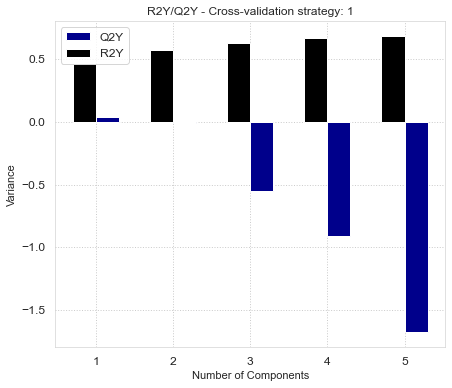

In [221]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
p3 = PLSRegression(n_components=4, scale=True)
size = ncl + 1
if ncl > 5:
    size = 5
plotR2YQ2Y(ax, p3, c2, y, 1, size)
# plt.savefig("RQ2Y.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Predictions

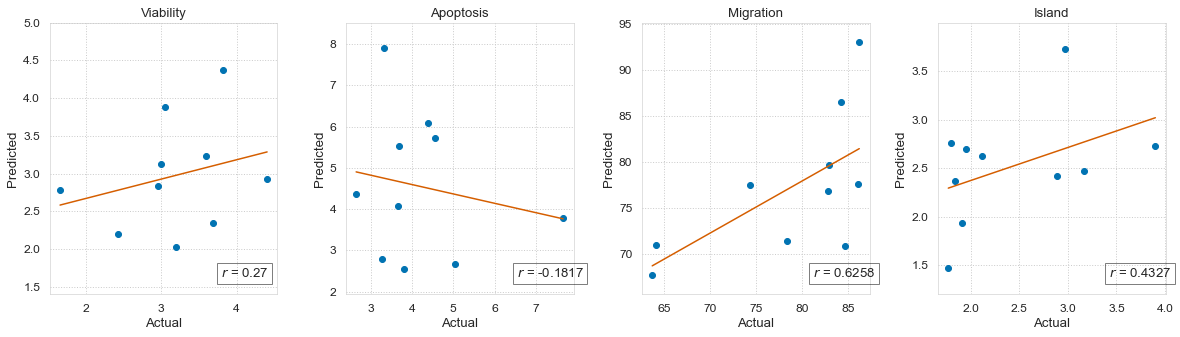

In [38]:
fig, ax = plt.subplots(1, 4, figsize=(20,5))
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plotActualVsPredicted(ax, p3, c2, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

#### Scores & Loadings

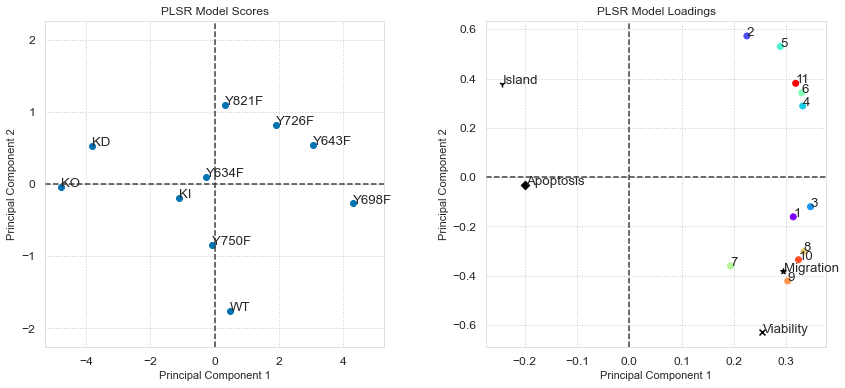

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plt.savefig("ScoressLoading.svg", bbox_inches='tight', format='svg', dpi=1200)

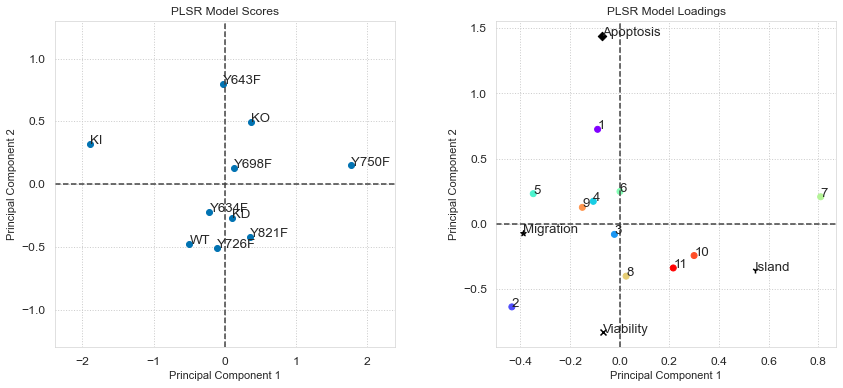

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14,6))
plotScoresLoadings(ax, p3.fit(c2, y), c2, y, ncl, lines, 1, pcX=3, pcY=4)
fig.subplots_adjust(wspace=0.3, hspace=0.4)

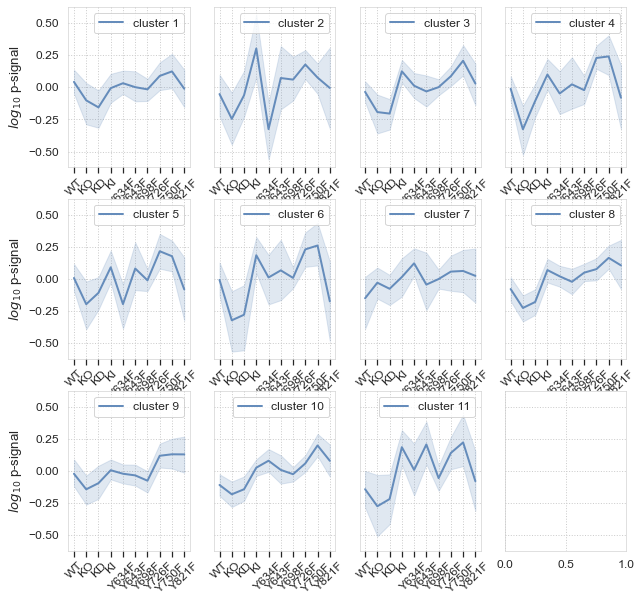

In [41]:
plotClusters(X.copy(), MSC.labels_ + 1, 3, 4, lines, figsize=(10, 10))

In [42]:
# pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000000)
# pd.set_option('display.max_columns', 1000)

In [43]:
# MSC.clustermembers(X.T)

## 2.3-Random clustering and PLSR

In [44]:
# from random import choices
# x__ = x.copy()
# x__["Cluster"] = choices(list(np.arange(ncl)), k=x.shape[0])
# c3 = x__.groupby("Cluster").mean().T

#### R2Y/Q2Y

In [45]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# p4 = PLSRegression(n_components=2)
# plotR2YQ2Y(ax, p4, c3, y, 1, ncl+1)

#### Predictions

In [46]:
# fig, ax = plt.subplots(1, 4, figsize=(20,4))
# fig.subplots_adjust(wspace=0.3, hspace=0.4)
# plotActualVsPredicted(ax, p4, c3, y, 1, y_pred="cross-validation")
# plt.savefig("ActualVsPredicted.svg", bbox_inches='tight', format='svg', dpi=1200)

## Cross-validation Strategy 2: Across entire pipeline

### Fitting entire model pipeline each time

In [47]:
ncomp = 2

CoCl_plsr = Pipeline([('CoCl', MassSpecClustering(i, 10, SeqWeight=7, distance_method="Binomial", n_runs=1)), ('plsr', PLSRegression(ncomp))])
fit = CoCl_plsr.fit(d, y)
centers = CoCl_plsr.named_steps.CoCl.transform(d)

In [48]:
CoCl_plsr.named_steps.CoCl.wins_

'SeqWins: 184 DataWins: 32 BothWin: 192 MixWin: 1'

#### R2Y/Q2Y

In [49]:
# fig, ax = plt.subplots(1, 1, figsize=(7,6))
# plotR2YQ2Y(ax, CoCl_plsr, d, y, cv=2, b=5)

#### GridSearch

Run:

In [51]:
scores = MSclusPLSR_tuning(d, i, y, "Binomial")
scores = pd.DataFrame(scores)

Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 1
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluster(s) at iteration 0
Re-initialize GMM clusters, empty cluste

In [52]:
scores

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.339648      0.030665         0.004392        0.000117   
1         1.336662      0.040004         0.004420        0.000095   
2         1.351278      0.038526         0.004382        0.000065   
3         1.371419      0.043584         0.004371        0.000114   
4         1.379183      0.044930         0.004345        0.000072   
5         1.366625      0.035529         0.004348        0.000153   
6         1.368679      0.039450         0.004241        0.000047   
7         1.375186      0.038670         0.004231        0.000018   
8         1.383045      0.039030         0.004247        0.000059   
9         1.444104      0.045430         0.004542        0.000117   
10        1.411799      0.038604         0.004398        0.000089   
11        1.413755      0.039036         0.004397        0.000044   
12        1.394858      0.038753         0.004921        0.000042   
13        1.408803      0.032081         0.004954        0.000063   
14        1.408538      0.035810         0.004959        0.000045   
15        1.427715      0.040291         0.005068        0.000121   
16        1.481434      0.140915         0.005019        0.000153   
17        1.427186      0.046969         0.005096        0.000272   
18        1.422593      0.039804         0.004906        0.000047   
19        1.431870      0.040685         0.004967        0.000053   
20        1.421601      0.053088         0.005108        0.000179   
21        1.437557      0.034235         0.005032        0.000118   
22        1.437224      0.039402         0.004983        0.000041   
23        1.438999      0.029832         0.005075        0.000088   
24        1.427112      0.040082         0.005024        0.000090   
25        1.415899      0.034735         0.004967        0.000073   
26        1.432152      0.036434         0.005021        0.000109   
27        1.431365      0.033823         0.004944        0.000081   
28        1.416794      0.036514         0.004954        0.000104   
29        1.433185      0.039683         0.004975        0.000081   
30        1.432219      0.042572         0.005578        0.000075   
31        1.435854      0.036009         0.005646        0.000143   
32        1.425903      0.039287         0.005608        0.000159   
33        1.433109      0.037053         0.005687        0.000082   
34        1.441862      0.037946         0.005711        0.000090   
35        1.431626      0.035168         0.005694        0.000078   
36        1.446866      0.038312         0.005665        0.000065   
37        1.436618      0.041817         0.005604        0.000071   
38        1.427664      0.043850         0.005660        0.000125   
39        1.433045      0.038134         0.005664        0.000173   
40        1.435287      0.057881         0.005579        0.000032   
41        1.438152      0.039945         0.005674        0.000216   
42        1.442413      0.040303         0.005562        0.000063   
43        1.427450      0.040549         0.005579        0.000066   
44        1.427269      0.032967         0.005546        0.000046   
45        1.435200      0.041289         0.005729        0.000144   
46        1.429272      0.046419         0.005654        0.000071   
47        1.437896      0.032229         0.005698        0.000092   
48        1.434242      0.039006         0.005644        0.000057   
49        1.441139      0.039320         0.005705        0.000092   
50        1.432593      0.040634         0.005636        0.000055   
51        1.420288      0.041482         0.005748        0.000120   
52        1.436998      0.044340         0.005733        0.000155   
53        1.437035      0.051454         0.005698        0.000146   
54        1.454773      0.034123         0.006360        0.000220   
55        1.468811      0.043386         0.006317        0.000165   
56        1.474703      0.032470         0.006427        0.000106   
57 

In [55]:
scores_ = scores[["rank_test_score", "param_MSclustering__SeqWeight", "param_MSclustering__ncl", "param_plsr__n_components", "mean_test_score", "std_test_score"]].sort_values(by="mean_test_score", ascending=False)

In [57]:
create_download_link(scores_, "08042020AXL_ABC_Binomial_withWT_fullGrid.csv")

#### Measured vs Predicted

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,4))
plotActualVsPredicted(ax, CoCl_plsr, d, y, 2)

#### Scores & Loadings

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, y, ncl, lines, 2)

In [ ]:
clustermembers = CoCl_plsr.named_steps.CoCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

\[ P(m, c_xj, p_xj) = \dbinom{m}{i} p_xj^i(1-p_xj)^{m-i}\]